In [1]:

import sys
import numpy as np
import pandas as pd
import networkx as nx
from collections import deque
import math
import pickle
import matplotlib.pyplot as plt

from collections import deque
import random

from shapely.geometry import LineString


def by_distance(element):
    return element[1]


def get_closest(G, locations, node, q):
    # get position of node
    x = locations[locations['ID'] == _id[node]]['Longitude'].iloc[0]
    y = locations[locations['ID'] == _id[node]]['Latitude'].iloc[0]
    
    #Neighbors
    ng = list(G.neighbors(node))
    
    # Calculate distances
    distances = list()
    for n in ng:
        n_id = _id[n]
        x_row = locations[locations['ID'] == n_id]['Longitude'].iloc[0]
        y_row = locations[locations['ID'] == n_id]['Latitude'].iloc[0]
        d = (x - x_row)**2 + (y - y_row)**2
        distances.append((n, d))
    
    # Order by distance and return q closest
    distances.sort(key = by_distance)    
    return [i[0] for i in distances[:q]] 


def get_random_tree(G, nodes, WTP=None):
    new_G = nx.DiGraph()
    N = len(G.nodes())

    if WTP is None:
        WTP = random.choice(list(G.nodes()))

    V = [0] * N;  V[WTP] = 1
    Q = deque([]); Q.append(WTP)
    while Q:
        if len(new_G.nodes()) < nodes:
            random.shuffle(Q)
            u = Q.popleft()
            for v in G.neighbors(u):
                if not V[v]:
                    Q.append(v)
                    new_G.add_edge(v,u)
                    V[v] = 1
        else:
            break
    return new_G, WTP


def add_extra_edges(T, G, locations, ratio, edge_limit):
    nodes = []
    for u in T.nodes():
        if u in G.nodes():
            nodes.append(u)
    counter = 0
    perturbed = random.choices(nodes, k = math.ceil(len(nodes) * ratio))
    for node in perturbed:
        added = False
        if len(list(T.predecessors(node))) < edge_limit:
            closest = [i for i in get_closest(G, locations, node, 7) if i in nodes]
            if closest:
                closest = closest[0]
                T_neigbors = list(T.predecessors(node)) + list(T.successors(node))
                if len(list(T.predecessors(closest))) < edge_limit and  closest not in T_neigbors:
                    T.add_edge(node, closest)
                    added = True
                    #print('added')
        if not added and counter < len(nodes):
            perturbed.append(random.choice(nodes))
            counter += 1
    return T


def get_ideal(G, V_, u):
    
    if V_[u]:
        return list()
    
    V = V_.copy()
    s = [u];  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s.append(v)
                V[v] = 1; Q.append(v)
    
    return s


def visit(G, V, u):
    
    if V[u]:
        return V, 0
    
    V[u] = 1; ans = 0
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft(); ans += 1
        for v in G.predecessors(u):
            if not V[v]:
                V[v] = 1
                Q.append(v)
    
    return V, ans


def get_size(G, V_, u):
    
    if V_[u]:
        return 0
    
    V = V_.copy()
    
    ans = 1;  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                ans += 1; V[v] = 1
                Q.append(v)
    
    return ans


def get_ideal_robust(G, V_, root, node):
    
    if root == node:
        return get_ideal(G, V_, root)
    
    V = [0 for u in range(len(V_))]
    V[root] = 1
    Q = deque([root])
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v != node:
                V[v] = 1
                Q.append(v)

    return [i for i in G.nodes() if (V_[i] == 0 and V[i] == 0)]


def visit_robust(G, V, root, u):
    
    I = get_ideal_robust(G, V, root, u)
    
    V_ = V.copy()
    for u in I:
        V_[u] = 1
    
    return V_, len(I)


def get_size_robust(G, V_, root, node):
    
    N = len(V_)
    
    if V_[node]:
        return 0
    
    if node == root:
        return N - sum(V_)
    
    V = [0] * N
    
    V[root] = 1; Q = deque([root])
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v != node:
                V[v] = 1
                Q.append(v)

    return sum([1 for u in range(N) if V_[u] + V[u] == 0])


def get_size_weight(G, W, V_, u):
    
    if V_[u]:
        return 0, 0
    
    V = V_.copy()
    
    s = 1; w = W[u]; V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s += 1; w += W[v]; V[v] = 1
                Q.append(v)
    
    return s, w


def get_size_weight_robust(G, W, V_, root, node):
    N = len(G.nodes())
    
    if V_[node]:
        return 0 , 0
    
    if node == root:
        return N - sum(V_), sum(W) - sum([W[i] for i in G.nodes() if V_[i]])
    
    V = [0] * len(V_)
    
    V[root] = 1; Q = deque([root])
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v != node:
                V[v] = 1
                Q.append(v)
                
    I = [i for i in G.nodes() if (V_[i] == 0 and V[i] == 0)]
    return sum([1 for i in I]), sum([W[i] for i in I])


def greedyAppReduceAll(G, W, V_, root, K, slim, wlim, plim, calcRobust, visitRobust):
    
    V = V_.copy(); N = len(G.nodes()); N_ = len(W)

    ans = []; tot = 0
    while len(ans) < K:
        
        E = []
        
        S = [0 for u in range(N_)]
        SS = [0 for u in range(N_)]
        for v in G.nodes():
            if not V[v]:
                ss = get_size(G, V, v)
                sr = get_size_robust(G, V, root, v)
                if calcRobust:
                    SS[v], S[v] = get_size_weight_robust(G, W, V, root, v)
                else:
                    SS[v], S[v] = get_size_weight(G, W, V, v)
                if (sr / ss) >= plim:
                    E.append(v)
        
        maxv = 0; u = -1
        for v in E:
            s = SS[v]
            if s > maxv and s <= slim and S[v] <= wlim:
                u = v
                maxv = s
            
        if u == -1:
            break
        
        x = None
        if visitRobust:
            V, x = visit_robust(G, V, root, u)
        else:
            V, x = visit(G, V, u)
        ans.append(u); tot += x
        
    return ans, tot


def simulate_robust_randtree(G, root, W, k2, S, plim, calcRobust, visitRobust, verbose, map_prev):
    
    iters = []
    
    N = len(G.nodes())
    N_ = len(W)

    node_it = 0
    for r in S:
        
        node_it += 1

        if verbose:
            print(r)

        CV = [0 for u in range(N_)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            successors = list(G.successors(u))
            if successors:
                v = random.sample(successors, 1)[0]
                CV[v] = 1
                Q.append(v)

        V = [1 for u in range(N_)]
        for u in G.nodes():
            V[u] = 0

        R = N
        for t in range(10000):
            
            R = N_ - sum(V); P = []; sP = 0
            
            if not verbose:
                print("                                                           ", end="\r")
                print(f"Search {r}: {t + 1}    now: {R}", end="\r")
            
            if verbose:
                print("it,", t, R)
                
            nn = 0
            for i in G.nodes():
                if V[i]:
                    nn += 2**i
            
            if nn in map_prev.keys():
                P = map_prev[nn]
            else:
                if R > N / 10:
                    P, sP = greedyAppReduceAll(G, W, V, root, k2, R / 3, 1e8, plim, calcRobust, visitRobust)
                elif R >= 10:
                    low = 0; high = R
                    while low != high:
                        mid = (low + high) // 2
                        P, sP = greedyAppReduceAll(G, W, V, root, k2, mid, 1e8, plim, calcRobust, visitRobust)
                        if R - sP < mid:
                            high = mid
                        else:
                            low = mid + 1
                    P, sP = greedyAppReduceAll(G, W, V, root, k2, low, 1e8, plim, calcRobust, visitRobust)
                    
                    if verbose:
                        print("pre low:", low, R - sP)

                    if low > 1:
                        P_, sP_ = greedyAppReduceAll(G, W, V, root, k2, low - 1, 1e8, plim, calcRobust, visitRobust)

                        if verbose:
                            print("low:", low, R - sP, R - sP_)

                        if abs((R - sP_) - (low - 1)) < abs((R - sP) - low) or len(P) == 1:
                            P = P_; sP = sP_
                else:
                    P, sP = greedyAppReduceAll(G, W, V, root, k2, 1, 1e8, plim, calcRobust, visitRobust)
    
            if verbose:
                print("nx", len(P), sum([CV[u] for u in P]), N_ - sum(V))
                print("P: ", ' '.join([str(p) for p in P]))

            while True:
                
                V__ = V
                if sum([CV[u] for u in P]):
                    V_ = [-1 * V[u] for u in range(N_)]
                    for u in P:
                        if CV[u]:
                            I = get_ideal(G, V, u)
                            for v in I:
                                V_[v] += 1

                    V__ = [(V_[u] != sum([CV[u] for u in P])) for u in range(N_)]

                    if verbose:
                        print("if: ", N_ - sum(V_))

                for u in P:
                    if not CV[u]:
                        I = get_ideal_robust(G, V__, root, u)
                        for v in I:
                            V__[v] = 1
                
                if N_ - sum(V__) == R:
                    POS = []
                    for i in range(N_):
                        if V[i] == 0:
                            POS.append(i)
                    P = random.sample(POS, len(P))
                else:
                    V = V__
                    break
                        
            size = N_ - sum(V)
            weight = sum([W[u] for u in range(N_) if not V[u]])
            
            map_prev[nn] = P
            
            if verbose:
                print(size, weight)

            if size == 1 or weight <= 200:
                iters.append(t + 1)
                print(f"[{node_it}] Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break
            if size <= k2:
                iters.append(t + 2)
                print(f"[{node_it}] Result {r}: {iters[-1]}    acc: {sum(iters) / len(iters)}")
                break

    print(sum(iters) / len(iters), max(iters), "\n\n\n")
    
    return iters, map_prev


def get_location_node(locations, node):
    x = locations[locations['ID'] == node]['Longitude'].iloc[0]
    y = locations[locations['ID'] == node]['Latitude'].iloc[0]
    return x,y


def create_linestring_coord(x_1, y_1, x_2, y_2):
    return LineString([(x_1, y_1) , (x_2, y_2)])


def get_random_tree_divide(G, nodes, mxl, nodes_location, edges_location, WTP=None):

    new_edges = edges_location.copy()
    new_nodes = nodes_location.copy()

    last_edge_id = int(new_edges.tail(1)['edge_ID'])
    last_node_id = max(max(new_edges['ID_1']), max(new_edges['ID_2']))

    new_G = nx.DiGraph()
    N = len(G.nodes())

    if WTP is None:
        WTP = random.choice(list(G.nodes()))

    V = [0] * N;  V[WTP] = 1
    Q = deque([]); Q.append(WTP)
    while Q:
        if len(new_G.nodes()) < nodes:

            random.shuffle(Q)

            u = Q.popleft()
            xu, yu = get_location_node(nodes_location, u)

            for v in G.neighbors(u):
                if not V[v]:

                    Q.append(v); V[v] = 1
                    
                    xv, yv = get_location_node(nodes_location, v)
                    dist = np.sqrt((xu - xv) ** 2 + (yu - yv) ** 2)

                    xd, yd = (xu - xv) / dist, (yu - yv) / dist

                    while dist > mxl:

                        xvv, yvv = xv + xd * mxl, yv + yd * mxl
                        last_edge_id += 1
                        last_node_id += 1
                        new_G.add_edge(v, last_node_id)
                        new_edges = new_edges.append({'edge_ID': last_edge_id, 'ID_1': v, 'ID_2': last_node_id, 'Distance': mxl, 
                                                      'geometry': create_linestring_coord(xv, yv, xvv, yvv)}, ignore_index=True)
                        new_nodes = new_nodes.append({'ID': last_node_id, "Longitude": xvv, "Latitude": yvv}, ignore_index=True)

                        xv, yv = xvv, yvv
                        dist = np.sqrt((xu - xv) ** 2 + (yu - yv) ** 2)
                        v = last_node_id
                
                    last_edge_id += 1
                    new_G.add_edge(v, u)
                    new_edges = new_edges.append({'edge_ID': last_edge_id, 'ID_1': v, 'ID_2': u, 'Distance': dist, 
                                                  'geometry': create_linestring_coord(xv, yv, xu, yu)}, ignore_index=True)

        else:
            break

    return new_G, WTP, new_nodes, new_edges


In [2]:
dx = [1, -1, 0, 0]
dy = [0, 0, 1, -1]

def obtain_random_tree(n, m):
    
    G = nx.DiGraph()
    
    V = [[0 for i in range(m)] for j in range(n)]; V[0][0] = 1
    Q = deque([]); Q.append(0)
    while Q:
        
        random.shuffle(Q)
        
        u = Q.popleft()
        ux = u // m; uy = u % m
        
        for k in range(4):
            vx = ux + dx[k]; vy = uy + dy[k]
            if vx >= 0 and vx < n and vy >= 0 and vy < m:
                
                v = vx * m + vy
                
                if V[vx][vy] == 0:
                    
                    Q.append(v)
                    G.add_edge(v, u)
                    V[vx][vy] = 1
    
    return G


def obtain_center_random_tree(n, m):
    
    G = nx.DiGraph()
    
    V = [[0 for i in range(2 * m + 1)] for j in range(2 * n + 1)]; V[n][m] = 1
    Q = deque([]); Q.append(n * (2 * m + 1) + m)
    while Q:
        
        random.shuffle(Q)
        
        u = Q.popleft()
        ux = u // (2 * m + 1); uy = u % (2 * m + 1)
        
        for k in range(4):
            vx = ux + dx[k]; vy = uy + dy[k]
            if vx >= 0 and vx < (2 * n + 1) and vy >= 0 and vy < (2 * m + 1):
                
                v = vx * (2 * m + 1) + vy
                
                if V[vx][vy] == 0:
                    
                    Q.append(v)
                    G.add_edge(v, u)
                    V[vx][vy] = 1
    
    return G
    

def generate_grid_graph(G, n, m, p):
    
    order = list(nx.algorithms.dag.topological_sort(G))
    id_ = [0 for i in range(n * m)]
    for i in range(n * m):
        id_[order[i]] = i
        
    for u in range(n * m):
        
        x = np.random.binomial(1, p)
        
        if x:
        
            ux = u // m; uy = u % m
            for k in range(4):
                vx = ux + dx[k]; vy = uy + dy[k]
                v = vx * m + vy
                if vx >= 0 and vx < n and vy >= 0 and vy < m and (u, v) not in G.edges():
                    if id_[u] < id_[v]:
                        G.add_edge(u, v)
    
    return G
            
    

In [3]:

ITT = []
IT = []

for p in [0, 0.5, 1]:
    n = 10; m = 10
    N = n * m
    K = 5

    G = obtain_random_tree(n, m)
    G = generate_grid_graph(G, n, m, p)

    W = [1000000 for i in range(N)]
    iters, _ = simulate_robust_randtree(G, 0, W, K, G.nodes(), 0, True, True, False, {})
    
    IT.append(iters.copy())
    
ITT.append(IT.copy())

[1] Result 10: 3    acc: 3.0
[2] Result 0: 2    acc: 2.5
[3] Result 1: 2    acc: 2.3333333333333335
[4] Result 20: 3    acc: 2.5
[5] Result 11: 3    acc: 2.6
[6] Result 30: 3    acc: 2.6666666666666665
[7] Result 21: 4    acc: 2.857142857142857
[8] Result 31: 3    acc: 2.875
[9] Result 22: 4    acc: 3.0
[10] Result 41: 4    acc: 3.1
[11] Result 32: 3    acc: 3.090909090909091
[12] Result 51: 4    acc: 3.1666666666666665
[13] Result 42: 3    acc: 3.1538461538461537
[14] Result 40: 4    acc: 3.2142857142857144
[15] Result 12: 3    acc: 3.2
[16] Result 23: 4    acc: 3.25
[17] Result 2: 3    acc: 3.235294117647059
[18] Result 13: 3    acc: 3.2222222222222223
[19] Result 52: 4    acc: 3.263157894736842
[20] Result 43: 4    acc: 3.3
[21] Result 33: 4    acc: 3.3333333333333335
[22] Result 24: 4    acc: 3.3636363636363638
[23] Result 50: 4    acc: 3.391304347826087
[24] Result 62: 4    acc: 3.4166666666666665
[25] Result 53: 4    acc: 3.44
[26] Result 60: 4    acc: 3.4615384615384617
[27] Res

[74] Result 7: 4    acc: 3.635135135135135
[75] Result 9: 4    acc: 3.64
[76] Result 94: 4    acc: 3.6447368421052633
[77] Result 85: 3    acc: 3.6363636363636362
[78] Result 49: 4    acc: 3.641025641025641
[79] Result 57: 4    acc: 3.6455696202531644
[80] Result 91: 4    acc: 3.65
[81] Result 76: 3    acc: 3.6419753086419755
[82] Result 67: 4    acc: 3.6463414634146343
[83] Result 58: 4    acc: 3.6506024096385543
[84] Result 95: 3    acc: 3.642857142857143
[85] Result 77: 3    acc: 3.635294117647059
[86] Result 68: 4    acc: 3.63953488372093
[87] Result 66: 4    acc: 3.6436781609195403
[88] Result 59: 4    acc: 3.647727272727273
[89] Result 90: 4    acc: 3.651685393258427
[90] Result 86: 3    acc: 3.6444444444444444
[91] Result 78: 4    acc: 3.6483516483516483
[92] Result 69: 4    acc: 3.652173913043478
[93] Result 79: 4    acc: 3.6559139784946235
[94] Result 96: 3    acc: 3.648936170212766
[95] Result 88: 4    acc: 3.6526315789473682
[96] Result 97: 3    acc: 3.6458333333333335
[97] 

[7] Result 3: 4    acc: 3.7142857142857144
[8] Result 21: 4    acc: 3.75
[9] Result 22: 5    acc: 3.888888888888889
[10] Result 13: 5    acc: 4.0
[11] Result 4: 4    acc: 4.0
[12] Result 14: 4    acc: 4.0
[13] Result 5: 5    acc: 4.076923076923077
[14] Result 20: 3    acc: 4.0
[15] Result 24: 3    acc: 3.933333333333333
[16] Result 15: 4    acc: 3.9375
[17] Result 23: 5    acc: 4.0
[18] Result 25: 5    acc: 4.055555555555555
[19] Result 16: 4    acc: 4.052631578947368
[20] Result 32: 5    acc: 4.1
[21] Result 6: 5    acc: 4.142857142857143
[22] Result 31: 4    acc: 4.136363636363637
[23] Result 33: 5    acc: 4.173913043478261
[24] Result 34: 4    acc: 4.166666666666667
[25] Result 7: 5    acc: 4.2
[26] Result 42: 5    acc: 4.230769230769231
[27] Result 35: 5    acc: 4.2592592592592595
[28] Result 26: 5    acc: 4.285714285714286
[29] Result 43: 5    acc: 4.310344827586207
[30] Result 44: 5    acc: 4.333333333333333
[31] Result 54: 5    acc: 4.354838709677419
[32] Result 45: 4    acc: 4.

[37] Result 41: 4    acc: 4.45945945945946
[38] Result 30: 4    acc: 4.447368421052632
[39] Result 36: 5    acc: 4.461538461538462
[40] Result 27: 5    acc: 4.475
[41] Result 64: 5    acc: 4.487804878048781
[42] Result 55: 5    acc: 4.5
[43] Result 53: 5    acc: 4.511627906976744
[44] Result 63: 4    acc: 4.5
[45] Result 52: 4    acc: 4.488888888888889
[46] Result 74: 3    acc: 4.456521739130435
[47] Result 65: 5    acc: 4.468085106382978
[48] Result 28: 5    acc: 4.479166666666667
[49] Result 19: 6    acc: 4.510204081632653
[50] Result 40: 4    acc: 4.5
[51] Result 46: 4    acc: 4.490196078431373
[52] Result 29: 6    acc: 4.519230769230769
[53] Result 51: 4    acc: 4.509433962264151
[54] Result 50: 4    acc: 4.5
[55] Result 73: 4    acc: 4.490909090909091
[56] Result 62: 3    acc: 4.464285714285714
[57] Result 61: 4    acc: 4.456140350877193
[58] Result 71: 4    acc: 4.448275862068965
[59] Result 60: 4    acc: 4.440677966101695
[60] Result 39: 6    acc: 4.466666666666667
[61] Result 7

[1] Result 10: 4    acc: 4.0                               
[2] Result 0: 9    acc: 6.5                                
[3] Result 1: 4    acc: 5.666666666666667                  
[4] Result 20: 4    acc: 5.25                              
[5] Result 11: 3    acc: 4.8                               
[6] Result 30: 4    acc: 4.666666666666667                 
[7] Result 21: 4    acc: 4.571428571428571                 
[8] Result 2: 4    acc: 4.5                                
[9] Result 12: 4    acc: 4.444444444444445                 
[10] Result 22: 6    acc: 4.6                              
[11] Result 13: 7    acc: 4.818181818181818                
[12] Result 23: 6    acc: 4.916666666666667                
[13] Result 3: 4    acc: 4.846153846153846                 
[14] Result 14: 7    acc: 5.0                              
[15] Result 24: 5    acc: 5.0                              
[16] Result 4: 4    acc: 4.9375                            
[17] Result 15: 5    acc: 4.941176470588

In [4]:
for it in IT:
    print(sum(it) / len(it), max(it), "\n")

3.65 4 

4.45 6 

5.16 9 



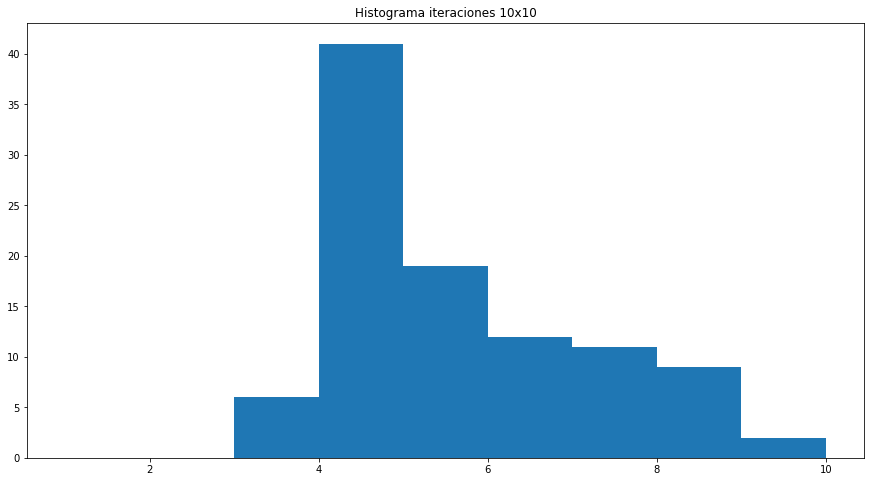

In [40]:
plt.figure(figsize=(15, 8))
IT = ITT_loaded[0]
plt.title("Histograma iteraciones 10x10")

bins = range(1, max(IT[-1]) + 2)
plt.hist(IT[-1], bins=bins)
plt.show()

In [6]:

IT = []

for p in [0, 0.5, 1]:
    n = 20; m = 20
    N = n * m
    K = 5

    G = obtain_random_tree(n, m)
    G = generate_grid_graph(G, n, m, p)

    W = [1000000 for i in range(N)]
    iters, _ = simulate_robust_randtree(G, 0, W, K, G.nodes(), 0, True, True, False, {})
    
    IT.append(iters.copy())
    
ITT.append(IT.copy())

[1] Result 20: 3    acc: 3.0                               
[2] Result 0: 3    acc: 3.0                                
[3] Result 1: 3    acc: 3.0                                
[4] Result 21: 3    acc: 3.0                               
[5] Result 2: 3    acc: 3.0                                
[6] Result 40: 3    acc: 3.0                               
[7] Result 41: 3    acc: 3.0                               
[8] Result 22: 4    acc: 3.125                             
[9] Result 42: 5    acc: 3.3333333333333335                
[10] Result 23: 4    acc: 3.4                              
[11] Result 61: 3    acc: 3.3636363636363638               
[12] Result 62: 5    acc: 3.5                              
[13] Result 43: 4    acc: 3.5384615384615383               
[14] Result 82: 4    acc: 3.5714285714285716               
[15] Result 63: 4    acc: 3.6                              
[16] Result 60: 3    acc: 3.5625                           
[17] Result 44: 4    acc: 3.588235294117

[144] Result 266: 4    acc: 3.875                          
[145] Result 247: 4    acc: 3.8758620689655174             
[146] Result 211: 4    acc: 3.8767123287671232             
[147] Result 192: 4    acc: 3.877551020408163              
[148] Result 230: 4    acc: 3.8783783783783785             
[149] Result 249: 4    acc: 3.879194630872483              
[150] Result 262: 4    acc: 3.88                           
[151] Result 152: 4    acc: 3.880794701986755              
[152] Result 173: 4    acc: 3.8815789473684212             
[153] Result 112: 4    acc: 3.8823529411764706             
[154] Result 244: 4    acc: 3.883116883116883              
[155] Result 286: 4    acc: 3.8838709677419354             
[156] Result 267: 4    acc: 3.8846153846153846             
[157] Result 265: 4    acc: 3.8853503184713376             
[158] Result 260: 4    acc: 3.8860759493670884             
[159] Result 285: 4    acc: 3.8867924528301887             
[160] Result 264: 4    acc: 3.8875      

[339] Result 98: 4    acc: 3.9557522123893807
[340] Result 138: 4    acc: 3.9558823529411766
[341] Result 119: 4    acc: 3.9560117302052786
[342] Result 197: 4    acc: 3.956140350877193
[343] Result 314: 4    acc: 3.956268221574344
[344] Result 16: 4    acc: 3.9563953488372094
[345] Result 19: 4    acc: 3.9565217391304346
[346] Result 178: 4    acc: 3.9566473988439306
[347] Result 315: 4    acc: 3.956772334293948
[348] Result 296: 4    acc: 3.956896551724138
[349] Result 256: 4    acc: 3.95702005730659
[350] Result 277: 4    acc: 3.9571428571428573
[351] Result 217: 4    acc: 3.9572649572649574
[352] Result 198: 4    acc: 3.9573863636363638
[353] Result 374: 4    acc: 3.9575070821529743
[354] Result 334: 4    acc: 3.957627118644068
[355] Result 355: 4    acc: 3.9577464788732395
[356] Result 316: 4    acc: 3.957865168539326
[357] Result 297: 4    acc: 3.957983193277311
[358] Result 393: 4    acc: 3.958100558659218
[359] Result 375: 4    acc: 3.9582172701949863
[360] Result 335: 4    acc

[399] Result 399: 4    acc: 3.9674185463659146             
[400] Result 379: 4    acc: 3.9675                         
3.9675 5 



[1] Result 20: 9    acc: 9.0                               
[2] Result 0: 9    acc: 9.0                                
[3] Result 1: 4    acc: 7.333333333333333                  
[4] Result 40: 3    acc: 6.25                              
[5] Result 21: 4    acc: 5.8                               
[6] Result 60: 3    acc: 5.333333333333333                 
[7] Result 41: 5    acc: 5.285714285714286                 
[8] Result 61: 5    acc: 5.25                              
[9] Result 42: 5    acc: 5.222222222222222                 
[10] Result 22: 4    acc: 5.1                              
[11] Result 2: 4    acc: 5.0                               
[12] Result 23: 5    acc: 5.0                              
[13] Result 80: 3    acc: 4.846153846153846                
[14] Result 81: 5    acc: 4.857142857142857                
[15] Result 62: 5    acc: 4

[142] Result 169: 6    acc: 5.52112676056338
[143] Result 150: 8    acc: 5.538461538461538
[144] Result 152: 8    acc: 5.555555555555555
[145] Result 220: 5    acc: 5.551724137931035
[146] Result 168: 6    acc: 5.554794520547945
[147] Result 187: 6    acc: 5.557823129251701
[148] Result 221: 5    acc: 5.554054054054054
[149] Result 115: 7    acc: 5.563758389261745
[150] Result 75: 7    acc: 5.573333333333333
[151] Result 96: 7    acc: 5.582781456953643
[152] Result 189: 7    acc: 5.592105263157895
[153] Result 170: 7    acc: 5.601307189542483
[154] Result 226: 6    acc: 5.603896103896104
[155] Result 207: 7    acc: 5.612903225806452
[156] Result 240: 5    acc: 5.608974358974359
[157] Result 54: 5    acc: 5.6050955414012735
[158] Result 227: 6    acc: 5.6075949367088604
[159] Result 208: 7    acc: 5.616352201257862
[160] Result 188: 6    acc: 5.61875
[161] Result 245: 7    acc: 5.627329192546584
[162] Result 260: 5    acc: 5.6234567901234565


[163] Result 241: 5    acc: 5.619631901840491              
[164] Result 135: 7    acc: 5.628048780487805              
[165] Result 116: 4    acc: 5.618181818181818              
[166] Result 242: 5    acc: 5.614457831325301              
[167] Result 280: 4    acc: 5.604790419161676              
[168] Result 261: 5    acc: 5.601190476190476              
[169] Result 246: 6    acc: 5.603550295857988              
[170] Result 172: 7    acc: 5.6117647058823525             
[171] Result 151: 8    acc: 5.625730994152047              
[172] Result 136: 6    acc: 5.627906976744186              
[173] Result 117: 5    acc: 5.624277456647399              
[174] Result 266: 5    acc: 5.620689655172414              
[175] Result 247: 6    acc: 5.622857142857143              
[176] Result 286: 4    acc: 5.613636363636363              
[177] Result 267: 7    acc: 5.621468926553672              
[178] Result 265: 5    acc: 5.617977528089888              
[179] Result 285: 5    acc: 5.6145251396

[308] Result 197: 6    acc: 5.4935064935064934             
[309] Result 178: 6    acc: 5.495145631067961              
[310] Result 321: 5    acc: 5.493548387096774              
[311] Result 234: 5    acc: 5.491961414790997              
[312] Result 254: 7    acc: 5.496794871794871              
[313] Result 351: 5    acc: 5.49520766773163               
[314] Result 311: 6    acc: 5.496815286624204              
[315] Result 332: 5    acc: 5.495238095238095              
[316] Result 235: 5    acc: 5.493670886075949              
[317] Result 320: 4    acc: 5.488958990536277              
[318] Result 340: 4    acc: 5.484276729559748              
[319] Result 352: 6    acc: 5.4858934169279                
[320] Result 312: 5    acc: 5.484375                       
[321] Result 333: 6    acc: 5.485981308411215              
[322] Result 388: 4    acc: 5.4813664596273295             
[323] Result 217: 7    acc: 5.486068111455109              
[324] Result 198: 6    acc: 5.4876543209

[46] Result 123: 10    acc: 12.08695652173913              
[47] Result 104: 11    acc: 12.063829787234043             
[48] Result 161: 11    acc: 12.041666666666666             
[49] Result 142: 12    acc: 12.040816326530612             
[50] Result 181: 11    acc: 12.02                          
[51] Result 162: 11    acc: 12.0                           
[52] Result 27: 12    acc: 12.0                            
[53] Result 8: 12    acc: 12.0                             
[54] Result 86: 9    acc: 11.944444444444445               
[55] Result 67: 11    acc: 11.927272727272728              
[56] Result 182: 10    acc: 11.892857142857142             
[57] Result 163: 11    acc: 11.87719298245614              
[58] Result 143: 9    acc: 11.827586206896552              
[59] Result 124: 10    acc: 11.796610169491526             
[60] Result 144: 7    acc: 11.716666666666667              
[61] Result 85: 12    acc: 11.721311475409836              
[62] Result 28: 10    acc: 11.6935483870

[183] Result 133: 9    acc: 10.0                           
[184] Result 114: 6    acc: 9.978260869565217              
[185] Result 282: 6    acc: 9.956756756756757              
[186] Result 261: 6    acc: 9.935483870967742              
[187] Result 134: 9    acc: 9.93048128342246               
[188] Result 94: 10    acc: 9.930851063829786              
[189] Result 115: 7    acc: 9.915343915343914              
[190] Result 305: 7    acc: 9.9                            
[191] Result 286: 7    acc: 9.884816753926701              
[192] Result 288: 6    acc: 9.864583333333334              
[193] Result 269: 8    acc: 9.854922279792746              
[194] Result 191: 6    acc: 9.835051546391753              
[195] Result 151: 8    acc: 9.825641025641026              
[196] Result 172: 7    acc: 9.811224489795919              
[197] Result 135: 7    acc: 9.796954314720812              
[198] Result 95: 7    acc: 9.782828282828282               
[199] Result 116: 8    acc: 9.7738693467

[331] Result 275: 8    acc: 8.697885196374623              
[332] Result 256: 7    acc: 8.69277108433735               
[333] Result 295: 8    acc: 8.69069069069069               
[334] Result 276: 4    acc: 8.676646706586826              
[335] Result 217: 7    acc: 8.671641791044776              
[336] Result 331: 7    acc: 8.666666666666666              
[337] Result 315: 8    acc: 8.664688427299703              
[338] Result 296: 8    acc: 8.662721893491124              
[339] Result 294: 5    acc: 8.651917404129794              
[340] Result 335: 6    acc: 8.644117647058824              
[341] Result 316: 9    acc: 8.64516129032258               
[342] Result 314: 5    acc: 8.634502923976608              
[343] Result 336: 8    acc: 8.63265306122449               
[344] Result 317: 9    acc: 8.633720930232558              
[345] Result 280: 6    acc: 8.626086956521739              
[346] Result 219: 6    acc: 8.61849710982659               
[347] Result 369: 6    acc: 8.6109510086

In [7]:
for it in IT:
    print(sum(it) / len(it), max(it), "\n")

3.9675 5 

5.465 9 

8.3275 50 



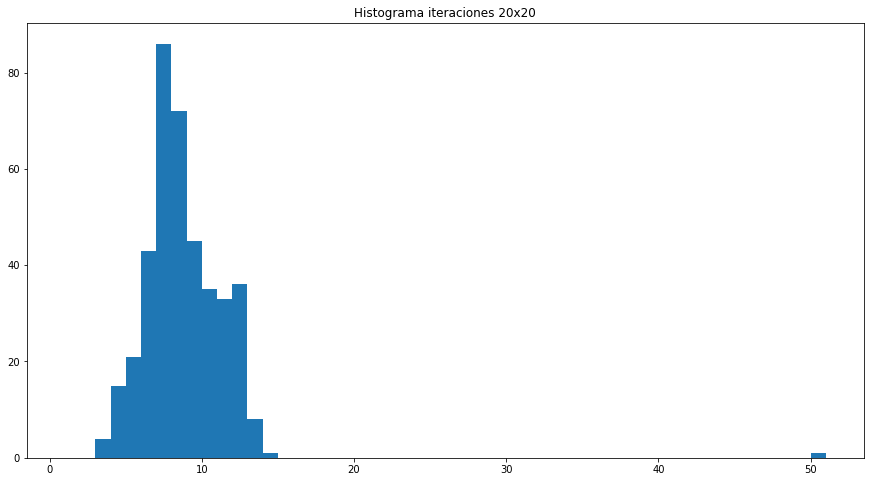

In [41]:
plt.figure(figsize=(15, 8))
IT = ITT_loaded[1]
plt.title("Histograma iteraciones 20x20")

bins = range(1, max(IT[-1]) + 2)
plt.hist(IT[-1], bins=bins)
plt.show()

In [9]:

IT = []

for p in [0, 0.5, 1]:
    n = 30; m = 30
    N = n * m
    K = 5

    G = obtain_random_tree(n, m)
    G = generate_grid_graph(G, n, m, p)

    W = [1000000 for i in range(N)]
    iters, _ = simulate_robust_randtree(G, 0, W, K, G.nodes(), 0, True, True, False, {})
    
    IT.append(iters.copy())
    
ITT.append(IT.copy())

[1] Result 30: 4    acc: 4.0                               
[2] Result 0: 5    acc: 4.5                                
[3] Result 1: 5    acc: 4.666666666666667                  
[4] Result 31: 5    acc: 4.75                              
[5] Result 2: 5    acc: 4.8                                
[6] Result 61: 5    acc: 4.833333333333333                 
[7] Result 32: 5    acc: 4.857142857142857                 
[8] Result 62: 5    acc: 4.875                             
[9] Result 33: 5    acc: 4.888888888888889                 
[10] Result 3: 5    acc: 4.9                               
[11] Result 60: 5    acc: 4.909090909090909                
[12] Result 92: 5    acc: 4.916666666666667                
[13] Result 63: 5    acc: 4.923076923076923                
[14] Result 34: 5    acc: 4.928571428571429                
[15] Result 90: 5    acc: 4.933333333333334                
[16] Result 122: 5    acc: 4.9375                          
[17] Result 93: 5    acc: 4.941176470588

[138] Result 420: 5    acc: 4.753623188405797              
[139] Result 249: 5    acc: 4.755395683453237              
[140] Result 220: 4    acc: 4.75                           
[141] Result 190: 5    acc: 4.75177304964539               
[142] Result 161: 5    acc: 4.753521126760563              
[143] Result 336: 4    acc: 4.748251748251748              
[144] Result 307: 5    acc: 4.75                           
[145] Result 101: 4    acc: 4.744827586206896              
[146] Result 191: 5    acc: 4.7465753424657535             
[147] Result 162: 5    acc: 4.7482993197278915             
[148] Result 44: 5    acc: 4.75                            
[149] Result 15: 3    acc: 4.738255033557047               
[150] Result 279: 5    acc: 4.74                           
[151] Result 250: 5    acc: 4.741721854304636              
[152] Result 72: 5    acc: 4.743421052631579               
[153] Result 221: 4    acc: 4.738562091503268              
[154] Result 192: 5    acc: 4.7402597402

[294] Result 570: 5    acc: 4.7482993197278915
[295] Result 460: 4    acc: 4.745762711864407
[296] Result 431: 4    acc: 4.743243243243243
[297] Result 372: 4    acc: 4.7407407407407405
[298] Result 571: 5    acc: 4.741610738255034
[299] Result 20: 4    acc: 4.739130434782608
[300] Result 282: 5    acc: 4.74
[301] Result 281: 5    acc: 4.740863787375416
[302] Result 227: 5    acc: 4.741721854304636
[303] Result 50: 4    acc: 4.739273927392739
[304] Result 21: 4    acc: 4.7368421052631575
[305] Result 51: 4    acc: 4.7344262295081965
[306] Result 22: 4    acc: 4.73202614379085
[307] Result 312: 3    acc: 4.726384364820847
[308] Result 343: 3    acc: 4.720779220779221
[309] Result 402: 4    acc: 4.718446601941747
[310] Result 373: 4    acc: 4.716129032258064
[311] Result 403: 4    acc: 4.713826366559486
[312] Result 374: 4    acc: 4.711538461538462
[313] Result 490: 5    acc: 4.712460063897764
[314] Result 168: 4    acc: 4.710191082802548
[315] Result 139: 4    acc: 4.707936507936508
[31

[319] Result 257: 4    acc: 4.702194357366771              
[320] Result 52: 4    acc: 4.7                             
[321] Result 23: 4    acc: 4.697819314641745               
[322] Result 600: 5    acc: 4.698757763975156              
[323] Result 198: 4    acc: 4.696594427244582              
[324] Result 169: 4    acc: 4.694444444444445              
[325] Result 197: 5    acc: 4.695384615384615              
[326] Result 228: 5    acc: 4.696319018404908              
[327] Result 316: 5    acc: 4.697247706422019              
[328] Result 287: 5    acc: 4.698170731707317              
[329] Result 313: 5    acc: 4.699088145896656              
[330] Result 346: 5    acc: 4.7                            
[331] Result 317: 5    acc: 4.7009063444108765             
[332] Result 315: 5    acc: 4.701807228915663              
[333] Result 578: 5    acc: 4.702702702702703              
[334] Result 549: 5    acc: 4.703592814371257              
[335] Result 344: 3    acc: 4.6985074626

[462] Result 790: 4    acc: 4.627705627705628              
[463] Result 788: 3    acc: 4.624190064794816              
[464] Result 670: 5    acc: 4.625                          
[465] Result 701: 5    acc: 4.625806451612903              
[466] Result 639: 5    acc: 4.626609442060086              
[467] Result 142: 4    acc: 4.625267665952891              
[468] Result 610: 5    acc: 4.6260683760683765             
[469] Result 640: 5    acc: 4.626865671641791              
[470] Result 671: 5    acc: 4.627659574468085              
[471] Result 523: 4    acc: 4.626326963906582              
[472] Result 205: 4    acc: 4.625                          
[473] Result 176: 4    acc: 4.623678646934461              
[474] Result 174: 4    acc: 4.622362869198312              
[475] Result 231: 5    acc: 4.623157894736842              
[476] Result 725: 5    acc: 4.623949579831932              
[477] Result 694: 5    acc: 4.6247379454926625             
[478] Result 321: 4    acc: 4.6234309623

[607] Result 810: 5    acc: 4.543657331136738              
[608] Result 386: 4    acc: 4.542763157894737              
[609] Result 357: 4    acc: 4.541871921182266              
[610] Result 411: 4    acc: 4.540983606557377              
[611] Result 414: 4    acc: 4.540098199672668              
[612] Result 584: 5    acc: 4.540849673202614              
[613] Result 643: 5    acc: 4.541598694942904              
[614] Result 412: 4    acc: 4.54071661237785               
[615] Result 206: 4    acc: 4.539837398373984              
[616] Result 613: 5    acc: 4.540584415584416              
[617] Result 811: 5    acc: 4.541329011345219              
[618] Result 782: 5    acc: 4.542071197411003              
[619] Result 792: 5    acc: 4.54281098546042               
[620] Result 763: 5    acc: 4.5435483870967746             
[621] Result 614: 5    acc: 4.544283413848631              
[622] Result 881: 4    acc: 4.543408360128617              
[623] Result 852: 4    acc: 4.5425361155

[752] Result 536: 5    acc: 4.490691489361702              
[753] Result 796: 5    acc: 4.49136786188579               
[754] Result 767: 5    acc: 4.492042440318302              
[755] Result 797: 5    acc: 4.49271523178808               
[756] Result 857: 4    acc: 4.492063492063492              
[757] Result 870: 5    acc: 4.492734478203435              
[758] Result 595: 5    acc: 4.493403693931398              
[759] Result 566: 5    acc: 4.4940711462450595             
[760] Result 507: 4    acc: 4.493421052631579              
[761] Result 478: 4    acc: 4.492772667542707              
[762] Result 887: 4    acc: 4.4921259842519685             
[763] Result 646: 4    acc: 4.491480996068152              
[764] Result 676: 4    acc: 4.4908376963350785             
[765] Result 647: 4    acc: 4.490196078431373              
[766] Result 827: 5    acc: 4.490861618798956              
[767] Result 798: 5    acc: 4.491525423728813              
[768] Result 596: 5    acc: 4.4921875   

[1] Result 30: 8    acc: 8.0                               
[2] Result 0: 21    acc: 14.5                              
[3] Result 1: 21    acc: 16.666666666666668                
[4] Result 31: 8    acc: 14.5                              
[5] Result 2: 21    acc: 15.8                              
[6] Result 32: 21    acc: 16.666666666666668               
[7] Result 3: 10    acc: 15.714285714285714                
[8] Result 61: 5    acc: 14.375                            
[9] Result 62: 10    acc: 13.88888888888889                
[10] Result 33: 7    acc: 13.2                             
[11] Result 63: 7    acc: 12.636363636363637               
[12] Result 34: 7    acc: 12.166666666666666               
[13] Result 64: 10    acc: 12.0                            
[14] Result 4: 10    acc: 11.857142857142858               
[15] Result 35: 5    acc: 11.4                             
[16] Result 94: 5    acc: 11.0                             
[17] Result 65: 7    acc: 10.76470588235

[139] Result 252: 9    acc: 7.446043165467626              
[140] Result 223: 9    acc: 7.457142857142857              
[141] Result 340: 7    acc: 7.453900709219858              
[142] Result 311: 8    acc: 7.457746478873239              
[143] Result 271: 8    acc: 7.461538461538462              
[144] Result 211: 8    acc: 7.465277777777778              
[145] Result 240: 8    acc: 7.468965517241379              
[146] Result 369: 7    acc: 7.465753424657534              
[147] Result 338: 6    acc: 7.45578231292517               
[148] Result 395: 8    acc: 7.45945945945946               
[149] Result 366: 8    acc: 7.4630872483221475             
[150] Result 364: 8    acc: 7.466666666666667              
[151] Result 163: 7    acc: 7.4635761589403975             
[152] Result 194: 8    acc: 7.467105263157895              
[153] Result 282: 9    acc: 7.477124183006536              
[154] Result 253: 9    acc: 7.487012987012987              
[155] Result 251: 9    acc: 7.4967741935

[416] Result 527: 5    acc: 7.305288461538462              
[417] Result 471: 9    acc: 7.309352517985611              
[418] Result 411: 7    acc: 7.3086124401913874             
[419] Result 442: 7    acc: 7.307875894988067              
[420] Result 671: 6    acc: 7.304761904761905              
[421] Result 642: 4    acc: 7.296912114014252              
[422] Result 501: 9    acc: 7.300947867298579              
[423] Result 472: 8    acc: 7.302600472813239              
[424] Result 467: 4    acc: 7.294811320754717              
[425] Result 696: 4    acc: 7.287058823529412              
[426] Result 665: 5    acc: 7.28169014084507               
[427] Result 54: 7    acc: 7.2810304449648715              
[428] Result 25: 7    acc: 7.280373831775701               
[429] Result 644: 5    acc: 7.275058275058275              
[430] Result 615: 6    acc: 7.272093023255814              
[431] Result 697: 5    acc: 7.2668213457076565             
[432] Result 499: 6    acc: 7.2638888888

[554] Result 356: 7    acc: 7.050541516245487              
[555] Result 354: 9    acc: 7.054054054054054              
[556] Result 847: 6    acc: 7.052158273381295              
[557] Result 818: 6    acc: 7.050269299820466              
[558] Result 699: 5    acc: 7.046594982078853              
[559] Result 604: 6    acc: 7.0447227191413235             
[560] Result 573: 6    acc: 7.042857142857143              
[561] Result 86: 7    acc: 7.042780748663102               
[562] Result 57: 7    acc: 7.04270462633452                
[563] Result 877: 6    acc: 7.040852575488454              
[564] Result 848: 6    acc: 7.039007092198582              
[565] Result 846: 6    acc: 7.03716814159292               
[566] Result 326: 9    acc: 7.040636042402827              
[567] Result 357: 8    acc: 7.042328042328043              
[568] Result 729: 5    acc: 7.038732394366197              
[569] Result 295: 9    acc: 7.042179261862917              
[570] Result 324: 9    acc: 7.0456140350

[693] Result 844: 6    acc: 6.922077922077922              
[694] Result 678: 5    acc: 6.9193083573487035             
[695] Result 814: 6    acc: 6.917985611510791              
[696] Result 822: 7    acc: 6.918103448275862              
[697] Result 793: 5    acc: 6.915351506456241              
[698] Result 234: 7    acc: 6.915472779369628              
[699] Result 265: 6    acc: 6.914163090128755              
[700] Result 148: 7    acc: 6.914285714285715              
[701] Result 119: 7    acc: 6.914407988587731              
[702] Result 203: 7    acc: 6.914529914529915              
[703] Result 532: 7    acc: 6.914651493598862              
[704] Result 593: 7    acc: 6.9147727272727275             
[705] Result 149: 7    acc: 6.914893617021277              
[706] Result 419: 8    acc: 6.9164305949008495             
[707] Result 733: 4    acc: 6.912305516265913              
[708] Result 597: 7    acc: 6.9124293785310735             
[709] Result 537: 5    acc: 6.9097320169

[842] Result 805: 5    acc: 6.774346793349169              
[843] Result 864: 5    acc: 6.772241992882562              
[844] Result 835: 6    acc: 6.771327014218009              
[845] Result 829: 5    acc: 6.769230769230769              
[846] Result 688: 6    acc: 6.768321513002364              
[847] Result 775: 5    acc: 6.766233766233766              
[848] Result 806: 5    acc: 6.764150943396227              
[849] Result 801: 6    acc: 6.763250883392226              
[850] Result 830: 5    acc: 6.761176470588235              
[851] Result 859: 5    acc: 6.759106933019977              
[852] Result 889: 5    acc: 6.757042253521127              
[853] Result 860: 5    acc: 6.754982415005862              
[854] Result 858: 6    acc: 6.754098360655738              
[855] Result 716: 5    acc: 6.752046783625731              
[856] Result 687: 5    acc: 6.75                           
[857] Result 831: 5    acc: 6.747957992998833              
[858] Result 863: 6    acc: 6.7470862470

[79] Result 188: 21    acc: 19.20253164556962              
[80] Result 7: 19    acc: 19.2                             
[81] Result 97: 19    acc: 19.19753086419753               
[82] Result 37: 20    acc: 19.20731707317073               
[83] Result 68: 21    acc: 19.228915662650603              
[84] Result 98: 19    acc: 19.226190476190474              
[85] Result 38: 20    acc: 19.235294117647058              
[86] Result 69: 21    acc: 19.25581395348837               
[87] Result 300: 11    acc: 19.160919540229884             
[88] Result 331: 10    acc: 19.056818181818183             
[89] Result 361: 10    acc: 18.95505617977528              
[90] Result 330: 9    acc: 18.844444444444445              
[91] Result 8: 19    acc: 18.846153846153847               
[92] Result 128: 21    acc: 18.869565217391305             
[93] Result 99: 18    acc: 18.86021505376344               
[94] Result 158: 21    acc: 18.882978723404257             
[95] Result 129: 18    acc: 18.873684210

[351] Result 493: 14    acc: 14.512820512820513            
[352] Result 464: 12    acc: 14.505681818181818            
[353] Result 662: 8    acc: 14.487252124645892             
[354] Result 634: 10    acc: 14.474576271186441            
[355] Result 607: 8    acc: 14.456338028169014             
[356] Result 578: 14    acc: 14.455056179775282            
[357] Result 664: 9    acc: 14.439775910364146             
[358] Result 635: 8    acc: 14.421787709497206             
[359] Result 692: 9    acc: 14.406685236768801             
[360] Result 663: 9    acc: 14.391666666666667             
[361] Result 661: 7    acc: 14.371191135734072             
[362] Result 722: 8    acc: 14.353591160220995             
[363] Result 693: 8    acc: 14.336088154269973             
[364] Result 691: 7    acc: 14.315934065934066             
[365] Result 21: 9    acc: 14.301369863013699              
[366] Result 721: 5    acc: 14.275956284153006             
[367] Result 690: 6    acc: 14.253405994

[625] Result 617: 9    acc: 12.1584                        
[626] Result 532: 14    acc: 12.161341853035143            
[627] Result 503: 13    acc: 12.16267942583732             
[628] Result 873: 9    acc: 12.15764331210191              
[629] Result 822: 9    acc: 12.152623211446741             
[630] Result 793: 7    acc: 12.144444444444444             
[631] Result 813: 9    acc: 12.13946117274168              
[632] Result 843: 8    acc: 12.132911392405063             
[633] Result 875: 9    acc: 12.127962085308058             
[634] Result 844: 9    acc: 12.123028391167193             
[635] Result 560: 6    acc: 12.113385826771653             
[636] Result 263: 7    acc: 12.105345911949685             
[637] Result 294: 8    acc: 12.098901098901099             
[638] Result 148: 6    acc: 12.089341692789969             
[639] Result 561: 12    acc: 12.089201877934272            
[640] Result 764: 6    acc: 12.0796875                     
[641] Result 735: 8    acc: 12.073322932

[766] Result 771: 7    acc: 11.442558746736292             
[767] Result 740: 8    acc: 11.4380704041721               
[768] Result 743: 9    acc: 11.434895833333334             
[769] Result 714: 9    acc: 11.431729518855656             
[770] Result 769: 7    acc: 11.425974025974027             
[771] Result 882: 10    acc: 11.424124513618677            
[772] Result 856: 5    acc: 11.41580310880829              
[773] Result 827: 5    acc: 11.407503234152651             
[774] Result 857: 6    acc: 11.400516795865633             
[775] Result 828: 6    acc: 11.393548387096773             
[776] Result 269: 6    acc: 11.38659793814433              
[777] Result 593: 6    acc: 11.37966537966538              
[778] Result 624: 7    acc: 11.374035989717223             
[779] Result 387: 5    acc: 11.365853658536585             
[780] Result 239: 10    acc: 11.364102564102565            
[781] Result 887: 5    acc: 11.35595390524968              
[782] Result 858: 5    acc: 11.347826086

In [10]:
for it in IT:
    print(sum(it) / len(it), max(it), "\n")

4.435555555555555 6 

6.6722222222222225 21 

10.816666666666666 112 



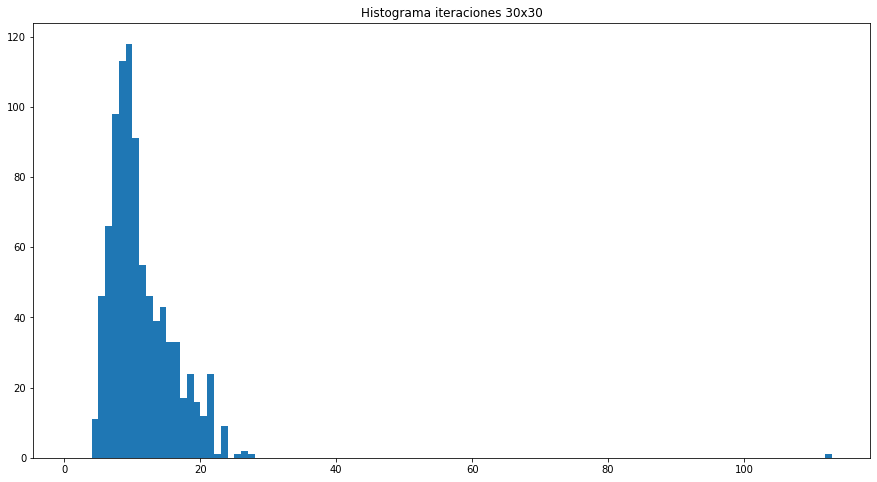

In [43]:
plt.figure(figsize=(15, 8))
IT = ITT_loaded[2]
plt.title("Histograma iteraciones 30x30")

bins = range(1, max(IT[-1]) + 2)
plt.hist(IT[-1], bins=bins)
plt.show()

In [12]:

IT = []

for p in [0, 0.5, 1]:
    n = 40; m = 40
    N = n * m
    K = 5

    G = obtain_random_tree(n, m)
    G = generate_grid_graph(G, n, m, p)

    W = [1000000 for i in range(N)]
    iters, _ = simulate_robust_randtree(G, 0, W, K, G.nodes(), 0, True, True, False, {})
    
    IT.append(iters.copy())
    
ITT.append(IT.copy())

[1] Result 40: 7    acc: 7.0                               
[2] Result 0: 7    acc: 7.0                                
[3] Result 1: 6    acc: 6.666666666666667                  
[4] Result 80: 7    acc: 6.75                              
[5] Result 41: 7    acc: 6.8                               
[6] Result 81: 7    acc: 6.833333333333333                 
[7] Result 42: 6    acc: 6.714285714285714                 
[8] Result 121: 6    acc: 6.625                            
[9] Result 82: 7    acc: 6.666666666666667                 
[10] Result 120: 7    acc: 6.7                             
[11] Result 122: 6    acc: 6.636363636363637               
[12] Result 83: 7    acc: 6.666666666666667                
[13] Result 161: 6    acc: 6.615384615384615               
[14] Result 2: 6    acc: 6.571428571428571                 
[15] Result 43: 6    acc: 6.533333333333333                
[16] Result 160: 7    acc: 6.5625                          
[17] Result 123: 6    acc: 6.52941176470

[139] Result 368: 7    acc: 6.223021582733813              
[140] Result 329: 7    acc: 6.228571428571429              
[141] Result 407: 6    acc: 6.226950354609929              
[142] Result 408: 7    acc: 6.232394366197183              
[143] Result 369: 7    acc: 6.2377622377622375             
[144] Result 520: 6    acc: 6.236111111111111              
[145] Result 481: 7    acc: 6.241379310344827              
[146] Result 448: 7    acc: 6.2465753424657535             
[147] Result 409: 7    acc: 6.2517006802721085             
[148] Result 330: 7    acc: 6.256756756756757              
[149] Result 213: 6    acc: 6.25503355704698               
[150] Result 174: 6    acc: 6.253333333333333              
[151] Result 370: 7    acc: 6.258278145695364              
[152] Result 214: 6    acc: 6.256578947368421              
[153] Result 175: 6    acc: 6.254901960784314              
[154] Result 566: 6    acc: 6.253246753246753              
[155] Result 527: 6    acc: 6.2516129032

[288] Result 725: 6    acc: 6.138888888888889
[289] Result 686: 6    acc: 6.13840830449827
[290] Result 374: 6    acc: 6.137931034482759
[291] Result 454: 7    acc: 6.140893470790378
[292] Result 17: 5    acc: 6.136986301369863
[293] Result 333: 6    acc: 6.136518771331058
[294] Result 611: 7    acc: 6.139455782312925
[295] Result 608: 6    acc: 6.138983050847457
[296] Result 534: 7    acc: 6.141891891891892
[297] Result 495: 7    acc: 6.1447811447811445
[298] Result 299: 6    acc: 6.144295302013423
[299] Result 496: 5    acc: 6.1404682274247495
[300] Result 457: 5    acc: 6.136666666666667
[301] Result 455: 5    acc: 6.132890365448505
[302] Result 334: 6    acc: 6.132450331125828
[303] Result 612: 7    acc: 6.135313531353136
[304] Result 573: 7    acc: 6.1381578947368425
[305] Result 101: 5    acc: 6.134426229508197
[306] Result 535: 7    acc: 6.137254901960785
[307] Result 418: 5    acc: 6.133550488599348
[308] Result 219: 5    acc: 6.12987012987013
[309] Result 180: 5    acc: 6.1262

[314] Result 378: 6    acc: 6.1210191082802545             
[315] Result 536: 4    acc: 6.114285714285714              
[316] Result 497: 5    acc: 6.110759493670886              
[317] Result 21: 4    acc: 6.10410094637224                
[318] Result 62: 4    acc: 6.09748427672956                
[319] Result 723: 6    acc: 6.09717868338558               
[320] Result 682: 6    acc: 6.096875                       
[321] Result 641: 6    acc: 6.0965732087227416             
[322] Result 260: 5    acc: 6.093167701863354              
[323] Result 221: 4    acc: 6.086687306501548              
[324] Result 181: 5    acc: 6.083333333333333              
[325] Result 102: 5    acc: 6.08                           
[326] Result 765: 4    acc: 6.07361963190184               
[327] Result 726: 6    acc: 6.073394495412844              
[328] Result 724: 6    acc: 6.073170731707317              
[329] Result 15: 5    acc: 6.069908814589666               
[330] Result 22: 4    acc: 6.06363636363

[455] Result 734: 7    acc: 5.881318681318682              
[456] Result 803: 6    acc: 5.881578947368421              
[457] Result 762: 6    acc: 5.8818380743982495             
[458] Result 802: 6    acc: 5.882096069868996              
[459] Result 773: 7    acc: 5.8845315904139435             
[460] Result 145: 5    acc: 5.8826086956521735             
[461] Result 65: 5    acc: 5.8806941431670285              
[462] Result 106: 5    acc: 5.878787878787879              
[463] Result 24: 5    acc: 5.876889848812095               
[464] Result 843: 4    acc: 5.872844827586207              
[465] Result 735: 7    acc: 5.875268817204301              
[466] Result 696: 7    acc: 5.877682403433476              
[467] Result 382: 6    acc: 5.877944325481799              
[468] Result 184: 4    acc: 5.8739316239316235             
[469] Result 760: 5    acc: 5.872068230277185              
[470] Result 225: 5    acc: 5.870212765957447              
[471] Result 851: 7    acc: 5.8726114649

[604] Result 702: 4    acc: 5.690397350993377              
[605] Result 1000: 4    acc: 5.687603305785124             
[606] Result 189: 5    acc: 5.686468646864687              
[607] Result 1044: 4    acc: 5.683690280065898             
[608] Result 544: 5    acc: 5.682565789473684              
[609] Result 505: 5    acc: 5.681444991789819              
[610] Result 699: 7    acc: 5.68360655737705               
[611] Result 892: 7    acc: 5.685761047463175              
[612] Result 424: 6    acc: 5.686274509803922              
[613] Result 1083: 4    acc: 5.6835236541598695            
[614] Result 150: 5    acc: 5.682410423452769              
[615] Result 27: 5    acc: 5.68130081300813                
[616] Result 1050: 4    acc: 5.678571428571429             
[617] Result 1011: 4    acc: 5.6758508914100485            
[618] Result 1009: 4    acc: 5.673139158576052             
[619] Result 465: 5    acc: 5.6720516962843295             
[620] Result 932: 7    acc: 5.6741935483

[752] Result 1131: 4    acc: 5.502659574468085
[753] Result 1129: 4    acc: 5.50066401062417
[754] Result 784: 4    acc: 5.49867374005305
[755] Result 745: 4    acc: 5.496688741721854
[756] Result 940: 7    acc: 5.498677248677248
[757] Result 901: 7    acc: 5.500660501981506
[758] Result 821: 7    acc: 5.502638522427441
[759] Result 862: 7    acc: 5.504611330698287
[760] Result 271: 5    acc: 5.503947368421053
[761] Result 311: 5    acc: 5.503285151116952
[762] Result 272: 5    acc: 5.502624671916011
[763] Result 314: 5    acc: 5.501965923984272
[764] Result 275: 5    acc: 5.5013089005235605
[765] Result 508: 4    acc: 5.499346405228758
[766] Result 469: 5    acc: 5.4986945169712795
[767] Result 1171: 4    acc: 5.496740547588005
[768] Result 1132: 4    acc: 5.494791666666667
[769] Result 780: 7    acc: 5.4967490247074124
[770] Result 1092: 4    acc: 5.494805194805195
[771] Result 1053: 4    acc: 5.4928664072632944
[772] Result 665: 4    acc: 5.490932642487047
[773] Result 1363: 4    ac

[794] Result 276: 5    acc: 5.464735516372796              
[795] Result 1364: 4    acc: 5.462893081761006             
[796] Result 1325: 4    acc: 5.461055276381909             
[797] Result 785: 4    acc: 5.459222082810539              
[798] Result 705: 4    acc: 5.457393483709273              
[799] Result 746: 4    acc: 5.4555694618272845             
[800] Result 510: 5    acc: 5.455                          
[801] Result 430: 5    acc: 5.454431960049938              
[802] Result 471: 5    acc: 5.453865336658354              
[803] Result 113: 5    acc: 5.453300124533001              
[804] Result 154: 5    acc: 5.45273631840796               
[805] Result 354: 5    acc: 5.452173913043478              
[806] Result 313: 5    acc: 5.451612903225806              
[807] Result 546: 5    acc: 5.451053283767038              
[808] Result 547: 5    acc: 5.4504950495049505             
[809] Result 73: 5    acc: 5.449938195302843               
[810] Result 114: 5    acc: 5.4493827160

[964] Result 1059: 6    acc: 5.365145228215767             
[965] Result 748: 4    acc: 5.363730569948187              
[966] Result 709: 4    acc: 5.36231884057971               
[967] Result 358: 5    acc: 5.361944157187176              
[968] Result 319: 5    acc: 5.3615702479338845             
[969] Result 435: 5    acc: 5.361197110423117              
[970] Result 396: 5    acc: 5.360824742268041              
[971] Result 1291: 4    acc: 5.359423274974254             
[972] Result 1252: 4    acc: 5.3580246913580245            
[973] Result 982: 7    acc: 5.359712230215828              
[974] Result 906: 7    acc: 5.361396303901437              
[975] Result 867: 7    acc: 5.363076923076923              
[976] Result 1402: 4    acc: 5.361680327868853             
[977] Result 983: 7    acc: 5.3633572159672465             
[978] Result 944: 7    acc: 5.365030674846626              
[979] Result 1022: 7    acc: 5.366700715015321             
[980] Result 945: 7    acc: 5.3683673469

[1101] Result 1219: 5    acc: 5.30881017257039             
[1102] Result 1028: 6    acc: 5.309437386569873            
[1103] Result 989: 6    acc: 5.310063463281958             
[1104] Result 1445: 4    acc: 5.308876811594203            
[1105] Result 1404: 4    acc: 5.3076923076923075           
[1106] Result 1259: 5    acc: 5.30741410488246             
[1107] Result 1220: 5    acc: 5.30713640469738             
[1108] Result 1529: 4    acc: 5.305956678700361            
[1109] Result 1490: 4    acc: 5.30477908025248             
[1110] Result 632: 4    acc: 5.303603603603603             
[1111] Result 1372: 4    acc: 5.302430243024302            
[1112] Result 1333: 4    acc: 5.301258992805756            
[1113] Result 1068: 6    acc: 5.30188679245283             
[1114] Result 1029: 6    acc: 5.302513464991024            
[1115] Result 1257: 6    acc: 5.303139013452915            
[1116] Result 1480: 4    acc: 5.301971326164875            
[1117] Result 1527: 4    acc: 5.30080572

[1239] Result 912: 6    acc: 5.280064568200161             
[1240] Result 717: 5    acc: 5.27983870967742              
[1241] Result 676: 5    acc: 5.279613215149073             
[1242] Result 790: 7    acc: 5.280998389694042             
[1243] Result 831: 7    acc: 5.28238133547868              
[1244] Result 791: 7    acc: 5.283762057877814             
[1245] Result 832: 7    acc: 5.285140562248996             
[1246] Result 1302: 5    acc: 5.284911717495987            
[1247] Result 872: 6    acc: 5.285485164394547             
[1248] Result 913: 6    acc: 5.2860576923076925            
[1249] Result 751: 7    acc: 5.287429943955164             
[1250] Result 792: 7    acc: 5.2888                        
[1251] Result 1342: 5    acc: 5.288569144684253            
[1252] Result 1303: 5    acc: 5.288338658146965            
[1253] Result 1301: 5    acc: 5.2881085395051874           
[1254] Result 1340: 5    acc: 5.287878787878788            
[1255] Result 1064: 7    acc: 5.28924302

[1383] Result 1389: 4    acc: 5.257411424439624            
[1384] Result 1350: 4    acc: 5.256502890173411            
[1385] Result 1152: 4    acc: 5.255595667870036            
[1386] Result 1076: 6    acc: 5.256132756132756            
[1387] Result 996: 6    acc: 5.2566690699351115            
[1388] Result 1037: 6    acc: 5.257204610951009            
[1389] Result 836: 6    acc: 5.257739380849532             
[1390] Result 759: 5    acc: 5.257553956834532             
[1391] Result 1457: 6    acc: 5.258087706685838            
[1392] Result 1418: 6    acc: 5.258620689655173            
[1393] Result 1458: 6    acc: 5.259152907394113            
[1394] Result 1419: 5    acc: 5.25896700143472             
[1395] Result 1311: 4    acc: 5.258064516129032            
[1396] Result 1272: 4    acc: 5.257163323782235            
[1397] Result 1265: 5    acc: 5.2569792412312095           
[1398] Result 1384: 5    acc: 5.256795422031473            
[1399] Result 1113: 6    acc: 5.25732666

[1527] Result 1551: 4    acc: 5.246889325474787            
[1528] Result 918: 6    acc: 5.24738219895288              
[1529] Result 959: 6    acc: 5.247874427730543             
[1530] Result 957: 6    acc: 5.248366013071895             
[1531] Result 919: 6    acc: 5.248856956237753             
[1532] Result 1393: 4    acc: 5.248041775456919            
[1533] Result 1354: 4    acc: 5.247227658186563            
[1534] Result 1392: 4    acc: 5.246414602346806            
[1535] Result 1471: 4    acc: 5.245602605863192            
[1536] Result 1432: 4    acc: 5.244791666666667            
[1537] Result 1512: 4    acc: 5.243981782693559            
[1538] Result 1506: 4    acc: 5.243172951885565            
[1539] Result 1357: 6    acc: 5.243664717348928            
[1540] Result 1318: 6    acc: 5.244155844155844            
[1541] Result 1546: 4    acc: 5.243348475016223            
[1542] Result 1507: 4    acc: 5.24254215304799             
[1543] Result 1591: 4    acc: 5.24173687

[64] Result 168: 14    acc: 12.140625                      
[65] Result 240: 12    acc: 12.138461538461538             
[66] Result 128: 11    acc: 12.121212121212121             
[67] Result 280: 12    acc: 12.119402985074627             
[68] Result 241: 12    acc: 12.117647058823529             
[69] Result 281: 12    acc: 12.115942028985508             
[70] Result 242: 12    acc: 12.114285714285714             
[71] Result 283: 12    acc: 12.112676056338028             
[72] Result 320: 12    acc: 12.11111111111111              
[73] Result 208: 13    acc: 12.123287671232877             
[74] Result 249: 11    acc: 12.108108108108109             
[75] Result 321: 12    acc: 12.106666666666667             
[76] Result 282: 11    acc: 12.092105263157896             
[77] Result 209: 9    acc: 12.051948051948052              
[78] Result 365: 15    acc: 12.08974358974359              
[79] Result 324: 15    acc: 12.126582278481013             
[80] Result 289: 11    acc: 12.1125     

[203] Result 336: 9    acc: 10.665024630541872             
[204] Result 334: 9    acc: 10.656862745098039             
[205] Result 647: 9    acc: 10.648780487804878             
[206] Result 606: 9    acc: 10.640776699029127             
[207] Result 490: 10    acc: 10.63768115942029             
[208] Result 449: 10    acc: 10.634615384615385            
[209] Result 565: 8    acc: 10.62200956937799              
[210] Result 369: 9    acc: 10.614285714285714             
[211] Result 442: 10    acc: 10.611374407582938            
[212] Result 408: 10    acc: 10.608490566037736            
[213] Result 297: 9    acc: 10.60093896713615              
[214] Result 415: 10    acc: 10.598130841121495            
[215] Result 376: 10    acc: 10.595348837209302            
[216] Result 374: 9    acc: 10.587962962962964             
[217] Result 257: 7    acc: 10.571428571428571             
[218] Result 368: 9    acc: 10.564220183486238             
[219] Result 687: 9    acc: 10.557077625

[481] Result 601: 11    acc: 9.58004158004158              
[482] Result 640: 7    acc: 9.574688796680498              
[483] Result 735: 9    acc: 9.573498964803312              
[484] Result 694: 7    acc: 9.568181818181818              
[485] Result 302: 8    acc: 9.564948453608247              
[486] Result 222: 10    acc: 9.565843621399177             
[487] Result 263: 7    acc: 9.560574948665298              
[488] Result 743: 7    acc: 9.555327868852459              
[489] Result 806: 9    acc: 9.554192229038854              
[490] Result 425: 8    acc: 9.551020408163266              
[491] Result 466: 6    acc: 9.543788187372709              
[492] Result 782: 7    acc: 9.538617886178862              
[493] Result 741: 7    acc: 9.533468559837727              
[494] Result 781: 7    acc: 9.52834008097166               
[495] Result 740: 7    acc: 9.523232323232323              
[496] Result 61: 10    acc: 9.524193548387096              
[497] Result 22: 9    acc: 9.52313883299

[619] Result 881: 7    acc: 9.153473344103393              
[620] Result 801: 7    acc: 9.15                           
[621] Result 840: 7    acc: 9.146537842190016              
[622] Result 863: 7    acc: 9.143086816720258              
[623] Result 945: 7    acc: 9.139646869983949              
[624] Result 904: 6    acc: 9.134615384615385              
[625] Result 600: 10    acc: 9.136                         
[626] Result 468: 7    acc: 9.13258785942492               
[627] Result 509: 8    acc: 9.130781499202552              
[628] Result 899: 8    acc: 9.128980891719745              
[629] Result 819: 7    acc: 9.125596184419713              
[630] Result 858: 7    acc: 9.122222222222222              
[631] Result 428: 7    acc: 9.118858954041205              
[632] Result 389: 8    acc: 9.117088607594937              
[633] Result 934: 8    acc: 9.115323854660348              
[634] Result 895: 10    acc: 9.116719242902208             
[635] Result 940: 6    acc: 9.1118110236

[761] Result 897: 9    acc: 8.9053876478318                
[762] Result 1015: 10    acc: 8.906824146981627            
[763] Result 1055: 10    acc: 8.908256880733944            
[764] Result 1016: 7    acc: 8.905759162303665             
[765] Result 869: 8    acc: 8.904575163398693              
[766] Result 830: 8    acc: 8.903394255874673              
[767] Result 349: 7    acc: 8.900912646675359              
[768] Result 269: 7    acc: 8.8984375                      
[769] Result 310: 8    acc: 8.897269180754225              
[770] Result 350: 7    acc: 8.894805194805194              
[771] Result 270: 8    acc: 8.893644617380026              
[772] Result 311: 8    acc: 8.892487046632125              
[773] Result 752: 8    acc: 8.891332470892626              
[774] Result 713: 8    acc: 8.890180878552972              
[775] Result 145: 4    acc: 8.883870967741936              
[776] Result 186: 5    acc: 8.878865979381443              
[777] Result 674: 7    acc: 8.8764478764

[900] Result 911: 7    acc: 8.672222222222222              
[901] Result 872: 8    acc: 8.671476137624861              
[902] Result 68: 4    acc: 8.66629711751663                
[903] Result 109: 5    acc: 8.662236987818384              
[904] Result 1221: 7    acc: 8.660398230088495             
[905] Result 1180: 5    acc: 8.65635359116022              
[906] Result 1256: 7    acc: 8.654525386313466             
[907] Result 1217: 6    acc: 8.651598676957                
[908] Result 1097: 9    acc: 8.651982378854626             
[909] Result 1252: 9    acc: 8.652365236523652             
[910] Result 1172: 9    acc: 8.652747252747252             
[911] Result 1211: 9    acc: 8.653128430296377             
[912] Result 1223: 7    acc: 8.651315789473685             
[913] Result 1184: 6    acc: 8.648411829134721             
[914] Result 231: 4    acc: 8.643326039387308              
[915] Result 151: 5    acc: 8.639344262295081              
[916] Result 192: 4    acc: 8.6342794759

[1040] Result 1373: 7    acc: 8.411538461538461            
[1041] Result 1332: 8    acc: 8.411143131604227            
[1042] Result 1342: 6    acc: 8.408829174664108            
[1043] Result 1303: 5    acc: 8.405560882070949            
[1044] Result 1301: 6    acc: 8.403256704980842            
[1045] Result 1343: 5    acc: 8.4                          
[1046] Result 1304: 5    acc: 8.396749521988527            
[1047] Result 514: 6    acc: 8.394460362941738             
[1048] Result 955: 8    acc: 8.39408396946565              
[1049] Result 916: 5    acc: 8.390848427073403             
[1050] Result 555: 5    acc: 8.387619047619047             
[1051] Result 993: 9    acc: 8.388201712654615             
[1052] Result 954: 7    acc: 8.386882129277566             
[1053] Result 1033: 9    acc: 8.387464387464387            
[1054] Result 994: 6    acc: 8.385199240986717             
[1055] Result 234: 6    acc: 8.382938388625593             
[1056] Result 275: 6    acc: 8.380681818

[1189] Result 37: 5    acc: 8.132884777123634              
[1190] Result 1287: 7    acc: 8.131932773109243            
[1191] Result 1297: 7    acc: 8.130982367758186            
[1192] Result 1258: 6    acc: 8.129194630872483            
[1193] Result 1108: 7    acc: 8.128248113998323            
[1194] Result 1077: 5    acc: 8.125628140703517            
[1195] Result 1038: 5    acc: 8.123012552301255            
[1196] Result 1424: 5    acc: 8.120401337792643            
[1197] Result 1385: 5    acc: 8.117794486215539            
[1198] Result 1383: 6    acc: 8.11602671118531             
[1199] Result 1203: 6    acc: 8.114261884904087            
[1200] Result 1410: 5    acc: 8.111666666666666            
[1201] Result 77: 5    acc: 8.109075770191508              
[1202] Result 38: 5    acc: 8.10648918469218               
[1203] Result 1409: 6    acc: 8.104738154613466            
[1204] Result 1368: 7    acc: 8.103820598006644            
[1205] Result 1381: 6    acc: 8.10207468

[1337] Result 1284: 6    acc: 7.919222139117427            
[1338] Result 1229: 4    acc: 7.916292974588939            
[1339] Result 1389: 5    acc: 7.91411501120239             
[1340] Result 1489: 4    acc: 7.911194029850746            
[1341] Result 1243: 8    acc: 7.911260253542133            
[1342] Result 1339: 6    acc: 7.909836065573771            
[1343] Result 1158: 6    acc: 7.908413998510797            
[1344] Result 1119: 5    acc: 7.90625                      
[1345] Result 1195: 8    acc: 7.9063197026022305           
[1346] Result 1156: 8    acc: 7.906389301634473            
[1347] Result 1151: 7    acc: 7.905716406829993            
[1348] Result 1112: 8    acc: 7.905786350148368            
[1349] Result 1110: 8    acc: 7.9058561897702              
[1350] Result 1320: 6    acc: 7.904444444444445            
[1351] Result 1281: 6    acc: 7.903034789045152            
[1352] Result 1573: 9    acc: 7.903846153846154            
[1353] Result 1534: 8    acc: 7.90391722

[1479] Result 1401: 8    acc: 7.724137931034483            
[1480] Result 1546: 4    acc: 7.721621621621622            
[1481] Result 1542: 6    acc: 7.7204591492234975           
[1482] Result 1230: 4    acc: 7.717948717948718            
[1483] Result 1271: 4    acc: 7.715441672285907            
[1484] Result 1233: 6    acc: 7.714285714285714            
[1485] Result 1441: 7    acc: 7.713804713804714            
[1486] Result 1402: 6    acc: 7.712651413189771            
[1487] Result 1512: 5    acc: 7.710827168796234            
[1488] Result 1473: 5    acc: 7.709005376344086            
[1489] Result 1585: 4    acc: 7.706514439220953            
[1490] Result 1544: 4    acc: 7.704026845637584            
[1491] Result 1352: 6    acc: 7.702883970489604            
[1492] Result 1393: 6    acc: 7.701742627345845            
[1493] Result 1403: 7    acc: 7.7012726054922975           
[1494] Result 1569: 5    acc: 7.699464524765729            
[1495] Result 1549: 4    acc: 7.69698996

[17] Result 122: 13    acc: 37.11764705882353              
[18] Result 81: 36    acc: 37.05555555555556               
[19] Result 5: 16    acc: 35.94736842105263                
[20] Result 162: 13    acc: 34.8                           
[21] Result 121: 37    acc: 34.904761904761905             
[22] Result 45: 16    acc: 34.04545454545455               
[23] Result 6: 15    acc: 33.21739130434783                
[24] Result 46: 18    acc: 32.583333333333336              
[25] Result 7: 17    acc: 31.96                            
[26] Result 86: 18    acc: 31.423076923076923              
[27] Result 47: 16    acc: 30.85185185185185               
[28] Result 87: 17    acc: 30.357142857142858              
[29] Result 48: 18    acc: 29.93103448275862               
[30] Result 127: 17    acc: 29.5                           
[31] Result 88: 19    acc: 29.161290322580644              
[32] Result 128: 17    acc: 28.78125                       
[33] Result 89: 19    acc: 28.4848484848

[294] Result 180: 13    acc: 18.829931972789115            
[295] Result 221: 13    acc: 18.810169491525425            
[296] Result 181: 12    acc: 18.78716216216216             
[297] Result 222: 14    acc: 18.77104377104377             
[298] Result 360: 11    acc: 18.74496644295302             
[299] Result 400: 8    acc: 18.70903010033445              
[300] Result 301: 12    acc: 18.686666666666667            
[301] Result 262: 11    acc: 18.66112956810631             
[302] Result 401: 13    acc: 18.642384105960264            
[303] Result 579: 23    acc: 18.656765676567655            
[304] Result 540: 23    acc: 18.67105263157895             
[305] Result 521: 12    acc: 18.64918032786885             
[306] Result 441: 11    acc: 18.624183006535947            
[307] Result 480: 12    acc: 18.60260586319218             
[308] Result 567: 12    acc: 18.58116883116883             
[309] Result 18: 10    acc: 18.553398058252426             
[310] Result 529: 14    acc: 18.53870967

[431] Result 702: 24    acc: 17.784222737819025            
[432] Result 767: 13    acc: 17.77314814814815             
[433] Result 765: 15    acc: 17.766743648960738            
[434] Result 724: 15    acc: 17.76036866359447             
[435] Result 145: 12    acc: 17.74712643678161             
[436] Result 224: 11    acc: 17.73165137614679             
[437] Result 185: 14    acc: 17.723112128146454            
[438] Result 658: 18    acc: 17.72374429223744             
[439] Result 776: 22    acc: 17.733485193621867            
[440] Result 737: 21    acc: 17.740909090909092            
[441] Result 463: 12    acc: 17.727891156462587            
[442] Result 424: 12    acc: 17.714932126696834            
[443] Result 263: 13    acc: 17.704288939051917            
[444] Result 264: 13    acc: 17.693693693693692            
[445] Result 225: 11    acc: 17.67865168539326             
[446] Result 464: 15    acc: 17.672645739910315            
[447] Result 384: 11    acc: 17.65771812

[705] Result 858: 17    acc: 16.43404255319149             
[706] Result 819: 16    acc: 16.43342776203966             
[707] Result 905: 16    acc: 16.432814710042432            
[708] Result 866: 16    acc: 16.43220338983051             
[709] Result 922: 14    acc: 16.428772919605077            
[710] Result 631: 11    acc: 16.42112676056338             
[711] Result 926: 14    acc: 16.417721518987342            
[712] Result 960: 13    acc: 16.412921348314608            
[713] Result 592: 10    acc: 16.403927068723704            
[714] Result 553: 8    acc: 16.392156862745097             
[715] Result 935: 15    acc: 16.39020979020979             
[716] Result 969: 17    acc: 16.391061452513966            
[717] Result 930: 11    acc: 16.383542538354252            
[718] Result 230: 15    acc: 16.381615598885794            
[719] Result 927: 12    acc: 16.375521557719054            
[720] Result 710: 9    acc: 16.365277777777777             
[721] Result 671: 10    acc: 16.35644937

[843] Result 192: 8    acc: 15.846975088967971             
[844] Result 1019: 15    acc: 15.845971563981042           
[845] Result 980: 13    acc: 15.842603550295857            
[846] Result 1058: 13    acc: 15.839243498817966           
[847] Result 676: 11    acc: 15.83353010625738             
[848] Result 637: 10    acc: 15.826650943396226            
[849] Result 1048: 11    acc: 15.820965842167256           
[850] Result 1007: 12    acc: 15.816470588235294           
[851] Result 790: 7    acc: 15.80611045828437              
[852] Result 947: 16    acc: 15.806338028169014            
[853] Result 908: 30    acc: 15.822977725674091            
[854] Result 234: 11    acc: 15.817330210772834            
[855] Result 275: 11    acc: 15.811695906432748            
[856] Result 517: 12    acc: 15.807242990654206            
[857] Result 558: 8    acc: 15.798133022170362             
[858] Result 435: 10    acc: 15.79137529137529             
[859] Result 476: 11    acc: 15.78579743

[982] Result 1065: 16    acc: 15.198574338085539           
[983] Result 113: 10    acc: 15.193285859613429            
[984] Result 870: 7    acc: 15.184959349593496             
[985] Result 754: 10    acc: 15.179695431472082            
[986] Result 1161: 9    acc: 15.17342799188641             
[987] Result 1120: 9    acc: 15.167173252279635            
[988] Result 1137: 13    acc: 15.164979757085021           
[989] Result 678: 8    acc: 15.157735085945399             
[990] Result 869: 13    acc: 15.155555555555555            
[991] Result 675: 9    acc: 15.149344096871847             
[992] Result 872: 12    acc: 15.14616935483871             
[993] Result 833: 12    acc: 15.143001007049346            
[994] Result 439: 9    acc: 15.13682092555332              
[995] Result 718: 8    acc: 15.12964824120603              
[996] Result 679: 8    acc: 15.122489959839358             
[997] Result 912: 16    acc: 15.123370110330994            
[998] Result 873: 7    acc: 15.115230460

[1123] Result 1168: 9    acc: 14.512911843276937           
[1124] Result 1219: 13    acc: 14.511565836298933          
[1125] Result 1180: 11    acc: 14.508444444444445          
[1126] Result 796: 5    acc: 14.5                          
[1127] Result 757: 10    acc: 14.496007098491571           
[1128] Result 1220: 11    acc: 14.49290780141844           
[1129] Result 1258: 9    acc: 14.488042515500442           
[1130] Result 1217: 10    acc: 14.484070796460177          
[1131] Result 795: 6    acc: 14.47656940760389             
[1132] Result 115: 10    acc: 14.472614840989399           
[1133] Result 995: 12    acc: 14.470432480141218           
[1134] Result 956: 12    acc: 14.468253968253968           
[1135] Result 1332: 7    acc: 14.461674008810572           
[1136] Result 1293: 9    acc: 14.456866197183098           
[1137] Result 1221: 12    acc: 14.454705364995602          
[1138] Result 1333: 9    acc: 14.449912126537786           
[1139] Result 1294: 9    acc: 14.4451273

[1260] Result 1115: 10    acc: 14.003968253968255          
[1261] Result 1076: 11    acc: 14.001586042823156          
[1262] Result 1299: 11    acc: 13.999207606973059          
[1263] Result 1339: 11    acc: 13.996832937450515          
[1264] Result 1300: 13    acc: 13.996044303797468          
[1265] Result 1404: 8    acc: 13.991304347826087           
[1266] Result 1363: 7    acc: 13.985781990521327           
[1267] Result 1455: 10    acc: 13.982636148382005          
[1268] Result 1456: 12    acc: 13.981072555205047          
[1269] Result 1417: 12    acc: 13.979511426319936          
[1270] Result 1039: 13    acc: 13.978740157480315          
[1271] Result 959: 12    acc: 13.977183320220298           
[1272] Result 1337: 10    acc: 13.974056603773585          
[1273] Result 1378: 11    acc: 13.97172034564022           
[1274] Result 1077: 13    acc: 13.970957613814758          
[1275] Result 919: 12    acc: 13.969411764705882           
[1276] Result 1117: 15    acc: 13.970219

[1402] Result 1537: 9    acc: 13.582025677603424           
[1403] Result 1535: 8    acc: 13.578047042052743           
[1404] Result 1480: 5    acc: 13.571937321937321           
[1405] Result 1565: 7    acc: 13.567259786476868           
[1406] Result 1577: 9    acc: 13.564011379800853           
[1407] Result 1575: 9    acc: 13.560767590618337           
[1408] Result 1271: 10    acc: 13.558238636363637          
[1409] Result 1191: 7    acc: 13.553584102200142           
[1410] Result 1230: 7    acc: 13.548936170212766           
[1411] Result 1523: 4    acc: 13.542168674698795           
[1412] Result 1569: 10    acc: 13.539660056657224          
[1413] Result 1530: 8    acc: 13.535739561217268           
[1414] Result 1563: 4    acc: 13.52899575671853            
[1415] Result 1522: 7    acc: 13.524381625441697           
[1416] Result 1265: 15    acc: 13.525423728813559          
[1417] Result 1277: 15    acc: 13.526464361326747          
[1418] Result 1238: 14    acc: 13.526798

In [13]:
for it in IT:
    print(sum(it) / len(it), max(it), "\n")

5.23375 7 

7.555625 15 

12.97875 154 



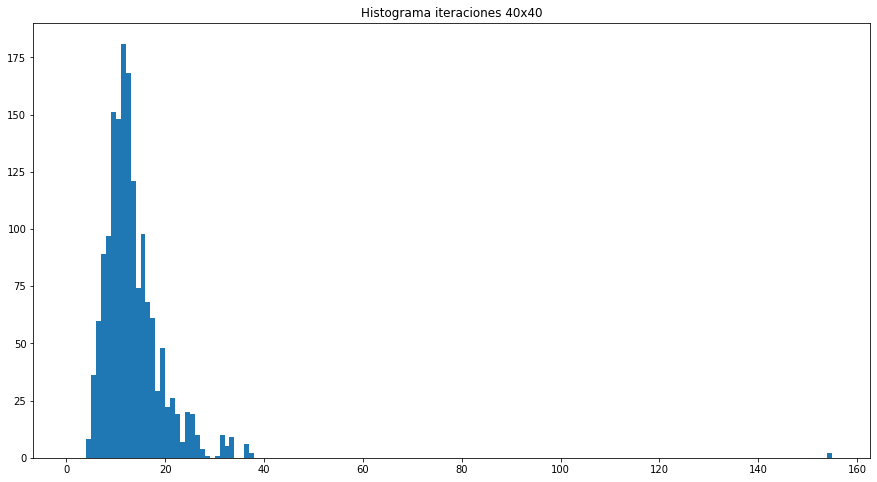

In [44]:
plt.figure(figsize=(15, 8))
IT = ITT_loaded[3]
plt.title("Histograma iteraciones 40x40")

bins = range(1, max(IT[-1]) + 2)
plt.hist(IT[-1], bins=bins)
plt.show()

In [15]:

IT = []

for p in [0, 0.5, 1]:
    n = 50; m = 50
    N = n * m
    K = 5

    G = obtain_random_tree(n, m)
    G = generate_grid_graph(G, n, m, p)

    W = [1000000 for i in range(N)]
    iters, _ = simulate_robust_randtree(G, 0, W, K, G.nodes(), 0, True, True, False, {})
    
    IT.append(iters.copy())
    
ITT.append(IT.copy())

[1] Result 50: 9    acc: 9.0                               
[2] Result 0: 9    acc: 9.0                                
[3] Result 1: 9    acc: 9.0                                
[4] Result 100: 9    acc: 9.0                              
[5] Result 51: 9    acc: 9.0                               
[6] Result 150: 9    acc: 9.0                              
[7] Result 101: 9    acc: 9.0                              
[8] Result 151: 9    acc: 9.0                              
[9] Result 102: 9    acc: 9.0                              
[10] Result 52: 9    acc: 9.0                              
[11] Result 152: 9    acc: 9.0                             
[12] Result 103: 9    acc: 9.0                             
[13] Result 153: 9    acc: 9.0                             
[14] Result 53: 9    acc: 9.0                              
[15] Result 104: 9    acc: 9.0                             
[16] Result 3: 8    acc: 8.9375                            
[17] Result 54: 9    acc: 8.941176470588

[140] Result 557: 9    acc: 8.778571428571428              
[141] Result 555: 9    acc: 8.78014184397163               
[142] Result 315: 8    acc: 8.774647887323944              
[143] Result 215: 8    acc: 8.76923076923077               
[144] Result 266: 8    acc: 8.76388888888889               
[145] Result 607: 9    acc: 8.76551724137931               
[146] Result 558: 9    acc: 8.767123287671232              
[147] Result 404: 9    acc: 8.768707482993197              
[148] Result 461: 8    acc: 8.763513513513514              
[149] Result 508: 8    acc: 8.758389261744966              
[150] Result 459: 9    acc: 8.76                           
[151] Result 450: 8    acc: 8.754966887417218              
[152] Result 365: 8    acc: 8.75                           
[153] Result 316: 8    acc: 8.745098039215685              
[154] Result 454: 9    acc: 8.746753246753247              
[155] Result 509: 9    acc: 8.748387096774193              
[156] Result 460: 8    acc: 8.7435897435

[281] Result 802: 9    acc: 8.633451957295375              
[282] Result 615: 8    acc: 8.631205673758865              
[283] Result 515: 8    acc: 8.628975265017667              
[284] Result 566: 8    acc: 8.626760563380282              
[285] Result 516: 8    acc: 8.624561403508771              
[286] Result 415: 8    acc: 8.622377622377622              
[287] Result 956: 9    acc: 8.623693379790941              
[288] Result 907: 9    acc: 8.625                          
[289] Result 905: 9    acc: 8.626297577854672              
[290] Result 466: 8    acc: 8.624137931034483              
[291] Result 517: 8    acc: 8.621993127147766              
[292] Result 903: 5    acc: 8.60958904109589               
[293] Result 852: 9    acc: 8.610921501706486              
[294] Result 168: 4    acc: 8.595238095238095              
[295] Result 219: 4    acc: 8.579661016949153              
[296] Result 702: 9    acc: 8.58108108108108               
[297] Result 751: 8    acc: 8.5791245791

[418] Result 222: 6    acc: 8.31578947368421               
[419] Result 273: 6    acc: 8.310262529832935              
[420] Result 469: 8    acc: 8.30952380952381               
[421] Result 913: 8    acc: 8.308788598574822              
[422] Result 864: 8    acc: 8.308056872037914              
[423] Result 960: 9    acc: 8.3096926713948                
[424] Result 1102: 5    acc: 8.30188679245283              
[425] Result 1257: 9    acc: 8.303529411764705             
[426] Result 1208: 9    acc: 8.305164319248826             
[427] Result 172: 4    acc: 8.295081967213115              
[428] Result 1205: 9    acc: 8.296728971962617             
[429] Result 1154: 9    acc: 8.298368298368299             
[430] Result 1050: 5    acc: 8.290697674418604             
[431] Result 1159: 9    acc: 8.292343387470998             
[432] Result 423: 6    acc: 8.287037037037036              
[433] Result 374: 6    acc: 8.28175519630485               
[434] Result 223: 6    acc: 8.2764976958

[690] Result 918: 8    acc: 7.614492753623188              
[691] Result 1703: 5    acc: 7.610709117221418             
[692] Result 1654: 5    acc: 7.606936416184971             
[693] Result 1359: 9    acc: 7.608946608946609             
[694] Result 1350: 5    acc: 7.605187319884727             
[695] Result 1356: 9    acc: 7.607194244604316             
[696] Result 1455: 5    acc: 7.603448275862069             
[697] Result 1355: 5    acc: 7.599713055954089             
[698] Result 1406: 5    acc: 7.595988538681948             
[699] Result 1116: 9    acc: 7.597997138769671             
[700] Result 1167: 9    acc: 7.6                           
[701] Result 326: 6    acc: 7.59771754636234               
[702] Result 377: 6    acc: 7.595441595441596              
[703] Result 1605: 5    acc: 7.591749644381223             
[704] Result 1505: 5    acc: 7.588068181818182             
[705] Result 1556: 5    acc: 7.584397163120568             
[706] Result 1400: 5    acc: 7.580736543

[964] Result 682: 7    acc: 7.20850622406639               
[965] Result 1759: 4    acc: 7.205181347150259             
[966] Result 1708: 4    acc: 7.201863354037267             
[967] Result 1171: 8    acc: 7.202688728024819             
[968] Result 1122: 8    acc: 7.203512396694215             
[969] Result 1120: 8    acc: 7.204334365325077             
[970] Result 1225: 7    acc: 7.204123711340206             
[971] Result 1176: 7    acc: 7.203913491246138             
[972] Result 1174: 6    acc: 7.2026748971193415            
[973] Result 1077: 7    acc: 7.2024665981500515            
[974] Result 1028: 7    acc: 7.202258726899384             
[975] Result 1371: 9    acc: 7.204102564102564             
[976] Result 1271: 9    acc: 7.20594262295082              
[977] Result 1322: 9    acc: 7.20777891504606              
[978] Result 1123: 7    acc: 7.207566462167689             
[979] Result 1667: 4    acc: 7.204290091930542             
[980] Result 1618: 4    acc: 7.201020408

[1101] Result 1717: 4    acc: 7.0608537693006355           
[1102] Result 1813: 4    acc: 7.058076225045372            
[1103] Result 1172: 9    acc: 7.059836808703536            
[1104] Result 1223: 9    acc: 7.061594202898551            
[1105] Result 1900: 5    acc: 7.05972850678733             
[1106] Result 34: 4    acc: 7.056962025316456              
[1107] Result 85: 4    acc: 7.05420054200542               
[1108] Result 384: 6    acc: 7.053249097472924             
[1109] Result 335: 6    acc: 7.052299368800721             
[1110] Result 584: 6    acc: 7.051351351351351             
[1111] Result 535: 6    acc: 7.05040504050405              
[1112] Result 1955: 5    acc: 7.048561151079137            
[1113] Result 1906: 5    acc: 7.046720575022462            
[1114] Result 1672: 8    acc: 7.047576301615799            
[1115] Result 1572: 8    acc: 7.048430493273543            
[1116] Result 1623: 8    acc: 7.049283154121864            
[1117] Result 1850: 5    acc: 7.04744852

[1239] Result 1180: 7    acc: 6.911218724778047            
[1240] Result 1033: 7    acc: 6.911290322580645            
[1241] Result 587: 6    acc: 6.910556003223207             
[1242] Result 1474: 7    acc: 6.9106280193236715           
[1243] Result 1425: 7    acc: 6.910699919549477            
[1244] Result 537: 6    acc: 6.909967845659164             
[1245] Result 488: 6    acc: 6.909236947791165             
[1246] Result 388: 5    acc: 6.907704654895666             
[1247] Result 439: 5    acc: 6.906174819566961             
[1248] Result 287: 6    acc: 6.905448717948718             
[1249] Result 1914: 4    acc: 6.903122497998399            
[1250] Result 736: 7    acc: 6.9032                        
[1251] Result 288: 6    acc: 6.902478017585931             
[1252] Result 1868: 4    acc: 6.9001597444089455           
[1253] Result 1426: 7    acc: 6.90023942537909             
[1254] Result 1377: 7    acc: 6.9003189792663475           
[1255] Result 1375: 7    acc: 6.90039840

[1379] Result 1084: 6    acc: 6.7926033357505435           
[1380] Result 2067: 4    acc: 6.790579710144928            
[1381] Result 2018: 4    acc: 6.788559015206372            
[1382] Result 1036: 7    acc: 6.788712011577424            
[1383] Result 987: 7    acc: 6.788864786695589             
[1384] Result 1526: 8    acc: 6.789739884393064            
[1385] Result 1577: 8    acc: 6.790613718411552            
[1386] Result 888: 6    acc: 6.79004329004329              
[1387] Result 2066: 4    acc: 6.788031723143475            
[1388] Result 138: 4    acc: 6.786023054755043             
[1389] Result 1676: 8    acc: 6.786897048236141            
[1390] Result 2152: 5    acc: 6.785611510791367            
[1391] Result 2064: 4    acc: 6.783608914450036            
[1392] Result 441: 5    acc: 6.782327586206897             
[1393] Result 2159: 5    acc: 6.781048097631012            
[1394] Result 2110: 5    acc: 6.779770444763271            
[1395] Result 2108: 5    acc: 6.77849462

[1653] Result 1088: 4    acc: 6.6013309134906235           
[1654] Result 1528: 7    acc: 6.601571946795647            
[1655] Result 689: 6    acc: 6.601208459214502             
[1656] Result 2365: 4    acc: 6.59963768115942             
[1657] Result 2314: 4    acc: 6.598068799034399            
[1658] Result 1138: 4    acc: 6.5965018094089265           
[1659] Result 1089: 4    acc: 6.594936708860759            
[1660] Result 691: 6    acc: 6.594578313253012             
[1661] Result 2306: 5    acc: 6.593618302227574            
[1662] Result 2255: 5    acc: 6.59265944645006             
[1663] Result 444: 5    acc: 6.59170174383644              
[1664] Result 1980: 7    acc: 6.591947115384615            
[1665] Result 1880: 8    acc: 6.5927927927927925           
[1666] Result 1431: 6    acc: 6.592436974789916            
[1667] Result 1382: 7    acc: 6.592681463707258            
[1668] Result 1432: 7    acc: 6.592925659472422            
[1669] Result 1383: 7    acc: 6.59316956

[1796] Result 593: 6    acc: 6.512806236080178             
[1797] Result 544: 6    acc: 6.512520868113523             
[1798] Result 940: 7    acc: 6.512791991101223             
[1799] Result 2320: 4    acc: 6.511395219566426            
[1800] Result 2269: 4    acc: 6.51                         
[1801] Result 93: 6    acc: 6.5097168239866745             
[1802] Result 643: 6    acc: 6.509433962264151             
[1803] Result 944: 6    acc: 6.509151414309485             
[1804] Result 844: 6    acc: 6.508869179600887             
[1805] Result 895: 6    acc: 6.508587257617728             
[1806] Result 2370: 4    acc: 6.507198228128461            
[1807] Result 2319: 4    acc: 6.505810736026564            
[1808] Result 2176: 8    acc: 6.506637168141593            
[1809] Result 2454: 5    acc: 6.505804311774461            
[1810] Result 2403: 5    acc: 6.504972375690608            
[1811] Result 2031: 7    acc: 6.505245720596355            
[1812] Result 1931: 7    acc: 6.50551876

[2070] Result 1144: 6    acc: 6.4342995169082124           
[2071] Result 2280: 7    acc: 6.434572670207629            
[2072] Result 2450: 5    acc: 6.433880308880309            
[2073] Result 1935: 5    acc: 6.4331886155330436           
[2074] Result 1732: 8    acc: 6.4339440694310515           
[2075] Result 1783: 8    acc: 6.434698795180723            
[2076] Result 1488: 4    acc: 6.433526011560693            
[2077] Result 1439: 4    acc: 6.4323543572460276           
[2078] Result 1885: 5    acc: 6.431665062560154            
[2079] Result 1936: 5    acc: 6.430976430976431            
[2080] Result 1986: 5    acc: 6.430288461538462            
[2081] Result 1886: 5    acc: 6.429601153291687            
[2082] Result 1937: 5    acc: 6.428914505283381            
[2083] Result 2478: 8    acc: 6.4296687469995195           
[2084] Result 2429: 8    acc: 6.43042226487524             
[2085] Result 2470: 4    acc: 6.429256594724221            
[2086] Result 499: 5    acc: 6.428571428

[2348] Result 1741: 5    acc: 6.363713798977853            
[2349] Result 1790: 5    acc: 6.363133248190719            
[2350] Result 1647: 6    acc: 6.362978723404256            
[2351] Result 2143: 6    acc: 6.36282433007231             
[2352] Result 2194: 6    acc: 6.362670068027211            
[2353] Result 1788: 4    acc: 6.3616659583510415           
[2354] Result 1739: 4    acc: 6.3606627017841975           
[2355] Result 1649: 6    acc: 6.360509554140127            
[2356] Result 2387: 7    acc: 6.360780984719864            
[2357] Result 1594: 4    acc: 6.359779380568519            
[2358] Result 1894: 5    acc: 6.359202714164546            
[2359] Result 2343: 6    acc: 6.359050445103858            
[2360] Result 2294: 6    acc: 6.358898305084746            
[2361] Result 1736: 7    acc: 6.359169843286743            
[2362] Result 1698: 6    acc: 6.359017781541067            
[2363] Result 2092: 6    acc: 6.358865848497673            
[2364] Result 1692: 5    acc: 6.35829103

[2487] Result 2498: 6    acc: 6.326899879372738            
[2488] Result 2048: 5    acc: 6.326366559485531            
[2489] Result 2496: 6    acc: 6.326235435918039            
[2490] Result 1797: 6    acc: 6.326104417670683            
[2491] Result 2198: 6    acc: 6.32597350461662             
[2492] Result 2148: 6    acc: 6.325842696629214            
[2493] Result 2499: 6    acc: 6.32571199358203             
[2494] Result 2149: 6    acc: 6.325581395348837            
[2495] Result 2098: 6    acc: 6.325450901803607            
[2496] Result 2147: 6    acc: 6.325320512820513            
[2497] Result 2146: 6    acc: 6.325190228273929            
[2498] Result 2097: 6    acc: 6.325060048038431            
[2499] Result 2049: 5    acc: 6.32452981192477             
[2500] Result 2099: 6    acc: 6.3244                       
6.3244 9 



[1] Result 50: 64    acc: 64.0                             
[2] Result 0: 64    acc: 64.0                              
[3] Result 1: 14    acc: 47

[259] Result 168: 10    acc: 12.007722007722007            
[260] Result 119: 7    acc: 11.988461538461538             
[261] Result 18: 9    acc: 11.977011494252874              
[262] Result 69: 9    acc: 11.965648854961833              
[263] Result 709: 10    acc: 11.958174904942966            
[264] Result 660: 11    acc: 11.954545454545455            
[265] Result 611: 9    acc: 11.943396226415095             
[266] Result 758: 9    acc: 11.93233082706767              
[267] Result 665: 11    acc: 11.928838951310862            
[268] Result 616: 9    acc: 11.917910447761194             
[269] Result 710: 11    acc: 11.914498141263941            
[270] Result 661: 11    acc: 11.911111111111111            
[271] Result 714: 12    acc: 11.911439114391143            
[272] Result 663: 11    acc: 11.908088235294118            
[273] Result 751: 6    acc: 11.886446886446887             
[274] Result 700: 8    acc: 11.872262773722628             
[275] Result 803: 9    acc: 11.861818181

[397] Result 322: 10    acc: 11.100755667506297            
[398] Result 172: 12    acc: 11.103015075376884            
[399] Result 72: 10    acc: 11.100250626566416             
[400] Result 123: 10    acc: 11.0975                       
[401] Result 522: 9    acc: 11.092269326683292             
[402] Result 621: 10    acc: 11.08955223880597             
[403] Result 572: 7    acc: 11.079404466501241             
[404] Result 671: 10    acc: 11.076732673267326            
[405] Result 622: 10    acc: 11.074074074074074            
[406] Result 421: 9    acc: 11.068965517241379             
[407] Result 372: 9    acc: 11.063882063882064             
[408] Result 222: 10    acc: 11.061274509803921            
[409] Result 1057: 9    acc: 11.056234718826406            
[410] Result 1008: 9    acc: 11.051219512195122            
[411] Result 1013: 11    acc: 11.05109489051095            
[412] Result 964: 11    acc: 11.050970873786408            
[413] Result 962: 11    acc: 11.05084745

[671] Result 1312: 9    acc: 10.351713859910582            
[672] Result 1263: 10    acc: 10.351190476190476           
[673] Result 1360: 9    acc: 10.349182763744428            
[674] Result 1302: 10    acc: 10.3486646884273             
[675] Result 1253: 9    acc: 10.346666666666666            
[676] Result 329: 8    acc: 10.34319526627219              
[677] Result 280: 8    acc: 10.3397341211226               
[678] Result 1257: 9    acc: 10.337758112094395            
[679] Result 180: 7    acc: 10.332842415316643             
[680] Result 231: 7    acc: 10.327941176470588             
[681] Result 1168: 11    acc: 10.328928046989722           
[682] Result 1119: 10    acc: 10.328445747800586           
[683] Result 923: 9    acc: 10.32650073206442              
[684] Result 1410: 10    acc: 10.326023391812866           
[685] Result 1361: 8    acc: 10.322627737226277            
[686] Result 1164: 12    acc: 10.325072886297376           
[687] Result 429: 10    acc: 10.32459970

[808] Result 1403: 6    acc: 10.162128712871286            
[809] Result 1125: 11    acc: 10.163164400494438           
[810] Result 1076: 11    acc: 10.164197530864197           
[811] Result 1363: 8    acc: 10.161528976572134            
[812] Result 977: 10    acc: 10.161330049261084            
[813] Result 78: 7    acc: 10.157441574415744              
[814] Result 30: 5    acc: 10.15110565110565               
[815] Result 81: 6    acc: 10.14601226993865               
[816] Result 79: 6    acc: 10.14093137254902               
[817] Result 1509: 7    acc: 10.137086903304773            
[818] Result 1458: 9    acc: 10.135696821515893            
[819] Result 1414: 9    acc: 10.134310134310134            
[820] Result 482: 10    acc: 10.134146341463415            
[821] Result 382: 10    acc: 10.133982947624848            
[822] Result 433: 10    acc: 10.1338199513382              
[823] Result 1027: 9    acc: 10.132442284325638            
[824] Result 1407: 8    acc: 10.12985436

[946] Result 1761: 12    acc: 9.966173361522198            
[947] Result 1712: 11    acc: 9.96726504751848             
[948] Result 1710: 11    acc: 9.968354430379748            
[949] Result 1516: 11    acc: 9.969441517386723            
[950] Result 1467: 11    acc: 9.970526315789474            
[951] Result 1130: 10    acc: 9.97055730809674             
[952] Result 1081: 10    acc: 9.970588235294118            
[953] Result 732: 7    acc: 9.967471143756558              
[954] Result 184: 7    acc: 9.964360587002096              
[955] Result 1405: 9    acc: 9.963350785340314             
[956] Result 1615: 9    acc: 9.96234309623431              
[957] Result 1566: 6    acc: 9.958202716823406             
[958] Result 832: 11    acc: 9.95929018789144              
[959] Result 782: 9    acc: 9.958289885297184              
[960] Result 733: 7    acc: 9.955208333333333              
[961] Result 1800: 6    acc: 9.951092611862643             
[962] Result 1751: 6    acc: 9.946985446

[1083] Result 1902: 7    acc: 9.825484764542937            
[1084] Result 285: 6    acc: 9.821955719557195             
[1085] Result 1619: 9    acc: 9.821198156682028            
[1086] Result 1952: 7    acc: 9.818600368324125            
[1087] Result 1852: 5    acc: 9.814167433302668            
[1088] Result 1903: 7    acc: 9.811580882352942            
[1089] Result 1273: 6    acc: 9.808080808080808            
[1090] Result 1953: 7    acc: 9.805504587155964            
[1091] Result 1853: 6    acc: 9.802016498625115            
[1092] Result 1904: 6    acc: 9.7985347985348              
[1093] Result 1471: 12    acc: 9.800548947849954           
[1094] Result 1705: 6    acc: 9.79707495429616             
[1095] Result 1518: 12    acc: 9.799086757990867           
[1096] Result 1374: 12    acc: 9.80109489051095            
[1097] Result 1418: 11    acc: 9.80218778486782            
[1098] Result 1519: 12    acc: 9.804189435336976           
[1099] Result 1861: 10    acc: 9.8043676

[1220] Result 1182: 10    acc: 9.738524590163934           
[1221] Result 1956: 6    acc: 9.735462735462736            
[1222] Result 2051: 5    acc: 9.731587561374795            
[1223] Result 2002: 7    acc: 9.729354047424366            
[1224] Result 1817: 8    acc: 9.727941176470589            
[1225] Result 1768: 9    acc: 9.72734693877551             
[1226] Result 1963: 7    acc: 9.725122349102774            
[1227] Result 1914: 9    acc: 9.724531377343114            
[1228] Result 884: 12    acc: 9.726384364820847            
[1229] Result 186: 7    acc: 9.724165988608625             
[1230] Result 2101: 5    acc: 9.720325203252033            
[1231] Result 2052: 5    acc: 9.716490658001625            
[1232] Result 1326: 13    acc: 9.719155844155845           
[1233] Result 1670: 9    acc: 9.718572587185726            
[1234] Result 1621: 9    acc: 9.717990275526743            
[1235] Result 835: 6    acc: 9.71497975708502              
[1236] Result 337: 9    acc: 9.714401294

[1358] Result 2107: 7    acc: 9.603829160530191            
[1359] Result 2105: 6    acc: 9.601177336276674            
[1360] Result 36: 7    acc: 9.599264705882353              
[1361] Result 1234: 10    acc: 9.599559147685525           
[1362] Result 690: 7    acc: 9.597650513950073             
[1363] Result 1856: 7    acc: 9.595744680851064            
[1364] Result 1186: 11    acc: 9.596774193548388           
[1365] Result 1918: 8    acc: 9.595604395604395            
[1366] Result 1869: 8    acc: 9.594436310395315            
[1367] Result 2155: 6    acc: 9.591806876371617            
[1368] Result 2058: 7    acc: 9.589912280701755            
[1369] Result 491: 6    acc: 9.587289992695398             
[1370] Result 542: 7    acc: 9.585401459854015             
[1371] Result 1524: 12    acc: 9.587162654996353           
[1372] Result 2157: 7    acc: 9.58527696793003             
[1373] Result 2108: 7    acc: 9.58339402767662             
[1374] Result 1278: 11    acc: 9.5844250

[1633] Result 2209: 7    acc: 9.306797305572566            
[1634] Result 2252: 6    acc: 9.304773561811505            
[1635] Result 1430: 8    acc: 9.303975535168195            
[1636] Result 1481: 6    acc: 9.30195599022005             
[1637] Result 1975: 5    acc: 9.299328039095908            
[1638] Result 2350: 6    acc: 9.297313797313798            
[1639] Result 2301: 5    acc: 9.294691885295912            
[1640] Result 1336: 9    acc: 9.294512195121952            
[1641] Result 2264: 9    acc: 9.294332723948811            
[1642] Result 2215: 8    acc: 9.293544457978076            
[1643] Result 1189: 9    acc: 9.293365794278758            
[1644] Result 841: 9    acc: 9.293187347931873             
[1645] Result 792: 9    acc: 9.293009118541033             
[1646] Result 1139: 9    acc: 9.292831105710814            
[1647] Result 1090: 9    acc: 9.292653309046752            
[1648] Result 1041: 8    acc: 9.291868932038835            
[1649] Result 992: 8    acc: 9.291085506

[1771] Result 2220: 6    acc: 9.18351214003388             
[1772] Result 1141: 7    acc: 9.182279909706546            
[1773] Result 1092: 7    acc: 9.181049069373943            
[1774] Result 1435: 9    acc: 9.180947012401353            
[1775] Result 1977: 7    acc: 9.179718309859155            
[1776] Result 893: 8    acc: 9.179054054054054             
[1777] Result 293: 6    acc: 9.17726505346089              
[1778] Result 194: 6    acc: 9.175478065241844             
[1779] Result 1733: 9    acc: 9.175379426644183            
[1780] Result 1684: 9    acc: 9.175280898876405            
[1781] Result 496: 5    acc: 9.172936552498596             
[1782] Result 294: 5    acc: 9.170594837261504             
[1783] Result 2127: 10    acc: 9.17106001121705            
[1784] Result 2078: 10    acc: 9.17152466367713            
[1785] Result 345: 7    acc: 9.1703081232493               
[1786] Result 396: 7    acc: 9.16909294512878              
[1787] Result 1731: 7    acc: 9.16787912

[1909] Result 2404: 5    acc: 9.03719224724987             
[1910] Result 2466: 9    acc: 9.03717277486911             
[1911] Result 2417: 9    acc: 9.037153322867608            
[1912] Result 1635: 6    acc: 9.035564853556485            
[1913] Result 1586: 6    acc: 9.033978044955568            
[1914] Result 1341: 7    acc: 9.032915360501567            
[1915] Result 1292: 7    acc: 9.031853785900783            
[1916] Result 2174: 6    acc: 9.03027139874739             
[1917] Result 1978: 6    acc: 9.02869066249348             
[1918] Result 2029: 6    acc: 9.02711157455683             
[1919] Result 2467: 9    acc: 9.027097446586763            
[1920] Result 2418: 9    acc: 9.027083333333334            
[1921] Result 1536: 8    acc: 9.026548672566372            
[1922] Result 1487: 7    acc: 9.025494276795005            
[1923] Result 1096: 7    acc: 9.024440977639106            
[1924] Result 1047: 7    acc: 9.023388773388774            
[1925] Result 599: 5    acc: 9.021298701

[2181] Result 1498: 7    acc: 8.773039889958735            
[2182] Result 1398: 6    acc: 8.771769019248396            
[2183] Result 1449: 7    acc: 8.770957398076042            
[2184] Result 2378: 10    acc: 8.771520146520146           
[2185] Result 2329: 10    acc: 8.7720823798627             
[2186] Result 1644: 8    acc: 8.771729185727356            
[2187] Result 1595: 7    acc: 8.770919067215363            
[2188] Result 1640: 9    acc: 8.771023765996343            
[2189] Result 1589: 9    acc: 8.771128369118319            
[2190] Result 1641: 9    acc: 8.771232876712329            
[2191] Result 2427: 8    acc: 8.770880876312185            
[2192] Result 2133: 7    acc: 8.77007299270073             
[2193] Result 2084: 8    acc: 8.769721842225263            
[2194] Result 1690: 9    acc: 8.769826800364632            
[2195] Result 1639: 9    acc: 8.76993166287016             
[2196] Result 2181: 4    acc: 8.76775956284153             
[2197] Result 147: 6    acc: 8.766499772

[2459] Result 2048: 6    acc: 8.53436356242375             
[2460] Result 2099: 6    acc: 8.533333333333333            
[2461] Result 2295: 7    acc: 8.532710280373832            
[2462] Result 2246: 5    acc: 8.53127538586515             
[2463] Result 2247: 6    acc: 8.53024766544864             
[2464] Result 2198: 6    acc: 8.529220779220779            
[2465] Result 2149: 6    acc: 8.528194726166328            
[2466] Result 2049: 6    acc: 8.527169505271695            
[2467] Result 2296: 5    acc: 8.525739764896636            
[2468] Result 1999: 6    acc: 8.524716369529983            
[2469] Result 2444: 6    acc: 8.523693803159174            
[2470] Result 2395: 5    acc: 8.522267206477732            
[2471] Result 2445: 6    acc: 8.521246458923512            
[2472] Result 2396: 6    acc: 8.520226537216828            
[2473] Result 2446: 6    acc: 8.519207440355844            
[2474] Result 2346: 5    acc: 8.517784963621665            
[2475] Result 2397: 6    acc: 8.51676767

[232] Result 312: 19    acc: 19.823275862068964            
[233] Result 363: 22    acc: 19.832618025751074            
[234] Result 809: 20    acc: 19.833333333333332            
[235] Result 16: 14    acc: 19.80851063829787              
[236] Result 265: 22    acc: 19.81779661016949             
[237] Result 216: 22    acc: 19.827004219409282            
[238] Result 801: 18    acc: 19.819327731092436            
[239] Result 612: 22    acc: 19.828451882845187            
[240] Result 512: 27    acc: 19.858333333333334            
[241] Result 563: 28    acc: 19.892116182572614            
[242] Result 613: 24    acc: 19.90909090909091             
[243] Result 664: 23    acc: 19.921810699588477            
[244] Result 851: 14    acc: 19.897540983606557            
[245] Result 800: 16    acc: 19.881632653061224            
[246] Result 462: 20    acc: 19.882113821138212            
[247] Result 513: 27    acc: 19.910931174089068            
[248] Result 810: 23    acc: 19.92338709

[504] Result 321: 17    acc: 21.003968253968253            
[505] Result 272: 13    acc: 20.98811881188119             
[506] Result 1311: 18    acc: 20.98221343873518            
[507] Result 122: 16    acc: 20.972386587771204            
[508] Result 22: 13    acc: 20.956692913385826             
[509] Result 73: 15    acc: 20.94499017681729              
[510] Result 773: 37    acc: 20.976470588235294            
[511] Result 724: 40    acc: 21.013698630136986            
[512] Result 1263: 18    acc: 21.0078125                   
[513] Result 1214: 17    acc: 21.0                         
[514] Result 1069: 20    acc: 20.99805447470817            
[515] Result 1020: 20    acc: 20.99611650485437            
[516] Result 1113: 23    acc: 21.0                         
[517] Result 1064: 22    acc: 21.00193423597679            
[518] Result 172: 14    acc: 20.98841698841699             
[519] Result 123: 15    acc: 20.976878612716764            
[520] Result 469: 26    acc: 20.98653846

[776] Result 1468: 19    acc: 20.63015463917526            
[777] Result 1419: 18    acc: 20.626769626769626           
[778] Result 1370: 16    acc: 20.62082262210797            
[779] Result 927: 36    acc: 20.6405648267009              
[780] Result 878: 23    acc: 20.643589743589743            
[781] Result 1518: 11    acc: 20.63124199743918            
[782] Result 1469: 15    acc: 20.624040920716112           
[783] Result 1467: 20    acc: 20.62324393358876            
[784] Result 630: 21    acc: 20.62372448979592             
[785] Result 429: 21    acc: 20.62420382165605             
[786] Result 480: 21    acc: 20.62468193384224             
[787] Result 377: 16    acc: 20.618805590851334            
[788] Result 428: 21    acc: 20.619289340101524            
[789] Result 426: 33    acc: 20.634980988593156            
[790] Result 1554: 12    acc: 20.62405063291139            
[791] Result 1454: 15    acc: 20.61694058154235            
[792] Result 1503: 15    acc: 20.6098484

[1049] Result 1031: 19    acc: 19.486177311725452          
[1050] Result 982: 15    acc: 19.48190476190476            
[1051] Result 1180: 17    acc: 19.479543292102758          
[1052] Result 685: 13    acc: 19.473384030418252           
[1053] Result 585: 12    acc: 19.466286799620132           
[1054] Result 636: 18    acc: 19.464895635673624           
[1055] Result 1080: 20    acc: 19.465402843601897          
[1056] Result 1668: 15    acc: 19.461174242424242          
[1057] Result 1619: 17    acc: 19.45884578997162           
[1058] Result 1651: 7    acc: 19.447069943289225           
[1059] Result 1279: 21    acc: 19.448536355051935          
[1060] Result 1230: 14    acc: 19.443396226415093          
[1061] Result 1903: 9    acc: 19.433553251649386           
[1062] Result 1854: 5    acc: 19.41996233521657            
[1063] Result 1805: 8    acc: 19.409219190968955           
[1064] Result 686: 18    acc: 19.407894736842106           
[1065] Result 586: 18    acc: 19.4065727

[1321] Result 2151: 10    acc: 18.438304314912944          
[1322] Result 1525: 19    acc: 18.438729198184568          
[1323] Result 233: 15    acc: 18.436130007558578           
[1324] Result 284: 16    acc: 18.434290030211482           
[1325] Result 183: 10    acc: 18.427924528301887           
[1326] Result 1575: 11    acc: 18.42232277526395           
[1327] Result 1526: 16    acc: 18.420497362471743          
[1328] Result 1480: 16    acc: 18.41867469879518           
[1329] Result 1431: 17    acc: 18.4176072234763            
[1330] Result 1087: 15    acc: 18.415037593984962          
[1331] Result 1038: 16    acc: 18.41322314049587           
[1332] Result 1382: 10    acc: 18.406906906906908          
[1333] Result 1333: 16    acc: 18.40510127531883           
[1334] Result 2166: 8    acc: 18.39730134932534            
[1335] Result 2117: 17    acc: 18.39625468164794           
[1336] Result 1724: 20    acc: 18.397455089820358          
[1337] Result 1675: 20    acc: 18.398653

[1593] Result 393: 14    acc: 17.661644695543              
[1594] Result 2008: 6    acc: 17.654328732747803           
[1595] Result 292: 7    acc: 17.647648902821317            
[1596] Result 343: 14    acc: 17.645363408521302           
[1597] Result 1435: 9    acc: 17.639949906073888           
[1598] Result 1386: 14    acc: 17.63767209011264           
[1599] Result 186: 9    acc: 17.632270168855534            
[1600] Result 592: 7    acc: 17.625625                     
[1601] Result 1922: 8    acc: 17.619612742036228           
[1602] Result 237: 14    acc: 17.617353308364546           
[1603] Result 340: 9    acc: 17.611977542108548            
[1604] Result 2007: 5    acc: 17.60411471321696            
[1605] Result 1141: 16    acc: 17.60311526479751           
[1606] Result 1092: 16    acc: 17.602117061021172          
[1607] Result 187: 19    acc: 17.60298693217175            
[1608] Result 2059: 12    acc: 17.59950248756219           
[1609] Result 1679: 18    acc: 17.599751

[1866] Result 2415: 17    acc: 16.881028938906752          
[1867] Result 1294: 10    acc: 16.877343331547937          
[1868] Result 1731: 17    acc: 16.87740899357602           
[1869] Result 2465: 12    acc: 16.874799357945424          
[1870] Result 1489: 17    acc: 16.874866310160428          
[1871] Result 1389: 13    acc: 16.872795296632816          
[1872] Result 1440: 16    acc: 16.87232905982906           
[1873] Result 1045: 17    acc: 16.872397223705285          
[1874] Result 996: 14    acc: 16.87086446104589            
[1875] Result 1634: 10    acc: 16.8672                     
[1876] Result 2362: 14    acc: 16.865671641791046          
[1877] Result 2313: 17    acc: 16.865743207245604          
[1878] Result 348: 14    acc: 16.864217252396166           
[1879] Result 2175: 18    acc: 16.86482171367749           
[1880] Result 2126: 11    acc: 16.861702127659573          
[1881] Result 1538: 13    acc: 16.859649122807017          
[1882] Result 2359: 5    acc: 16.8533475

[2003] Result 1096: 14    acc: 16.57413879181228           
[2004] Result 1441: 18    acc: 16.5748502994012            
[2005] Result 1392: 18    acc: 16.57556109725686           
[2006] Result 1097: 9    acc: 16.571784646061815           
[2007] Result 1148: 8    acc: 16.56751370204285            
[2008] Result 1345: 17    acc: 16.567729083665338          
[2009] Result 43: 7    acc: 16.562966650074664             
[2010] Result 2421: 17    acc: 16.56318407960199           
[2011] Result 2372: 16    acc: 16.56290402784684           
[2012] Result 44: 7    acc: 16.558151093439363             
[2013] Result 846: 9    acc: 16.554396423248882            
[2014] Result 94: 8    acc: 16.55014895729891              
[2015] Result 1394: 15    acc: 16.54937965260546           
[2016] Result 1541: 17    acc: 16.549603174603174          
[2017] Result 1492: 17    acc: 16.549826474962817          
[2018] Result 1047: 9    acc: 16.546085232903867           
[2019] Result 1098: 9    acc: 16.5423476

[2276] Result 1599: 11    acc: 15.980228471001757          
[2277] Result 1892: 10    acc: 15.97760210803689           
[2278] Result 1792: 5    acc: 15.97278314310799            
[2279] Result 1843: 9    acc: 15.969723562966212           
[2280] Result 1893: 8    acc: 15.966228070175438           
[2281] Result 1844: 9    acc: 15.963174046470845           
[2282] Result 1796: 10    acc: 15.960560911481156          
[2283] Result 1747: 11    acc: 15.958388085851949          
[2284] Result 1794: 9    acc: 15.955341506129598           
[2285] Result 1648: 12    acc: 15.953610503282276          
[2286] Result 1982: 18    acc: 15.954505686789151          
[2287] Result 2033: 14    acc: 15.95365107127241           
[2288] Result 1934: 7    acc: 15.949737762237762           
[2289] Result 1797: 11    acc: 15.947575360419398          
[2290] Result 1748: 7    acc: 15.943668122270742           
[2291] Result 2034: 9    acc: 15.94063727629856            
[2292] Result 2085: 8    acc: 15.9371727

[2413] Result 2433: 5    acc: 15.605470368835475           
[2414] Result 2048: 10    acc: 15.603148301574151          
[2415] Result 2098: 9    acc: 15.600414078674948           
[2416] Result 2049: 8    acc: 15.59726821192053            
[2417] Result 2099: 9    acc: 15.594538684319405           
[2418] Result 1999: 5    acc: 15.590157154673284           
[2419] Result 2148: 9    acc: 15.587432823480777           
[2420] Result 2291: 9    acc: 15.584710743801653           
[2421] Result 2483: 6    acc: 15.580751755472946           
[2422] Result 2481: 7    acc: 15.577208918249381           
[2423] Result 2147: 9    acc: 15.574494428394551           
[2424] Result 2245: 10    acc: 15.572194719471947          
[2425] Result 2196: 10    acc: 15.569896907216496          
[2426] Result 2295: 11    acc: 15.568013190436933          
[2427] Result 2246: 10    acc: 15.565718994643593          
[2428] Result 2345: 10    acc: 15.56342668863262           
[2429] Result 2296: 11    acc: 15.561547

In [16]:
for it in IT:
    print(sum(it) / len(it), max(it), "\n")

6.3244 9 

8.484 64 

15.3508 278 



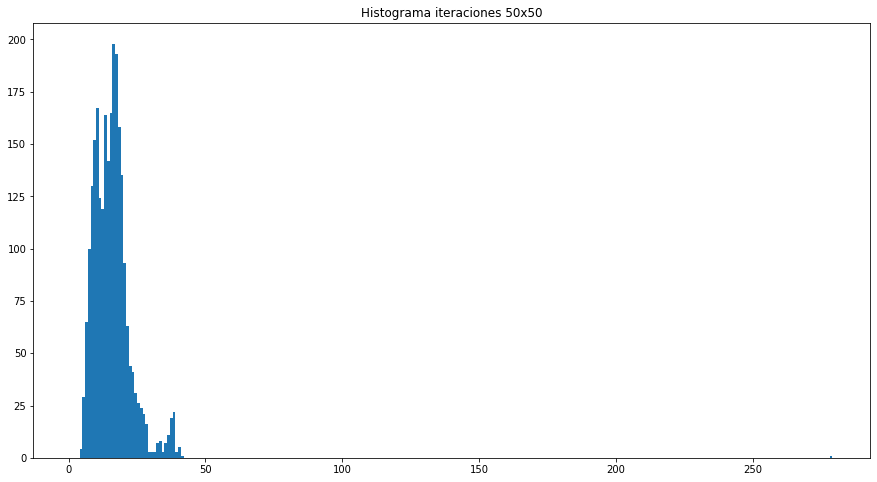

In [45]:
plt.figure(figsize=(15, 8))
IT = ITT_loaded[4]
plt.title("Histograma iteraciones 50x50")

bins = range(1, max(IT[-1]) + 2)
plt.hist(IT[-1], bins=bins)
plt.show()

In [19]:
# with open("ITT_graphs.pkl", "wb") as file:
#     pickle.dump(ITT, file)

In [5]:
ITT_loaded = None
with open("ITT_graphs.pkl", "rb") as file:
    ITT_loaded = pickle.load(file)

In [13]:
mean = []
maxx = []

bad_mean = []
bad_maxx = []
bad_mean_90 = []
bad_maxx_90 = []

for IT in ITT_loaded:
    it = IT[0]
    
    mean.append(sum(it) / len(it))
    maxx.append(sorted(it)[-1])
    
    bad_it = IT[-1]
    bad_it_90 = sorted(bad_it)[:int(len(bad_it) * 0.9)]
    
    bad_mean.append(sum(bad_it) / len(bad_it))
    bad_mean_90.append(sum(bad_it_90) / len(bad_it_90))
    
    bad_maxx.append(sorted(bad_it)[-1])
    bad_maxx_90.append(sorted(bad_it_90)[-1])

print(mean)
print()
print(bad_mean)
print(bad_mean_90)
print()
print(maxx)
print()
print(bad_maxx)
print(bad_maxx_90)


[3.65, 3.9675, 4.435555555555555, 5.23375, 6.3244]

[5.16, 8.3275, 10.816666666666666, 12.97875, 15.3508]
[4.822222222222222, 7.786111111111111, 9.664197530864197, 11.46875, 13.706666666666667]

[4, 5, 6, 7, 9]

[9, 50, 112, 154, 278]
[8, 12, 18, 20, 23]


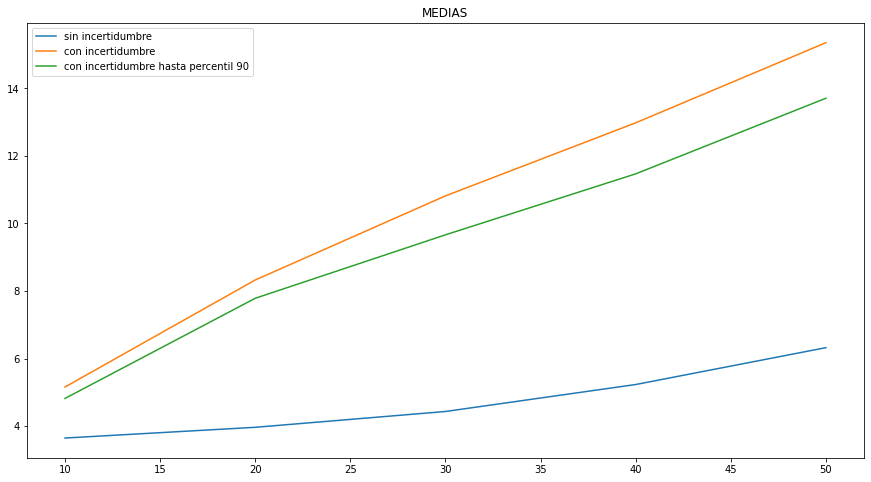

In [34]:
x = [10, 20, 30, 40, 50]

plt.figure(figsize=(15, 8))
plt.plot(x, mean, label="sin incertidumbre")
plt.plot(x, bad_mean, label="con incertidumbre")
plt.plot(x, bad_mean_90, label="con incertidumbre hasta percentil 90")
plt.title("MEDIA ITERACIONES")
plt.legend()
plt.show()

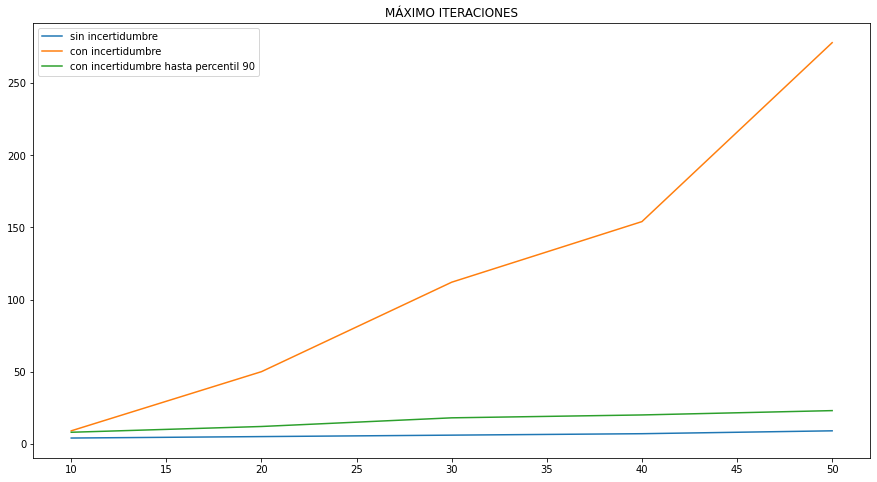

In [35]:
plt.figure(figsize=(15, 8))
plt.plot(x, maxx, label="sin incertidumbre")
plt.plot(x, bad_maxx, label="con incertidumbre")
plt.plot(x, bad_maxx_90, label="con incertidumbre hasta percentil 90")
plt.title("MÁXIMO ITERACIONES")
plt.legend()
plt.show()

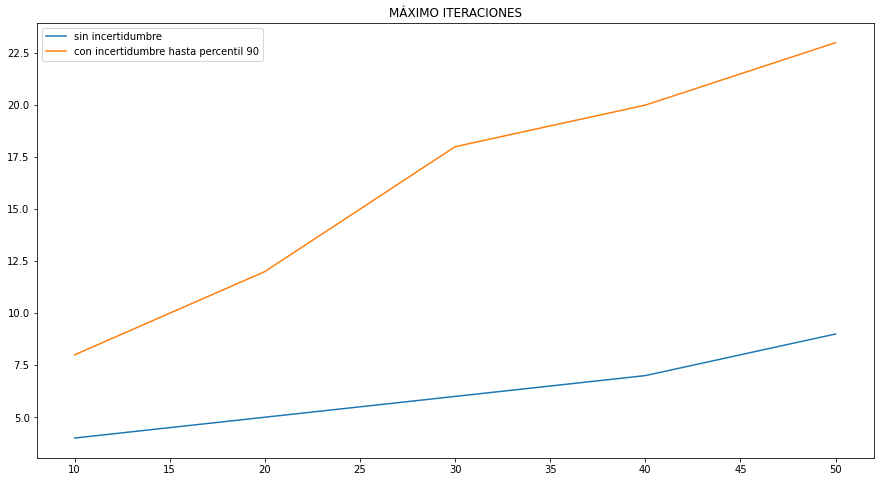

In [36]:
plt.figure(figsize=(15, 8))
plt.plot(x, maxx, label="sin incertidumbre")
plt.plot(x, bad_maxx_90, label="con incertidumbre hasta percentil 90")
plt.title("MÁXIMO ITERACIONES")
plt.legend()
plt.show()

In [ ]:
IT_4000 = []

for p in [0, 0.5, 1]:
    n = 64; m = 64
    N = n * m
    K = 5

    G = obtain_random_tree(n, m)
    G = generate_grid_graph(G, n, m, p)

    W = [1000000 for i in range(N)]
    iters, _ = simulate_robust_randtree(G, 0, W, K, G.nodes(), 0, True, True, False, {})
    
    IT_4000.append(iters.copy())

[1] Result 64: 12    acc: 12.0                             
[2] Result 0: 12    acc: 12.0                              
[3] Result 1: 12    acc: 12.0                              
[4] Result 128: 12    acc: 12.0                            
[5] Result 65: 12    acc: 12.0                             
[6] Result 192: 12    acc: 12.0                            
[7] Result 129: 12    acc: 12.0                            
[8] Result 193: 12    acc: 12.0                            
[9] Result 130: 12    acc: 12.0                            
[10] Result 256: 12    acc: 12.0                           
[11] Result 257: 12    acc: 12.0                           
[12] Result 194: 12    acc: 12.0                           
[13] Result 321: 12    acc: 12.0                           
[14] Result 258: 12    acc: 12.0                           
[15] Result 195: 12    acc: 12.0                           
[16] Result 385: 12    acc: 12.0                           
[17] Result 322: 11    acc: 11.941176470

[137] Result 837: 11    acc: 11.525547445255475            
[138] Result 585: 12    acc: 11.528985507246377            
[139] Result 522: 12    acc: 11.532374100719425            
[140] Result 648: 12    acc: 11.535714285714286            
[141] Result 395: 8    acc: 11.51063829787234              
[142] Result 267: 8    acc: 11.485915492957746             
[143] Result 332: 8    acc: 11.461538461538462             
[144] Result 586: 12    acc: 11.465277777777779            
[145] Result 458: 12    acc: 11.46896551724138             
[146] Result 523: 12    acc: 11.472602739726028            
[147] Result 459: 12    acc: 11.476190476190476            
[148] Result 75: 12    acc: 11.47972972972973              
[149] Result 140: 12    acc: 11.483221476510067            
[150] Result 839: 11    acc: 11.48                         
[151] Result 776: 11    acc: 11.47682119205298             
[152] Result 650: 12    acc: 11.480263157894736            
[153] Result 587: 12    acc: 11.48366013

[273] Result 402: 8    acc: 11.260073260073261             
[274] Result 1162: 11    acc: 11.25912408759124            
[275] Result 1099: 11    acc: 11.258181818181818           
[276] Result 1224: 11    acc: 11.257246376811594           
[277] Result 1161: 11    acc: 11.256317689530686           
[278] Result 1225: 11    acc: 11.255395683453237           
[279] Result 144: 12    acc: 11.258064516129032            
[280] Result 1027: 11    acc: 11.257142857142858           
[281] Result 209: 12    acc: 11.259786476868328            
[282] Result 654: 12    acc: 11.26241134751773             
[283] Result 16: 12    acc: 11.265017667844523             
[284] Result 274: 8    acc: 11.253521126760564             
[285] Result 716: 12    acc: 11.256140350877192            
[286] Result 718: 12    acc: 11.258741258741258            
[287] Result 655: 12    acc: 11.261324041811847            
[288] Result 653: 12    acc: 11.26388888888889             
[289] Result 338: 8    acc: 11.252595155

[409] Result 1218: 12    acc: 11.061124694376527           
[410] Result 1282: 12    acc: 11.06341463414634            
[411] Result 1100: 11    acc: 11.063260340632603           
[412] Result 1037: 11    acc: 11.063106796116505           
[413] Result 914: 12    acc: 11.065375302663439            
[414] Result 851: 12    acc: 11.067632850241546            
[415] Result 1284: 11    acc: 11.067469879518072           
[416] Result 532: 8    acc: 11.060096153846153             
[417] Result 469: 8    acc: 11.052757793764988             
[418] Result 1481: 8    acc: 11.045454545454545            
[419] Result 1346: 12    acc: 11.047732696897375           
[420] Result 1283: 11    acc: 11.047619047619047           
[421] Result 278: 8    acc: 11.040380047505938             
[422] Result 150: 8    acc: 11.033175355450236             
[423] Result 215: 8    acc: 11.026004728132389             
[424] Result 723: 12    acc: 11.028301886792454            
[425] Result 788: 12    acc: 11.03058823

[545] Result 538: 8    acc: 10.777981651376146             
[546] Result 978: 12    acc: 10.780219780219781            
[547] Result 1041: 12    acc: 10.782449725776965           
[548] Result 1548: 8    acc: 10.777372262773723            
[549] Result 1488: 11    acc: 10.777777777777779           
[550] Result 1425: 11    acc: 10.778181818181817           
[551] Result 662: 12    acc: 10.780399274047188            
[552] Result 663: 5    acc: 10.769927536231885             
[553] Result 600: 5    acc: 10.759493670886076             
[554] Result 283: 7    acc: 10.752707581227437             
[555] Result 348: 7    acc: 10.745945945945946             
[556] Result 88: 8    acc: 10.741007194244604              
[557] Result 153: 8    acc: 10.73608617594255              
[558] Result 1672: 8    acc: 10.731182795698924            
[559] Result 1607: 8    acc: 10.726296958855098            
[560] Result 1296: 11    acc: 10.726785714285715           
[561] Result 1361: 11    acc: 10.7272727

[681] Result 1109: 12    acc: 10.509544787077827           
[682] Result 1174: 12    acc: 10.511730205278592           
[683] Result 1045: 12    acc: 10.513909224011712           
[684] Result 1110: 12    acc: 10.51608187134503            
[685] Result 1802: 8    acc: 10.512408759124087            
[686] Result 1739: 8    acc: 10.508746355685131            
[687] Result 1554: 11    acc: 10.509461426491994           
[688] Result 1740: 8    acc: 10.505813953488373            
[689] Result 1615: 11    acc: 10.506531204644412           
[690] Result 1552: 11    acc: 10.507246376811594           
[691] Result 1301: 12    acc: 10.509406657018813           
[692] Result 1238: 12    acc: 10.511560693641618           
[693] Result 1302: 12    acc: 10.513708513708513           
[694] Result 1925: 10    acc: 10.512968299711815           
[695] Result 1860: 10    acc: 10.512230215827339           
[696] Result 666: 5    acc: 10.504310344827585             
[697] Result 855: 12    acc: 10.50645624

[819] Result 986: 5    acc: 10.286935286935288             
[820] Result 923: 5    acc: 10.28048780487805              
[821] Result 607: 7    acc: 10.276492082825822             
[822] Result 544: 7    acc: 10.27250608272506              
[823] Result 2119: 10    acc: 10.272174969623329           
[824] Result 1994: 10    acc: 10.271844660194175           
[825] Result 1931: 10    acc: 10.271515151515151           
[826] Result 2049: 11    acc: 10.272397094430993           
[827] Result 1557: 9    acc: 10.270858524788391            
[828] Result 1494: 9    acc: 10.269323671497585            
[829] Result 1682: 11    acc: 10.270205066344994           
[830] Result 1617: 11    acc: 10.271084337349398           
[831] Result 1430: 11    acc: 10.271961492178098           
[832] Result 160: 7    acc: 10.268028846153847             
[833] Result 1368: 12    acc: 10.270108043217286           
[834] Result 1305: 12    acc: 10.272182254196643           
[835] Result 1303: 12    acc: 10.2742514

[957] Result 1995: 10    acc: 10.1619644723093             
[958] Result 1937: 11    acc: 10.162839248434238           
[959] Result 1874: 11    acc: 10.16371220020855            
[960] Result 226: 7    acc: 10.160416666666666             
[961] Result 735: 7    acc: 10.157127991675338             
[962] Result 1496: 9    acc: 10.155925155925155            
[963] Result 480: 7    acc: 10.152647975077882             
[964] Result 34: 7    acc: 10.149377593360995              
[965] Result 1751: 11    acc: 10.150259067357513           
[966] Result 1623: 11    acc: 10.151138716356108           
[967] Result 1688: 11    acc: 10.152016546018615           
[968] Result 2126: 8    acc: 10.149793388429751            
[969] Result 2063: 8    acc: 10.147574819401445            
[970] Result 545: 7    acc: 10.144329896907216             
[971] Result 863: 5    acc: 10.13903192584964              
[972] Result 800: 5    acc: 10.133744855967079             
[973] Result 2001: 11    acc: 10.1346351

[1093] Result 2007: 11    acc: 10.057639524245197          
[1094] Result 1944: 11    acc: 10.058500914076783          
[1095] Result 1942: 11    acc: 10.059360730593607          
[1096] Result 2508: 8    acc: 10.057481751824817           
[1097] Result 2380: 8    acc: 10.055606198723792           
[1098] Result 2445: 8    acc: 10.053734061930783           
[1099] Result 2006: 11    acc: 10.05459508644222           
[1100] Result 2190: 8    acc: 10.052727272727273           
[1101] Result 2005: 11    acc: 10.053587647593098          
[1102] Result 2572: 8    acc: 10.051724137931034           
[1103] Result 2509: 8    acc: 10.049864007252946           
[1104] Result 2697: 10    acc: 10.04981884057971           
[1105] Result 2634: 10    acc: 10.049773755656108          
[1106] Result 988: 5    acc: 10.045207956600361            
[1107] Result 2499: 10    acc: 10.04516711833785           
[1108] Result 2434: 10    acc: 10.045126353790614          
[1109] Result 291: 7    acc: 10.04238052

[1231] Result 549: 7    acc: 9.92770105605199              
[1232] Result 2129: 8    acc: 9.926136363636363            
[1233] Result 2066: 8    acc: 9.924574209245742            
[1234] Result 1882: 11    acc: 9.92544570502431            
[1235] Result 2255: 8    acc: 9.923886639676113            
[1236] Result 676: 7    acc: 9.921521035598705             
[1237] Result 613: 7    acc: 9.919159256265157             
[1238] Result 804: 7    acc: 9.916801292407108             
[1239] Result 485: 7    acc: 9.914447134786117             
[1240] Result 550: 7    acc: 9.912096774193548             
[1241] Result 1628: 12    acc: 9.913779210314262           
[1242] Result 1565: 12    acc: 9.915458937198068           
[1243] Result 2824: 10    acc: 9.91552695092518            
[1244] Result 2761: 10    acc: 9.915594855305466           
[1245] Result 2447: 8    acc: 9.914056224899598            
[1246] Result 2384: 8    acc: 9.912520064205458            
[1247] Result 993: 5    acc: 9.908580593

[1370] Result 933: 5    acc: 9.805839416058394             
[1371] Result 997: 5    acc: 9.802334062727935             
[1372] Result 869: 5    acc: 9.798833819241983             
[1373] Result 934: 5    acc: 9.795338674435543             
[1374] Result 2327: 11    acc: 9.796215429403203           
[1375] Result 2264: 10    acc: 9.796363636363637           
[1376] Result 2262: 11    acc: 9.797238372093023           
[1377] Result 1694: 9    acc: 9.796659404502542            
[1378] Result 1187: 12    acc: 9.798258345428156           
[1379] Result 1506: 10    acc: 9.798404641044234           
[1380] Result 1443: 10    acc: 9.798550724637682           
[1381] Result 2201: 11    acc: 9.799420709630702           
[1382] Result 2948: 9    acc: 9.798842257597684            
[1383] Result 2883: 9    acc: 9.79826464208243             
[1384] Result 2067: 8    acc: 9.796965317919074            
[1385] Result 2560: 10    acc: 9.797111913357401           
[1386] Result 488: 7    acc: 9.795093795

[1507] Result 3020: 6    acc: 9.694094226940942            
[1508] Result 2260: 11    acc: 9.694960212201591           
[1509] Result 2954: 10    acc: 9.695162359178264           
[1510] Result 2456: 11    acc: 9.696026490066226           
[1511] Result 2772: 7    acc: 9.69424222369292             
[1512] Result 2709: 7    acc: 9.692460317460318            
[1513] Result 805: 7    acc: 9.690680766688699             
[1514] Result 1125: 5    acc: 9.687582562747687            
[1515] Result 1062: 5    acc: 9.684488448844885            
[1516] Result 1060: 5    acc: 9.681398416886543            
[1517] Result 3021: 6    acc: 9.67897165458141             
[1518] Result 2958: 6    acc: 9.676548089591568            
[1519] Result 3085: 6    acc: 9.67412771560237             
[1520] Result 3022: 6    acc: 9.67171052631579             
[1521] Result 999: 5    acc: 9.668639053254438             
[1522] Result 2830: 6    acc: 9.66622864651774             
[1523] Result 2140: 11    acc: 9.6671043

[1644] Result 806: 7    acc: 9.584549878345499             
[1645] Result 2581: 8    acc: 9.583586626139818            
[1646] Result 2518: 8    acc: 9.582624544349938            
[1647] Result 681: 7    acc: 9.581056466302368             
[1648] Result 618: 7    acc: 9.579490291262136             
[1649] Result 172: 4    acc: 9.576106731352334             
[1650] Result 237: 4    acc: 9.572727272727272             
[1651] Result 1508: 10    acc: 9.572986069049062           
[1652] Result 2646: 6    acc: 9.570823244552058            
[1653] Result 2711: 7    acc: 9.569267997580157            
[1654] Result 3087: 6    acc: 9.567110036275695            
[1655] Result 365: 7    acc: 9.565558912386708             
[1656] Result 302: 6    acc: 9.56340579710145              
[1657] Result 3019: 6    acc: 9.561255280627641            
[1658] Result 492: 7    acc: 9.559710494571773             
[1659] Result 429: 7    acc: 9.558167570825798             
[1660] Result 2753: 9    acc: 9.55783132

[1781] Result 3342: 6    acc: 9.441886580572712            
[1782] Result 3279: 6    acc: 9.439955106621774            
[1783] Result 3273: 6    acc: 9.438025799214806            
[1784] Result 3208: 6    acc: 9.43609865470852             
[1785] Result 3337: 6    acc: 9.434173669467787            
[1786] Result 3272: 6    acc: 9.432250839865622            
[1787] Result 43: 7    acc: 9.430889759373251              
[1788] Result 2899: 6    acc: 9.42897091722595             
[1789] Result 3074: 9    acc: 9.42873113471213             
[1790] Result 620: 7    acc: 9.427374301675977             
[1791] Result 557: 7    acc: 9.426018983807928             
[1792] Result 555: 7    acc: 9.424665178571429             
[1793] Result 1953: 9    acc: 9.424428332403792            
[1794] Result 1890: 9    acc: 9.424191750278707            
[1795] Result 1888: 9    acc: 9.423955431754875            
[1796] Result 303: 7    acc: 9.42260579064588              
[1797] Result 430: 7    acc: 9.421257651

[1917] Result 1578: 10    acc: 9.306207616066771           
[1918] Result 1448: 12    acc: 9.307612095933264           
[1919] Result 239: 7    acc: 9.306409588327254             
[1920] Result 304: 7    acc: 9.305208333333333             
[1921] Result 2964: 6    acc: 9.30348776678813             
[1922] Result 1827: 9    acc: 9.303329864724246            
[1923] Result 1892: 9    acc: 9.303172126885075            
[1924] Result 624: 7    acc: 9.301975051975052             
[1925] Result 689: 7    acc: 9.300779220779221             
[1926] Result 368: 7    acc: 9.299584631360332             
[1927] Result 305: 7    acc: 9.298391281785158             
[1928] Result 242: 4    acc: 9.29564315352697              
[1929] Result 179: 4    acc: 9.292897874546398             
[1930] Result 2713: 7    acc: 9.291709844559586            
[1931] Result 2650: 7    acc: 9.290523045054377            
[1932] Result 938: 7    acc: 9.289337474120083             
[1933] Result 1768: 10    acc: 9.2897051

[2053] Result 3401: 6    acc: 9.207501217730151            
[2054] Result 3402: 6    acc: 9.205939629990263            
[2055] Result 3466: 6    acc: 9.204379562043796            
[2056] Result 3403: 6    acc: 9.202821011673151            
[2057] Result 1835: 9    acc: 9.202722411278561            
[2058] Result 3400: 6    acc: 9.201166180758017            
[2059] Result 3335: 6    acc: 9.199611461874696            
[2060] Result 3468: 6    acc: 9.198058252427185            
[2061] Result 3395: 5    acc: 9.196021348859777            
[2062] Result 3330: 5    acc: 9.193986420950534            
[2063] Result 3533: 6    acc: 9.192438196800776            
[2064] Result 3394: 5    acc: 9.190406976744185            
[2065] Result 3329: 5    acc: 9.188377723970945            
[2066] Result 1962: 9    acc: 9.188286544046466            
[2067] Result 1899: 8    acc: 9.187711659409773            
[2068] Result 1003: 7    acc: 9.186653771760154            
[2069] Result 940: 7    acc: 9.185596906

[2189] Result 1452: 10    acc: 9.088168113293742           
[2190] Result 561: 7    acc: 9.087214611872145             
[2191] Result 1131: 12    acc: 9.08854404381561            
[2192] Result 1196: 12    acc: 9.089872262773723           
[2193] Result 3035: 6    acc: 9.088463292293662            
[2194] Result 2972: 6    acc: 9.087055606198724            
[2195] Result 3525: 5    acc: 9.085193621867882            
[2196] Result 1389: 10    acc: 9.085610200364298           
[2197] Result 1454: 10    acc: 9.086026399635868           
[2198] Result 2334: 11    acc: 9.086897179253867           
[2199] Result 2270: 11    acc: 9.087767166894043           
[2200] Result 3539: 4    acc: 9.085454545454546            
[2201] Result 3476: 4    acc: 9.08314402544298             
[2202] Result 3474: 4    acc: 9.080835603996366            
[2203] Result 3413: 4    acc: 9.078529278256923            
[2204] Result 3350: 4    acc: 9.07622504537205             
[2205] Result 1900: 10    acc: 9.0766439

[2328] Result 2847: 7    acc: 8.96606529209622             
[2329] Result 3604: 4    acc: 8.963933018462859            
[2330] Result 3541: 4    acc: 8.961802575107296            
[2331] Result 3653: 5    acc: 8.96010296010296             
[2332] Result 2652: 11    acc: 8.960977701543738           
[2333] Result 2589: 11    acc: 8.961851693099014           
[2334] Result 2464: 11    acc: 8.962724935732648           
[2335] Result 2399: 11    acc: 8.963597430406852           
[2336] Result 2653: 7    acc: 8.962756849315069            
[2337] Result 2718: 7    acc: 8.961916987590929            
[2338] Result 2465: 9    acc: 8.961933276304533            
[2339] Result 2402: 10    acc: 8.962377084224027           
[2340] Result 820: 7    acc: 8.961538461538462             
[2341] Result 757: 7    acc: 8.96070055531824              
[2342] Result 1132: 7    acc: 8.959863364645601            
[2343] Result 3665: 4    acc: 8.95774647887324             
[2344] Result 3600: 4    acc: 8.95563139

[2466] Result 3289: 6    acc: 8.83617193836172             
[2467] Result 3655: 6    acc: 8.835022294284556            
[2468] Result 2973: 6    acc: 8.83387358184765             
[2469] Result 3038: 6    acc: 8.832725799918995            
[2470] Result 1520: 8    acc: 8.832388663967611            
[2471] Result 1457: 8    acc: 8.832051800890328            
[2472] Result 3843: 5    acc: 8.830501618122977            
[2473] Result 3780: 5    acc: 8.82895268904165             
[2474] Result 2467: 10    acc: 8.829426030719482           
[2475] Result 2404: 10    acc: 8.82989898989899            
[2476] Result 2719: 7    acc: 8.829159935379645            
[2477] Result 2975: 7    acc: 8.828421477593864            
[2478] Result 2912: 7    acc: 8.82768361581921             
[2479] Result 2342: 9    acc: 8.827753126260589            
[2480] Result 2277: 9    acc: 8.827822580645162            
[2481] Result 3733: 4    acc: 8.825876662636034            
[2482] Result 3670: 4    acc: 8.82393231

[2602] Result 2597: 10    acc: 8.731360491929285           
[2603] Result 2534: 10    acc: 8.731847867844795           
[2604] Result 3671: 4    acc: 8.730030721966205            
[2605] Result 3231: 6    acc: 8.728982725527832            
[2606] Result 3168: 6    acc: 8.727935533384498            
[2607] Result 3599: 6    acc: 8.726889144610663            
[2608] Result 630: 5    acc: 8.725460122699387             
[2609] Result 3972: 5    acc: 8.72403219624377             
[2610] Result 3907: 5    acc: 8.722605363984675            
[2611] Result 695: 5    acc: 8.72117962466488              
[2612] Result 1201: 8    acc: 8.720903522205207            
[2613] Result 3914: 6    acc: 8.719862227324914            
[2614] Result 3851: 6    acc: 8.718821729150728            
[2615] Result 3663: 4    acc: 8.717017208413003            
[2616] Result 2594: 10    acc: 8.71750764525994            
[2617] Result 2661: 10    acc: 8.717997707298434           
[2618] Result 2598: 10    acc: 8.7184873

[2738] Result 3977: 6    acc: 8.62308254200146             
[2739] Result 3423: 5    acc: 8.62175976633808             
[2740] Result 3360: 5    acc: 8.620437956204379            
[2741] Result 311: 4    acc: 8.618752280189712             
[2742] Result 3904: 5    acc: 8.61743253099927             
[2743] Result 4038: 5    acc: 8.616113744075829            
[2744] Result 631: 5    acc: 8.614795918367347             
[2745] Result 568: 5    acc: 8.613479052823315             
[2746] Result 376: 5    acc: 8.612163146394757             
[2747] Result 3926: 4    acc: 8.610484164543138            
[2748] Result 3863: 4    acc: 8.608806404657933            
[2749] Result 2729: 10    acc: 8.60931247726446            
[2750] Result 2601: 10    acc: 8.609818181818182           
[2751] Result 2666: 10    acc: 8.610323518720465           
[2752] Result 1396: 8    acc: 8.610101744186046            
[2753] Result 313: 4    acc: 8.608427170359608             
[2754] Result 2730: 10    acc: 8.6089324

[2874] Result 2348: 9    acc: 8.545233124565065            
[2875] Result 2285: 9    acc: 8.545391304347826            
[2876] Result 1139: 8    acc: 8.545201668984701            
[2877] Result 2475: 9    acc: 8.545359749739312            
[2878] Result 2412: 9    acc: 8.545517720639333            
[2879] Result 126: 4    acc: 8.543938867662384             
[2880] Result 63: 4    acc: 8.542361111111111              
[2881] Result 2917: 10    acc: 8.542867060048595           
[2882] Result 1526: 8    acc: 8.542678695350451            
[2883] Result 2788: 10    acc: 8.543184183142559           
[2884] Result 2289: 9    acc: 8.543342579750346            
[2885] Result 2161: 9    acc: 8.543500866551126            
[2886] Result 2226: 9    acc: 8.543659043659044            
[2887] Result 2157: 9    acc: 8.543817111188085            
[2888] Result 3855: 4    acc: 8.54224376731302             
[2889] Result 1334: 8    acc: 8.542056074766355            
[2890] Result 3917: 6    acc: 8.54117647

[3010] Result 4048: 4    acc: 8.448172757475083            
[3011] Result 3985: 4    acc: 8.446695450016605            
[3012] Result 2732: 10    acc: 8.447211155378486           
[3013] Result 2669: 10    acc: 8.447726518420179           
[3014] Result 1140: 7    acc: 8.447246184472462            
[3015] Result 1077: 7    acc: 8.446766169154229            
[3016] Result 4055: 4    acc: 8.445291777188329            
[3017] Result 3990: 4    acc: 8.443818362611866            
[3018] Result 3612: 4    acc: 8.44234592445328             
[3019] Result 3677: 4    acc: 8.440874461742299            
[3020] Result 3173: 6    acc: 8.440066225165562            
[3021] Result 3921: 4    acc: 8.43859649122807             
[3022] Result 2796: 10    acc: 8.439113170086035           
[3023] Result 2733: 10    acc: 8.43962950711214            
[3024] Result 3978: 6    acc: 8.438822751322752            
[3025] Result 2034: 10    acc: 8.439338842975207           
[3026] Result 951: 7    acc: 8.438863185

[3147] Result 1655: 8    acc: 8.3829043533524              
[3148] Result 380: 4    acc: 8.38151207115629              
[3149] Result 1717: 8    acc: 8.381390917751666            
[3150] Result 825: 7    acc: 8.380952380952381             
[3151] Result 762: 7    acc: 8.380514122500793             
[3152] Result 1718: 8    acc: 8.380393401015228            
[3153] Result 1013: 7    acc: 8.379955597843324            
[3154] Result 1656: 8    acc: 8.379835129993658            
[3155] Result 1593: 8    acc: 8.379714738510302            
[3156] Result 1907: 8    acc: 8.37959442332066             
[3157] Result 3742: 4    acc: 8.378207158694963            
[3158] Result 3679: 4    acc: 8.376820772640912            
[3159] Result 699: 5    acc: 8.375751820196264             
[3160] Result 571: 5    acc: 8.374683544303798             
[3161] Result 636: 5    acc: 8.373615944321417             
[3162] Result 381: 4    acc: 8.372232764073372             
[3163] Result 3239: 10    acc: 8.3727473

[3284] Result 1467: 8    acc: 8.307247259439707            
[3285] Result 3178: 6    acc: 8.306544901065449            
[3286] Result 3050: 6    acc: 8.305842970176506            
[3287] Result 3115: 6    acc: 8.30514146638272             
[3288] Result 3241: 10    acc: 8.305656934306569           
[3289] Result 3871: 4    acc: 8.304347826086957            
[3290] Result 3808: 4    acc: 8.303039513677811            
[3291] Result 894: 5    acc: 8.302035855363112             
[3292] Result 831: 5    acc: 8.301032806804374             
[3293] Result 829: 5    acc: 8.300030367446098             
[3294] Result 3242: 6    acc: 8.29933211900425             
[3295] Result 3179: 6    acc: 8.298634294385433            
[3296] Result 827: 5    acc: 8.29763349514563              
[3297] Result 3492: 5    acc: 8.29663330300273             
[3298] Result 3364: 5    acc: 8.295633717404488            
[3299] Result 3429: 5    acc: 8.294634737799333            
[3300] Result 2610: 4    acc: 8.29333333

[3421] Result 2357: 9    acc: 8.231511254019292            
[3422] Result 2294: 9    acc: 8.231735827001753            
[3423] Result 2483: 4    acc: 8.230499561787905            
[3424] Result 3810: 5    acc: 8.229556074766355            
[3425] Result 3747: 5    acc: 8.228613138686132            
[3426] Result 3180: 6    acc: 8.227962638645652            
[3427] Result 3245: 6    acc: 8.227312518237525            
[3428] Result 1913: 9    acc: 8.227537922987164            
[3429] Result 2549: 4    acc: 8.226305045202682            
[3430] Result 2614: 4    acc: 8.225072886297376            
[3431] Result 2234: 8    acc: 8.225007286505392            
[3432] Result 2171: 9    acc: 8.2252331002331              
[3433] Result 2169: 8    acc: 8.225167491989513            
[3434] Result 2421: 9    acc: 8.225393127548049            
[3435] Result 2358: 9    acc: 8.22561863173217             
[3436] Result 1848: 8    acc: 8.225552968568103            
[3437] Result 3936: 4    acc: 8.22432353

[3559] Result 1087: 5    acc: 8.153132902500703            
[3560] Result 3564: 6    acc: 8.15252808988764             
[3561] Result 1151: 8    acc: 8.152485256950294            
[3562] Result 2360: 9    acc: 8.15272318921954             
[3563] Result 2232: 9    acc: 8.152960987931518            
[3564] Result 2297: 9    acc: 8.153198653198654            
[3565] Result 3440: 6    acc: 8.152594670406732            
[3566] Result 3184: 6    acc: 8.151991026360067            
[3567] Result 1083: 8    acc: 8.151948416035884            
[3568] Result 1343: 8    acc: 8.151905829596412            
[3569] Result 2679: 4    acc: 8.150742504903334            
[3570] Result 1723: 8    acc: 8.150700280112044            
[3571] Result 4065: 4    acc: 8.149537944553346            
[3572] Result 4002: 4    acc: 8.148376259798432            
[3573] Result 3122: 4    acc: 8.147215225300867            
[3574] Result 3059: 4    acc: 8.146054840514829            
[3575] Result 2551: 4    acc: 8.14489510

[3695] Result 3623: 10    acc: 8.09255751014885            
[3696] Result 2236: 8    acc: 8.092532467532468            
[3697] Result 2554: 4    acc: 8.091425480119016            
[3698] Result 2491: 9    acc: 8.091671173607356            
[3699] Result 3689: 10    acc: 8.092187077588537           
[3700] Result 3626: 10    acc: 8.092702702702702           
[3701] Result 3752: 10    acc: 8.0932180491759             
[3702] Result 2555: 4    acc: 8.092112371690979            
[3703] Result 3381: 6    acc: 8.091547394004861            
[3704] Result 3253: 6    acc: 8.09098272138229             
[3705] Result 3318: 6    acc: 8.090418353576249            
[3706] Result 2936: 4    acc: 8.089314624932541            
[3707] Result 2873: 4    acc: 8.088211491772322            
[3708] Result 1599: 8    acc: 8.088187702265373            
[3709] Result 3563: 6    acc: 8.087624696683742            
[3710] Result 2619: 4    acc: 8.086522911051214            
[3711] Result 2556: 4    acc: 8.08542171

[3833] Result 3447: 6    acc: 8.029480824419515            
[3834] Result 3384: 6    acc: 8.028951486697965            
[3835] Result 2684: 4    acc: 8.027900912646675            
[3836] Result 2621: 4    acc: 8.026850886339938            
[3837] Result 3702: 6    acc: 8.026322647902006            
[3838] Result 3639: 5    acc: 8.025534132360605            
[3839] Result 3635: 6    acc: 8.02500651211253             
[3840] Result 3761: 6    acc: 8.024479166666667            
[3841] Result 2747: 4    acc: 8.023431398073418            
[3842] Result 3131: 4    acc: 8.022384174908902            
[3843] Result 3068: 4    acc: 8.021337496747332            
[3844] Result 3066: 4    acc: 8.020291363163372            
[3845] Result 3888: 6    acc: 8.019765929778934            
[3846] Result 3825: 6    acc: 8.019240769630786            
[3847] Result 3065: 4    acc: 8.018195996880687            
[3848] Result 3632: 6    acc: 8.017671517671518            
[3849] Result 3064: 4    acc: 8.01662769

[3969] Result 3263: 4    acc: 7.934744268077601            
[3970] Result 3322: 6    acc: 7.934256926952141            
[3971] Result 2815: 4    acc: 7.933266179803576            
[3972] Result 2687: 4    acc: 7.932275931520644            
[3973] Result 3953: 6    acc: 7.931789579662723            
[3974] Result 3258: 4    acc: 7.9308002013085055           
[3975] Result 3450: 5    acc: 7.930062893081761            
[3976] Result 3952: 6    acc: 7.929577464788732            
[3977] Result 3642: 5    acc: 7.9288408348001              
[3978] Result 3579: 5    acc: 7.928104575163399            
[3979] Result 4017: 6    acc: 7.927620005026388            
[3980] Result 3954: 6    acc: 7.92713567839196             
[3981] Result 3197: 4    acc: 7.926149208741522            
[3982] Result 2431: 4    acc: 7.9251632345555              
[3983] Result 2751: 4    acc: 7.924177755460708            
[3984] Result 3327: 4    acc: 7.923192771084337            
[3985] Result 3262: 4    acc: 7.92220828

[9] Result 3: 18    acc: 25.333333333333332                
[10] Result 67: 18    acc: 24.6                            
[11] Result 4: 18    acc: 24.0                             
[12] Result 193: 16    acc: 23.333333333333332             
[13] Result 130: 17    acc: 22.846153846153847             
[14] Result 194: 17    acc: 22.428571428571427             
[15] Result 131: 17    acc: 22.066666666666666             
[16] Result 195: 17    acc: 21.75                          
[17] Result 132: 14    acc: 21.294117647058822             
[18] Result 258: 17    acc: 21.055555555555557             
[19] Result 259: 17    acc: 20.842105263157894             
[20] Result 196: 17    acc: 20.65                          
[21] Result 192: 23    acc: 20.761904761904763             
[22] Result 68: 18    acc: 20.636363636363637              
[23] Result 256: 22    acc: 20.695652173913043             
[24] Result 257: 16    acc: 20.5                           
[25] Result 321: 16    acc: 20.32       

[145] Result 773: 14    acc: 16.089655172413792            
[146] Result 458: 16    acc: 16.089041095890412            
[147] Result 395: 16    acc: 16.08843537414966             
[148] Result 522: 13    acc: 16.06756756756757             
[149] Result 459: 15    acc: 16.06040268456376             
[150] Result 584: 12    acc: 16.033333333333335            
[151] Result 521: 12    acc: 16.00662251655629             
[152] Result 961: 11    acc: 15.973684210526315            
[153] Result 837: 13    acc: 15.954248366013072            
[154] Result 774: 14    acc: 15.941558441558442            
[155] Result 586: 14    acc: 15.929032258064517            
[156] Result 523: 13    acc: 15.91025641025641             
[157] Result 899: 12    acc: 15.885350318471337            
[158] Result 587: 14    acc: 15.873417721518987            
[159] Result 524: 13    acc: 15.855345911949685            
[160] Result 838: 13    acc: 15.8375                       
[161] Result 710: 14    acc: 15.82608695

[281] Result 1222: 16    acc: 14.804270462633452           
[282] Result 337: 14    acc: 14.801418439716311            
[283] Result 274: 15    acc: 14.802120141342757            
[284] Result 528: 14    acc: 14.799295774647888            
[285] Result 465: 13    acc: 14.79298245614035             
[286] Result 591: 14    acc: 14.79020979020979             
[287] Result 1346: 13    acc: 14.78397212543554            
[288] Result 1218: 13    acc: 14.777777777777779           
[289] Result 1283: 13    acc: 14.771626297577855           
[290] Result 1161: 14    acc: 14.76896551724138            
[291] Result 1098: 14    acc: 14.766323024054984           
[292] Result 716: 14    acc: 14.763698630136986            
[293] Result 653: 14    acc: 14.761092150170649            
[294] Result 1162: 15    acc: 14.761904761904763           
[295] Result 1099: 14    acc: 14.759322033898306           
[296] Result 592: 13    acc: 14.753378378378379            
[297] Result 529: 14    acc: 14.75084175

[417] Result 975: 12    acc: 14.419664268585132            
[418] Result 1536: 12    acc: 14.413875598086124           
[419] Result 848: 13    acc: 14.410501193317423            
[420] Result 912: 13    acc: 14.407142857142857            
[421] Result 405: 13    acc: 14.403800475059382            
[422] Result 342: 14    acc: 14.402843601895734            
[423] Result 724: 15    acc: 14.404255319148936            
[424] Result 661: 15    acc: 14.40566037735849             
[425] Result 533: 16    acc: 14.409411764705883            
[426] Result 1230: 14    acc: 14.408450704225352           
[427] Result 1479: 12    acc: 14.402810304449648           
[428] Result 1416: 16    acc: 14.406542056074766           
[429] Result 1539: 14    acc: 14.405594405594405           
[430] Result 721: 13    acc: 14.402325581395349            
[431] Result 1478: 13    acc: 14.399071925754061           
[432] Result 849: 13    acc: 14.395833333333334            
[433] Result 149: 13    acc: 14.39260969

[554] Result 1425: 12    acc: 14.070397111913357           
[555] Result 471: 16    acc: 14.073873873873874            
[556] Result 536: 16    acc: 14.077338129496402            
[557] Result 917: 13    acc: 14.0754039497307              
[558] Result 982: 13    acc: 14.07347670250896             
[559] Result 472: 16    acc: 14.076923076923077            
[560] Result 151: 14    acc: 14.076785714285714            
[561] Result 216: 14    acc: 14.076648841354723            
[562] Result 1670: 13    acc: 14.07473309608541            
[563] Result 1605: 13    acc: 14.072824156305506           
[564] Result 1549: 8    acc: 14.062056737588652            
[565] Result 1600: 12    acc: 14.058407079646019           
[566] Result 86: 14    acc: 14.058303886925795             
[567] Result 1860: 12    acc: 14.054673721340388           
[568] Result 1797: 12    acc: 14.05105633802817            
[569] Result 853: 13    acc: 14.04920913884007             
[570] Result 918: 14    acc: 14.04912280

[690] Result 983: 14    acc: 13.80144927536232             
[691] Result 920: 13    acc: 13.800289435600579            
[692] Result 23: 14    acc: 13.800578034682081             
[693] Result 409: 14    acc: 13.8008658008658              
[694] Result 346: 14    acc: 13.801152737752162            
[695] Result 791: 13    acc: 13.8                          
[696] Result 856: 13    acc: 13.798850574712644            
[697] Result 1805: 12    acc: 13.796269727403157           
[698] Result 792: 14    acc: 13.796561604584527            
[699] Result 857: 13    acc: 13.795422031473533            
[700] Result 1617: 11    acc: 13.791428571428572           
[701] Result 410: 14    acc: 13.79172610556348             
[702] Result 282: 14    acc: 13.792022792022792            
[703] Result 347: 12    acc: 13.789473684210526            
[704] Result 2118: 12    acc: 13.786931818181818           
[705] Result 2055: 12    acc: 13.784397163120568           
[706] Result 1867: 14    acc: 13.7847025

[828] Result 730: 13    acc: 13.553140096618357            
[829] Result 667: 13    acc: 13.552472858866103            
[830] Result 1931: 14    acc: 13.553012048192771           
[831] Result 2058: 14    acc: 13.553549939831528           
[832] Result 1995: 13    acc: 13.552884615384615           
[833] Result 1114: 12    acc: 13.551020408163266           
[834] Result 1179: 12    acc: 13.549160671462829           
[835] Result 2369: 12    acc: 13.547305389221556           
[836] Result 2304: 12    acc: 13.545454545454545           
[837] Result 1996: 13    acc: 13.544802867383513           
[838] Result 2433: 12    acc: 13.542959427207638           
[839] Result 2368: 12    acc: 13.541120381406436           
[840] Result 2244: 12    acc: 13.539285714285715           
[841] Result 2181: 12    acc: 13.537455410225922           
[842] Result 606: 12    acc: 13.535629453681711            
[843] Result 543: 15    acc: 13.537366548042705            
[844] Result 415: 14    acc: 13.53791469

[964] Result 1374: 12    acc: 13.37863070539419            
[965] Result 1311: 11    acc: 13.376165803108808           
[966] Result 2060: 11    acc: 13.373706004140788           
[967] Result 1749: 12    acc: 13.372285418821097           
[968] Result 1686: 12    acc: 13.37086776859504            
[969] Result 1623: 12    acc: 13.369453044375645           
[970] Result 2191: 13    acc: 13.369072164948454           
[971] Result 2126: 13    acc: 13.368692070030896           
[972] Result 609: 13    acc: 13.368312757201647            
[973] Result 546: 14    acc: 13.36896197327852             
[974] Result 610: 13    acc: 13.368583162217659            
[975] Result 482: 13    acc: 13.368205128205128            
[976] Result 547: 14    acc: 13.368852459016393            
[977] Result 2439: 14    acc: 13.369498464687819           
[978] Result 2376: 14    acc: 13.370143149284253           
[979] Result 735: 15    acc: 13.371807967313586            
[980] Result 672: 15    acc: 13.37346938

[1101] Result 2003: 11    acc: 13.168937329700272          
[1102] Result 1940: 12    acc: 13.167876588021779          
[1103] Result 355: 14    acc: 13.168631006346327           
[1104] Result 420: 15    acc: 13.170289855072463           
[1105] Result 2379: 13    acc: 13.170135746606334          
[1106] Result 2316: 12    acc: 13.169077757685352          
[1107] Result 2629: 14    acc: 13.169828364950316          
[1108] Result 2564: 14    acc: 13.17057761732852           
[1109] Result 2881: 6    acc: 13.164111812443643           
[1110] Result 2818: 6    acc: 13.157657657657658           
[1111] Result 95: 14    acc: 13.158415841584159            
[1112] Result 160: 14    acc: 13.159172661870503           
[1113] Result 226: 13    acc: 13.159029649595688           
[1114] Result 291: 13    acc: 13.158886894075405           
[1115] Result 677: 13    acc: 13.158744394618834           
[1116] Result 549: 13    acc: 13.158602150537634           
[1117] Result 614: 13    acc: 13.1584601

[1238] Result 1819: 11    acc: 12.887722132471728          
[1239] Result 3074: 6    acc: 12.882163034705407           
[1240] Result 163: 11    acc: 12.880645161290323           
[1241] Result 228: 11    acc: 12.879129734085415           
[1242] Result 2692: 6    acc: 12.873590982286634           
[1243] Result 99: 11    acc: 12.872083668543846            
[1244] Result 164: 11    acc: 12.870578778135048           
[1245] Result 162: 13    acc: 12.870682730923695           
[1246] Result 2631: 14    acc: 12.87158908507223           
[1247] Result 2695: 14    acc: 12.872493985565358          
[1248] Result 1119: 12    acc: 12.871794871794872          
[1249] Result 1184: 11    acc: 12.870296236989592          
[1250] Result 990: 15    acc: 12.872                       
[1251] Result 927: 15    acc: 12.873701039168665           
[1252] Result 864: 15    acc: 12.875399361022364           
[1253] Result 1054: 12    acc: 12.874700718276138          
[1254] Result 2757: 5    acc: 12.8684210

[1374] Result 998: 12    acc: 12.654294032023289           
[1375] Result 229: 11    acc: 12.65309090909091            


In [13]:
G = obtain_random_tree(30, 30)
G = generate_grid_graph(G, 30, 30, 1)

In [14]:
sizes = []
sizes_robust = []

V = [0 for i in range(900)]
W = [1000000 for i in range(900)]

for u in G.nodes():
    sizes.append(get_size_weight(G, W, V, u)[0])
    sizes_robust.append(get_size_weight_robust(G, W, V, 0, u)[0])

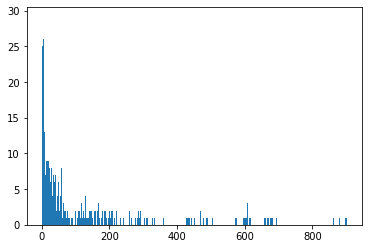

In [17]:
import matplotlib.pyplot as plt

bins = range(1, max(sizes) + 2)
plt.hist(sizes, bins=bins)
plt.show()

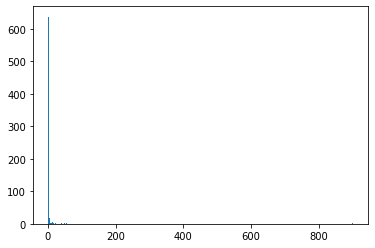

In [18]:
bins = range(1, max(sizes_robust) + 2)
plt.hist(sizes_robust, bins=bins)
plt.show()

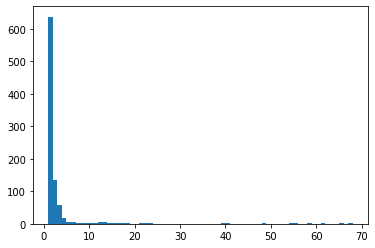

In [24]:
sizes_robust_no_root = sizes_robust[:1].copy() + sizes_robust[2:].copy()

bins = range(1, max(sizes_robust_no_root) + 2)
plt.hist(sizes_robust_no_root, bins=bins)
plt.show()

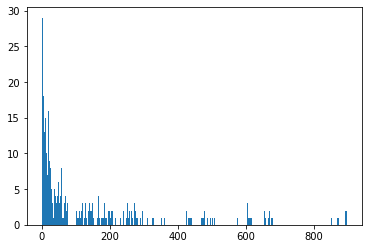

In [25]:
sizes_diffs = [sizes[i] - sizes_robust[i] for i in range(900)]

bins = range(1, max(sizes_diffs) + 2)
plt.hist(sizes_diffs, bins=bins)
plt.show()

In [40]:
T = obtain_random_tree(20, 20)
G = generate_grid_graph(T, 20, 20, 1)

In [41]:
str_graph = [[' ' for i in range(100)] for j in range(60)]

for i in range(20):
    for j in range(20):
        
        u = i * 20 + j
        
        str_graph[3 * i][5 * j] = 'o'
        if j < 19:
            if (u, u + 1) in G.edges():
                str_graph[3 * i][5 * j + 2] = '-'
                str_graph[3 * i][5 * j + 3] = '>'
            else:
                str_graph[3 * i][5 * j + 2] = '<'
                str_graph[3 * i][5 * j + 3] = '-'
        if i < 19:
            if (u, u + 20) in G.edges():
                str_graph[3 * i + 1][5 * j] = '|'
                str_graph[3 * i + 2][5 * j] = 'v'
            else:
                str_graph[3 * i + 1][5 * j] = '^'
                str_graph[3 * i + 2][5 * j] = '|'

In [42]:
for line in str_graph:
    print(''.join(line))

o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o -> o -> o <- o <- o <- o    
^    ^    ^    |    |    |    |    |    ^    |    ^    ^    ^    ^    |    |    |    ^    ^    |    
|    |    |    v    v    v    v    v    |    v    |    |    |    |    v    v    v    |    |    v    
o -> o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o -> o <- o <- o <- o <- o <- o    
^    ^    ^    |    ^    |    |    ^    ^    ^    |    |    |    |    |    |    |    |    |    ^    
|    |    |    v    |    v    v    |    |    |    v    v    v    v    v    v    v    v    v    |    
o -> o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o -> o <- o -> o <- o <- o <- o    
^    ^    ^    ^    |    ^    ^    ^    ^    |    |    |    |    |    |    |    |    |    |    ^    
|    |    |    |    v    |    |    |    |    v    v    v    v    v    v    v    v    v    v    |    
o -> o -> o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o

In [43]:
G = obtain_random_tree(20, 20)

In [44]:
str_graph = [[' ' for i in range(100)] for j in range(60)]

for i in range(20):
    for j in range(20):
        
        u = i * 20 + j
        
        str_graph[3 * i][5 * j] = 'o'
        if j < 19:
            if (u, u + 1) in G.edges():
                str_graph[3 * i][5 * j + 2] = '-'
                str_graph[3 * i][5 * j + 3] = '>'
            if (u + 1, u) in G.edges():
                str_graph[3 * i][5 * j + 2] = '<'
                str_graph[3 * i][5 * j + 3] = '-'
        if i < 19:
            if (u, u + 20) in G.edges():
                str_graph[3 * i + 1][5 * j] = '|'
                str_graph[3 * i + 2][5 * j] = 'v'
            if (u + 20, u) in G.edges():
                str_graph[3 * i + 1][5 * j] = '^'
                str_graph[3 * i + 2][5 * j] = '|'

In [45]:
for line in str_graph:
    print(''.join(line))

o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o <- o    o    o    o <- o    o    
^    ^                                            ^                        |    |    |         |    
|    |                                            |                        v    v    v         v    
o    o <- o <- o <- o <- o    o <- o <- o <- o    o <- o <- o    o <- o <- o    o -> o <- o    o    
     ^                        |              ^    ^              |                   |         |    
     |                        v              |    |              v                   v         v    
o -> o <- o <- o <- o <- o <- o <- o <- o    o    o <- o    o <- o <- o <- o    o    o <- o <- o    
^    ^         ^                   ^              ^         |                   |    |              
|    |         |                   |              |         v                   v    v              
o    o <- o    o <- o <- o <- o    o <- o <- o    o <- o <- o <- o <- o <- o    o    o <- o

In [16]:
G = obtain_center_random_tree(10, 10)

In [17]:
str_graph = [[' ' for i in range(120)] for j in range(63)]

for i in range(21):
    for j in range(21):
        
        u = i * 21 + j
        
        str_graph[3 * i][5 * j] = 'o'
        if j < 20:
            if (u, u + 1) in G.edges():
                str_graph[3 * i][5 * j + 2] = '-'
                str_graph[3 * i][5 * j + 3] = '>'
            if (u + 1, u) in G.edges():
                str_graph[3 * i][5 * j + 2] = '<'
                str_graph[3 * i][5 * j + 3] = '-'
        if i < 20:
            if (u, u + 21) in G.edges():
                str_graph[3 * i + 1][5 * j] = '|'
                str_graph[3 * i + 2][5 * j] = 'v'
            if (u + 21, u) in G.edges():
                str_graph[3 * i + 1][5 * j] = '^'
                str_graph[3 * i + 2][5 * j] = '|'

In [18]:
for line in str_graph:
    print(''.join(line))

o    o <- o    o -> o    o    o -> o <- o    o    o -> o    o    o    o    o <- o <- o    o    o    o                   
|    |              |    |         |         |         |    |    |    |    |              |    |    |                   
v    v              v    v         v         v         v    v    v    v    v              v    v    v                   
o    o <- o    o    o    o    o    o <- o    o    o -> o    o -> o    o    o    o    o    o <- o <- o                   
|    |         |    |    |    |    |         |         |         |    |    |    |    |    |                             
v    v         v    v    v    v    v         v         v         v    v    v    v    v    v                             
o -> o <- o    o    o    o    o    o    o    o    o -> o <- o    o -> o    o <- o <- o <- o <- o <- o                   
     |         |    |    |    |    |    |    |         |              |    |                                            
     v         v    v    v    v 

In [28]:

ITT = []
IT = []

for p in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    n = 11; m = 11
    N = n * m
    K = 5

    T = obtain_center_random_tree(n // 2, m // 2)
    G = generate_grid_graph(T, n, m, p)

    W = [1000000 for i in range(N)]
    iters, _ = simulate_robust_randtree(G, (n // 2) * n + (m // 2), W, K, G.nodes(), 0, True, True, False, {})
    
    IT.append(iters.copy())
    
ITT.append(IT.copy())

[1] Result 71: 4    acc: 4.0                               
[2] Result 60: 3    acc: 3.5                               
[3] Result 49: 4    acc: 3.6666666666666665                
[4] Result 61: 3    acc: 3.5                               
[5] Result 59: 3    acc: 3.4                               
[6] Result 82: 4    acc: 3.5                               
[7] Result 72: 3    acc: 3.4285714285714284                
[8] Result 70: 3    acc: 3.375                             
[9] Result 81: 3    acc: 3.3333333333333335                
[10] Result 69: 3    acc: 3.3                              
[11] Result 93: 3    acc: 3.272727272727273                
[12] Result 83: 4    acc: 3.3333333333333335               
[13] Result 38: 4    acc: 3.3846153846153846               
[14] Result 50: 2    acc: 3.2857142857142856               
[15] Result 48: 4    acc: 3.3333333333333335               
[16] Result 94: 4    acc: 3.375                            
[17] Result 84: 4    acc: 3.411764705882

[90] Result 55: 4    acc: 3.588888888888889
[91] Result 98: 4    acc: 3.5934065934065935
[92] Result 6: 4    acc: 3.597826086956522
[93] Result 4: 3    acc: 3.5913978494623655
[94] Result 52: 3    acc: 3.5851063829787235
[95] Result 30: 4    acc: 3.5894736842105264
[96] Result 42: 4    acc: 3.59375
[97] Result 2: 4    acc: 3.597938144329897
[98] Result 12: 3    acc: 3.5918367346938775
[99] Result 109: 4    acc: 3.595959595959596
[100] Result 3: 3    acc: 3.59
[101] Result 1: 4    acc: 3.594059405940594
[102] Result 110: 3    acc: 3.588235294117647
[103] Result 18: 3    acc: 3.5825242718446604
[104] Result 7: 3    acc: 3.576923076923077
[105] Result 99: 4    acc: 3.580952380952381
[106] Result 65: 4    acc: 3.5849056603773586
[107] Result 53: 4    acc: 3.588785046728972
[108] Result 54: 4    acc: 3.5925925925925926
[109] Result 0: 3    acc: 3.5871559633027523
[110] Result 31: 4    acc: 3.590909090909091
[111] Result 43: 4    acc: 3.5945945945945947
[112] Result 11: 3    acc: 3.589285714

[29] Result 85: 4    acc: 3.689655172413793
[30] Result 62: 3    acc: 3.6666666666666665
[31] Result 74: 4    acc: 3.6774193548387095
[32] Result 106: 4    acc: 3.6875
[33] Result 96: 4    acc: 3.696969696969697
[34] Result 68: 4    acc: 3.7058823529411766
[35] Result 115: 4    acc: 3.7142857142857144
[36] Result 113: 4    acc: 3.7222222222222223
[37] Result 105: 3    acc: 3.7027027027027026
[38] Result 79: 4    acc: 3.710526315789474
[39] Result 116: 4    acc: 3.717948717948718
[40] Result 117: 4    acc: 3.725
[41] Result 107: 4    acc: 3.731707317073171
[42] Result 57: 3    acc: 3.7142857142857144
[43] Result 67: 4    acc: 3.7209302325581395
[44] Result 101: 4    acc: 3.727272727272727
[45] Result 89: 4    acc: 3.7333333333333334
[46] Result 46: 3    acc: 3.717391304347826
[47] Result 56: 3    acc: 3.702127659574468
[48] Result 118: 3    acc: 3.6875
[49] Result 108: 4    acc: 3.693877551020408
[50] Result 47: 3    acc: 3.68
[51] Result 86: 4    acc: 3.6862745098039214
[52] Result 36:

[115] Result 9: 5    acc: 3.747826086956522
[116] Result 3: 3    acc: 3.7413793103448274
[117] Result 10: 5    acc: 3.752136752136752
[118] Result 11: 4    acc: 3.7542372881355934
[119] Result 2: 4    acc: 3.7563025210084033
[120] Result 1: 3    acc: 3.75
[121] Result 0: 4    acc: 3.7520661157024793
3.7520661157024793 5 



[1] Result 71: 4    acc: 4.0
[2] Result 60: 3    acc: 3.5
[3] Result 49: 4    acc: 3.6666666666666665
[4] Result 61: 4    acc: 3.75
[5] Result 59: 3    acc: 3.6
[6] Result 82: 4    acc: 3.6666666666666665
[7] Result 72: 3    acc: 3.5714285714285716
[8] Result 70: 2    acc: 3.375
[9] Result 50: 4    acc: 3.4444444444444446
[10] Result 62: 4    acc: 3.5
[11] Result 38: 4    acc: 3.5454545454545454
[12] Result 48: 4    acc: 3.5833333333333335
[13] Result 37: 4    acc: 3.6153846153846154
[14] Result 47: 4    acc: 3.642857142857143
[15] Result 27: 3    acc: 3.6
[16] Result 39: 3    acc: 3.5625
[17] Result 26: 5    acc: 3.6470588235294117
[18] Result 36: 4    acc: 3.66666

[48] Result 65: 4    acc: 3.7708333333333335
[49] Result 105: 4    acc: 3.7755102040816326
[50] Result 95: 4    acc: 3.78
[51] Result 116: 4    acc: 3.784313725490196
[52] Result 106: 4    acc: 3.7884615384615383
[53] Result 115: 3    acc: 3.7735849056603774
[54] Result 117: 4    acc: 3.7777777777777777
[55] Result 35: 4    acc: 3.7818181818181817
[56] Result 5: 4    acc: 3.7857142857142856
[57] Result 3: 5    acc: 3.807017543859649
[58] Result 24: 4    acc: 3.810344827586207
[59] Result 86: 4    acc: 3.8135593220338984
[60] Result 76: 5    acc: 3.8333333333333335
[61] Result 17: 3    acc: 3.819672131147541
[62] Result 6: 4    acc: 3.8225806451612905
[63] Result 54: 4    acc: 3.8253968253968256
[64] Result 46: 5    acc: 3.84375
[65] Result 34: 4    acc: 3.8461538461538463
[66] Result 90: 4    acc: 3.8484848484848486
[67] Result 118: 4    acc: 3.8507462686567164
[68] Result 85: 4    acc: 3.8529411764705883
[69] Result 57: 5    acc: 3.869565217391304
[70] Result 45: 4    acc: 3.871428571

[1] Result 71: 5    acc: 5.0
[2] Result 60: 6    acc: 5.5
[3] Result 49: 5    acc: 5.333333333333333
[4] Result 61: 6    acc: 5.5
[5] Result 59: 4    acc: 5.2
[6] Result 72: 6    acc: 5.333333333333333
[7] Result 50: 6    acc: 5.428571428571429
[8] Result 62: 6    acc: 5.5
[9] Result 82: 5    acc: 5.444444444444445
[10] Result 70: 5    acc: 5.4
[11] Result 83: 5    acc: 5.363636363636363
[12] Result 73: 6    acc: 5.416666666666667
[13] Result 81: 5    acc: 5.384615384615385
[14] Result 69: 5    acc: 5.357142857142857
[15] Result 51: 6    acc: 5.4
[16] Result 63: 4    acc: 5.3125
[17] Result 40: 6    acc: 5.352941176470588
[18] Result 52: 5    acc: 5.333333333333333
[19] Result 80: 5    acc: 5.315789473684211
[20] Result 58: 4    acc: 5.25
[21] Result 68: 5    acc: 5.238095238095238
[22] Result 94: 5    acc: 5.2272727272727275


[23] Result 84: 5    acc: 5.217391304347826
[24] Result 41: 5    acc: 5.208333333333333
[25] Result 53: 5    acc: 5.2
[26] Result 64: 5    acc: 5.1923076923076925
[27] Result 42: 5    acc: 5.185185185185185
[28] Result 54: 5    acc: 5.178571428571429
[29] Result 74: 6    acc: 5.206896551724138
[30] Result 92: 5    acc: 5.2
[31] Result 65: 5    acc: 5.193548387096774
[32] Result 43: 5    acc: 5.1875
[33] Result 105: 5    acc: 5.181818181818182
[34] Result 95: 5    acc: 5.176470588235294
[35] Result 93: 4    acc: 5.142857142857143
[36] Result 103: 5    acc: 5.138888888888889
[37] Result 91: 5    acc: 5.135135135135135
[38] Result 106: 4    acc: 5.105263157894737
[39] Result 96: 5    acc: 5.102564102564102
[40] Result 75: 5    acc: 5.1
[41] Result 104: 4    acc: 5.073170731707317
[42] Result 31: 5    acc: 5.071428571428571
[43] Result 76: 5    acc: 5.069767441860465
[44] Result 115: 4    acc: 5.045454545454546
[45] Result 29: 6    acc: 5.066666666666666
[46] Result 39: 6    acc: 5.0869565

[77] Result 46: 4    acc: 4.896103896103896
[78] Result 56: 3    acc: 4.871794871794871
[79] Result 35: 3    acc: 4.848101265822785
[80] Result 45: 3    acc: 4.825
[81] Result 55: 3    acc: 4.802469135802469
[82] Result 111: 5    acc: 4.804878048780488
[83] Result 36: 4    acc: 4.795180722891566
[84] Result 119: 2    acc: 4.761904761904762
[85] Result 109: 2    acc: 4.729411764705882
[86] Result 8: 6    acc: 4.744186046511628
[87] Result 18: 5    acc: 4.747126436781609
[88] Result 25: 4    acc: 4.738636363636363
[89] Result 24: 3    acc: 4.719101123595506
[90] Result 34: 4    acc: 4.711111111111111
[91] Result 110: 5    acc: 4.714285714285714
[92] Result 78: 5    acc: 4.717391304347826
[93] Result 99: 4    acc: 4.709677419354839
[94] Result 23: 4    acc: 4.702127659574468
[95] Result 33: 4    acc: 4.6947368421052635
[96] Result 17: 5    acc: 4.697916666666667
[97] Result 27: 6    acc: 4.711340206185567
[98] Result 6: 4    acc: 4.704081632653061
[99] Result 16: 4    acc: 4.6969696969696

[4] Result 61: 6    acc: 5.5
[5] Result 59: 5    acc: 5.4
[6] Result 70: 5    acc: 5.333333333333333
[7] Result 48: 5    acc: 5.285714285714286
[8] Result 58: 5    acc: 5.25
[9] Result 82: 5    acc: 5.222222222222222
[10] Result 72: 5    acc: 5.2
[11] Result 37: 6    acc: 5.2727272727272725
[12] Result 47: 5    acc: 5.25
[13] Result 81: 5    acc: 5.230769230769231
[14] Result 69: 3    acc: 5.071428571428571
[15] Result 92: 5    acc: 5.066666666666666
[16] Result 80: 4    acc: 5.0
[17] Result 103: 5    acc: 5.0
[18] Result 93: 4    acc: 4.944444444444445
[19] Result 91: 5    acc: 4.947368421052632
[20] Result 104: 3    acc: 4.85
[21] Result 94: 4    acc: 4.809523809523809
[22] Result 79: 4    acc: 4.7727272727272725
[23] Result 36: 6    acc: 4.826086956521739
[24] Result 46: 5    acc: 4.833333333333333
[25] Result 38: 5    acc: 4.84
[26] Result 50: 5    acc: 4.846153846153846
[27] Result 26: 6    acc: 4.888888888888889


[28] Result 102: 5    acc: 4.892857142857143
[29] Result 90: 5    acc: 4.896551724137931
[30] Result 62: 6    acc: 4.933333333333334
[31] Result 39: 5    acc: 4.935483870967742
[32] Result 51: 4    acc: 4.90625
[33] Result 28: 5    acc: 4.909090909090909
[34] Result 40: 4    acc: 4.882352941176471
[35] Result 83: 4    acc: 4.857142857142857
[36] Result 25: 4    acc: 4.833333333333333
[37] Result 35: 6    acc: 4.864864864864865
[38] Result 24: 5    acc: 4.868421052631579
[39] Result 34: 6    acc: 4.897435897435898
[40] Result 105: 4    acc: 4.875
[41] Result 95: 3    acc: 4.829268292682927
[42] Result 68: 3    acc: 4.785714285714286
[43] Result 57: 4    acc: 4.767441860465116
[44] Result 67: 2    acc: 4.704545454545454
[45] Result 84: 4    acc: 4.688888888888889
[46] Result 56: 3    acc: 4.6521739130434785
[47] Result 29: 4    acc: 4.638297872340425
[48] Result 41: 4    acc: 4.625
[49] Result 13: 6    acc: 4.653061224489796
[50] Result 23: 5    acc: 4.66
[51] Result 14: 5    acc: 4.6666

[98] Result 77: 4    acc: 4.479591836734694                
[99] Result 64: 4    acc: 4.474747474747475                
[100] Result 53: 3    acc: 4.46                            
[101] Result 31: 4    acc: 4.455445544554456               
[102] Result 43: 4    acc: 4.450980392156863               
[103] Result 119: 3    acc: 4.436893203883495              
[104] Result 109: 2    acc: 4.413461538461538              
[105] Result 87: 3    acc: 4.4                             
[106] Result 20: 4    acc: 4.39622641509434                
[107] Result 32: 4    acc: 4.392523364485982               
[108] Result 5: 5    acc: 4.398148148148148                
[109] Result 54: 3    acc: 4.385321100917431               
[110] Result 17: 4    acc: 4.381818181818182               
[111] Result 120: 3    acc: 4.36936936936937               
[112] Result 18: 4    acc: 4.366071428571429               
[113] Result 7: 4    acc: 4.3628318584070795               
[114] Result 19: 4    acc: 4.35964912280

[118] Result 8: 4    acc: 4.466101694915254                
[119] Result 9: 5    acc: 4.470588235294118                
[120] Result 21: 5    acc: 4.475                           
[121] Result 10: 4    acc: 4.471074380165289               
4.471074380165289 5 



[1] Result 71: 4    acc: 4.0                               
[2] Result 60: 7    acc: 5.5                               
[3] Result 49: 6    acc: 5.666666666666667                 
[4] Result 61: 4    acc: 5.25                              
[5] Result 59: 4    acc: 5.0                               
[6] Result 38: 6    acc: 5.166666666666667                 
[7] Result 50: 4    acc: 5.0                               
[8] Result 48: 4    acc: 4.875                             
[9] Result 70: 6    acc: 5.0                               
[10] Result 58: 6    acc: 5.1                              
[11] Result 37: 4    acc: 5.0                              
[12] Result 47: 3    acc: 4.833333333333333                
[13] Result 82: 

[14] Result 81: 6    acc: 4.857142857142857
[15] Result 62: 5    acc: 4.866666666666666
[16] Result 58: 4    acc: 4.8125
[17] Result 39: 5    acc: 4.823529411764706
[18] Result 51: 5    acc: 4.833333333333333
[19] Result 92: 5    acc: 4.842105263157895
[20] Result 80: 5    acc: 4.85
[21] Result 103: 4    acc: 4.809523809523809
[22] Result 91: 5    acc: 4.818181818181818
[23] Result 73: 4    acc: 4.782608695652174
[24] Result 104: 6    acc: 4.833333333333333
[25] Result 94: 6    acc: 4.88
[26] Result 114: 4    acc: 4.846153846153846
[27] Result 102: 4    acc: 4.814814814814815
[28] Result 69: 5    acc: 4.821428571428571
[29] Result 40: 5    acc: 4.827586206896552
[30] Result 52: 5    acc: 4.833333333333333
[31] Result 79: 5    acc: 4.838709677419355
[32] Result 47: 2    acc: 4.75
[33] Result 57: 4    acc: 4.7272727272727275
[34] Result 68: 4    acc: 4.705882352941177
[35] Result 46: 4    acc: 4.685714285714286
[36] Result 56: 4    acc: 4.666666666666667
[37] Result 29: 5    acc: 4.67567

[60] Result 53: 5    acc: 4.633333333333334
[61] Result 64: 5    acc: 4.639344262295082
[62] Result 54: 5    acc: 4.645161290322581
[63] Result 25: 3    acc: 4.619047619047619
[64] Result 35: 3    acc: 4.59375
[65] Result 111: 3    acc: 4.569230769230769
[66] Result 89: 6    acc: 4.590909090909091
[67] Result 99: 4    acc: 4.582089552238806
[68] Result 65: 5    acc: 4.588235294117647
[69] Result 43: 5    acc: 4.594202898550725
[70] Result 110: 3    acc: 4.571428571428571
[71] Result 88: 4    acc: 4.563380281690141
[72] Result 27: 4    acc: 4.555555555555555
[73] Result 95: 6    acc: 4.575342465753424
[74] Result 85: 6    acc: 4.594594594594595
[75] Result 45: 4    acc: 4.586666666666667
[76] Result 31: 4    acc: 4.578947368421052
[77] Result 117: 6    acc: 4.597402597402597
[78] Result 107: 5    acc: 4.602564102564102
[79] Result 18: 5    acc: 4.6075949367088604
[80] Result 28: 4    acc: 4.6
[81] Result 75: 5    acc: 4.604938271604938
[82] Result 20: 4    acc: 4.597560975609756
[83] Re

[1] Result 71: 4    acc: 4.0                               
[2] Result 60: 8    acc: 6.0                               
[3] Result 49: 3    acc: 5.0                               
[4] Result 61: 7    acc: 5.5                               
[5] Result 59: 4    acc: 5.2                               
[6] Result 72: 5    acc: 5.166666666666667                 
[7] Result 50: 7    acc: 5.428571428571429                 
[8] Result 62: 5    acc: 5.375                             
[9] Result 39: 7    acc: 5.555555555555555                 
[10] Result 51: 7    acc: 5.7                              
[11] Result 82: 4    acc: 5.545454545454546                
[12] Result 70: 5    acc: 5.5                              
[13] Result 28: 8    acc: 5.6923076923076925               
[14] Result 40: 5    acc: 5.642857142857143                
[15] Result 38: 7    acc: 5.733333333333333                
[16] Result 81: 5    acc: 5.6875                           
[17] Result 69: 6    acc: 5.705882352941

[20] Result 82: 7    acc: 5.7
[21] Result 72: 3    acc: 5.571428571428571
[22] Result 70: 7    acc: 5.636363636363637
[23] Result 58: 4    acc: 5.565217391304348
[24] Result 40: 5    acc: 5.541666666666667
[25] Result 36: 5    acc: 5.52
[26] Result 14: 7    acc: 5.576923076923077
[27] Result 24: 3    acc: 5.481481481481482
[28] Result 81: 5    acc: 5.464285714285714
[29] Result 69: 7    acc: 5.517241379310345
[30] Result 93: 6    acc: 5.533333333333333
[31] Result 83: 6    acc: 5.548387096774194
[32] Result 18: 6    acc: 5.5625
[33] Result 30: 6    acc: 5.575757575757576
[34] Result 92: 6    acc: 5.588235294117647
[35] Result 80: 6    acc: 5.6
[36] Result 104: 6    acc: 5.611111111111111
[37] Result 94: 6    acc: 5.621621621621622


[38] Result 103: 5    acc: 5.605263157894737
[39] Result 91: 6    acc: 5.615384615384615
[40] Result 57: 5    acc: 5.6
[41] Result 4: 7    acc: 5.634146341463414
[42] Result 114: 5    acc: 5.619047619047619
[43] Result 102: 7    acc: 5.651162790697675
[44] Result 6: 5    acc: 5.636363636363637
[45] Result 7: 5    acc: 5.622222222222222
[46] Result 5: 4    acc: 5.586956521739131
[47] Result 73: 3    acc: 5.531914893617022
[48] Result 68: 4    acc: 5.5
[49] Result 46: 3    acc: 5.448979591836735
[50] Result 56: 5    acc: 5.44
[51] Result 3: 7    acc: 5.470588235294118
[52] Result 13: 7    acc: 5.5
[53] Result 105: 6    acc: 5.509433962264151
[54] Result 95: 6    acc: 5.518518518518518
[55] Result 62: 4    acc: 5.490909090909091
[56] Result 84: 4    acc: 5.464285714285714
[57] Result 74: 4    acc: 5.43859649122807
[58] Result 8: 5    acc: 5.431034482758621
[59] Result 116: 6    acc: 5.440677966101695
[60] Result 106: 7    acc: 5.466666666666667
[61] Result 115: 5    acc: 5.459016393442623

[71] Result 101: 7    acc: 5.422535211267606
[72] Result 66: 4    acc: 5.402777777777778
[73] Result 44: 4    acc: 5.383561643835616
[74] Result 2: 7    acc: 5.405405405405405
[75] Result 12: 7    acc: 5.426666666666667
[76] Result 117: 6    acc: 5.434210526315789
[77] Result 107: 7    acc: 5.454545454545454
[78] Result 85: 4    acc: 5.435897435897436
[79] Result 118: 7    acc: 5.455696202531645
[80] Result 96: 7    acc: 5.475
[81] Result 108: 7    acc: 5.493827160493828
[82] Result 23: 3    acc: 5.463414634146342
[83] Result 90: 7    acc: 5.481927710843373
[84] Result 100: 7    acc: 5.5
[85] Result 78: 7    acc: 5.517647058823529
[86] Result 42: 6    acc: 5.523255813953488
[87] Result 20: 5    acc: 5.517241379310345
[88] Result 32: 6    acc: 5.5227272727272725
[89] Result 77: 4    acc: 5.50561797752809
[90] Result 119: 6    acc: 5.511111111111111
[91] Result 97: 4    acc: 5.4945054945054945
[92] Result 109: 7    acc: 5.510869565217392
[93] Result 63: 6    acc: 5.516129032258065
[94] R

In [29]:

IT = []

for p in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    n = 21; m = 21
    N = n * m
    K = 5

    T = obtain_center_random_tree(n // 2, m // 2)
    G = generate_grid_graph(T, n, m, p)

    W = [1000000 for i in range(N)]
    iters, _ = simulate_robust_randtree(G, (n // 2) * n + (m // 2), W, K, G.nodes(), 0, True, True, False, {})
    
    IT.append(iters.copy())
    
ITT.append(IT.copy())

[1] Result 241: 4    acc: 4.0                              
[2] Result 220: 3    acc: 3.5                              
[3] Result 199: 3    acc: 3.3333333333333335               
[4] Result 221: 3    acc: 3.25                             
[5] Result 219: 4    acc: 3.4                              
[6] Result 262: 4    acc: 3.5                              
[7] Result 242: 4    acc: 3.5714285714285716               
[8] Result 240: 4    acc: 3.625                            
[9] Result 283: 4    acc: 3.6666666666666665               
[10] Result 263: 4    acc: 3.7                             
[11] Result 261: 4    acc: 3.727272727272727               
[12] Result 178: 3    acc: 3.6666666666666665              
[13] Result 200: 4    acc: 3.6923076923076925              
[14] Result 198: 4    acc: 3.7142857142857144              
[15] Result 218: 4    acc: 3.7333333333333334              
[16] Result 239: 3    acc: 3.6875                          
[17] Result 197: 3    acc: 3.64705882352

[166] Result 182: 4    acc: 3.897590361445783              
[167] Result 204: 4    acc: 3.8982035928143715             
[168] Result 350: 4    acc: 3.8988095238095237             
[169] Result 294: 4    acc: 3.899408284023669              
[170] Result 412: 4    acc: 3.9                            
[171] Result 392: 4    acc: 3.9005847953216373             
[172] Result 225: 4    acc: 3.9011627906976742             
[173] Result 247: 4    acc: 3.901734104046243              
[174] Result 316: 4    acc: 3.9022988505747125             
[175] Result 338: 4    acc: 3.902857142857143              
[176] Result 137: 4    acc: 3.903409090909091              
[177] Result 315: 4    acc: 3.903954802259887              
[178] Result 371: 4    acc: 3.904494382022472              
[179] Result 329: 4    acc: 3.905027932960894              
[180] Result 351: 4    acc: 3.9055555555555554             
[181] Result 308: 3    acc: 3.9005524861878453             
[182] Result 288: 4    acc: 3.9010989010

[323] Result 144: 4    acc: 3.9504643962848296
[324] Result 230: 4    acc: 3.950617283950617
[325] Result 73: 4    acc: 3.9507692307692306
[326] Result 378: 4    acc: 3.950920245398773
[327] Result 333: 4    acc: 3.9510703363914375
[328] Result 355: 4    acc: 3.951219512195122
[329] Result 165: 4    acc: 3.951367781155015
[330] Result 123: 4    acc: 3.9515151515151516
[331] Result 145: 4    acc: 3.9516616314199395
[332] Result 334: 4    acc: 3.9518072289156625
[333] Result 47: 4    acc: 3.951951951951952
[334] Result 67: 4    acc: 3.9520958083832336
[335] Result 166: 4    acc: 3.952238805970149
[336] Result 8: 4    acc: 3.9523809523809526
[337] Result 30: 4    acc: 3.9525222551928785
[338] Result 28: 4    acc: 3.9526627218934913
[339] Result 101: 4    acc: 3.9528023598820057
[340] Result 188: 4    acc: 3.9529411764705884
[341] Result 167: 4    acc: 3.9530791788856305
[342] Result 55: 4    acc: 3.953216374269006
[343] Result 77: 4    acc: 3.9533527696793005
[344] Result 80: 4    acc: 3.

[384] Result 35: 4    acc: 3.9583333333333335
[385] Result 57: 4    acc: 3.9584415584415584
[386] Result 147: 4    acc: 3.9585492227979273
[387] Result 377: 4    acc: 3.958656330749354
[388] Result 120: 4    acc: 3.9587628865979383
[389] Result 99: 4    acc: 3.9588688946015425
[390] Result 31: 4    acc: 3.958974358974359
[391] Result 398: 4    acc: 3.959079283887468
[392] Result 314: 4    acc: 3.9591836734693877
[393] Result 65: 4    acc: 3.959287531806616
[394] Result 85: 4    acc: 3.9593908629441623
[395] Result 440: 4    acc: 3.9594936708860757
[396] Result 105: 4    acc: 3.95959595959596
[397] Result 53: 4    acc: 3.959697732997481
[398] Result 52: 4    acc: 3.959798994974874
[399] Result 64: 4    acc: 3.9598997493734336
[400] Result 84: 4    acc: 3.96
[401] Result 63: 4    acc: 3.960099750623441
[402] Result 60: 4    acc: 3.9601990049751246
[403] Result 14: 4    acc: 3.9602977667493797
[404] Result 36: 4    acc: 3.9603960396039604
[405] Result 34: 4    acc: 3.960493827160494
[406]

[437] Result 19: 4    acc: 3.9633867276887873              
[438] Result 18: 4    acc: 3.963470319634703               
[439] Result 1: 4    acc: 3.9635535307517085               
[440] Result 0: 4    acc: 3.963636363636364                
[441] Result 21: 4    acc: 3.963718820861678               
3.963718820861678 5 



[1] Result 241: 3    acc: 3.0                              
[2] Result 220: 4    acc: 3.5                              
[3] Result 199: 3    acc: 3.3333333333333335               
[4] Result 221: 4    acc: 3.5                              
[5] Result 219: 4    acc: 3.6                              
[6] Result 242: 4    acc: 3.6666666666666665               
[7] Result 200: 4    acc: 3.7142857142857144               
[8] Result 222: 3    acc: 3.625                            
[9] Result 263: 3    acc: 3.5555555555555554               
[10] Result 243: 3    acc: 3.5                             
[11] Result 284: 4    acc: 3.5454545454545454              
[12] Result 264:

[145] Result 232: 4    acc: 4.324137931034483              
[146] Result 91: 4    acc: 4.321917808219178               
[147] Result 111: 4    acc: 4.319727891156463              
[148] Result 129: 5    acc: 4.324324324324325              
[149] Result 151: 5    acc: 4.328859060402684              
[150] Result 149: 4    acc: 4.326666666666667              
[151] Result 70: 4    acc: 4.324503311258278               
[152] Result 90: 4    acc: 4.322368421052632               
[153] Result 297: 5    acc: 4.326797385620915              
[154] Result 277: 4    acc: 4.324675324675325              
[155] Result 205: 4    acc: 4.32258064516129               
[156] Result 227: 4    acc: 4.32051282051282               
[157] Result 131: 5    acc: 4.32484076433121               
[158] Result 139: 4    acc: 4.322784810126582              
[159] Result 161: 4    acc: 4.320754716981132              
[160] Result 117: 4    acc: 4.31875                        
[161] Result 366: 5    acc: 4.3229813664

[318] Result 402: 4    acc: 4.352201257861635
[319] Result 380: 5    acc: 4.35423197492163
[320] Result 43: 4    acc: 4.353125
[321] Result 63: 4    acc: 4.35202492211838
[322] Result 97: 4    acc: 4.350931677018633
[323] Result 31: 4    acc: 4.34984520123839
[324] Result 53: 4    acc: 4.348765432098766
[325] Result 425: 5    acc: 4.350769230769231
[326] Result 403: 5    acc: 4.352760736196319
[327] Result 251: 4    acc: 4.351681957186544
[328] Result 76: 4    acc: 4.350609756097561
[329] Result 98: 4    acc: 4.349544072948328
[330] Result 413: 5    acc: 4.351515151515152
[331] Result 429: 5    acc: 4.353474320241692
[332] Result 272: 4    acc: 4.352409638554217
[333] Result 24: 4    acc: 4.351351351351352
[334] Result 397: 5    acc: 4.3532934131736525
[335] Result 355: 5    acc: 4.3552238805970145
[336] Result 377: 5    acc: 4.357142857142857
[337] Result 165: 4    acc: 4.356083086053412
[338] Result 187: 5    acc: 4.3579881656804735
[339] Result 10: 4    acc: 4.35693215339233
[340] R

[344] Result 423: 4    acc: 4.357558139534884
[345] Result 401: 3    acc: 4.353623188405797
[346] Result 22: 4    acc: 4.3526011560693645
[347] Result 42: 4    acc: 4.351585014409222
[348] Result 418: 5    acc: 4.353448275862069
[349] Result 435: 5    acc: 4.355300859598854
[350] Result 432: 4    acc: 4.354285714285714
[351] Result 412: 4    acc: 4.353276353276353
[352] Result 11: 4    acc: 4.3522727272727275
[353] Result 419: 5    acc: 4.354107648725212
[354] Result 314: 5    acc: 4.3559322033898304
[355] Result 335: 4    acc: 4.354929577464789
[356] Result 208: 3    acc: 4.351123595505618
[357] Result 166: 5    acc: 4.352941176470588
[358] Result 188: 4    acc: 4.351955307262569
[359] Result 209: 4    acc: 4.350974930362117
[360] Result 167: 4    acc: 4.35
[361] Result 437: 5    acc: 4.351800554016621
[362] Result 417: 5    acc: 4.3535911602209945
[363] Result 99: 4    acc: 4.352617079889807
[364] Result 121: 4    acc: 4.351648351648351
[365] Result 122: 4    acc: 4.35068493150685
[3

[390] Result 102: 4    acc: 4.335897435897436
[391] Result 124: 4    acc: 4.335038363171355
[392] Result 434: 4    acc: 4.334183673469388
[393] Result 436: 5    acc: 4.33587786259542
[394] Result 55: 4    acc: 4.33502538071066
[395] Result 75: 4    acc: 4.334177215189873
[396] Result 54: 4    acc: 4.333333333333333
[397] Result 427: 5    acc: 4.335012594458438
[398] Result 334: 5    acc: 4.336683417085427
[399] Result 56: 4    acc: 4.335839598997493
[400] Result 78: 4    acc: 4.335
[401] Result 438: 5    acc: 4.3366583541147135
[402] Result 426: 5    acc: 4.338308457711443
[403] Result 81: 4    acc: 4.337468982630273
[404] Result 103: 4    acc: 4.336633663366337
[405] Result 101: 4    acc: 4.335802469135802
[406] Result 60: 4    acc: 4.334975369458128
[407] Result 82: 4    acc: 4.334152334152334
[408] Result 80: 4    acc: 4.333333333333333
[409] Result 357: 4    acc: 4.332518337408313
[410] Result 34: 4    acc: 4.331707317073171
[411] Result 421: 4    acc: 4.330900243309002
[412] Resul

[419] Result 13: 4    acc: 4.326968973747016
[420] Result 35: 4    acc: 4.326190476190476
[421] Result 125: 4    acc: 4.32541567695962
[422] Result 420: 4    acc: 4.3246445497630335
[423] Result 37: 5    acc: 4.326241134751773
[424] Result 57: 5    acc: 4.327830188679245
[425] Result 146: 5    acc: 4.329411764705882
[426] Result 14: 4    acc: 4.328638497652582
[427] Result 36: 4    acc: 4.327868852459017
[428] Result 61: 5    acc: 4.329439252336448
[429] Result 83: 4    acc: 4.328671328671328
[430] Result 40: 4    acc: 4.3279069767441865
[431] Result 62: 5    acc: 4.3294663573085845
[432] Result 19: 5    acc: 4.331018518518518
[433] Result 41: 4    acc: 4.330254041570439
[434] Result 39: 4    acc: 4.329493087557604
[435] Result 104: 4    acc: 4.328735632183908
[436] Result 18: 5    acc: 4.330275229357798
[437] Result 38: 5    acc: 4.331807780320366
[438] Result 17: 5    acc: 4.333333333333333
[439] Result 20: 5    acc: 4.334851936218679
[440] Result 15: 4    acc: 4.334090909090909
[441

[1] Result 241: 3    acc: 3.0                              
[2] Result 220: 3    acc: 3.0                              
[3] Result 199: 4    acc: 3.3333333333333335               
[4] Result 221: 3    acc: 3.25                             
[5] Result 219: 3    acc: 3.2                              
[6] Result 262: 5    acc: 3.5                              
[7] Result 242: 5    acc: 3.7142857142857144               
[8] Result 240: 3    acc: 3.625                            
[9] Result 263: 4    acc: 3.6666666666666665               
[10] Result 243: 5    acc: 3.8                             
[11] Result 283: 5    acc: 3.909090909090909               
[12] Result 261: 5    acc: 4.0                             
[13] Result 178: 4    acc: 4.0                             
[14] Result 200: 4    acc: 4.0                             
[15] Result 198: 4    acc: 4.0                             
[16] Result 282: 5    acc: 4.0625                          
[17] Result 260: 5    acc: 4.11764705882

[138] Result 365: 5    acc: 4.543478260869565              
[139] Result 343: 5    acc: 4.546762589928058              
[140] Result 133: 4    acc: 4.542857142857143              
[141] Result 298: 5    acc: 4.546099290780142              
[142] Result 278: 4    acc: 4.542253521126761              
[143] Result 276: 4    acc: 4.538461538461538              
[144] Result 205: 4    acc: 4.534722222222222              
[145] Result 227: 5    acc: 4.537931034482758              
[146] Result 74: 4    acc: 4.534246575342466               
[147] Result 96: 4    acc: 4.530612244897959               
[148] Result 370: 4    acc: 4.527027027027027              
[149] Result 350: 4    acc: 4.523489932885906              
[150] Result 212: 4    acc: 4.52                           
[151] Result 233: 5    acc: 4.52317880794702               
[152] Result 311: 5    acc: 4.526315789473684              
[153] Result 291: 5    acc: 4.529411764705882              
[154] Result 371: 4    acc: 4.5259740259

[320] Result 384: 4    acc: 4.459375                       
[321] Result 388: 4    acc: 4.457943925233645              
[322] Result 383: 5    acc: 4.459627329192546              
[323] Result 110: 5    acc: 4.461300309597523              
[324] Result 130: 4    acc: 4.459876543209877              
[325] Result 361: 4    acc: 4.458461538461538              
[326] Result 339: 4    acc: 4.457055214723926              
[327] Result 109: 5    acc: 4.458715596330276              
[328] Result 129: 4    acc: 4.4573170731707314             
[329] Result 168: 4    acc: 4.455927051671733              
[330] Result 294: 5    acc: 4.457575757575758              
[331] Result 271: 5    acc: 4.459214501510574              
[332] Result 102: 4    acc: 4.457831325301205              
[333] Result 251: 5    acc: 4.45945945945946               
[334] Result 58: 4    acc: 4.458083832335329               
[335] Result 411: 4    acc: 4.456716417910448              
[336] Result 389: 4    acc: 4.4553571428

[16] Result 158: 4    acc: 4.125                           
[17] Result 156: 4    acc: 4.117647058823529               
[18] Result 197: 5    acc: 4.166666666666667               
[19] Result 262: 6    acc: 4.2631578947368425              
[20] Result 242: 4    acc: 4.25                            
[21] Result 137: 5    acc: 4.285714285714286               
[22] Result 159: 4    acc: 4.2727272727272725              
[23] Result 222: 4    acc: 4.260869565217392               
[24] Result 115: 5    acc: 4.291666666666667               
[25] Result 135: 5    acc: 4.32                            
[26] Result 239: 3    acc: 4.269230769230769               
[27] Result 217: 3    acc: 4.222222222222222               
[28] Result 155: 5    acc: 4.25                            
[29] Result 180: 4    acc: 4.241379310344827               
[30] Result 283: 6    acc: 4.3                             
[31] Result 263: 5    acc: 4.32258064516129                
[32] Result 261: 4    acc: 4.3125       

[160] Result 329: 7    acc: 4.7625                         
[161] Result 309: 6    acc: 4.770186335403727              
[162] Result 88: 5    acc: 4.771604938271605               
[163] Result 246: 3    acc: 4.7607361963190185             
[164] Result 277: 5    acc: 4.762195121951219              
[165] Result 368: 7    acc: 4.775757575757575              
[166] Result 346: 6    acc: 4.783132530120482              
[167] Result 74: 5    acc: 4.7844311377245505              
[168] Result 54: 5    acc: 4.785714285714286               
[169] Result 76: 5    acc: 4.78698224852071                
[170] Result 150: 5    acc: 4.788235294117647              
[171] Result 170: 5    acc: 4.7894736842105265             
[172] Result 72: 4    acc: 4.784883720930233               
[173] Result 350: 7    acc: 4.797687861271676              
[174] Result 330: 7    acc: 4.810344827586207              
[175] Result 366: 3    acc: 4.8                            
[176] Result 344: 4    acc: 4.7954545454

[302] Result 59: 5    acc: 4.844370860927152               
[303] Result 81: 5    acc: 4.8448844884488445              
[304] Result 184: 4    acc: 4.842105263157895              
[305] Result 14: 5    acc: 4.842622950819672               
[306] Result 290: 5    acc: 4.8431372549019605             
[307] Result 312: 5    acc: 4.843648208469055              
[308] Result 44: 4    acc: 4.840909090909091               
[309] Result 22: 4    acc: 4.8381877022653725              
[310] Result 64: 5    acc: 4.838709677419355               
[311] Result 186: 5    acc: 4.839228295819936              
[312] Result 166: 5    acc: 4.839743589743589              
[313] Result 247: 3    acc: 4.833865814696486              
[314] Result 433: 5    acc: 4.834394904458598              
[315] Result 413: 5    acc: 4.834920634920635              
[316] Result 411: 5    acc: 4.8354430379746836             
[317] Result 147: 5    acc: 4.83596214511041               
[318] Result 43: 4    acc: 4.83333333333

[1] Result 241: 4    acc: 4.0                              
[2] Result 220: 5    acc: 4.5                              
[3] Result 199: 5    acc: 4.666666666666667                
[4] Result 221: 4    acc: 4.5                              
[5] Result 219: 5    acc: 4.6                              
[6] Result 242: 4    acc: 4.5                              
[7] Result 200: 4    acc: 4.428571428571429                
[8] Result 222: 4    acc: 4.375                            
[9] Result 263: 4    acc: 4.333333333333333                
[10] Result 243: 5    acc: 4.4                             
[11] Result 264: 5    acc: 4.454545454545454               
[12] Result 244: 4    acc: 4.416666666666667               
[13] Result 262: 4    acc: 4.384615384615385               
[14] Result 240: 5    acc: 4.428571428571429               
[15] Result 178: 5    acc: 4.466666666666667               
[16] Result 198: 5    acc: 4.5                             
[17] Result 261: 4    acc: 4.47058823529

[138] Result 208: 4    acc: 4.869565217391305              
[139] Result 230: 4    acc: 4.863309352517986              
[140] Result 187: 4    acc: 4.857142857142857              
[141] Result 209: 4    acc: 4.851063829787234              
[142] Result 287: 5    acc: 4.852112676056338              
[143] Result 170: 6    acc: 4.86013986013986               
[144] Result 188: 4    acc: 4.854166666666667              
[145] Result 49: 5    acc: 4.855172413793103               
[146] Result 138: 4    acc: 4.8493150684931505             
[147] Result 308: 5    acc: 4.850340136054422              
[148] Result 288: 5    acc: 4.851351351351352              
[149] Result 94: 5    acc: 4.852348993288591               
[150] Result 52: 6    acc: 4.86                            
[151] Result 74: 5    acc: 4.860927152317881               
[152] Result 116: 5    acc: 4.8618421052631575             
[153] Result 136: 4    acc: 4.856209150326797              
[154] Result 256: 5    acc: 4.8571428571

[277] Result 300: 5    acc: 4.906137184115524              
[278] Result 278: 5    acc: 4.906474820143885              
[279] Result 33: 5    acc: 4.906810035842294               
[280] Result 55: 6    acc: 4.910714285714286               
[281] Result 318: 4    acc: 4.907473309608541              
[282] Result 298: 3    acc: 4.900709219858156              
[283] Result 296: 4    acc: 4.897526501766785              
[284] Result 12: 5    acc: 4.897887323943662               
[285] Result 124: 3    acc: 4.891228070175439              
[286] Result 321: 5    acc: 4.891608391608392              
[287] Result 299: 6    acc: 4.895470383275262              
[288] Result 355: 5    acc: 4.895833333333333              
[289] Result 335: 4    acc: 4.892733564013841              
[290] Result 76: 5    acc: 4.893103448275862               
[291] Result 34: 5    acc: 4.893470790378007               
[292] Result 56: 5    acc: 4.8938356164383565              
[293] Result 376: 5    acc: 4.8941979522

[432] Result 431: 5    acc: 5.002314814814815              
[433] Result 409: 5    acc: 5.002309468822171              
[434] Result 430: 5    acc: 5.002304147465438              
[435] Result 433: 5    acc: 5.002298850574713              
[436] Result 428: 7    acc: 5.006880733944954              
[437] Result 429: 5    acc: 5.006864988558353              
[438] Result 16: 5    acc: 5.006849315068493               
[439] Result 17: 5    acc: 5.006833712984054               
[440] Result 434: 4    acc: 5.004545454545455              
[441] Result 414: 5    acc: 5.00453514739229               
5.00453514739229 7 



[1] Result 241: 6    acc: 6.0                              
[2] Result 220: 12    acc: 9.0                             
[3] Result 199: 4    acc: 7.333333333333333                
[4] Result 221: 5    acc: 6.75                             
[5] Result 219: 7    acc: 6.8                              
[6] Result 242: 5    acc: 6.5                              
[7] Result 200: 5

[131] Result 308: 6    acc: 5.931297709923665              
[132] Result 390: 9    acc: 5.954545454545454              
[133] Result 370: 8    acc: 5.969924812030075              
[134] Result 368: 7    acc: 5.977611940298507              
[135] Result 329: 6    acc: 5.977777777777778              
[136] Result 309: 6    acc: 5.977941176470588              
[137] Result 366: 7    acc: 5.985401459854015              
[138] Result 110: 6    acc: 5.9855072463768115             
[139] Result 130: 5    acc: 5.9784172661870505             
[140] Result 171: 6    acc: 5.978571428571429              
[141] Result 256: 6    acc: 5.9787234042553195             
[142] Result 234: 7    acc: 5.985915492957746              
[143] Result 365: 5    acc: 5.979020979020979              
[144] Result 343: 5    acc: 5.972222222222222              
[145] Result 350: 6    acc: 5.972413793103448              
[146] Result 330: 6    acc: 5.972602739726027              
[147] Result 225: 6    acc: 5.9727891156

[271] Result 319: 5    acc: 5.870848708487085              
[272] Result 427: 4    acc: 5.863970588235294              
[273] Result 145: 5    acc: 5.86080586080586               
[274] Result 208: 5    acc: 5.857664233576642              
[275] Result 271: 7    acc: 5.861818181818182              
[276] Result 148: 5    acc: 5.858695652173913              
[277] Result 362: 4    acc: 5.851985559566787              
[278] Result 340: 5    acc: 5.848920863309353              
[279] Result 4: 6    acc: 5.849462365591398                
[280] Result 26: 6    acc: 5.85                            
[281] Result 24: 6    acc: 5.850533807829182               
[282] Result 298: 5    acc: 5.847517730496454              
[283] Result 434: 6    acc: 5.848056537102473              
[284] Result 166: 4    acc: 5.841549295774648              
[285] Result 188: 5    acc: 5.838596491228071              
[286] Result 361: 4    acc: 5.8321678321678325             
[287] Result 5: 6    acc: 5.832752613240

[418] Result 62: 4    acc: 5.744019138755981
[419] Result 16: 6    acc: 5.744630071599046
[420] Result 336: 5    acc: 5.742857142857143
[421] Result 294: 4    acc: 5.738717339667458
[422] Result 22: 5    acc: 5.73696682464455
[423] Result 0: 5    acc: 5.735224586288416
[424] Result 83: 4    acc: 5.731132075471698
[425] Result 358: 5    acc: 5.729411764705882
[426] Result 419: 6    acc: 5.730046948356808
[427] Result 21: 5    acc: 5.7283372365339575
[428] Result 380: 4    acc: 5.724299065420561
[429] Result 18: 4    acc: 5.72027972027972
[430] Result 379: 5    acc: 5.71860465116279
[431] Result 357: 4    acc: 5.7146171693735495
[432] Result 421: 5    acc: 5.712962962962963
[433] Result 398: 6    acc: 5.713625866050808
[434] Result 17: 5    acc: 5.711981566820277
[435] Result 19: 4    acc: 5.708045977011494
[436] Result 41: 4    acc: 5.704128440366972
[437] Result 400: 5    acc: 5.702517162471396
[438] Result 420: 5    acc: 5.700913242009133
[439] Result 20: 4    acc: 5.697038724373576
[

[1] Result 241: 7    acc: 7.0                              
[2] Result 220: 19    acc: 13.0                            
[3] Result 199: 6    acc: 10.666666666666666               
[4] Result 221: 6    acc: 9.5                              
[5] Result 219: 6    acc: 8.8                              
[6] Result 242: 8    acc: 8.666666666666666                
[7] Result 200: 6    acc: 8.285714285714286                
[8] Result 222: 6    acc: 8.0                              
[9] Result 263: 8    acc: 8.0                              
[10] Result 243: 8    acc: 8.0                             
[11] Result 240: 5    acc: 7.7272727272727275              
[12] Result 198: 7    acc: 7.666666666666667               
[13] Result 218: 6    acc: 7.538461538461538               
[14] Result 178: 6    acc: 7.428571428571429               
[15] Result 284: 8    acc: 7.466666666666667               
[16] Result 264: 8    acc: 7.5                             
[17] Result 262: 7    acc: 7.47058823529

[143] Result 277: 7    acc: 7.013986013986014              
[144] Result 298: 6    acc: 7.006944444444445              
[145] Result 256: 6    acc: 7.0                            
[146] Result 276: 7    acc: 7.0                            
[147] Result 8: 7    acc: 7.0                              
[148] Result 30: 7    acc: 7.0                             
[149] Result 28: 5    acc: 6.9865771812080535              
[150] Result 429: 7    acc: 6.986666666666666              
[151] Result 407: 6    acc: 6.9801324503311255             
[152] Result 117: 8    acc: 6.9868421052631575             
[153] Result 390: 6    acc: 6.980392156862745              
[154] Result 73: 8    acc: 6.987012987012987               
[155] Result 226: 7    acc: 6.987096774193549              
[156] Result 206: 7    acc: 6.987179487179487              
[157] Result 204: 5    acc: 6.974522292993631              
[158] Result 143: 8    acc: 6.981012658227848              
[159] Result 165: 7    acc: 6.9811320754

[428] Result 397: 5    acc: 6.728971962616822              
[429] Result 377: 4    acc: 6.722610722610723              
[430] Result 125: 6    acc: 6.72093023255814               
[431] Result 1: 7    acc: 6.721577726218097                
[432] Result 437: 5    acc: 6.717592592592593              
[433] Result 438: 5    acc: 6.713625866050808              
[434] Result 417: 8    acc: 6.716589861751152              
[435] Result 104: 8    acc: 6.719540229885057              
[436] Result 16: 6    acc: 6.717889908256881               
[437] Result 398: 5    acc: 6.71395881006865               
[438] Result 419: 4    acc: 6.707762557077626              
[439] Result 418: 5    acc: 6.703872437357631              
[440] Result 440: 4    acc: 6.697727272727272              
[441] Result 439: 5    acc: 6.6938775510204085             
6.6938775510204085 19 



[1] Result 241: 6    acc: 6.0                              
[2] Result 220: 22    acc: 14.0                            
[3] Result 199

[124] Result 235: 8    acc: 7.354838709677419              
[125] Result 96: 6    acc: 7.344                           
[126] Result 118: 6    acc: 7.333333333333333              
[127] Result 326: 6    acc: 7.322834645669292              
[128] Result 214: 5    acc: 7.3046875                      
[129] Result 234: 8    acc: 7.310077519379845              
[130] Result 247: 7    acc: 7.3076923076923075             
[131] Result 269: 7    acc: 7.305343511450381              
[132] Result 344: 9    acc: 7.318181818181818              
[133] Result 324: 9    acc: 7.330827067669173              
[134] Result 111: 5    acc: 7.313432835820896              
[135] Result 226: 8    acc: 7.318518518518519              
[136] Result 248: 7    acc: 7.3161764705882355             
[137] Result 345: 9    acc: 7.328467153284672              
[138] Result 72: 5    acc: 7.311594202898551               
[139] Result 92: 6    acc: 7.302158273381295               
[140] Result 130: 6    acc: 7.2928571428

[397] Result 17: 4    acc: 6.783375314861461               
[398] Result 39: 6    acc: 6.78140703517588                
[399] Result 37: 4    acc: 6.774436090225564               
[400] Result 3: 5    acc: 6.77                             
[401] Result 1: 6    acc: 6.768079800498753                
[402] Result 16: 5    acc: 6.763681592039801               
[403] Result 102: 6    acc: 6.761786600496278              
[404] Result 124: 6    acc: 6.75990099009901               
[405] Result 336: 9    acc: 6.765432098765432              
[406] Result 145: 5    acc: 6.761083743842365              
[407] Result 167: 5    acc: 6.756756756756757              
[408] Result 4: 4    acc: 6.75                             
[409] Result 103: 5    acc: 6.745721271393643              
[410] Result 125: 5    acc: 6.741463414634146              
[411] Result 0: 6    acc: 6.739659367396594                
[412] Result 147: 6    acc: 6.737864077669903              
[413] Result 146: 4    acc: 6.7312348668

[93] Result 306: 8    acc: 9.290322580645162               
[94] Result 173: 7    acc: 9.26595744680851                
[95] Result 383: 9    acc: 9.263157894736842               
[96] Result 361: 8    acc: 9.25                            
[97] Result 159: 9    acc: 9.24742268041237                
[98] Result 181: 9    acc: 9.244897959183673               
[99] Result 112: 10    acc: 9.252525252525253              
[100] Result 132: 7    acc: 9.23                           
[101] Result 137: 9    acc: 9.227722772277227              
[102] Result 152: 8    acc: 9.215686274509803              
[103] Result 319: 8    acc: 9.20388349514563               
[104] Result 136: 8    acc: 9.192307692307692              
[105] Result 386: 9    acc: 9.19047619047619               
[106] Result 340: 7    acc: 9.169811320754716              
[107] Result 298: 7    acc: 9.149532710280374              
[108] Result 318: 8    acc: 9.13888888888889               
[109] Result 286: 9    acc: 9.1376146788

[231] Result 428: 8    acc: 8.242424242424242              
[232] Result 190: 6    acc: 8.232758620689655              
[233] Result 349: 7    acc: 8.227467811158798              
[234] Result 253: 6    acc: 8.217948717948717              
[235] Result 273: 7    acc: 8.212765957446809              
[236] Result 431: 7    acc: 8.207627118644067              
[237] Result 411: 10    acc: 8.215189873417721             
[238] Result 211: 6    acc: 8.205882352941176              
[239] Result 231: 6    acc: 8.196652719665272              
[240] Result 267: 9    acc: 8.2                            
[241] Result 184: 13    acc: 8.219917012448132             
[242] Result 86: 5    acc: 8.206611570247935               
[243] Result 106: 6    acc: 8.197530864197532              
[244] Result 246: 14    acc: 8.221311475409836             
[245] Result 226: 11    acc: 8.23265306122449              
[246] Result 252: 6    acc: 8.223577235772357              
[247] Result 328: 10    acc: 8.230769230

[66] Result 91: 10    acc: 9.0                             
[67] Result 111: 10    acc: 9.014925373134329              
[68] Result 153: 6    acc: 8.970588235294118               
[69] Result 131: 7    acc: 8.942028985507246               
[70] Result 257: 5    acc: 8.885714285714286               
[71] Result 235: 5    acc: 8.830985915492958               
[72] Result 152: 6    acc: 8.791666666666666               
[73] Result 110: 7    acc: 8.767123287671232               
[74] Result 130: 7    acc: 8.743243243243244               
[75] Result 256: 6    acc: 8.706666666666667               
[76] Result 214: 6    acc: 8.671052631578947               
[77] Result 234: 4    acc: 8.61038961038961                
[78] Result 70: 10    acc: 8.628205128205128               
[79] Result 90: 10    acc: 8.645569620253164               
[80] Result 264: 10    acc: 8.6625                         
[81] Result 244: 10    acc: 8.679012345679013              
[82] Result 173: 7    acc: 8.65853658536

[203] Result 37: 9    acc: 8.068965517241379               
[204] Result 35: 7    acc: 8.063725490196079               
[205] Result 46: 6    acc: 8.053658536585365               
[206] Result 66: 6    acc: 8.04368932038835                
[207] Result 343: 7    acc: 8.03864734299517               
[208] Result 327: 10    acc: 8.048076923076923             
[209] Result 307: 7    acc: 8.043062200956937              
[210] Result 6: 10    acc: 8.052380952380952               
[211] Result 26: 10    acc: 8.061611374407583              
[212] Result 51: 8    acc: 8.06132075471698                
[213] Result 30: 11    acc: 8.075117370892018              
[214] Result 52: 8    acc: 8.074766355140186               
[215] Result 73: 7    acc: 8.069767441860465               
[216] Result 226: 6    acc: 8.060185185185185              
[217] Result 320: 4    acc: 8.04147465437788               
[218] Result 298: 5    acc: 8.027522935779816              
[219] Result 147: 5    acc: 8.0136986301

[346] Result 40: 6    acc: 7.540462427745664               
[347] Result 42: 5    acc: 7.53314121037464                
[348] Result 0: 5    acc: 7.525862068965517                
[349] Result 61: 7    acc: 7.5243553008595985              
[350] Result 19: 6    acc: 7.52                            
[351] Result 41: 6    acc: 7.515669515669516               
[352] Result 230: 6    acc: 7.511363636363637              
[353] Result 188: 6    acc: 7.507082152974505              
[354] Result 251: 5    acc: 7.5                            
[355] Result 350: 6    acc: 7.495774647887324              
[356] Result 370: 8    acc: 7.497191011235955              
[357] Result 62: 6    acc: 7.492997198879552               
[358] Result 407: 8    acc: 7.494413407821229              
[359] Result 387: 6    acc: 7.49025069637883               
[360] Result 20: 6    acc: 7.486111111111111               
[361] Result 362: 4    acc: 7.476454293628809              
[362] Result 408: 7    acc: 7.4751381215

[46] Result 160: 8    acc: 10.26086956521739               
[47] Result 223: 7    acc: 10.191489361702128              
[48] Result 235: 7    acc: 10.125                          
[49] Result 193: 12    acc: 10.16326530612245              
[50] Result 213: 13    acc: 10.22                          
[51] Result 306: 13    acc: 10.27450980392157              
[52] Result 286: 9    acc: 10.25                           
[53] Result 327: 13    acc: 10.30188679245283              
[54] Result 307: 13    acc: 10.351851851851851             
[55] Result 305: 9    acc: 10.327272727272728              
[56] Result 256: 8    acc: 10.285714285714286              
[57] Result 234: 7    acc: 10.228070175438596              
[58] Result 224: 7    acc: 10.172413793103448              
[59] Result 174: 13    acc: 10.220338983050848             
[60] Result 257: 7    acc: 10.166666666666666              
[61] Result 258: 8    acc: 10.131147540983607              
[62] Result 153: 11    acc: 10.145161290

[186] Result 370: 15    acc: 8.876344086021506             
[187] Result 350: 15    acc: 8.909090909090908             
[188] Result 348: 9    acc: 8.909574468085106              
[189] Result 51: 5    acc: 8.88888888888889                
[190] Result 71: 6    acc: 8.873684210526315               
[191] Result 130: 7    acc: 8.863874345549739              
[192] Result 385: 10    acc: 8.869791666666666             
[193] Result 330: 12    acc: 8.8860103626943               
[194] Result 134: 7    acc: 8.876288659793815              
[195] Result 52: 8    acc: 8.871794871794872               
[196] Result 74: 8    acc: 8.86734693877551                
[197] Result 127: 12    acc: 8.883248730964468             
[198] Result 147: 12    acc: 8.8989898989899               
[199] Result 118: 7    acc: 8.889447236180905              
[200] Result 140: 7    acc: 8.88                           
[201] Result 384: 10    acc: 8.885572139303482             
[202] Result 371: 15    acc: 8.915841584

[329] Result 311: 7    acc: 8.25227963525836
[330] Result 291: 6    acc: 8.245454545454546
[331] Result 3: 5    acc: 8.235649546827794
[332] Result 294: 7    acc: 8.231927710843374
[333] Result 10: 3    acc: 8.216216216216216
[334] Result 32: 8    acc: 8.215568862275449
[335] Result 433: 6    acc: 8.208955223880597
[336] Result 413: 13    acc: 8.223214285714286
[337] Result 8: 8    acc: 8.222551928783382
[338] Result 422: 5    acc: 8.21301775147929
[339] Result 380: 7    acc: 8.2094395280236
[340] Result 400: 8    acc: 8.208823529411765
[341] Result 55: 4    acc: 8.196480938416423
[342] Result 227: 6    acc: 8.190058479532164
[343] Result 249: 6    acc: 8.183673469387756
[344] Result 316: 7    acc: 8.180232558139535
[345] Result 11: 6    acc: 8.173913043478262
[346] Result 358: 7    acc: 8.170520231213873
[347] Result 186: 4    acc: 8.15850144092219
[348] Result 144: 4    acc: 8.14655172413793


[349] Result 166: 6    acc: 8.140401146131806
[350] Result 123: 9    acc: 8.142857142857142
[351] Result 102: 6    acc: 8.136752136752136
[352] Result 421: 5    acc: 8.127840909090908
[353] Result 379: 8    acc: 8.127478753541077
[354] Result 399: 5    acc: 8.11864406779661
[355] Result 187: 6    acc: 8.112676056338028
[356] Result 145: 4    acc: 8.101123595505618
[357] Result 167: 6    acc: 8.095238095238095
[358] Result 394: 13    acc: 8.108938547486034
[359] Result 374: 15    acc: 8.128133704735376
[360] Result 270: 4    acc: 8.116666666666667
[361] Result 228: 6    acc: 8.110803324099724
[362] Result 250: 6    acc: 8.104972375690608
[363] Result 60: 7    acc: 8.101928374655648


[364] Result 82: 7    acc: 8.098901098901099               
[365] Result 54: 8    acc: 8.098630136986301               
[366] Result 4: 5    acc: 8.09016393442623                 
[367] Result 2: 5    acc: 8.08174386920981                 
[368] Result 12: 3    acc: 8.067934782608695               
[369] Result 206: 5    acc: 8.059620596205962              
[370] Result 415: 13    acc: 8.072972972972973             
[371] Result 395: 6    acc: 8.067385444743936              
[372] Result 332: 13    acc: 8.080645161290322             
[373] Result 312: 5    acc: 8.072386058981234              
[374] Result 357: 6    acc: 8.066844919786096              
[375] Result 271: 4    acc: 8.056                          
[376] Result 229: 5    acc: 8.047872340425531              
[377] Result 251: 6    acc: 8.042440318302388              
[378] Result 336: 6    acc: 8.037037037037036              
[379] Result 207: 4    acc: 8.026385224274406              
[380] Result 103: 6    acc: 8.0210526315

In [30]:

IT = []

for p in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    n = 31; m = 31
    N = n * m
    K = 5

    T = obtain_center_random_tree(n // 2, m // 2)
    G = generate_grid_graph(T, n, m, p)

    W = [1000000 for i in range(N)]
    iters, _ = simulate_robust_randtree(G, (n // 2) * n + (m // 2), W, K, G.nodes(), 0, True, True, False, {})
    
    IT.append(iters.copy())
    
ITT.append(IT.copy())

[1] Result 511: 5    acc: 5.0                              
[2] Result 480: 4    acc: 4.5                              
[3] Result 449: 5    acc: 4.666666666666667                
[4] Result 481: 4    acc: 4.5                              
[5] Result 479: 4    acc: 4.4                              
[6] Result 418: 5    acc: 4.5                              
[7] Result 450: 5    acc: 4.571428571428571                
[8] Result 448: 5    acc: 4.625                            
[9] Result 387: 5    acc: 4.666666666666667                
[10] Result 419: 5    acc: 4.7                             
[11] Result 417: 5    acc: 4.7272727272727275              
[12] Result 356: 5    acc: 4.75                            
[13] Result 388: 5    acc: 4.769230769230769               
[14] Result 386: 5    acc: 4.785714285714286               
[15] Result 416: 5    acc: 4.8                             
[16] Result 447: 5    acc: 4.8125                          
[17] Result 385: 5    acc: 4.82352941176

[140] Result 606: 5    acc: 4.807142857142857              
[141] Result 576: 4    acc: 4.801418439716312              
[142] Result 535: 4    acc: 4.795774647887324              
[143] Result 503: 5    acc: 4.7972027972027975             
[144] Result 692: 4    acc: 4.791666666666667              
[145] Result 566: 4    acc: 4.786206896551724              
[146] Result 596: 4    acc: 4.780821917808219              
[147] Result 203: 4    acc: 4.775510204081633              
[148] Result 235: 4    acc: 4.77027027027027               
[149] Result 202: 5    acc: 4.771812080536913              
[150] Result 359: 5    acc: 4.773333333333333              
[151] Result 636: 5    acc: 4.774834437086093              
[152] Result 534: 5    acc: 4.776315789473684              
[153] Result 287: 5    acc: 4.777777777777778              
[154] Result 317: 5    acc: 4.779220779220779              
[155] Result 697: 5    acc: 4.780645161290322              
[156] Result 667: 5    acc: 4.7820512820

[285] Result 107: 5    acc: 4.708771929824562
[286] Result 137: 5    acc: 4.70979020979021
[287] Result 727: 5    acc: 4.710801393728223
[288] Result 168: 5    acc: 4.711805555555555
[289] Result 106: 5    acc: 4.71280276816609
[290] Result 136: 5    acc: 4.713793103448276
[291] Result 225: 5    acc: 4.714776632302406
[292] Result 257: 5    acc: 4.715753424657534
[293] Result 344: 5    acc: 4.716723549488054
[294] Result 223: 4    acc: 4.714285714285714
[295] Result 253: 5    acc: 4.715254237288136
[296] Result 194: 5    acc: 4.716216216216216
[297] Result 226: 5    acc: 4.717171717171717
[298] Result 224: 5    acc: 4.718120805369128
[299] Result 393: 5    acc: 4.719063545150502
[300] Result 363: 5    acc: 4.72
[301] Result 196: 5    acc: 4.72093023255814
[302] Result 407: 5    acc: 4.7218543046357615
[303] Result 726: 5    acc: 4.7227722772277225
[304] Result 470: 4    acc: 4.720394736842105
[305] Result 500: 4    acc: 4.718032786885246
[306] Result 165: 5    acc: 4.718954248366013


[307] Result 195: 5    acc: 4.719869706840391              
[308] Result 725: 4    acc: 4.717532467532467              
[309] Result 757: 5    acc: 4.718446601941747              
[310] Result 530: 5    acc: 4.719354838709678              
[311] Result 112: 4    acc: 4.717041800643087              
[312] Result 142: 4    acc: 4.714743589743589              
[313] Result 514: 5    acc: 4.715654952076678              
[314] Result 193: 5    acc: 4.7165605095541405             
[315] Result 75: 5    acc: 4.717460317460318               
[316] Result 105: 5    acc: 4.718354430379747              
[317] Result 546: 4    acc: 4.71608832807571               
[318] Result 222: 5    acc: 4.716981132075472              
[319] Result 252: 5    acc: 4.717868338557993              
[320] Result 79: 5    acc: 4.71875                         
[321] Result 111: 5    acc: 4.719626168224299              
[322] Result 752: 4    acc: 4.717391304347826              
[323] Result 720: 4    acc: 4.7151702786

[444] Result 158: 4    acc: 4.6891891891891895             
[445] Result 820: 4    acc: 4.687640449438202              
[446] Result 699: 4    acc: 4.686098654708521              
[447] Result 395: 5    acc: 4.686800894854586              
[448] Result 365: 5    acc: 4.6875                         
[449] Result 758: 5    acc: 4.688195991091314              
[450] Result 466: 5    acc: 4.688888888888889              
[451] Result 469: 5    acc: 4.689578713968958              
[452] Result 702: 4    acc: 4.688053097345133              
[453] Result 672: 4    acc: 4.686534216335541              
[454] Result 220: 5    acc: 4.687224669603524              
[455] Result 188: 5    acc: 4.687912087912088              
[456] Result 851: 4    acc: 4.68640350877193               
[457] Result 789: 4    acc: 4.6849015317286655             
[458] Result 821: 4    acc: 4.683406113537118              
[459] Result 104: 5    acc: 4.684095860566448              
[460] Result 219: 5    acc: 4.6847826086

[602] Result 676: 4    acc: 4.647840531561462
[603] Result 937: 4    acc: 4.646766169154229
[604] Result 905: 4    acc: 4.645695364238411
[605] Result 796: 5    acc: 4.646280991735537
[606] Result 764: 4    acc: 4.645214521452146
[607] Result 936: 4    acc: 4.644151565074135
[608] Result 904: 4    acc: 4.6430921052631575
[609] Result 747: 4    acc: 4.642036124794745
[610] Result 620: 5    acc: 4.642622950819672
[611] Result 4: 5    acc: 4.643207855973813
[612] Result 34: 5    acc: 4.643790849673203
[613] Result 938: 4    acc: 4.642740619902121
[614] Result 701: 4    acc: 4.641693811074918
[615] Result 3: 5    acc: 4.642276422764228
[616] Result 33: 5    acc: 4.642857142857143
[617] Result 767: 5    acc: 4.643435980551054
[618] Result 737: 4    acc: 4.642394822006472
[619] Result 275: 5    acc: 4.64297253634895
[620] Result 307: 5    acc: 4.643548387096774
[621] Result 935: 4    acc: 4.642512077294686
[622] Result 72: 5    acc: 4.643086816720257
[623] Result 873: 4    acc: 4.64205457463

[629] Result 842: 4    acc: 4.639109697933227              
[630] Result 613: 4    acc: 4.6380952380952385             
[631] Result 645: 4    acc: 4.637083993660855              
[632] Result 241: 4    acc: 4.636075949367089              
[633] Result 211: 4    acc: 4.6350710900473935             
[634] Result 872: 4    acc: 4.634069400630914              
[635] Result 653: 5    acc: 4.634645669291339              
[636] Result 426: 5    acc: 4.635220125786163              
[637] Result 778: 4    acc: 4.634222919937206              
[638] Result 716: 4    acc: 4.633228840125392              
[639] Result 746: 4    acc: 4.632237871674492              
[640] Result 827: 4    acc: 4.63125                        
[641] Result 797: 4    acc: 4.6302652106084246             
[642] Result 795: 4    acc: 4.629283489096573              
[643] Result 731: 4    acc: 4.628304821150856              
[644] Result 651: 5    acc: 4.62888198757764               
[645] Result 93: 5    acc: 4.62945736434

[773] Result 584: 4    acc: 4.574385510996119              
[774] Result 582: 4    acc: 4.573643410852713              
[775] Result 708: 4    acc: 4.572903225806452              
[776] Result 740: 4    acc: 4.572164948453608              
[777] Result 550: 4    acc: 4.571428571428571              
[778] Result 888: 4    acc: 4.570694087403599              
[779] Result 856: 4    acc: 4.569961489088575              
[780] Result 924: 4    acc: 4.569230769230769              
[781] Result 894: 4    acc: 4.5685019206145965             
[782] Result 892: 4    acc: 4.567774936061381              
[783] Result 53: 4    acc: 4.567049808429119               
[784] Result 763: 4    acc: 4.566326530612245              
[785] Result 794: 4    acc: 4.565605095541401              
[786] Result 802: 4    acc: 4.564885496183206              
[787] Result 864: 4    acc: 4.564167725540026              
[788] Result 677: 4    acc: 4.563451776649746              
[789] Result 709: 4    acc: 4.5627376425

[925] Result 710: 4    acc: 4.505945945945946
[926] Result 28: 4    acc: 4.505399568034557
[927] Result 185: 5    acc: 4.505933117583603
[928] Result 462: 4    acc: 4.505387931034483
[929] Result 432: 4    acc: 4.504843918191604
[930] Result 680: 4    acc: 4.504301075268817
[931] Result 681: 4    acc: 4.503759398496241
[932] Result 649: 4    acc: 4.503218884120171
[933] Result 154: 4    acc: 4.502679528403001
[934] Result 958: 4    acc: 4.502141327623126
[935] Result 712: 4    acc: 4.501604278074867
[936] Result 834: 4    acc: 4.5010683760683765
[937] Result 866: 4    acc: 4.5005336179295625
[938] Result 59: 4    acc: 4.5
[939] Result 60: 4    acc: 4.499467518636847
[940] Result 743: 4    acc: 4.498936170212766
[941] Result 711: 4    acc: 4.498405951115834
[942] Result 804: 4    acc: 4.497876857749469
[943] Result 742: 4    acc: 4.497348886532343
[944] Result 774: 4    acc: 4.496822033898305
[945] Result 123: 4    acc: 4.496296296296296
[946] Result 835: 4    acc: 4.495771670190275
[94

[957] Result 29: 4    acc: 4.490073145245559               
[958] Result 61: 4    acc: 4.489561586638831               
[959] Result 30: 4    acc: 4.489051094890511               
[960] Result 960: 4    acc: 4.488541666666666              
[961] Result 929: 4    acc: 4.488033298647243              
4.488033298647243 6 



[1] Result 511: 5    acc: 5.0                              
[2] Result 480: 4    acc: 4.5                              
[3] Result 449: 5    acc: 4.666666666666667                
[4] Result 481: 5    acc: 4.75                             
[5] Result 479: 5    acc: 4.8                              
[6] Result 418: 5    acc: 4.833333333333333                
[7] Result 450: 5    acc: 4.857142857142857                
[8] Result 448: 5    acc: 4.875                            
[9] Result 512: 5    acc: 4.888888888888889                
[10] Result 482: 5    acc: 4.9                             
[11] Result 513: 5    acc: 4.909090909090909               
[12] Result 451:

[276] Result 199: 5    acc: 4.894927536231884              
[277] Result 759: 5    acc: 4.8953068592057765             
[278] Result 758: 4    acc: 4.892086330935252              
[279] Result 789: 4    acc: 4.888888888888889              
[280] Result 334: 5    acc: 4.889285714285714              
[281] Result 272: 5    acc: 4.889679715302491              
[282] Result 304: 5    acc: 4.890070921985815              
[283] Result 207: 5    acc: 4.890459363957597              
[284] Result 239: 6    acc: 4.894366197183099              
[285] Result 237: 5    acc: 4.894736842105263              
[286] Result 196: 5    acc: 4.895104895104895              
[287] Result 704: 4    acc: 4.89198606271777               
[288] Result 674: 4    acc: 4.888888888888889              
[289] Result 660: 5    acc: 4.889273356401384              
[290] Result 628: 5    acc: 4.889655172413793              
[291] Result 379: 5    acc: 4.890034364261169              
[292] Result 347: 5    acc: 4.8904109589

[548] Result 251: 4    acc: 4.737226277372263              
[549] Result 281: 4    acc: 4.735883424408015              
[550] Result 845: 4    acc: 4.734545454545454              
[551] Result 813: 5    acc: 4.73502722323049               
[552] Result 377: 5    acc: 4.7355072463768115             
[553] Result 685: 5    acc: 4.735985533453888              
[554] Result 655: 5    acc: 4.736462093862816              
[555] Result 222: 4    acc: 4.735135135135135              
[556] Result 648: 4    acc: 4.733812949640288              
[557] Result 77: 4    acc: 4.732495511669659               
[558] Result 109: 4    acc: 4.731182795698925              
[559] Result 557: 5    acc: 4.731663685152057              
[560] Result 501: 5    acc: 4.732142857142857              
[561] Result 471: 5    acc: 4.732620320855615              
[562] Result 439: 5    acc: 4.733096085409253              
[563] Result 736: 4    acc: 4.731793960923623              
[564] Result 131: 5    acc: 4.7322695035

[700] Result 953: 5    acc: 4.707142857142857              
[701] Result 69: 5    acc: 4.70756062767475                
[702] Result 99: 5    acc: 4.7079772079772075              
[703] Result 70: 5    acc: 4.708392603129445               
[704] Result 102: 5    acc: 4.708806818181818              
[705] Result 68: 5    acc: 4.709219858156028               
[706] Result 779: 4    acc: 4.708215297450425              
[707] Result 67: 4    acc: 4.707213578500707               
[708] Result 97: 4    acc: 4.706214689265536               
[709] Result 66: 4    acc: 4.705218617771509               
[710] Result 96: 4    acc: 4.704225352112676               
[711] Result 71: 5    acc: 4.70464135021097                
[712] Result 40: 5    acc: 4.705056179775281               
[713] Result 72: 5    acc: 4.7054698457223                 
[714] Result 215: 5    acc: 4.705882352941177              
[715] Result 55: 5    acc: 4.706293706293707               
[716] Result 922: 4    acc: 4.7053072625

[860] Result 740: 4    acc: 4.6686046511627906
[861] Result 801: 4    acc: 4.667828106852497
[862] Result 771: 4    acc: 4.667053364269141
[863] Result 769: 4    acc: 4.666280417149479
[864] Result 831: 4    acc: 4.6655092592592595
[865] Result 863: 4    acc: 4.664739884393064
[866] Result 185: 5    acc: 4.66512702078522
[867] Result 466: 5    acc: 4.665513264129181
[868] Result 435: 5    acc: 4.6658986175115205
[869] Result 688: 3    acc: 4.663981588032221
[870] Result 4: 4    acc: 4.663218390804598
[871] Result 36: 4    acc: 4.662456946039035
[872] Result 279: 4    acc: 4.661697247706422
[873] Result 188: 3    acc: 4.65979381443299
[874] Result 218: 4    acc: 4.65903890160183
[875] Result 872: 4    acc: 4.658285714285714
[876] Result 404: 5    acc: 4.658675799086758
[877] Result 51: 5    acc: 4.659064994298745
[878] Result 83: 5    acc: 4.659453302961276
[879] Result 154: 5    acc: 4.6598407281001135
[880] Result 802: 4    acc: 4.659090909090909
[881] Result 772: 4    acc: 4.65834279

[887] Result 20: 5    acc: 4.657271702367531
[888] Result 52: 5    acc: 4.657657657657658
[889] Result 27: 5    acc: 4.6580427446569175
[890] Result 187: 4    acc: 4.657303370786517
[891] Result 217: 4    acc: 4.656565656565657
[892] Result 832: 4    acc: 4.6558295964125564
[893] Result 864: 4    acc: 4.6550951847704365
[894] Result 6: 5    acc: 4.655480984340045
[895] Result 957: 4    acc: 4.654748603351956
[896] Result 124: 4    acc: 4.654017857142857
[897] Result 465: 5    acc: 4.654403567447046
[898] Result 372: 4    acc: 4.653674832962138
[899] Result 33: 4    acc: 4.652947719688543
[900] Result 21: 5    acc: 4.653333333333333
[901] Result 558: 5    acc: 4.653718091009989
[902] Result 799: 4    acc: 4.6529933481153
[903] Result 156: 4    acc: 4.652270210409745
[904] Result 800: 4    acc: 4.6515486725663715
[905] Result 768: 4    acc: 4.650828729281768
[906] Result 434: 5    acc: 4.6512141280353205
[907] Result 870: 4    acc: 4.650496141124586
[908] Result 341: 4    acc: 4.64977973

[913] Result 833: 4    acc: 4.646221248630887              
[914] Result 803: 4    acc: 4.645514223194748              
[915] Result 834: 4    acc: 4.644808743169399              
[916] Result 248: 4    acc: 4.64410480349345               
[917] Result 865: 4    acc: 4.64340239912759               
[918] Result 773: 4    acc: 4.642701525054466              
[919] Result 868: 5    acc: 4.643090315560392              
[920] Result 403: 5    acc: 4.643478260869565              
[921] Result 903: 4    acc: 4.642779587404995              
[922] Result 122: 5    acc: 4.643167028199566              
[923] Result 155: 4    acc: 4.642470205850487              
[924] Result 899: 5    acc: 4.642857142857143              
[925] Result 869: 5    acc: 4.643243243243243              
[926] Result 3: 4    acc: 4.642548596112311                
[927] Result 5: 4    acc: 4.64185544768069                 
[928] Result 902: 4    acc: 4.641163793103448              
[929] Result 930: 5    acc: 4.6415500538

[116] Result 610: 7    acc: 5.293103448275862              
[117] Result 394: 5    acc: 5.2905982905982905             
[118] Result 699: 5    acc: 5.288135593220339              
[119] Result 669: 5    acc: 5.285714285714286              
[120] Result 667: 6    acc: 5.291666666666667              
[121] Result 547: 6    acc: 5.297520661157025              
[122] Result 293: 5    acc: 5.295081967213115              
[123] Result 325: 5    acc: 5.2926829268292686             
[124] Result 425: 5    acc: 5.290322580645161              
[125] Result 395: 4    acc: 5.28                           
[126] Result 267: 5    acc: 5.277777777777778              
[127] Result 299: 5    acc: 5.275590551181103              
[128] Result 297: 5    acc: 5.2734375                      
[129] Result 292: 5    acc: 5.271317829457364              
[130] Result 536: 5    acc: 5.269230769230769              
[131] Result 474: 5    acc: 5.267175572519084              
[132] Result 504: 6    acc: 5.2727272727

[254] Result 763: 5    acc: 5.255905511811024              
[255] Result 733: 5    acc: 5.254901960784314              
[256] Result 259: 5    acc: 5.25390625                     
[257] Result 289: 5    acc: 5.252918287937743              
[258] Result 794: 5    acc: 5.251937984496124              
[259] Result 764: 5    acc: 5.250965250965251              
[260] Result 793: 5    acc: 5.25                           
[261] Result 734: 5    acc: 5.24904214559387               
[262] Result 612: 7    acc: 5.255725190839694              
[263] Result 550: 7    acc: 5.262357414448669              
[264] Result 582: 7    acc: 5.268939393939394              
[265] Result 564: 4    acc: 5.264150943396227              
[266] Result 532: 4    acc: 5.2593984962406015             
[267] Result 565: 5    acc: 5.258426966292135              
[268] Result 207: 5    acc: 5.257462686567164              
[269] Result 726: 6    acc: 5.260223048327138              
[270] Result 694: 6    acc: 5.2629629629

[397] Result 735: 7    acc: 5.198992443324937              
[398] Result 622: 4    acc: 5.1959798994974875             
[399] Result 590: 5    acc: 5.195488721804511              
[400] Result 789: 5    acc: 5.195                          
[401] Result 655: 4    acc: 5.192019950124688              
[402] Result 625: 4    acc: 5.189054726368159              
[403] Result 134: 5    acc: 5.188585607940446              
[404] Result 377: 5    acc: 5.188118811881188              
[405] Result 520: 5    acc: 5.187654320987654              
[406] Result 490: 4    acc: 5.184729064039409              
[407] Result 855: 5    acc: 5.184275184275184              
[408] Result 825: 5    acc: 5.1838235294117645             
[409] Result 823: 5    acc: 5.183374083129585              
[410] Result 552: 7    acc: 5.18780487804878               
[411] Result 705: 7    acc: 5.192214111922141              
[412] Result 675: 6    acc: 5.194174757281553              
[413] Result 103: 4    acc: 5.1912832929

[546] Result 281: 6    acc: 5.195970695970696              
[547] Result 313: 5    acc: 5.195612431444241              
[548] Result 311: 6    acc: 5.197080291970803              
[549] Result 752: 5    acc: 5.19672131147541               
[550] Result 722: 5    acc: 5.196363636363636              
[551] Result 720: 5    acc: 5.19600725952813               
[552] Result 746: 5    acc: 5.195652173913044              
[553] Result 716: 4    acc: 5.193490054249548              
[554] Result 714: 4    acc: 5.191335740072202              
[555] Result 223: 4    acc: 5.1891891891891895             
[556] Result 102: 5    acc: 5.188848920863309              
[557] Result 132: 4    acc: 5.186714542190305              
[558] Result 558: 6    acc: 5.188172043010753              
[559] Result 777: 4    acc: 5.186046511627907              
[560] Result 747: 5    acc: 5.185714285714286              
[561] Result 745: 4    acc: 5.183600713012478              
[562] Result 152: 5    acc: 5.1832740213

[695] Result 847: 5    acc: 5.1553956834532375             
[696] Result 815: 6    acc: 5.156609195402299              
[697] Result 43: 4    acc: 5.154949784791966               
[698] Result 75: 4    acc: 5.153295128939828               
[699] Result 315: 4    acc: 5.1516452074391985             
[700] Result 9: 4    acc: 5.15                             
[701] Result 41: 5    acc: 5.14978601997147                
[702] Result 39: 5    acc: 5.14957264957265                
[703] Result 880: 6    acc: 5.150782361308677              
[704] Result 818: 5    acc: 5.150568181818182              
[705] Result 848: 5    acc: 5.150354609929078              
[706] Result 775: 4    acc: 5.148725212464589              
[707] Result 107: 4    acc: 5.147100424328147              
[708] Result 11: 4    acc: 5.145480225988701               
[709] Result 738: 6    acc: 5.146685472496474              
[710] Result 708: 7    acc: 5.149295774647888              
[711] Result 108: 4    acc: 5.1476793248

[839] Result 159: 4    acc: 5.1156138259833135             
[840] Result 679: 6    acc: 5.116666666666666              
[841] Result 711: 6    acc: 5.117717003567182              
[842] Result 59: 5    acc: 5.117577197149644               
[843] Result 89: 5    acc: 5.117437722419929               
[844] Result 907: 6    acc: 5.118483412322274              
[845] Result 875: 6    acc: 5.119526627218935              
[846] Result 939: 6    acc: 5.120567375886525              
[847] Result 952: 5    acc: 5.120425029515939              
[848] Result 864: 5    acc: 5.120283018867925              
[849] Result 12: 5    acc: 5.120141342756184               
[850] Result 912: 5    acc: 5.12                           
[851] Result 25: 4    acc: 5.118683901292597               
[852] Result 742: 6    acc: 5.119718309859155              
[853] Result 680: 6    acc: 5.120750293083236              
[854] Result 712: 6    acc: 5.121779859484778              
[855] Result 156: 5    acc: 5.1216374269

[151] Result 757: 4    acc: 6.19205298013245               
[152] Result 727: 5    acc: 6.184210526315789              
[153] Result 414: 7    acc: 6.189542483660131              
[154] Result 444: 7    acc: 6.194805194805195              
[155] Result 568: 4    acc: 6.180645161290323              
[156] Result 506: 6    acc: 6.17948717948718               
[157] Result 536: 6    acc: 6.178343949044586              
[158] Result 630: 4    acc: 6.1645569620253164             
[159] Result 598: 4    acc: 6.150943396226415              
[160] Result 662: 5    acc: 6.14375                        
[161] Result 567: 6    acc: 6.142857142857143              
[162] Result 505: 6    acc: 6.1419753086419755             
[163] Result 535: 7    acc: 6.147239263803681              
[164] Result 352: 7    acc: 6.152439024390244              
[165] Result 382: 7    acc: 6.157575757575757              
[166] Result 724: 5    acc: 6.150602409638554              
[167] Result 692: 4    acc: 6.1377245508

[289] Result 300: 5    acc: 6.055363321799308              
[290] Result 394: 5    acc: 6.051724137931035              
[291] Result 617: 8    acc: 6.058419243986254              
[292] Result 587: 7    acc: 6.061643835616438              
[293] Result 266: 4    acc: 6.054607508532423              
[294] Result 296: 7    acc: 6.057823129251701              
[295] Result 852: 5    acc: 6.054237288135593              
[296] Result 858: 5    acc: 6.050675675675675              
[297] Result 796: 6    acc: 6.05050505050505               
[298] Result 828: 6    acc: 6.050335570469799              
[299] Result 883: 5    acc: 6.046822742474917              
[300] Result 851: 5    acc: 6.043333333333333              
[301] Result 564: 4    acc: 6.0365448504983386             
[302] Result 594: 5    acc: 6.033112582781457              
[303] Result 473: 6    acc: 6.033003300330033              
[304] Result 503: 7    acc: 6.036184210526316              
[305] Result 325: 6    acc: 6.0360655737

[428] Result 288: 5    acc: 5.880841121495327              
[429] Result 427: 6    acc: 5.881118881118881              
[430] Result 206: 6    acc: 5.881395348837209              
[431] Result 944: 5    acc: 5.879350348027843              
[432] Result 880: 5    acc: 5.877314814814815              
[433] Result 848: 5    acc: 5.875288683602771              
[434] Result 232: 6    acc: 5.875576036866359              
[435] Result 264: 5    acc: 5.873563218390805              
[436] Result 889: 5    acc: 5.871559633027523              
[437] Result 950: 5    acc: 5.869565217391305              
[438] Result 920: 4    acc: 5.865296803652968              
[439] Result 431: 8    acc: 5.8701594533029615             
[440] Result 463: 8    acc: 5.875                          
[441] Result 681: 6    acc: 5.875283446712018              
[442] Result 399: 8    acc: 5.880090497737557              
[443] Result 429: 7    acc: 5.8826185101580135             
[444] Result 767: 5    acc: 5.8806306306

[565] Result 257: 7    acc: 5.812389380530973              
[566] Result 287: 7    acc: 5.8144876325088335             
[567] Result 51: 6    acc: 5.814814814814815               
[568] Result 83: 5    acc: 5.813380281690141               
[569] Result 77: 7    acc: 5.815465729349737               
[570] Result 109: 6    acc: 5.815789473684211              
[571] Result 107: 6    acc: 5.816112084063048              
[572] Result 716: 5    acc: 5.814685314685315              
[573] Result 439: 5    acc: 5.81326352530541               
[574] Result 407: 6    acc: 5.813588850174216              
[575] Result 743: 6    acc: 5.81391304347826               
[576] Result 938: 5    acc: 5.8125                         
[577] Result 318: 7    acc: 5.814558058925477              
[578] Result 256: 7    acc: 5.8166089965397925             
[579] Result 286: 7    acc: 5.818652849740933              
[580] Result 178: 6    acc: 5.818965517241379              
[581] Result 210: 6    acc: 5.8192771084

[704] Result 76: 6    acc: 5.747159090909091               
[705] Result 106: 6    acc: 5.747517730496454              
[706] Result 836: 6    acc: 5.747875354107649              
[707] Result 812: 6    acc: 5.748231966053749              
[708] Result 782: 5    acc: 5.747175141242938              
[709] Result 831: 6    acc: 5.7475317348378                
[710] Result 179: 6    acc: 5.747887323943662              
[711] Result 252: 5    acc: 5.746835443037975              
[712] Result 282: 4    acc: 5.74438202247191               
[713] Result 807: 5    acc: 5.743338008415147              
[714] Result 246: 5    acc: 5.742296918767507              
[715] Result 278: 5    acc: 5.741258741258742              
[716] Result 23: 5    acc: 5.740223463687151               
[717] Result 21: 5    acc: 5.739191073919107               
[718] Result 589: 4    acc: 5.736768802228412              
[719] Result 137: 6    acc: 5.737134909596662              
[720] Result 813: 5    acc: 5.7361111111

[841] Result 925: 7    acc: 5.684898929845422              
[842] Result 843: 5    acc: 5.684085510688836              
[843] Result 56: 5    acc: 5.683274021352313               
[844] Result 15: 7    acc: 5.684834123222749               
[845] Result 69: 5    acc: 5.684023668639053               
[846] Result 99: 6    acc: 5.684397163120567               
[847] Result 118: 5    acc: 5.683589138134593              
[848] Result 41: 6    acc: 5.683962264150943               
[849] Result 73: 5    acc: 5.683156654888104               
[850] Result 71: 5    acc: 5.682352941176471               
[851] Result 42: 5    acc: 5.681551116333725               
[852] Result 74: 5    acc: 5.68075117370892                
[853] Result 892: 5    acc: 5.679953106682298              
[854] Result 182: 5    acc: 5.679156908665106              
[855] Result 40: 5    acc: 5.678362573099415               
[856] Result 149: 5    acc: 5.677570093457944              
[857] Result 217: 5    acc: 5.6767794632

[19] Result 475: 9    acc: 7.631578947368421               
[20] Result 539: 7    acc: 7.6                             
[21] Result 570: 6    acc: 7.523809523809524               
[22] Result 538: 7    acc: 7.5                             
[23] Result 418: 6    acc: 7.434782608695652               
[24] Result 450: 6    acc: 7.375                           
[25] Result 541: 8    acc: 7.4                             
[26] Result 415: 5    acc: 7.3076923076923075              
[27] Result 569: 7    acc: 7.296296296296297               
[28] Result 537: 7    acc: 7.285714285714286               
[29] Result 572: 8    acc: 7.310344827586207               
[30] Result 542: 8    acc: 7.333333333333333               
[31] Result 387: 6    acc: 7.290322580645161               
[32] Result 419: 5    acc: 7.21875                         
[33] Result 451: 6    acc: 7.181818181818182               
[34] Result 603: 8    acc: 7.205882352941177               
[35] Result 573: 7    acc: 7.2          

[156] Result 577: 6    acc: 6.903846153846154              
[157] Result 294: 6    acc: 6.898089171974522              
[158] Result 295: 7    acc: 6.89873417721519               
[159] Result 327: 7    acc: 6.89937106918239               
[160] Result 516: 6    acc: 6.89375                        
[161] Result 502: 8    acc: 6.900621118012422              
[162] Result 440: 6    acc: 6.895061728395062              
[163] Result 470: 6    acc: 6.889570552147239              
[164] Result 328: 6    acc: 6.884146341463414              
[165] Result 547: 7    acc: 6.884848484848485              
[166] Result 564: 8    acc: 6.891566265060241              
[167] Result 532: 9    acc: 6.904191616766467              
[168] Result 578: 7    acc: 6.904761904761905              
[169] Result 548: 7    acc: 6.905325443786983              
[170] Result 263: 6    acc: 6.9                            
[171] Result 608: 6    acc: 6.894736842105263              
[172] Result 296: 7    acc: 6.8953488372

[297] Result 461: 5    acc: 6.653198653198653              
[298] Result 397: 5    acc: 6.647651006711409              
[299] Result 196: 6    acc: 6.645484949832776              
[300] Result 788: 5    acc: 6.64                           
[301] Result 756: 6    acc: 6.637873754152824              
[302] Result 487: 7    acc: 6.639072847682119              
[303] Result 519: 5    acc: 6.633663366336633              
[304] Result 348: 9    acc: 6.641447368421052              
[305] Result 297: 6    acc: 6.639344262295082              
[306] Result 266: 7    acc: 6.640522875816994              
[307] Result 792: 7    acc: 6.641693811074918              
[308] Result 730: 7    acc: 6.642857142857143              
[309] Result 762: 8    acc: 6.647249190938512              
[310] Result 318: 6    acc: 6.645161290322581              
[311] Result 286: 5    acc: 6.639871382636656              
[312] Result 334: 6    acc: 6.637820512820513              
[313] Result 366: 5    acc: 6.6325878594

[435] Result 77: 5    acc: 6.425287356321839               
[436] Result 109: 5    acc: 6.422018348623853              
[437] Result 794: 8    acc: 6.425629290617849              
[438] Result 134: 6    acc: 6.424657534246576              
[439] Result 688: 8    acc: 6.428246013667426              
[440] Result 254: 6    acc: 6.427272727272728              
[441] Result 915: 8    acc: 6.430839002267573              
[442] Result 885: 8    acc: 6.4343891402714934             
[443] Result 883: 8    acc: 6.437923250564334              
[444] Result 79: 4    acc: 6.4324324324324325              
[445] Result 111: 6    acc: 6.431460674157304              
[446] Result 78: 5    acc: 6.428251121076233               
[447] Result 553: 5    acc: 6.425055928411633              
[448] Result 135: 5    acc: 6.421875                       
[449] Result 305: 5    acc: 6.418708240534521              
[450] Result 337: 5    acc: 6.415555555555556              
[451] Result 132: 5    acc: 6.4124168514

[574] Result 845: 6    acc: 6.2735191637630665             
[575] Result 856: 7    acc: 6.274782608695652              
[576] Result 161: 6    acc: 6.274305555555555              
[577] Result 687: 6    acc: 6.273830155979203              
[578] Result 207: 8    acc: 6.27681660899654               
[579] Result 239: 8    acc: 6.27979274611399               
[580] Result 718: 7    acc: 6.281034482758621              
[581] Result 715: 5    acc: 6.278829604130809              
[582] Result 683: 4    acc: 6.274914089347079              
[583] Result 371: 5    acc: 6.2727272727272725             
[584] Result 401: 5    acc: 6.27054794520548               
[585] Result 813: 6    acc: 6.27008547008547               
[586] Result 646: 5    acc: 6.2679180887372015             
[587] Result 49: 6    acc: 6.267461669505963               
[588] Result 584: 8    acc: 6.270408163265306              
[589] Result 313: 5    acc: 6.268251273344652              
[590] Result 206: 6    acc: 6.2677966101

[718] Result 739: 5    acc: 6.157381615598886              
[719] Result 909: 6    acc: 6.157162726008345              
[720] Result 799: 6    acc: 6.156944444444444              
[721] Result 650: 6    acc: 6.156726768377254              
[722] Result 838: 4    acc: 6.153739612188366              
[723] Result 808: 4    acc: 6.15076071922545               
[724] Result 806: 4    acc: 6.147790055248619              
[725] Result 770: 5    acc: 6.146206896551724              
[726] Result 708: 5    acc: 6.144628099173554              
[727] Result 740: 5    acc: 6.143053645116919              
[728] Result 839: 4    acc: 6.1401098901098905             
[729] Result 809: 4    acc: 6.137174211248285              
[730] Result 798: 6    acc: 6.136986301369863              
[731] Result 434: 5    acc: 6.135430916552668              
[732] Result 869: 4    acc: 6.132513661202186              
[733] Result 837: 4    acc: 6.129604365620737              
[734] Result 338: 5    acc: 6.1280653950

[858] Result 120: 5    acc: 5.987179487179487              
[859] Result 871: 4    acc: 5.984866123399302              
[860] Result 810: 5    acc: 5.9837209302325585             
[861] Result 681: 5    acc: 5.982578397212544              
[862] Result 119: 6    acc: 5.982598607888631              
[863] Result 773: 5    acc: 5.981460023174971              
[864] Result 404: 7    acc: 5.982638888888889              
[865] Result 246: 7    acc: 5.983815028901734              
[866] Result 278: 7    acc: 5.984988452655889              
[867] Result 154: 5    acc: 5.983852364475202              
[868] Result 127: 5    acc: 5.982718894009216              
[869] Result 4: 5    acc: 5.981588032220944                
[870] Result 743: 5    acc: 5.980459770114942              
[871] Result 834: 5    acc: 5.979334098737084              
[872] Result 804: 5    acc: 5.978211009174312              
[873] Result 372: 5    acc: 5.97709049255441               
[874] Result 248: 5    acc: 5.9759725400

[76] Result 325: 9    acc: 8.513157894736842               
[77] Result 355: 8    acc: 8.506493506493506               
[78] Result 637: 5    acc: 8.461538461538462               
[79] Result 605: 6    acc: 8.430379746835444               
[80] Result 413: 7    acc: 8.4125                          
[81] Result 505: 9    acc: 8.419753086419753               
[82] Result 668: 6    acc: 8.390243902439025               
[83] Result 638: 6    acc: 8.36144578313253                
[84] Result 636: 5    acc: 8.321428571428571               
[85] Result 570: 7    acc: 8.305882352941177               
[86] Result 540: 6    acc: 8.279069767441861               
[87] Result 571: 6    acc: 8.25287356321839                
[88] Result 541: 5    acc: 8.215909090909092               
[89] Result 602: 7    acc: 8.202247191011235               
[90] Result 572: 7    acc: 8.188888888888888               
[91] Result 568: 9    acc: 8.197802197802197               
[92] Result 536: 5    acc: 8.16304347826

[213] Result 473: 6    acc: 7.586854460093897              
[214] Result 695: 6    acc: 7.579439252336448              
[215] Result 204: 7    acc: 7.576744186046511              
[216] Result 236: 8    acc: 7.578703703703703              
[217] Result 603: 6    acc: 7.571428571428571              
[218] Result 411: 8    acc: 7.573394495412844              
[219] Result 349: 7    acc: 7.570776255707763              
[220] Result 379: 8    acc: 7.572727272727272              
[221] Result 332: 4    acc: 7.5565610859728505             
[222] Result 442: 6    acc: 7.54954954954955               
[223] Result 472: 8    acc: 7.551569506726457              
[224] Result 597: 7    acc: 7.549107142857143              
[225] Result 441: 8    acc: 7.551111111111111              
[226] Result 731: 4    acc: 7.535398230088496              
[227] Result 410: 4    acc: 7.5198237885462555             
[228] Result 348: 8    acc: 7.521929824561403              
[229] Result 378: 8    acc: 7.5240174672

[492] Result 104: 9    acc: 7.392276422764228              
[493] Result 136: 6    acc: 7.389452332657201              
[494] Result 677: 7    acc: 7.388663967611336              
[495] Result 647: 7    acc: 7.387878787878788              
[496] Result 645: 6    acc: 7.38508064516129               
[497] Result 886: 7    acc: 7.3843058350100605             
[498] Result 856: 6    acc: 7.381526104417671              
[499] Result 854: 7    acc: 7.380761523046092              
[500] Result 304: 6    acc: 7.378                          
[501] Result 242: 6    acc: 7.375249500998004              
[502] Result 274: 6    acc: 7.372509960159363              
[503] Result 826: 6    acc: 7.369781312127237              
[504] Result 764: 6    acc: 7.367063492063492              
[505] Result 796: 6    acc: 7.364356435643565              
[506] Result 145: 6    acc: 7.361660079051384              
[507] Result 177: 5    acc: 7.357001972386588              
[508] Result 849: 5    acc: 7.3523622047

[633] Result 720: 6    acc: 7.240126382306477              
[634] Result 48: 7    acc: 7.239747634069401               
[635] Result 80: 6    acc: 7.2377952755905515              
[636] Result 83: 6    acc: 7.235849056603773               
[637] Result 115: 7    acc: 7.235478806907379              
[638] Result 494: 8    acc: 7.236677115987461              
[639] Result 526: 7    acc: 7.236306729264475              
[640] Result 752: 8    acc: 7.2375                         
[641] Result 52: 6    acc: 7.235569422776911               
[642] Result 84: 6    acc: 7.233644859813084               
[643] Result 82: 6    acc: 7.231726283048212               
[644] Result 112: 7    acc: 7.2313664596273295             
[645] Result 880: 5    acc: 7.227906976744186              
[646] Result 848: 5    acc: 7.224458204334366              
[647] Result 785: 5    acc: 7.221020092735703              
[648] Result 147: 4    acc: 7.216049382716049              
[649] Result 49: 7    acc: 7.21571648690

[776] Result 150: 5    acc: 7.043814432989691              
[777] Result 182: 5    acc: 7.041184041184041              
[778] Result 214: 5    acc: 7.038560411311054              
[779] Result 117: 7    acc: 7.038510911424904              
[780] Result 149: 6    acc: 7.037179487179487              
[781] Result 85: 4    acc: 7.0332906530089625              
[782] Result 835: 6    acc: 7.031969309462916              
[783] Result 19: 6    acc: 7.030651340996169               
[784] Result 777: 7    acc: 7.030612244897959              
[785] Result 745: 7    acc: 7.030573248407643              
[786] Result 15: 6    acc: 7.029262086513995               
[787] Result 780: 6    acc: 7.027954256670903              
[788] Result 186: 8    acc: 7.029187817258883              
[789] Result 712: 6    acc: 7.02788339670469               
[790] Result 119: 5    acc: 7.025316455696203              
[791] Result 151: 5    acc: 7.02275600505689               
[792] Result 338: 5    acc: 7.0202020202

[917] Result 34: 7    acc: 6.853871319520175               
[918] Result 32: 8    acc: 6.855119825708061               
[919] Result 4: 5    acc: 6.85310119695321                 
[920] Result 838: 7    acc: 6.853260869565218              
[921] Result 28: 5    acc: 6.851248642779588               
[922] Result 60: 5    acc: 6.849240780911063               
[923] Result 940: 6    acc: 6.848320693391116              
[924] Result 29: 5    acc: 6.846320346320346               
[925] Result 3: 7    acc: 6.846486486486486                
[926] Result 929: 5    acc: 6.844492440604752              
[927] Result 869: 7    acc: 6.844660194174757              
[928] Result 839: 5    acc: 6.842672413793103              
[929] Result 837: 7    acc: 6.842841765339074              
[930] Result 872: 6    acc: 6.841935483870968              
[931] Result 840: 5    acc: 6.8399570354457575             
[932] Result 5: 5    acc: 6.837982832618025                
[933] Result 27: 5    acc: 6.83601286173

[228] Result 732: 11    acc: 9.144736842105264             
[229] Result 318: 7    acc: 9.135371179039302              
[230] Result 174: 9    acc: 9.134782608695652              
[231] Result 206: 8    acc: 9.12987012987013               
[232] Result 331: 8    acc: 9.125                          
[233] Result 301: 8    acc: 9.120171673819742              
[234] Result 729: 9    acc: 9.11965811965812               
[235] Result 697: 8    acc: 9.114893617021277              
[236] Result 519: 12    acc: 9.127118644067796             
[237] Result 566: 7    acc: 9.118143459915611              
[238] Result 673: 8    acc: 9.11344537815126               
[239] Result 611: 11    acc: 9.121338912133892             
[240] Result 643: 11    acc: 9.129166666666666             
[241] Result 597: 6    acc: 9.116182572614107              
[242] Result 362: 9    acc: 9.115702479338843              
[243] Result 457: 13    acc: 9.131687242798353             
[244] Result 143: 9    acc: 9.1311475409

[367] Result 788: 7    acc: 8.640326975476839              
[368] Result 365: 9    acc: 8.641304347826088              
[369] Result 226: 8    acc: 8.639566395663957              
[370] Result 596: 5    acc: 8.62972972972973               
[371] Result 222: 7    acc: 8.625336927223719              
[372] Result 252: 7    acc: 8.620967741935484              
[373] Result 627: 6    acc: 8.613941018766756              
[374] Result 441: 5    acc: 8.60427807486631               
[375] Result 767: 8    acc: 8.602666666666666              
[376] Result 737: 8    acc: 8.601063829787234              
[377] Result 823: 9    acc: 8.60212201591512               
[378] Result 793: 12    acc: 8.61111111111111              
[379] Result 791: 8    acc: 8.609498680738787              
[380] Result 595: 4    acc: 8.597368421052632              
[381] Result 470: 6    acc: 8.590551181102363              
[382] Result 500: 7    acc: 8.586387434554974              
[383] Result 139: 9    acc: 8.5874673629

[512] Result 779: 7    acc: 8.205078125                    
[513] Result 717: 7    acc: 8.202729044834308              
[514] Result 747: 7    acc: 8.200389105058365              
[515] Result 460: 13    acc: 8.209708737864078             
[516] Result 492: 12    acc: 8.217054263565892             
[517] Result 438: 7    acc: 8.214700193423598              
[518] Result 468: 8    acc: 8.214285714285714              
[519] Result 739: 7    acc: 8.211946050096339              
[520] Result 709: 7    acc: 8.209615384615384              
[521] Result 190: 6    acc: 8.205374280230327              
[522] Result 304: 8    acc: 8.204980842911878              
[523] Result 336: 8    acc: 8.204588910133843              
[524] Result 107: 9    acc: 8.206106870229007              
[525] Result 738: 5    acc: 8.2                            
[526] Result 162: 6    acc: 8.195817490494296              
[527] Result 194: 6    acc: 8.191650853889943              
[528] Result 243: 7    acc: 8.1893939393

[786] Result 895: 6    acc: 7.683206106870229              
[787] Result 98: 7    acc: 7.6823379923761115              
[788] Result 127: 5    acc: 7.678934010152284              
[789] Result 157: 5    acc: 7.67553865652725               
[790] Result 771: 6    acc: 7.673417721518987              
[791] Result 403: 5    acc: 7.670037926675095              
[792] Result 618: 5    acc: 7.666666666666667              
[793] Result 949: 8    acc: 7.667087011349307              
[794] Result 433: 7    acc: 7.666246851385391              
[795] Result 401: 6    acc: 7.664150943396226              
[796] Result 652: 5    acc: 7.660804020100502              
[797] Result 926: 6    acc: 7.658720200752823              
[798] Result 864: 5    acc: 7.655388471177945              
[799] Result 896: 6    acc: 7.6533166458072595             
[800] Result 886: 8    acc: 7.65375                        
[801] Result 86: 7    acc: 7.652933832709113               
[802] Result 118: 8    acc: 7.6533665835

[97] Result 599: 7    acc: 8.041237113402062               
[98] Result 567: 5    acc: 8.010204081632653               
[99] Result 598: 5    acc: 7.97979797979798                
[100] Result 414: 8    acc: 7.98                           
[101] Result 444: 8    acc: 7.98019801980198               
[102] Result 416: 8    acc: 7.980392156862745              
[103] Result 579: 7    acc: 7.970873786407767              
[104] Result 611: 8    acc: 7.971153846153846              
[105] Result 358: 10    acc: 7.9904761904761905            
[106] Result 390: 10    acc: 8.00943396226415              
[107] Result 516: 7    acc: 8.0                            
[108] Result 454: 6    acc: 7.981481481481482              
[109] Result 486: 8    acc: 7.981651376146789              
[110] Result 701: 8    acc: 7.9818181818181815             
[111] Result 703: 9    acc: 7.990990990990991              
[112] Result 673: 9    acc: 8.0                            
[113] Result 667: 5    acc: 7.9734513274

[239] Result 300: 9    acc: 7.857740585774058              
[240] Result 332: 8    acc: 7.858333333333333              
[241] Result 330: 8    acc: 7.858921161825726              
[242] Result 755: 8    acc: 7.859504132231405              
[243] Result 550: 8    acc: 7.860082304526749              
[244] Result 269: 9    acc: 7.864754098360656              
[245] Result 301: 9    acc: 7.869387755102041              
[246] Result 299: 7    acc: 7.865853658536586              
[247] Result 856: 9    acc: 7.870445344129554              
[248] Result 824: 8    acc: 7.870967741935484              
[249] Result 658: 6    acc: 7.863453815261044              
[250] Result 626: 8    acc: 7.864                          
[251] Result 441: 5    acc: 7.852589641434263              
[252] Result 471: 6    acc: 7.845238095238095              
[253] Result 659: 5    acc: 7.83399209486166               
[254] Result 533: 6    acc: 7.826771653543307              
[255] Result 263: 12    acc: 7.843137254

[513] Result 205: 7    acc: 7.649122807017544              
[514] Result 470: 5    acc: 7.643968871595331              
[515] Result 717: 7    acc: 7.6427184466019416             
[516] Result 912: 6    acc: 7.6395348837209305             
[517] Result 439: 5    acc: 7.634429400386847              
[518] Result 802: 9    acc: 7.637065637065637              
[519] Result 772: 8    acc: 7.637764932562621              
[520] Result 271: 7    acc: 7.6365384615384615             
[521] Result 303: 9    acc: 7.63915547024952               
[522] Result 943: 6    acc: 7.636015325670498              
[523] Result 913: 10    acc: 7.640535372848948             
[524] Result 911: 5    acc: 7.635496183206107              
[525] Result 524: 5    acc: 7.63047619047619               
[526] Result 833: 7    acc: 7.629277566539924              
[527] Result 803: 9    acc: 7.631878557874763              
[528] Result 619: 5    acc: 7.6268939393939394             
[529] Result 557: 5    acc: 7.6219281663

[798] Result 104: 8    acc: 7.335839598997493              
[799] Result 369: 5    acc: 7.332916145181477              
[800] Result 960: 6    acc: 7.33125                        
[801] Result 48: 6    acc: 7.329588014981273               
[802] Result 78: 7    acc: 7.329177057356609               
[803] Result 73: 8    acc: 7.3300124533001245              
[804] Result 103: 8    acc: 7.330845771144278              
[805] Result 132: 7    acc: 7.3304347826086955             
[806] Result 162: 7    acc: 7.330024813895782              
[807] Result 372: 5    acc: 7.327137546468402              
[808] Result 144: 6    acc: 7.3254950495049505             
[809] Result 401: 7    acc: 7.3250927070457355             
[810] Result 165: 6    acc: 7.323456790123457              
[811] Result 55: 7    acc: 7.323057953144266               
[812] Result 87: 7    acc: 7.322660098522167               
[813] Result 131: 8    acc: 7.323493234932349              
[814] Result 161: 6    acc: 7.3218673218

[952] Result 33: 6    acc: 7.21953781512605                
[953] Result 61: 5    acc: 7.217208814270724               
[954] Result 32: 6    acc: 7.215932914046122               
[955] Result 62: 6    acc: 7.214659685863874               
[956] Result 2: 8    acc: 7.2154811715481175               
[957] Result 1: 6    acc: 7.2142110762800415               
[958] Result 31: 6    acc: 7.21294363256785                
[959] Result 0: 6    acc: 7.211678832116788                
[960] Result 7: 5    acc: 7.209375                         
[961] Result 30: 7    acc: 7.209157127991675               
7.209157127991675 27 



[1] Result 511: 7    acc: 7.0                              
[2] Result 480: 39    acc: 23.0                            
[3] Result 449: 10    acc: 18.666666666666668              
[4] Result 481: 15    acc: 17.75                           
[5] Result 479: 15    acc: 17.2                            
[6] Result 418: 8    acc: 15.666666666666666               
[7] Result 450:

[131] Result 168: 14    acc: 10.01526717557252             
[132] Result 666: 7    acc: 9.992424242424242              
[133] Result 636: 10    acc: 9.992481203007518             
[134] Result 726: 9    acc: 9.985074626865671              
[135] Result 696: 8    acc: 9.97037037037037               
[136] Result 694: 9    acc: 9.963235294117647              
[137] Result 260: 9    acc: 9.956204379562044              
[138] Result 382: 9    acc: 9.94927536231884               
[139] Result 350: 10    acc: 9.949640287769784             
[140] Result 199: 14    acc: 9.978571428571428             
[141] Result 536: 5    acc: 9.943262411347519              
[142] Result 234: 13    acc: 9.964788732394366             
[143] Result 230: 13    acc: 9.986013986013987             
[144] Result 198: 12    acc: 10.0                          
[145] Result 725: 9    acc: 9.993103448275862              
[146] Result 693: 10    acc: 9.993150684931507             
[147] Result 600: 10    acc: 9.993197278

[271] Result 548: 9    acc: 9.47970479704797               
[272] Result 236: 14    acc: 9.496323529411764             
[273] Result 268: 15    acc: 9.516483516483516             
[274] Result 608: 9    acc: 9.514598540145986              
[275] Result 75: 6    acc: 9.501818181818182               
[276] Result 195: 7    acc: 9.492753623188406              
[277] Result 225: 8    acc: 9.487364620938628              
[278] Result 79: 11    acc: 9.492805755395683              
[279] Result 111: 12    acc: 9.501792114695341             
[280] Result 287: 7    acc: 9.492857142857142              
[281] Result 255: 9    acc: 9.491103202846976              
[282] Result 394: 11    acc: 9.49645390070922              
[283] Result 700: 6    acc: 9.484098939929329              
[284] Result 639: 9    acc: 9.482394366197184              
[285] Result 609: 6    acc: 9.470175438596492              
[286] Result 194: 7    acc: 9.461538461538462              
[287] Result 224: 8    acc: 9.4564459930

[412] Result 500: 9    acc: 8.95873786407767               
[413] Result 457: 12    acc: 8.966101694915254             
[414] Result 427: 12    acc: 8.973429951690822             
[415] Result 398: 7    acc: 8.96867469879518               
[416] Result 336: 9    acc: 8.96875                        
[417] Result 368: 9    acc: 8.968824940047961              
[418] Result 14: 9    acc: 8.9688995215311                 
[419] Result 44: 5    acc: 8.959427207637232               
[420] Result 399: 9    acc: 8.959523809523809              
[421] Result 337: 10    acc: 8.961995249406176             
[422] Result 369: 8    acc: 8.959715639810426              
[423] Result 13: 5    acc: 8.950354609929079               
[424] Result 43: 6    acc: 8.943396226415095               
[425] Result 878: 9    acc: 8.943529411764706              
[426] Result 905: 8    acc: 8.94131455399061               
[427] Result 875: 8    acc: 8.93911007025761               
[428] Result 885: 6    acc: 8.9322429906

[549] Result 158: 7    acc: 8.743169398907105              
[550] Result 716: 7    acc: 8.74                           
[551] Result 654: 9    acc: 8.740471869328493              
[552] Result 684: 7    acc: 8.73731884057971               
[553] Result 42: 6    acc: 8.732368896925859               
[554] Result 948: 7    acc: 8.729241877256317              
[555] Result 918: 8    acc: 8.727927927927928              
[556] Result 313: 10    acc: 8.73021582733813              
[557] Result 343: 10    acc: 8.73249551166966              
[558] Result 594: 7    acc: 8.729390681003585              
[559] Result 562: 7    acc: 8.726296958855098              
[560] Result 253: 8    acc: 8.725                          
[561] Result 405: 9    acc: 8.72549019607843               
[562] Result 373: 11    acc: 8.729537366548042             
[563] Result 908: 8    acc: 8.728241563055063              
[564] Result 795: 8    acc: 8.72695035460993               
[565] Result 733: 8    acc: 8.7256637168

[691] Result 465: 6    acc: 8.500723589001447              
[692] Result 494: 8    acc: 8.5                            
[693] Result 464: 8    acc: 8.4992784992785                
[694] Result 462: 6    acc: 8.495677233429396              
[695] Result 799: 8    acc: 8.494964028776979              
[696] Result 737: 9    acc: 8.495689655172415              
[697] Result 769: 9    acc: 8.496413199426112              
[698] Result 66: 6    acc: 8.492836676217765               
[699] Result 868: 10    acc: 8.494992846924177             
[700] Result 561: 7    acc: 8.492857142857142              
[701] Result 529: 5    acc: 8.487874465049929              
[702] Result 315: 6    acc: 8.484330484330485              
[703] Result 525: 8    acc: 8.483641536273115              
[704] Result 495: 8    acc: 8.482954545454545              
[705] Result 493: 8    acc: 8.4822695035461                
[706] Result 285: 4    acc: 8.475920679886686              
[707] Result 243: 5    acc: 8.4710042432

[829] Result 770: 10    acc: 8.311218335343789             
[830] Result 179: 9    acc: 8.312048192771085              
[831] Result 20: 12    acc: 8.316486161251504              
[832] Result 52: 13    acc: 8.322115384615385              
[833] Result 921: 8    acc: 8.32172869147659               
[834] Result 679: 8    acc: 8.321342925659472              
[835] Result 649: 8    acc: 8.320958083832336              
[836] Result 83: 10    acc: 8.322966507177034              
[837] Result 680: 8    acc: 8.32258064516129               
[838] Result 618: 8    acc: 8.322195704057279              
[839] Result 650: 8    acc: 8.32181168057211               
[840] Result 341: 7    acc: 8.320238095238095              
[841] Result 116: 7    acc: 8.318668252080856              
[842] Result 148: 11    acc: 8.321852731591449             
[843] Result 33: 5    acc: 8.31791221826809                
[844] Result 85: 7    acc: 8.316350710900474               
[845] Result 117: 7    acc: 8.3147928994

[140] Result 441: 13    acc: 13.457142857142857            
[141] Result 471: 15    acc: 13.46808510638298             
[142] Result 701: 10    acc: 13.443661971830986            
[143] Result 671: 9    acc: 13.412587412587413             
[144] Result 598: 9    acc: 13.381944444444445             
[145] Result 566: 9    acc: 13.351724137931035             
[146] Result 599: 14    acc: 13.356164383561644            
[147] Result 331: 11    acc: 13.34013605442177             
[148] Result 363: 11    acc: 13.324324324324325            
[149] Result 641: 11    acc: 13.308724832214764            
[150] Result 416: 16    acc: 13.326666666666666            
[151] Result 384: 10    acc: 13.304635761589404            
[152] Result 293: 11    acc: 13.289473684210526            
[153] Result 323: 12    acc: 13.281045751633988            
[154] Result 630: 14    acc: 13.285714285714286            
[155] Result 600: 11    acc: 13.270967741935484            
[156] Result 456: 13    acc: 13.26923076

[277] Result 458: 15    acc: 12.516245487364621            
[278] Result 302: 8    acc: 12.5                           
[279] Result 334: 10    acc: 12.491039426523297            
[280] Result 332: 7    acc: 12.471428571428572             
[281] Result 204: 9    acc: 12.459074733096086             
[282] Result 628: 8    acc: 12.443262411347519             
[283] Result 596: 9    acc: 12.431095406360424             
[284] Result 238: 11    acc: 12.42605633802817             
[285] Result 270: 5    acc: 12.4                           
[286] Result 352: 11    acc: 12.395104895104895            
[287] Result 489: 13    acc: 12.397212543554007            
[288] Result 646: 14    acc: 12.402777777777779            
[289] Result 616: 11    acc: 12.397923875432525            
[290] Result 407: 14    acc: 12.403448275862068            
[291] Result 437: 15    acc: 12.412371134020619            
[292] Result 696: 12    acc: 12.41095890410959             
[293] Result 694: 11    acc: 12.40614334

[415] Result 766: 12    acc: 11.732530120481927            
[416] Result 736: 10    acc: 11.728365384615385            
[417] Result 820: 10    acc: 11.7242206235012              
[418] Result 788: 10    acc: 11.720095693779903            
[419] Result 648: 12    acc: 11.720763723150357            
[420] Result 618: 12    acc: 11.721428571428572            
[421] Result 783: 9    acc: 11.71496437054632              
[422] Result 751: 6    acc: 11.701421800947868             
[423] Result 107: 7    acc: 11.6903073286052               
[424] Result 498: 16    acc: 11.700471698113208            
[425] Result 466: 14    acc: 11.705882352941176            
[426] Result 500: 13    acc: 11.708920187793428            
[427] Result 822: 10    acc: 11.704918032786885            
[428] Result 562: 9    acc: 11.698598130841122             
[429] Result 397: 9    acc: 11.692307692307692             
[430] Result 675: 12    acc: 11.693023255813953            
[431] Result 688: 9    acc: 11.686774941

[552] Result 113: 12    acc: 11.309782608695652            
[553] Result 400: 5    acc: 11.298372513562388             
[554] Result 432: 8    acc: 11.292418772563177             
[555] Result 654: 9    acc: 11.288288288288289             
[556] Result 368: 8    acc: 11.282374100719425             
[557] Result 143: 11    acc: 11.281867145421902            
[558] Result 828: 8    acc: 11.275985663082437             
[559] Result 798: 12    acc: 11.277280858676207            
[560] Result 18: 9    acc: 11.273214285714285              
[561] Result 50: 9    acc: 11.269162210338681              
[562] Result 45: 8    acc: 11.263345195729537              
[563] Result 225: 9    acc: 11.259325044404973             
[564] Result 255: 8    acc: 11.25354609929078              
[565] Result 849: 7    acc: 11.246017699115045             
[566] Result 112: 8    acc: 11.240282685512367             
[567] Result 19: 9    acc: 11.236331569664904              
[568] Result 716: 9    acc: 11.232394366

[694] Result 528: 15    acc: 10.936599423631124            
[695] Result 558: 6    acc: 10.929496402877698             
[696] Result 949: 7    acc: 10.923850574712644             
[697] Result 947: 5    acc: 10.915351506456242             
[698] Result 104: 7    acc: 10.90974212034384              
[699] Result 843: 6    acc: 10.902718168812589             
[700] Result 811: 7    acc: 10.897142857142857             
[701] Result 89: 6    acc: 10.89015691868759               
[702] Result 121: 5    acc: 10.881766381766381             
[703] Result 119: 5    acc: 10.873399715504979             
[704] Result 277: 7    acc: 10.867897727272727             
[705] Result 950: 7    acc: 10.86241134751773              
[706] Result 90: 5    acc: 10.854107648725213              
[707] Result 122: 5    acc: 10.845827439886845             
[708] Result 342: 15    acc: 10.851694915254237            
[709] Result 774: 16    acc: 10.858956276445697            
[710] Result 222: 13    acc: 10.86197183

[5] Result 479: 14    acc: 31.4                            
[6] Result 512: 11    acc: 28.0                            
[7] Result 450: 14    acc: 26.0                            
[8] Result 482: 17    acc: 24.875                          
[9] Result 542: 13    acc: 23.555555555555557              
[10] Result 510: 14    acc: 22.6                           
[11] Result 418: 12    acc: 21.636363636363637             
[12] Result 448: 14    acc: 21.0                           
[13] Result 478: 14    acc: 20.46153846153846              
[14] Result 509: 13    acc: 19.928571428571427             
[15] Result 447: 14    acc: 19.533333333333335             
[16] Result 477: 15    acc: 19.25                          
[17] Result 508: 15    acc: 19.0                           
[18] Result 446: 12    acc: 18.61111111111111              
[19] Result 476: 15    acc: 18.42105263157895              
[20] Result 541: 13    acc: 18.15                          
[21] Result 416: 11    acc: 17.809523809

[277] Result 521: 6    acc: 12.386281588447654             
[278] Result 553: 9    acc: 12.37410071942446              
[279] Result 754: 12    acc: 12.372759856630825            
[280] Result 722: 7    acc: 12.353571428571428             
[281] Result 490: 10    acc: 12.345195729537366            
[282] Result 522: 6    acc: 12.322695035460994             
[283] Result 317: 17    acc: 12.33922261484099             
[284] Result 347: 12    acc: 12.338028169014084            
[285] Result 165: 12    acc: 12.336842105263157            
[286] Result 596: 9    acc: 12.325174825174825             
[287] Result 564: 11    acc: 12.320557491289199            
[288] Result 285: 17    acc: 12.336805555555555            
[289] Result 690: 9    acc: 12.325259515570934             
[290] Result 756: 11    acc: 12.320689655172414            
[291] Result 726: 11    acc: 12.316151202749142            
[292] Result 584: 9    acc: 12.304794520547945             
[293] Result 554: 9    acc: 12.293515358

[414] Result 368: 9    acc: 11.615942028985508             
[415] Result 224: 18    acc: 11.63132530120482             
[416] Result 162: 16    acc: 11.641826923076923            
[417] Result 192: 8    acc: 11.633093525179856             
[418] Result 824: 8    acc: 11.624401913875598             
[419] Result 375: 13    acc: 11.627684964200478            
[420] Result 313: 9    acc: 11.621428571428572             
[421] Result 343: 12    acc: 11.622327790973872            
[422] Result 169: 13    acc: 11.625592417061611            
[423] Result 201: 11    acc: 11.624113475177305            
[424] Result 619: 9    acc: 11.617924528301886             
[425] Result 557: 9    acc: 11.611764705882353             
[426] Result 105: 17    acc: 11.624413145539906            
[427] Result 137: 16    acc: 11.634660421545668            
[428] Result 768: 8    acc: 11.626168224299066             
[429] Result 738: 8    acc: 11.617715617715618             
[430] Result 790: 8    acc: 11.609302325

[691] Result 146: 5    acc: 10.5643994211288               
[692] Result 178: 6    acc: 10.557803468208093             
[693] Result 933: 6    acc: 10.55122655122655              
[694] Result 158: 7    acc: 10.546109510086456             
[695] Result 147: 9    acc: 10.54388489208633              
[696] Result 495: 10    acc: 10.543103448275861            
[697] Result 808: 8    acc: 10.539454806312769             
[698] Result 838: 5    acc: 10.531518624641834             
[699] Result 711: 9    acc: 10.529327610872675             
[700] Result 141: 8    acc: 10.525714285714285             
[701] Result 910: 9    acc: 10.523537803138375             
[702] Result 916: 10    acc: 10.522792022792023            
[703] Result 886: 7    acc: 10.517780938833571             
[704] Result 109: 18    acc: 10.528409090909092            
[705] Result 498: 10    acc: 10.527659574468085            
[706] Result 905: 9    acc: 10.525495750708215             
[707] Result 875: 8    acc: 10.521923620

[828] Result 3: 8    acc: 10.102657004830919               
[829] Result 33: 8    acc: 10.100120627261761              
[830] Result 276: 8    acc: 10.097590361445784             
[831] Result 308: 9    acc: 10.09626955475331              
[832] Result 559: 11    acc: 10.09735576923077             
[833] Result 934: 8    acc: 10.09483793517407              
[834] Result 921: 8    acc: 10.09232613908873              
[835] Result 55: 10    acc: 10.092215568862276             
[836] Result 87: 9    acc: 10.090909090909092              
[837] Result 85: 7    acc: 10.087216248506572              
[838] Result 244: 8    acc: 10.08472553699284              
[839] Result 775: 6    acc: 10.079856972586413             
[840] Result 944: 6    acc: 10.075                         
[841] Result 94: 9    acc: 10.07372175980975               
[842] Result 124: 5    acc: 10.06769596199525              
[843] Result 527: 7    acc: 10.064056939501778             
[844] Result 8: 12    acc: 10.0663507109

In [31]:

IT = []

for p in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    n = 41; m = 41
    N = n * m
    K = 5

    T = obtain_center_random_tree(n // 2, m // 2)
    G = generate_grid_graph(T, n, m, p)

    W = [1000000 for i in range(N)]
    iters, _ = simulate_robust_randtree(G, (n // 2) * n + (m // 2), W, K, G.nodes(), 0, True, True, False, {})
    
    IT.append(iters.copy())
    
ITT.append(IT.copy())

[1] Result 881: 6    acc: 6.0                              
[2] Result 840: 7    acc: 6.5                              
[3] Result 799: 6    acc: 6.333333333333333                
[4] Result 841: 7    acc: 6.5                              
[5] Result 839: 7    acc: 6.6                              
[6] Result 882: 7    acc: 6.666666666666667                
[7] Result 800: 7    acc: 6.714285714285714                
[8] Result 842: 7    acc: 6.75                             
[9] Result 922: 6    acc: 6.666666666666667                
[10] Result 880: 6    acc: 6.6                             
[11] Result 963: 6    acc: 6.545454545454546               
[12] Result 923: 6    acc: 6.5                             
[13] Result 921: 6    acc: 6.461538461538462               
[14] Result 883: 7    acc: 6.5                             
[15] Result 801: 7    acc: 6.533333333333333               
[16] Result 843: 7    acc: 6.5625                          
[17] Result 798: 6    acc: 6.52941176470

[140] Result 633: 7    acc: 6.192857142857143              
[141] Result 836: 6    acc: 6.191489361702128              
[142] Result 557: 6    acc: 6.190140845070423              
[143] Result 599: 6    acc: 6.188811188811189              
[144] Result 592: 7    acc: 6.194444444444445              
[145] Result 632: 7    acc: 6.2                            
[146] Result 685: 5    acc: 6.191780821917808              
[147] Result 727: 5    acc: 6.183673469387755              
[148] Result 1007: 6    acc: 6.1824324324324325            
[149] Result 967: 7    acc: 6.1879194630872485             
[150] Result 1164: 5    acc: 6.18                          
[151] Result 1124: 5    acc: 6.172185430463577             
[152] Result 1122: 5    acc: 6.1644736842105265            
[153] Result 850: 6    acc: 6.163398692810458              
[154] Result 927: 7    acc: 6.1688311688311686             
[155] Result 1039: 5    acc: 6.161290322580645             
[156] Result 931: 6    acc: 6.1602564102

[281] Result 1077: 5    acc: 5.98576512455516              
[282] Result 834: 6    acc: 5.98581560283688               
[283] Result 874: 7    acc: 5.989399293286219              
[284] Result 1245: 5    acc: 5.985915492957746             
[285] Result 1205: 5    acc: 5.982456140350878             
[286] Result 1203: 5    acc: 5.979020979020979             
[287] Result 1165: 5    acc: 5.975609756097561             
[288] Result 388: 7    acc: 5.979166666666667              
[289] Result 430: 7    acc: 5.982698961937716              
[290] Result 428: 7    acc: 5.9862068965517246             
[291] Result 1013: 6    acc: 5.986254295532646             
[292] Result 1248: 6    acc: 5.986301369863014             
[293] Result 1206: 6    acc: 5.986348122866894             
[294] Result 915: 6    acc: 5.98639455782313               
[295] Result 1173: 4    acc: 5.979661016949152             
[296] Result 1133: 4    acc: 5.972972972972973             
[297] Result 641: 6    acc: 5.9730639730

[422] Result 649: 5    acc: 5.869668246445498              
[423] Result 691: 5    acc: 5.867612293144208              
[424] Result 976: 5    acc: 5.865566037735849              
[425] Result 468: 7    acc: 5.868235294117647              
[426] Result 426: 7    acc: 5.870892018779343              
[427] Result 306: 7    acc: 5.873536299765808              
[428] Result 562: 5    acc: 5.871495327102804              
[429] Result 604: 5    acc: 5.869463869463869              
[430] Result 602: 5    acc: 5.867441860465116              
[431] Result 1367: 4    acc: 5.8631090487238975            
[432] Result 1325: 5    acc: 5.861111111111111             
[433] Result 521: 5    acc: 5.859122401847575              
[434] Result 563: 5    acc: 5.857142857142857              
[435] Result 912: 6    acc: 5.857471264367816              
[436] Result 1035: 5    acc: 5.855504587155964             
[437] Result 1053: 6    acc: 5.855835240274599             
[438] Result 1328: 6    acc: 5.856164383

[571] Result 262: 7    acc: 5.8178633975481615             
[572] Result 482: 5    acc: 5.816433566433567              
[573] Result 524: 5    acc: 5.815008726003491              
[574] Result 504: 6    acc: 5.815331010452962              
[575] Result 544: 6    acc: 5.815652173913043              
[576] Result 1019: 5    acc: 5.814236111111111             
[577] Result 937: 5    acc: 5.8128249566724435             
[578] Result 979: 5    acc: 5.811418685121107              
[579] Result 1255: 4    acc: 5.808290155440415             
[580] Result 381: 7    acc: 5.810344827586207              
[581] Result 299: 4    acc: 5.807228915662651              
[582] Result 339: 6    acc: 5.8075601374570445             
[583] Result 258: 4    acc: 5.804459691252144              
[584] Result 298: 4    acc: 5.801369863013699              
[585] Result 380: 7    acc: 5.803418803418803              
[586] Result 692: 5    acc: 5.802047781569966              
[587] Result 734: 5    acc: 5.8006814310

[711] Result 1101: 5    acc: 5.69620253164557              
[712] Result 1061: 5    acc: 5.695224719101123             
[713] Result 610: 5    acc: 5.694249649368864              
[714] Result 652: 5    acc: 5.69327731092437               
[715] Result 1526: 4    acc: 5.6909090909090905            
[716] Result 1484: 4    acc: 5.68854748603352              
[717] Result 1492: 6    acc: 5.688981868898187             
[718] Result 1450: 6    acc: 5.68941504178273              
[719] Result 268: 7    acc: 5.6912378303198885             
[720] Result 746: 6    acc: 5.691666666666666              
[721] Result 664: 6    acc: 5.692094313453537              
[722] Result 704: 6    acc: 5.692520775623269              
[723] Result 398: 5    acc: 5.691562932226833              
[724] Result 438: 5    acc: 5.69060773480663               
[725] Result 1333: 6    acc: 5.691034482758621             
[726] Result 179: 7    acc: 5.692837465564739              
[727] Result 221: 7    acc: 5.6946354883

[854] Result 294: 6    acc: 5.624121779859485              
[855] Result 334: 7    acc: 5.625730994152047              
[856] Result 316: 5    acc: 5.625                          
[857] Result 356: 5    acc: 5.6242707117852975             
[858] Result 1236: 5    acc: 5.623543123543124             
[859] Result 909: 6    acc: 5.623981373690338              
[860] Result 867: 6    acc: 5.624418604651162              
[861] Result 786: 6    acc: 5.624854819976771              
[862] Result 826: 6    acc: 5.625290023201856              
[863] Result 402: 4    acc: 5.623406720741599              
[864] Result 1224: 5    acc: 5.622685185185185             
[865] Result 1184: 5    acc: 5.621965317919075             
[866] Result 1182: 5    acc: 5.621247113163972             
[867] Result 1277: 5    acc: 5.620530565167243             
[868] Result 1235: 5    acc: 5.619815668202765             
[869] Result 1377: 6    acc: 5.620253164556962             
[870] Result 1337: 6    acc: 5.620689655

[991] Result 58: 6    acc: 5.5630676084762865              
[992] Result 100: 7    acc: 5.564516129032258              
[993] Result 172: 4    acc: 5.56294058408862               
[994] Result 214: 4    acc: 5.561368209255533              
[995] Result 212: 4    acc: 5.559798994974875              
[996] Result 1104: 4    acc: 5.5582329317269075            
[997] Result 1022: 5    acc: 5.557673019057171             
[998] Result 1064: 5    acc: 5.557114228456914             
[999] Result 744: 6    acc: 5.5575575575575575             
[1000] Result 611: 5    acc: 5.557                         
[1001] Result 571: 5    acc: 5.556443556443557             
[1002] Result 1422: 4    acc: 5.554890219560878            
[1003] Result 982: 5    acc: 5.554336989032901             
[1004] Result 942: 5    acc: 5.553784860557769             
[1005] Result 131: 4    acc: 5.552238805970149             
[1006] Result 173: 4    acc: 5.550695825049702             
[1007] Result 171: 4    acc: 5.549155908

[1128] Result 189: 7    acc: 5.4822695035460995            
[1129] Result 231: 7    acc: 5.483613817537644             
[1130] Result 280: 4    acc: 5.482300884955753             
[1131] Result 322: 4    acc: 5.480990274093722             
[1132] Result 364: 4    acc: 5.479681978798586             
[1133] Result 1426: 4    acc: 5.4783759929391              
[1134] Result 1521: 4    acc: 5.477072310405644            
[1135] Result 1479: 4    acc: 5.475770925110132            
[1136] Result 406: 4    acc: 5.474471830985915             
[1137] Result 1496: 6    acc: 5.474934036939314            
[1138] Result 1456: 6    acc: 5.475395430579965            
[1139] Result 454: 7    acc: 5.476733977172959             
[1140] Result 372: 7    acc: 5.478070175438597             
[1141] Result 412: 7    acc: 5.479404031551271             
[1142] Result 142: 7    acc: 5.480735551663748             
[1143] Result 153: 5    acc: 5.480314960629921             
[1144] Result 195: 5    acc: 5.479895104

[1271] Result 186: 7    acc: 5.447678992918961             
[1272] Result 1469: 4    acc: 5.446540880503145            
[1273] Result 1429: 4    acc: 5.445404556166536            
[1274] Result 144: 7    acc: 5.446624803767661             
[1275] Result 1308: 5    acc: 5.446274509803922            
[1276] Result 1268: 5    acc: 5.445924764890282            
[1277] Result 1266: 5    acc: 5.445575567736883            
[1278] Result 323: 4    acc: 5.444444444444445             
[1279] Result 365: 4    acc: 5.4433150899139955            
[1280] Result 1416: 6    acc: 5.44375                      
[1281] Result 1616: 6    acc: 5.444184231069477            
[1282] Result 1576: 6    acc: 5.444617784711388            
[1283] Result 1459: 6    acc: 5.445050662509743            
[1284] Result 197: 5    acc: 5.444704049844237             
[1285] Result 1470: 4    acc: 5.443579766536965            
[1286] Result 366: 4    acc: 5.442457231726283             
[1287] Result 1503: 4    acc: 5.44133644

[1411] Result 33: 4    acc: 5.403260099220411              
[1412] Result 1593: 4    acc: 5.402266288951841            
[1413] Result 1588: 4    acc: 5.401273885350318            
[1414] Result 1546: 4    acc: 5.4002828854314              
[1415] Result 535: 6    acc: 5.400706713780918             
[1416] Result 1477: 4    acc: 5.399717514124294            
[1417] Result 1435: 4    acc: 5.398729710656316            
[1418] Result 283: 4    acc: 5.397743300423131             
[1419] Result 325: 4    acc: 5.396758280479211             
[1420] Result 1356: 5    acc: 5.396478873239436            
[1421] Result 11: 4    acc: 5.395496129486277              
[1422] Result 51: 4    acc: 5.394514767932489              
[1423] Result 1430: 4    acc: 5.39353478566409             
[1424] Result 1472: 4    acc: 5.392556179775281            
[1425] Result 118: 4    acc: 5.391578947368421             
[1426] Result 208: 4    acc: 5.390603085553997             
[1427] Result 248: 4    acc: 5.389628591

[1555] Result 1630: 4    acc: 5.344694533762058            
[1556] Result 27: 5    acc: 5.344473007712082              
[1557] Result 1671: 4    acc: 5.3436095054592165           
[1558] Result 1392: 4    acc: 5.342747111681643            
[1559] Result 1434: 4    acc: 5.341885824246312            
[1560] Result 26: 7    acc: 5.342948717948718              
[1561] Result 87: 4    acc: 5.342088404868674              
[1562] Result 127: 4    acc: 5.341229193341869             
[1563] Result 161: 4    acc: 5.340371081253998             
[1564] Result 203: 4    acc: 5.339514066496164             
[1565] Result 201: 4    acc: 5.338658146964856             
[1566] Result 125: 4    acc: 5.3378033205619415            
[1567] Result 165: 4    acc: 5.336949585194639             
[1568] Result 1585: 4    acc: 5.33609693877551             
[1569] Result 1543: 4    acc: 5.335245379222434            
[1570] Result 120: 4    acc: 5.334394904458598             
[1571] Result 162: 4    acc: 5.333545512

[14] Result 922: 7    acc: 6.642857142857143               
[15] Result 879: 7    acc: 6.666666666666667               
[16] Result 797: 6    acc: 6.625                           
[17] Result 837: 8    acc: 6.705882352941177               
[18] Result 920: 7    acc: 6.722222222222222               
[19] Result 878: 7    acc: 6.7368421052631575              
[20] Result 758: 7    acc: 6.75                            
[21] Result 923: 4    acc: 6.619047619047619               
[22] Result 883: 6    acc: 6.590909090909091               
[23] Result 963: 7    acc: 6.608695652173913               
[24] Result 921: 7    acc: 6.625                           
[25] Result 796: 7    acc: 6.64                            
[26] Result 836: 8    acc: 6.6923076923076925              
[27] Result 961: 7    acc: 6.703703703703703               
[28] Result 919: 8    acc: 6.75                            
[29] Result 964: 4    acc: 6.655172413793103               
[30] Result 924: 6    acc: 6.63333333333

[154] Result 550: 6    acc: 6.461038961038961              
[155] Result 592: 6    acc: 6.458064516129032              
[156] Result 590: 6    acc: 6.455128205128205              
[157] Result 679: 5    acc: 6.445859872611465              
[158] Result 1000: 6    acc: 6.443037974683544             
[159] Result 957: 8    acc: 6.452830188679245              
[160] Result 915: 8    acc: 6.4625                         
[161] Result 1207: 7    acc: 6.46583850931677              
[162] Result 874: 7    acc: 6.469135802469136              
[163] Result 630: 4    acc: 6.45398773006135               
[164] Result 670: 4    acc: 6.439024390243903              
[165] Result 681: 6    acc: 6.4363636363636365             
[166] Result 927: 6    acc: 6.433734939759036              
[167] Result 969: 6    acc: 6.431137724550898              
[168] Result 1041: 6    acc: 6.428571428571429             
[169] Result 999: 6    acc: 6.42603550295858               
[170] Result 640: 6    acc: 6.4235294117

[295] Result 477: 7    acc: 6.386440677966101              
[296] Result 519: 6    acc: 6.385135135135135              
[297] Result 561: 6    acc: 6.383838383838384              
[298] Result 547: 4    acc: 6.375838926174497              
[299] Result 587: 4    acc: 6.367892976588629              
[300] Result 872: 7    acc: 6.37                           
[301] Result 913: 7    acc: 6.372093023255814              
[302] Result 871: 7    acc: 6.374172185430464              
[303] Result 1455: 7    acc: 6.376237623762377             
[304] Result 1415: 8    acc: 6.381578947368421             
[305] Result 1413: 7    acc: 6.383606557377049             
[306] Result 1120: 6    acc: 6.382352941176471             
[307] Result 1078: 6    acc: 6.381107491856677             
[308] Result 427: 6    acc: 6.37987012987013               
[309] Result 469: 5    acc: 6.375404530744337              
[310] Result 467: 6    acc: 6.374193548387097              
[311] Result 810: 6    acc: 6.3729903536

[435] Result 1158: 7    acc: 6.2827586206896555            
[436] Result 891: 6    acc: 6.282110091743119              
[437] Result 851: 7    acc: 6.2837528604119                
[438] Result 1535: 7    acc: 6.2853881278538815            
[439] Result 1493: 7    acc: 6.287015945330296             
[440] Result 553: 6    acc: 6.286363636363636              
[441] Result 424: 4    acc: 6.2811791383219955             
[442] Result 464: 4    acc: 6.276018099547511              
[443] Result 1577: 7    acc: 6.27765237020316              
[444] Result 1537: 7    acc: 6.2792792792792795            
[445] Result 425: 6    acc: 6.278651685393259              
[446] Result 586: 4    acc: 6.273542600896861              
[447] Result 431: 4    acc: 6.268456375838926              
[448] Result 471: 4    acc: 6.263392857142857              
[449] Result 1202: 7    acc: 6.265033407572383             
[450] Result 437: 6    acc: 6.264444444444444              
[451] Result 479: 5    acc: 6.2616407982

[578] Result 1579: 7    acc: 6.150519031141869             
[579] Result 429: 4    acc: 6.146804835924007              
[580] Result 545: 4    acc: 6.143103448275862              
[581] Result 503: 4    acc: 6.139414802065405              
[582] Result 523: 6    acc: 6.139175257731959              
[583] Result 565: 6    acc: 6.138936535162951              
[584] Result 1261: 5    acc: 6.136986301369863             
[585] Result 893: 6    acc: 6.136752136752137              
[586] Result 853: 6    acc: 6.136518771331058              
[587] Result 1198: 7    acc: 6.137989778534924             
[588] Result 354: 5    acc: 6.136054421768708              
[589] Result 394: 6    acc: 6.135823429541596              
[590] Result 952: 6    acc: 6.135593220338983              
[591] Result 992: 7    acc: 6.137055837563452              
[592] Result 541: 4    acc: 6.133445945945946              
[593] Result 581: 4    acc: 6.129848229342327              
[594] Result 305: 5    acc: 6.1279461279

[716] Result 1321: 6    acc: 6.082402234636872             
[717] Result 1420: 7    acc: 6.083682008368201             
[718] Result 1338: 7    acc: 6.084958217270195             
[719] Result 1380: 8    acc: 6.087621696801112             
[720] Result 1182: 6    acc: 6.0875                        
[721] Result 442: 5    acc: 6.085991678224688              
[722] Result 484: 5    acc: 6.084487534626039              
[723] Result 482: 5    acc: 6.08298755186722               
[724] Result 1115: 6    acc: 6.082872928176796             
[725] Result 1073: 6    acc: 6.082758620689655             
[726] Result 1426: 5    acc: 6.081267217630854             
[727] Result 1386: 5    acc: 6.079779917469051             
[728] Result 342: 4    acc: 6.076923076923077              
[729] Result 910: 8    acc: 6.079561042524006              
[730] Result 868: 8    acc: 6.082191780821918              
[731] Result 703: 4    acc: 6.079343365253078              
[732] Result 269: 4    acc: 6.0765027322

[862] Result 485: 5    acc: 6.01508120649652               
[863] Result 1317: 4    acc: 6.012746234067207             
[864] Result 1275: 4    acc: 6.010416666666667             
[865] Result 1031: 7    acc: 6.011560693641618             
[866] Result 1463: 7    acc: 6.01270207852194              
[867] Result 1423: 6    acc: 6.012687427912342             
[868] Result 1486: 8    acc: 6.014976958525345             
[869] Result 1316: 4    acc: 6.012658227848101             
[870] Result 1274: 4    acc: 6.010344827586207             
[871] Result 380: 4    acc: 6.008036739380023              
[872] Result 651: 6    acc: 6.00802752293578               
[873] Result 1490: 8    acc: 6.010309278350515             
[874] Result 1489: 6    acc: 6.010297482837529             
[875] Result 1447: 7    acc: 6.011428571428572             
[876] Result 401: 5    acc: 6.010273972602739              
[877] Result 1509: 5    acc: 6.009122006841505             
[878] Result 1469: 5    acc: 6.007972665

[1000] Result 856: 6    acc: 5.922                         
[1001] Result 854: 6    acc: 5.922077922077922             
[1002] Result 219: 4    acc: 5.920159680638722             
[1003] Result 62: 4    acc: 5.9182452642073775             
[1004] Result 104: 4    acc: 5.916334661354582             
[1005] Result 102: 4    acc: 5.9144278606965175            
[1006] Result 948: 8    acc: 5.916500994035785             
[1007] Result 1543: 7    acc: 5.917576961271102            
[1008] Result 447: 6    acc: 5.91765873015873              
[1009] Result 489: 6    acc: 5.917740336967294             
[1010] Result 487: 6    acc: 5.917821782178218             
[1011] Result 895: 6    acc: 5.917903066271019             
[1012] Result 1610: 7    acc: 5.9189723320158105           
[1013] Result 1568: 7    acc: 5.9200394866732475           
[1014] Result 379: 4    acc: 5.918145956607495             
[1015] Result 403: 5    acc: 5.917241379310345             
[1016] Result 445: 5    acc: 5.916338582

[1140] Result 138: 5    acc: 5.824561403508772             
[1141] Result 1110: 4    acc: 5.822962313759859            
[1142] Result 1150: 4    acc: 5.8213660245183885           
[1143] Result 1388: 5    acc: 5.820647419072616            
[1144] Result 1674: 5    acc: 5.81993006993007             
[1145] Result 1634: 5    acc: 5.819213973799126            
[1146] Result 1632: 5    acc: 5.818499127399651            
[1147] Result 323: 5    acc: 5.817785527462947             
[1148] Result 365: 4    acc: 5.816202090592334             
[1149] Result 1608: 6    acc: 5.816362053959965            
[1150] Result 1526: 6    acc: 5.816521739130435            
[1151] Result 1566: 7    acc: 5.817549956559514            
[1152] Result 1224: 6    acc: 5.817708333333333            
[1153] Result 1184: 6    acc: 5.81786643538595             
[1154] Result 1650: 6    acc: 5.818024263431543            
[1155] Result 177: 4    acc: 5.8164502164502165            
[1156] Result 1675: 5    acc: 5.81574394

[1280] Result 1636: 5    acc: 5.74140625                   
[1281] Result 1349: 5    acc: 5.740827478532396            
[1282] Result 1069: 4    acc: 5.739469578783151            
[1283] Result 1111: 4    acc: 5.738113795791114            
[1284] Result 1109: 4    acc: 5.7367601246105915           
[1285] Result 1521: 4    acc: 5.735408560311284            
[1286] Result 1481: 4    acc: 5.734059097978227            
[1287] Result 1479: 4    acc: 5.732711732711732            
[1288] Result 1144: 5    acc: 5.732142857142857            
[1289] Result 1483: 7    acc: 5.733126454615982            
[1290] Result 1666: 7    acc: 5.734108527131783            
[1291] Result 780: 4    acc: 5.732765298218435             
[1292] Result 698: 4    acc: 5.731424148606811             
[1293] Result 738: 4    acc: 5.730085073472544             
[1294] Result 1676: 5    acc: 5.72952086553323             
[1295] Result 534: 5    acc: 5.728957528957529             
[1296] Result 574: 4    acc: 5.727623456

[1426] Result 197: 5    acc: 5.673211781206171             
[1427] Result 52: 4    acc: 5.672039243167484              
[1428] Result 92: 5    acc: 5.671568627450981              
[1429] Result 373: 4    acc: 5.670398880335899             
[1430] Result 413: 5    acc: 5.66993006993007              
[1431] Result 454: 4    acc: 5.668763102725367             
[1432] Result 372: 5    acc: 5.668296089385475             
[1433] Result 412: 5    acc: 5.667829727843684             
[1434] Result 254: 4    acc: 5.666666666666667             
[1435] Result 495: 4    acc: 5.665505226480836             
[1436] Result 1563: 4    acc: 5.664345403899722            
[1437] Result 1523: 4    acc: 5.663187195546277            
[1438] Result 14: 4    acc: 5.662030598052851              
[1439] Result 54: 4    acc: 5.660875608061153              
[1440] Result 1067: 4    acc: 5.659722222222222            
[1441] Result 1107: 4    acc: 5.658570437196391            
[1442] Result 28: 5    acc: 5.6581137309

[1571] Result 294: 4    acc: 5.597708465945257             
[1572] Result 1518: 4    acc: 5.596692111959287            
[1573] Result 115: 5    acc: 5.59631277813096              
[1574] Result 75: 5    acc: 5.595933926302414              
[1575] Result 251: 5    acc: 5.595555555555555             
[1576] Result 291: 4    acc: 5.594543147208122             
[1577] Result 1517: 4    acc: 5.593532022828155            
[1578] Result 903: 4    acc: 5.592522179974652             
[1579] Result 1558: 4    acc: 5.591513616212793            
[1580] Result 942: 6    acc: 5.591772151898734             
[1581] Result 1643: 4    acc: 5.590765338393422            
[1582] Result 1601: 4    acc: 5.589759797724399            
[1583] Result 410: 5    acc: 5.589387239418825             
[1584] Result 51: 5    acc: 5.589015151515151              
[1585] Result 1644: 6    acc: 5.589274447949527            
[1586] Result 902: 4    acc: 5.588272383354351             
[1587] Result 121: 5    acc: 5.587901701

[28] Result 755: 6    acc: 7.107142857142857               
[29] Result 795: 6    acc: 7.068965517241379               
[30] Result 878: 7    acc: 7.066666666666666               
[31] Result 923: 7    acc: 7.064516129032258               
[32] Result 760: 7    acc: 7.0625                          
[33] Result 802: 8    acc: 7.090909090909091               
[34] Result 919: 7    acc: 7.088235294117647               
[35] Result 877: 7    acc: 7.085714285714285               
[36] Result 1003: 7    acc: 7.083333333333333              
[37] Result 963: 7    acc: 7.081081081081081               
[38] Result 961: 7    acc: 7.078947368421052               
[39] Result 719: 8    acc: 7.102564102564102               
[40] Result 761: 7    acc: 7.1                             
[41] Result 924: 7    acc: 7.097560975609756               
[42] Result 884: 8    acc: 7.119047619047619               
[43] Result 836: 6    acc: 7.093023255813954               
[44] Result 754: 6    acc: 7.06818181818

[168] Result 888: 7    acc: 6.690476190476191              
[169] Result 848: 7    acc: 6.6923076923076925             
[170] Result 830: 6    acc: 6.688235294117647              
[171] Result 748: 7    acc: 6.690058479532164              
[172] Result 788: 6    acc: 6.686046511627907              
[173] Result 1088: 7    acc: 6.687861271676301             
[174] Result 552: 6    acc: 6.683908045977011              
[175] Result 711: 6    acc: 6.68                           
[176] Result 511: 6    acc: 6.676136363636363              
[177] Result 553: 4    acc: 6.661016949152542              
[178] Result 551: 6    acc: 6.657303370786517              
[179] Result 1129: 8    acc: 6.664804469273743             
[180] Result 1089: 7    acc: 6.666666666666667             
[181] Result 1087: 6    acc: 6.662983425414365             
[182] Result 591: 6    acc: 6.65934065934066               
[183] Result 1091: 8    acc: 6.666666666666667             
[184] Result 1051: 8    acc: 6.673913043

[307] Result 784: 6    acc: 6.602605863192182              
[308] Result 824: 6    acc: 6.60064935064935               
[309] Result 907: 6    acc: 6.598705501618123              
[310] Result 865: 6    acc: 6.596774193548387              
[311] Result 1037: 5    acc: 6.591639871382637             
[312] Result 995: 5    acc: 6.586538461538462              
[313] Result 704: 6    acc: 6.584664536741214              
[314] Result 744: 6    acc: 6.582802547770701              
[315] Result 558: 7    acc: 6.584126984126984              
[316] Result 602: 8    acc: 6.5886075949367084             
[317] Result 644: 8    acc: 6.593059936908517              
[318] Result 389: 5    acc: 6.588050314465409              
[319] Result 431: 5    acc: 6.58307210031348               
[320] Result 429: 5    acc: 6.578125                       
[321] Result 1053: 8    acc: 6.582554517133956             
[322] Result 561: 8    acc: 6.586956521739131              
[323] Result 603: 8    acc: 6.5913312693

[444] Result 811: 8    acc: 6.472972972972973              
[445] Result 346: 6    acc: 6.47191011235955               
[446] Result 932: 7    acc: 6.473094170403588              
[447] Result 892: 7    acc: 6.47427293064877               
[448] Result 645: 8    acc: 6.477678571428571              
[449] Result 267: 6    acc: 6.476614699331849              
[450] Result 309: 6    acc: 6.475555555555555              
[451] Result 307: 5    acc: 6.472283813747229              
[452] Result 1159: 5    acc: 6.469026548672566             
[453] Result 660: 6    acc: 6.467991169977925              
[454] Result 993: 7    acc: 6.469162995594714              
[455] Result 727: 7    acc: 6.47032967032967               
[456] Result 619: 6    acc: 6.469298245614035              
[457] Result 661: 6    acc: 6.468271334792123              
[458] Result 659: 6    acc: 6.467248908296943              
[459] Result 662: 6    acc: 6.466230936819172              
[460] Result 972: 7    acc: 6.4673913043

[581] Result 538: 7    acc: 6.383820998278829              
[582] Result 580: 6    acc: 6.383161512027492              
[583] Result 466: 6    acc: 6.382504288164665              
[584] Result 384: 6    acc: 6.381849315068493              
[585] Result 424: 6    acc: 6.381196581196582              
[586] Result 698: 6    acc: 6.3805460750853245             
[587] Result 738: 6    acc: 6.379897785349233              
[588] Result 657: 6    acc: 6.379251700680272              
[589] Result 575: 6    acc: 6.378607809847199              
[590] Result 615: 6    acc: 6.377966101694915              
[591] Result 1337: 9    acc: 6.382402707275804             
[592] Result 1156: 6    acc: 6.381756756756757             
[593] Result 304: 6    acc: 6.381112984822934              
[594] Result 344: 6    acc: 6.380471380471381              
[595] Result 1096: 8    acc: 6.383193277310925             
[596] Result 1056: 9    acc: 6.3875838926174495            
[597] Result 732: 5    acc: 6.3852596314

[723] Result 343: 6    acc: 6.326417704011065              
[724] Result 383: 6    acc: 6.3259668508287294             
[725] Result 498: 7    acc: 6.326896551724138              
[726] Result 902: 6    acc: 6.3264462809917354             
[727] Result 1137: 8    acc: 6.328748280605227             
[728] Result 976: 7    acc: 6.329670329670329              
[729] Result 621: 6    acc: 6.329218106995885              
[730] Result 574: 6    acc: 6.328767123287672              
[731] Result 1413: 5    acc: 6.326949384404925             
[732] Result 1371: 5    acc: 6.325136612021858             
[733] Result 776: 5    acc: 6.323328785811732              
[734] Result 1377: 9    acc: 6.3269754768392374            
[735] Result 1242: 6    acc: 6.326530612244898             
[736] Result 1261: 8    acc: 6.328804347826087             
[737] Result 149: 5    acc: 6.3270013568521035             
[738] Result 191: 4    acc: 6.323848238482385              
[739] Result 689: 8    acc: 6.3261163734

[1000] Result 143: 6    acc: 6.156                         
[1001] Result 183: 6    acc: 6.1558441558441555            
[1002] Result 264: 5    acc: 6.1546906187624755            
[1003] Result 1384: 4    acc: 6.1525423728813555           
[1004] Result 1426: 4    acc: 6.150398406374502            
[1005] Result 462: 6    acc: 6.150248756218906             
[1006] Result 372: 6    acc: 6.150099403578529             
[1007] Result 412: 6    acc: 6.149950347567031             
[1008] Result 1112: 5    acc: 6.148809523809524            
[1009] Result 1152: 5    acc: 6.1476709613478695           
[1010] Result 381: 6    acc: 6.147524752475247             
[1011] Result 1324: 6    acc: 6.147378832838774            
[1012] Result 403: 7    acc: 6.148221343873518             
[1013] Result 445: 7    acc: 6.149062191510366             
[1014] Result 410: 6    acc: 6.148915187376726             
[1015] Result 452: 6    acc: 6.148768472906404             
[1016] Result 528: 5    acc: 6.147637795

[1139] Result 1447: 6    acc: 6.088674275680422            
[1140] Result 289: 6    acc: 6.088596491228071             
[1141] Result 1364: 6    acc: 6.08851884312007             
[1142] Result 282: 5    acc: 6.087565674255692             
[1143] Result 696: 5    acc: 6.086614173228346             
[1144] Result 1104: 4    acc: 6.08479020979021             
[1145] Result 1064: 4    acc: 6.08296943231441             
[1146] Result 154: 5    acc: 6.0820244328097735            
[1147] Result 1579: 7    acc: 6.082824760244115            
[1148] Result 1540: 9    acc: 6.085365853658536            
[1149] Result 901: 5    acc: 6.084421235857267             
[1150] Result 1222: 6    acc: 6.084347826086956            
[1151] Result 248: 6    acc: 6.0842745438748915            
[1152] Result 290: 6    acc: 6.084201388888889             
[1153] Result 288: 6    acc: 6.084128360797918             
[1154] Result 113: 5    acc: 6.083188908145581             
[1155] Result 153: 5    acc: 6.082251082

[1421] Result 1355: 5    acc: 5.941590429275158            
[1422] Result 32: 5    acc: 5.940928270042194              
[1423] Result 251: 7    acc: 5.941672522839072             
[1424] Result 293: 6    acc: 5.941713483146067             
[1425] Result 159: 5    acc: 5.941052631578947             
[1426] Result 491: 5    acc: 5.9403927068723705            
[1427] Result 1569: 5    acc: 5.939733707077785            
[1428] Result 1610: 5    acc: 5.939075630252101            
[1429] Result 1568: 5    acc: 5.938418474457663            
[1430] Result 1664: 8    acc: 5.93986013986014             
[1431] Result 1307: 8    acc: 5.941299790356394            
[1432] Result 1652: 4    acc: 5.939944134078212            
[1433] Result 76: 4    acc: 5.938590369853454              
[1434] Result 118: 4    acc: 5.937238493723849             
[1435] Result 136: 6    acc: 5.937282229965157             
[1436] Result 1314: 5    acc: 5.936629526462395            
[1437] Result 1484: 6    acc: 5.93667362

[1559] Result 1189: 6    acc: 5.866581141757537            
[1560] Result 1313: 5    acc: 5.866025641025641            
[1561] Result 1353: 5    acc: 5.865470852017937            
[1562] Result 1635: 4    acc: 5.8642765685019205           
[1563] Result 1271: 5    acc: 5.863723608445298            
[1564] Result 1435: 5    acc: 5.8631713554987215           
[1565] Result 1556: 4    acc: 5.861980830670927            
[1566] Result 1516: 4    acc: 5.860791826309067            
[1567] Result 1475: 4    acc: 5.8596043395022335           
[1568] Result 1312: 5    acc: 5.85905612244898             
[1569] Result 1526: 6    acc: 5.859145952836202            
[1570] Result 1311: 5    acc: 5.85859872611465             
[1571] Result 79: 4    acc: 5.85741565881604               
[1572] Result 39: 4    acc: 5.856234096692112              
[1573] Result 1477: 5    acc: 5.855689764780674            
[1574] Result 1349: 4    acc: 5.854510800508259            
[1575] Result 1352: 4    acc: 5.85333333

[17] Result 801: 8    acc: 8.411764705882353               
[18] Result 760: 8    acc: 8.38888888888889                
[19] Result 802: 8    acc: 8.368421052631579               
[20] Result 879: 8    acc: 8.35                            
[21] Result 797: 8    acc: 8.333333333333334               
[22] Result 837: 8    acc: 8.318181818181818               
[23] Result 843: 8    acc: 8.304347826086957               
[24] Result 717: 6    acc: 8.208333333333334               
[25] Result 757: 6    acc: 8.12                            
[26] Result 676: 6    acc: 8.038461538461538               
[27] Result 718: 6    acc: 7.962962962962963               
[28] Result 716: 6    acc: 7.892857142857143               
[29] Result 761: 8    acc: 7.896551724137931               
[30] Result 803: 8    acc: 7.9                             
[31] Result 884: 8    acc: 7.903225806451613               
[32] Result 844: 8    acc: 7.90625                         
[33] Result 675: 6    acc: 7.84848484848

[290] Result 1092: 7    acc: 7.089655172413793             
[291] Result 1052: 8    acc: 7.092783505154639             
[292] Result 1078: 6    acc: 7.089041095890411             
[293] Result 996: 6    acc: 7.085324232081911              
[294] Result 1036: 6    acc: 7.081632653061225             
[295] Result 521: 7    acc: 7.081355932203389              
[296] Result 563: 7    acc: 7.081081081081081              
[297] Result 1133: 8    acc: 7.084175084175084             
[298] Result 1093: 7    acc: 7.083892617449664             
[299] Result 387: 7    acc: 7.083612040133779              
[300] Result 1174: 8    acc: 7.086666666666667             
[301] Result 1134: 8    acc: 7.089700996677741             
[302] Result 1132: 7    acc: 7.089403973509934             
[303] Result 546: 5    acc: 7.082508250825082              
[304] Result 586: 6    acc: 7.078947368421052              
[305] Result 480: 6    acc: 7.075409836065574              
[306] Result 522: 7    acc: 7.0751633986

[431] Result 462: 5    acc: 6.9675174013921115             
[432] Result 504: 5    acc: 6.962962962962963              
[433] Result 502: 5    acc: 6.958429561200924              
[434] Result 625: 5    acc: 6.953917050691245              
[435] Result 583: 6    acc: 6.951724137931034              
[436] Result 1242: 6    acc: 6.9495412844036695            
[437] Result 1202: 5    acc: 6.945080091533181             
[438] Result 1200: 6    acc: 6.942922374429224             
[439] Result 912: 5    acc: 6.938496583143508              
[440] Result 952: 6    acc: 6.9363636363636365             
[441] Result 1213: 7    acc: 6.936507936507937             
[442] Result 1171: 7    acc: 6.9366515837104075            
[443] Result 400: 5    acc: 6.932279909706546              
[444] Result 1158: 5    acc: 6.927927927927928             
[445] Result 992: 6    acc: 6.925842696629213              
[446] Result 648: 7    acc: 6.926008968609866              
[447] Result 1241: 5    acc: 6.921700223

[704] Result 610: 6    acc: 6.660511363636363              
[705] Result 910: 7    acc: 6.660992907801418              
[706] Result 868: 5    acc: 6.658640226628895              
[707] Result 381: 5    acc: 6.656294200848656              
[708] Result 361: 6    acc: 6.655367231638418              
[709] Result 403: 6    acc: 6.65444287729196               
[710] Result 1320: 5    acc: 6.652112676056338             
[711] Result 1418: 6    acc: 6.651195499296765             
[712] Result 1376: 7    acc: 6.651685393258427             
[713] Result 179: 6    acc: 6.650771388499299              
[714] Result 221: 6    acc: 6.649859943977591              
[715] Result 1411: 6    acc: 6.648951048951049             
[716] Result 1371: 7    acc: 6.649441340782123             
[717] Result 1369: 7    acc: 6.649930264993026             
[718] Result 1372: 7    acc: 6.6504178272980505            
[719] Result 1332: 7    acc: 6.650904033379694             
[720] Result 316: 5    acc: 6.6486111111

[843] Result 1361: 5    acc: 6.58244365361803              
[844] Result 1319: 6    acc: 6.581753554502369             
[845] Result 97: 6    acc: 6.581065088757397               
[846] Result 139: 6    acc: 6.580378250591017              
[847] Result 137: 6    acc: 6.579693034238489              
[848] Result 855: 6    acc: 6.5790094339622645             
[849] Result 773: 6    acc: 6.578327444051825              
[850] Result 815: 6    acc: 6.57764705882353               
[851] Result 1342: 5    acc: 6.575793184488837             
[852] Result 1112: 6    acc: 6.575117370892019             
[853] Result 1030: 6    acc: 6.574443141852286             
[854] Result 1070: 6    acc: 6.573770491803279             
[855] Result 908: 5    acc: 6.571929824561403              
[856] Result 826: 5    acc: 6.570093457943925              
[857] Result 866: 6    acc: 6.569428238039674              
[858] Result 1302: 7    acc: 6.56993006993007              
[859] Result 1220: 8    acc: 6.571594877

[1115] Result 375: 5    acc: 6.452914798206278             
[1116] Result 859: 6    acc: 6.452508960573477             
[1117] Result 1618: 6    acc: 6.452103849597135            
[1118] Result 1576: 6    acc: 6.45169946332737             
[1119] Result 1539: 6    acc: 6.451295799821269            
[1120] Result 1457: 6    acc: 6.450892857142857            
[1121] Result 1497: 6    acc: 6.450490633363069            
[1122] Result 156: 5    acc: 6.449197860962567             
[1123] Result 95: 6    acc: 6.44879786286732               
[1124] Result 1534: 6    acc: 6.448398576512456            
[1125] Result 1068: 6    acc: 6.448                        
[1126] Result 905: 5    acc: 6.446714031971581             
[1127] Result 67: 5    acc: 6.445430346051464              
[1128] Result 702: 6    acc: 6.445035460992908             
[1129] Result 653: 7    acc: 6.445527015057573             
[1130] Result 613: 7    acc: 6.446017699115044             
[1131] Result 1581: 6    acc: 6.44562334

[1255] Result 1486: 6    acc: 6.380876494023904            
[1256] Result 1631: 6    acc: 6.380573248407643            
[1257] Result 1591: 6    acc: 6.380270485282418            
[1258] Result 1585: 6    acc: 6.379968203497615            
[1259] Result 1545: 6    acc: 6.379666401906275            
[1260] Result 30: 5    acc: 6.378571428571429              
[1261] Result 1551: 6    acc: 6.37827121332276             
[1262] Result 1143: 8    acc: 6.379556259904913            
[1263] Result 11: 6    acc: 6.379255740300871              
[1264] Result 53: 6    acc: 6.3789556962025316             
[1265] Result 1358: 6    acc: 6.3786561264822135           
[1266] Result 1316: 5    acc: 6.377567140600316            
[1267] Result 942: 6    acc: 6.377269139700079             
[1268] Result 1305: 6    acc: 6.3769716088328074           
[1269] Result 1347: 6    acc: 6.376674546887313            
[1270] Result 941: 6    acc: 6.376377952755906             
[1271] Result 1583: 6    acc: 6.37608182

[1400] Result 1103: 7    acc: 6.319285714285714            
[1401] Result 1145: 7    acc: 6.3197715917202              
[1402] Result 1439: 5    acc: 6.318830242510699            
[1403] Result 1397: 5    acc: 6.317890235210264            
[1404] Result 577: 5    acc: 6.316951566951567             
[1405] Result 535: 6    acc: 6.316725978647687             
[1406] Result 8: 5    acc: 6.315789473684211               
[1407] Result 284: 7    acc: 6.316275764036958             
[1408] Result 1227: 7    acc: 6.316761363636363            
[1409] Result 1187: 7    acc: 6.317246273953158            
[1410] Result 285: 6    acc: 6.317021276595745             
[1411] Result 200: 6    acc: 6.316796598157335             
[1412] Result 1027: 6    acc: 6.31657223796034             
[1413] Result 13: 6    acc: 6.316348195329087              
[1414] Result 742: 6    acc: 6.316124469589816             
[1415] Result 49: 6    acc: 6.315901060070671              
[1416] Result 89: 6    acc: 6.3156779661

[1541] Result 1432: 5    acc: 6.2556781310837115           
[1542] Result 453: 5    acc: 6.254863813229572             
[1543] Result 493: 6    acc: 6.254698639014906             
[1544] Result 1561: 5    acc: 6.253886010362694            
[1545] Result 1519: 6    acc: 6.253721682847896            
[1546] Result 1146: 7    acc: 6.254204398447607            
[1547] Result 1106: 7    acc: 6.254686489980608            
[1548] Result 1560: 5    acc: 6.253875968992248            
[1549] Result 1518: 6    acc: 6.253712072304713            
[1550] Result 1593: 6    acc: 6.2535483870967745           
[1551] Result 1604: 5    acc: 6.252740167633784            
[1552] Result 18: 6    acc: 6.252577319587629              
[1553] Result 1350: 7    acc: 6.253058596265293            
[1554] Result 1562: 5    acc: 6.252252252252252            
[1555] Result 1395: 5    acc: 6.25144694533762             
[1556] Result 87: 6    acc: 6.2512853470437015             
[1557] Result 127: 6    acc: 6.251123956

[1] Result 881: 8    acc: 8.0                              
[2] Result 840: 33    acc: 20.5                            
[3] Result 799: 17    acc: 19.333333333333332              
[4] Result 841: 12    acc: 17.5                            
[5] Result 839: 18    acc: 17.6                            
[6] Result 922: 8    acc: 16.0                             
[7] Result 882: 8    acc: 14.857142857142858               
[8] Result 880: 8    acc: 14.0                             
[9] Result 800: 12    acc: 13.777777777777779              
[10] Result 842: 12    acc: 13.6                           
[11] Result 923: 8    acc: 13.090909090909092              
[12] Result 883: 11    acc: 12.916666666666666             
[13] Result 758: 11    acc: 12.76923076923077              
[14] Result 798: 13    acc: 12.785714285714286             
[15] Result 921: 8    acc: 12.466666666666667              
[16] Result 879: 8    acc: 12.1875                         
[17] Result 920: 8    acc: 11.9411764705

[139] Result 969: 8    acc: 9.316546762589928              
[140] Result 1087: 7    acc: 9.3                           
[141] Result 1040: 7    acc: 9.28368794326241              
[142] Result 998: 7    acc: 9.267605633802816              
[143] Result 681: 13    acc: 9.293706293706293             
[144] Result 599: 11    acc: 9.305555555555555             
[145] Result 641: 12    acc: 9.324137931034484             
[146] Result 1050: 7    acc: 9.308219178082192             
[147] Result 1010: 7    acc: 9.29251700680272              
[148] Result 831: 6    acc: 9.27027027027027               
[149] Result 593: 9    acc: 9.268456375838927              
[150] Result 635: 9    acc: 9.266666666666667              
[151] Result 633: 9    acc: 9.264900662251655              
[152] Result 592: 9    acc: 9.263157894736842              
[153] Result 632: 9    acc: 9.261437908496733              
[154] Result 1126: 8    acc: 9.253246753246753             
[155] Result 1086: 8    acc: 9.245161290

[279] Result 542: 5    acc: 8.394265232974911              
[280] Result 582: 4    acc: 8.378571428571428              
[281] Result 1036: 6    acc: 8.370106761565836             
[282] Result 994: 6    acc: 8.361702127659575              
[283] Result 765: 13    acc: 8.378091872791519             
[284] Result 1133: 7    acc: 8.373239436619718             
[285] Result 519: 11    acc: 8.382456140350877             
[286] Result 561: 11    acc: 8.391608391608392             
[287] Result 559: 11    acc: 8.400696864111499             
[288] Result 1252: 6    acc: 8.39236111111111              
[289] Result 1210: 6    acc: 8.384083044982699             
[290] Result 423: 6    acc: 8.375862068965517              
[291] Result 465: 5    acc: 8.36426116838488               
[292] Result 889: 12    acc: 8.376712328767123             
[293] Result 807: 11    acc: 8.38566552901024              
[294] Result 849: 12    acc: 8.39795918367347              
[295] Result 515: 10    acc: 8.403389830

[554] Result 218: 6    acc: 7.768953068592058              
[555] Result 260: 6    acc: 7.7657657657657655             
[556] Result 343: 5    acc: 7.760791366906475              
[557] Result 302: 5    acc: 7.755834829443447              
[558] Result 344: 5    acc: 7.750896057347671              
[559] Result 1137: 4    acc: 7.744186046511628             
[560] Result 1097: 6    acc: 7.741071428571429             
[561] Result 301: 5    acc: 7.736185383244207              
[562] Result 851: 11    acc: 7.741992882562277             
[563] Result 893: 12    acc: 7.74955595026643              
[564] Result 1016: 6    acc: 7.74645390070922              
[565] Result 261: 6    acc: 7.743362831858407              
[566] Result 303: 5    acc: 7.738515901060071              
[567] Result 479: 9    acc: 7.7407407407407405             
[568] Result 397: 10    acc: 7.744718309859155             
[569] Result 439: 10    acc: 7.748681898066784             
[570] Result 355: 8    acc: 7.7491228070

[692] Result 314: 10    acc: 7.680635838150289             
[693] Result 1493: 5    acc: 7.6767676767676765            
[694] Result 1451: 6    acc: 7.674351585014409             
[695] Result 219: 6    acc: 7.6719424460431656             
[696] Result 1236: 5    acc: 7.668103448275862             
[697] Result 1194: 6    acc: 7.66571018651363              
[698] Result 990: 7    acc: 7.664756446991404              
[699] Result 1030: 5    acc: 7.660944206008583             
[700] Result 538: 4    acc: 7.655714285714286              
[701] Result 578: 5    acc: 7.651925820256776              
[702] Result 1370: 7    acc: 7.650997150997151             
[703] Result 824: 6    acc: 7.648648648648648              
[704] Result 782: 6    acc: 7.646306818181818              
[705] Result 1216: 6    acc: 7.643971631205674             
[706] Result 482: 9    acc: 7.645892351274788              
[707] Result 524: 8    acc: 7.646393210749646              
[708] Result 852: 12    acc: 7.652542372

[830] Result 935: 5    acc: 7.4963855421686745             
[831] Result 374: 5    acc: 7.49338146811071               
[832] Result 416: 5    acc: 7.490384615384615              
[833] Result 414: 5    acc: 7.487394957983193              
[834] Result 1057: 5    acc: 7.4844124700239805            
[835] Result 1099: 5    acc: 7.481437125748503             
[836] Result 221: 6    acc: 7.479665071770335              
[837] Result 263: 5    acc: 7.476702508960574              
[838] Result 91: 5    acc: 7.473747016706444               
[839] Result 1449: 6    acc: 7.471990464839094             
[840] Result 442: 6    acc: 7.470238095238095              
[841] Result 484: 8    acc: 7.470868014268728              
[842] Result 137: 6    acc: 7.4691211401425175             
[843] Result 179: 6    acc: 7.467378410438909              
[844] Result 1500: 8    acc: 7.468009478672986             
[845] Result 1458: 8    acc: 7.468639053254438             
[846] Result 458: 5    acc: 7.4657210401

[968] Result 452: 5    acc: 7.329545454545454              
[969] Result 492: 5    acc: 7.327141382868937              
[970] Result 1221: 5    acc: 7.324742268041237             
[971] Result 1181: 5    acc: 7.3223480947476824            
[972] Result 1666: 8    acc: 7.323045267489712             
[973] Result 1626: 9    acc: 7.324768756423433             
[974] Result 1545: 8    acc: 7.325462012320329             
[975] Result 1298: 6    acc: 7.324102564102564             
[976] Result 1340: 6    acc: 7.322745901639344             
[977] Result 98: 5    acc: 7.320368474923234               
[978] Result 138: 5    acc: 7.31799591002045               
[979] Result 945: 6    acc: 7.316649642492339              
[980] Result 903: 7    acc: 7.316326530612245              
[981] Result 1618: 6    acc: 7.314984709480123             
[982] Result 1578: 6    acc: 7.313645621181263             
[983] Result 145: 9    acc: 7.315361139369278              
[984] Result 185: 9    acc: 7.3170731707

[1112] Result 1274: 5    acc: 7.211330935251799            
[1113] Result 1232: 5    acc: 7.209344115004493            
[1114] Result 657: 4    acc: 7.206463195691203             
[1115] Result 1141: 5    acc: 7.204484304932736            
[1116] Result 1182: 5    acc: 7.202508960573477            
[1117] Result 1142: 5    acc: 7.20053715308863             
[1118] Result 1404: 4    acc: 7.1976744186046515           
[1119] Result 63: 10    acc: 7.200178731009831             
[1120] Result 105: 9    acc: 7.201785714285714             
[1121] Result 103: 9    acc: 7.203389830508475             
[1122] Result 1304: 6    acc: 7.2023172905525845           
[1123] Result 1264: 6    acc: 7.201246660730187            
[1124] Result 698: 6    acc: 7.200177935943061             
[1125] Result 10: 5    acc: 7.198222222222222              
[1126] Result 897: 5    acc: 7.196269982238011             
[1127] Result 1224: 5    acc: 7.194321206743567            
[1128] Result 142: 9    acc: 7.195921985

[1252] Result 489: 7    acc: 7.0894568690095845            
[1253] Result 1580: 6    acc: 7.088587390263368            
[1254] Result 1669: 8    acc: 7.089314194577352            
[1255] Result 1019: 5    acc: 7.087649402390438            
[1256] Result 979: 6    acc: 7.086783439490445             
[1257] Result 1523: 5    acc: 7.085123309466985            
[1258] Result 1481: 6    acc: 7.084260731319555            
[1259] Result 1445: 4    acc: 7.0818109610802225           
[1260] Result 1614: 6    acc: 7.080952380952381            
[1261] Result 1572: 5    acc: 7.079302141157811            
[1262] Result 1504: 8    acc: 7.080031695721078            
[1263] Result 1613: 5    acc: 7.078384798099762            
[1264] Result 1571: 5    acc: 7.076740506329114            
[1265] Result 653: 8    acc: 7.077470355731226             
[1266] Result 571: 8    acc: 7.078199052132701             
[1267] Result 613: 7    acc: 7.078137332280979             
[1268] Result 239: 7    acc: 7.078075709

[1389] Result 247: 4    acc: 6.984161267098632             
[1390] Result 818: 8    acc: 6.984892086330936             
[1391] Result 1185: 5    acc: 6.983465132997844            
[1392] Result 1061: 5    acc: 6.982040229885057            
[1393] Result 1021: 5    acc: 6.980617372577171            
[1394] Result 156: 7    acc: 6.980631276901004             
[1395] Result 198: 7    acc: 6.980645161290322             
[1396] Result 196: 8    acc: 6.981375358166189             
[1397] Result 206: 4    acc: 6.979241231209735             
[1398] Result 246: 5    acc: 6.9778254649499285            
[1399] Result 1589: 7    acc: 6.977841315225161            
[1400] Result 1549: 8    acc: 6.978571428571429            
[1401] Result 1439: 5    acc: 6.977159172019986            
[1402] Result 1563: 5    acc: 6.975748930099857            
[1403] Result 1521: 6    acc: 6.975053456878118            
[1404] Result 1230: 4    acc: 6.972934472934473            
[1405] Result 1586: 9    acc: 6.97437722

[1548] Result 1351: 5    acc: 6.872739018087855            
[1549] Result 1649: 5    acc: 6.871530019367333            
[1550] Result 86: 4    acc: 6.869677419354839              
[1551] Result 118: 7    acc: 6.869761444229529             
[1552] Result 160: 7    acc: 6.869845360824742             
[1553] Result 32: 7    acc: 6.869929169349646              
[1554] Result 74: 7    acc: 6.87001287001287               
[1555] Result 1527: 5    acc: 6.868810289389067            
[1556] Result 983: 7    acc: 6.868894601542417             
[1557] Result 1471: 7    acc: 6.86897880539499             
[1558] Result 1431: 7    acc: 6.869062901155328            
[1559] Result 1603: 4    acc: 6.86722257857601             
[1560] Result 1643: 5    acc: 6.866025641025641            
[1561] Result 243: 8    acc: 6.866752081998719             
[1562] Result 283: 8    acc: 6.867477592829705             
[1563] Result 1519: 6    acc: 6.8669225847728725           
[1564] Result 1631: 5    acc: 6.86572890

[142] Result 551: 11    acc: 9.211267605633802             
[143] Result 711: 9    acc: 9.20979020979021               
[144] Result 629: 9    acc: 9.208333333333334              
[145] Result 669: 10    acc: 9.213793103448277             
[146] Result 1126: 11    acc: 9.226027397260275            
[147] Result 1086: 11    acc: 9.238095238095237            
[148] Result 1084: 10    acc: 9.243243243243244            
[149] Result 972: 8    acc: 9.234899328859061              
[150] Result 552: 10    acc: 9.24                          
[151] Result 1167: 11    acc: 9.251655629139073            
[152] Result 1127: 11    acc: 9.263157894736842            
[153] Result 1125: 10    acc: 9.267973856209151            
[154] Result 588: 9    acc: 9.266233766233766              
[155] Result 628: 9    acc: 9.264516129032257              
[156] Result 1208: 7    acc: 9.25                          
[157] Result 1168: 11    acc: 9.261146496815286            
[158] Result 1166: 11    acc: 9.27215189

[417] Result 1368: 9    acc: 8.851318944844124             
[418] Result 420: 10    acc: 8.854066985645932             
[419] Result 460: 7    acc: 8.84964200477327               
[420] Result 1256: 6    acc: 8.842857142857143             
[421] Result 1216: 6    acc: 8.836104513064132             
[422] Result 350: 10    acc: 8.838862559241706             
[423] Result 392: 10    acc: 8.84160756501182              
[424] Result 852: 10    acc: 8.84433962264151              
[425] Result 812: 10    acc: 8.847058823529412             
[426] Result 339: 7    acc: 8.842723004694836              
[427] Result 379: 7    acc: 8.8384074941452                
[428] Result 601: 6    acc: 8.83177570093458               
[429] Result 1080: 8    acc: 8.82983682983683              
[430] Result 1038: 8    acc: 8.827906976744186             
[431] Result 419: 9    acc: 8.82830626450116               
[432] Result 459: 9    acc: 8.828703703703704              
[433] Result 997: 7    acc: 8.8244803695

[556] Result 1015: 6    acc: 8.636690647482014             
[557] Result 975: 6    acc: 8.631956912028725              
[558] Result 1334: 10    acc: 8.634408602150538            
[559] Result 582: 9    acc: 8.635062611806799              
[560] Result 540: 10    acc: 8.6375                        
[561] Result 441: 8    acc: 8.636363636363637              
[562] Result 483: 7    acc: 8.633451957295375              
[563] Result 481: 8    acc: 8.632326820603907              
[564] Result 664: 9    acc: 8.632978723404255              
[565] Result 935: 7    acc: 8.63008849557522               
[566] Result 223: 8    acc: 8.628975265017667              
[567] Result 265: 8    acc: 8.627865961199294              
[568] Result 263: 7    acc: 8.625                          
[569] Result 1293: 10    acc: 8.627416520210897            
[570] Result 1452: 9    acc: 8.628070175438596             
[571] Result 832: 9    acc: 8.628721541155867              
[572] Result 400: 8    acc: 8.6276223776

[695] Result 352: 10    acc: 8.474820143884893             
[696] Result 91: 5    acc: 8.469827586206897               
[697] Result 131: 5    acc: 8.464849354375897              
[698] Result 212: 5    acc: 8.459885386819485              
[699] Result 1418: 6    acc: 8.456366237482117             
[700] Result 815: 10    acc: 8.458571428571428             
[701] Result 775: 10    acc: 8.46077032810271              
[702] Result 269: 8    acc: 8.46011396011396               
[703] Result 311: 8    acc: 8.45945945945946               
[704] Result 1018: 7    acc: 8.457386363636363             
[705] Result 1059: 7    acc: 8.45531914893617              
[706] Result 1019: 7    acc: 8.453257790368271             
[707] Result 353: 8    acc: 8.452616690240452              
[708] Result 227: 9    acc: 8.453389830508474              
[709] Result 499: 9    acc: 8.454160789844853              
[710] Result 1533: 9    acc: 8.454929577464789             
[711] Result 1493: 8    acc: 8.454289732

[832] Result 899: 8    acc: 8.359375                       
[833] Result 776: 6    acc: 8.356542617046818              
[834] Result 497: 9    acc: 8.357314148681056              
[835] Result 455: 9    acc: 8.35808383233533               
[836] Result 177: 8    acc: 8.357655502392344              
[837] Result 1379: 8    acc: 8.357228195937873             
[838] Result 140: 6    acc: 8.354415274463006              
[839] Result 139: 7    acc: 8.352800953516091              
[840] Result 179: 7    acc: 8.351190476190476              
[841] Result 1100: 7    acc: 8.349583828775268             
[842] Result 778: 9    acc: 8.350356294536818              
[843] Result 1076: 5    acc: 8.34638196915777              
[844] Result 1116: 7    acc: 8.34478672985782              
[845] Result 1198: 6    acc: 8.342011834319527             
[846] Result 1238: 6    acc: 8.339243498817966             
[847] Result 744: 9    acc: 8.340023612750885              
[848] Result 702: 8    acc: 8.3396226415

[969] Result 1236: 7    acc: 8.210526315789474             
[970] Result 97: 7    acc: 8.209278350515463               
[971] Result 137: 7    acc: 8.208032955715757              
[972] Result 54: 7    acc: 8.20679012345679                
[973] Result 96: 6    acc: 8.204522096608427               
[974] Result 188: 7    acc: 8.203285420944558              
[975] Result 230: 8    acc: 8.203076923076923              
[976] Result 1609: 4    acc: 8.198770491803279             
[977] Result 1527: 5    acc: 8.195496417604913             
[978] Result 1567: 6    acc: 8.193251533742332             
[979] Result 1361: 8    acc: 8.19305413687436              
[980] Result 1319: 9    acc: 8.193877551020408             
[981] Result 1424: 8    acc: 8.193679918450561             
[982] Result 1384: 9    acc: 8.19450101832994              
[983] Result 1620: 8    acc: 8.194303153611393             
[984] Result 1578: 8    acc: 8.19410569105691              
[985] Result 18: 6    acc: 8.19187817258

[1109] Result 1505: 9    acc: 8.090171325518485            
[1110] Result 1503: 7    acc: 8.08918918918919             
[1111] Result 1485: 7    acc: 8.088208820882087            
[1112] Result 1443: 5    acc: 8.08543165467626             
[1113] Result 143: 7    acc: 8.084456424079066             
[1114] Result 123: 5    acc: 8.081687612208258             
[1115] Result 1264: 7    acc: 8.080717488789238            
[1116] Result 1224: 7    acc: 8.079749103942651            
[1117] Result 314: 10    acc: 8.081468218442255            
[1118] Result 356: 10    acc: 8.083184257602863            
[1119] Result 82: 5    acc: 8.080428954423592              
[1120] Result 124: 6    acc: 8.07857142857143              
[1121] Result 1304: 7    acc: 8.077609277430865            
[1122] Result 41: 5    acc: 8.074866310160427              
[1123] Result 83: 7    acc: 8.073909171861086              
[1124] Result 328: 5    acc: 8.0711743772242               
[1125] Result 332: 6    acc: 8.069333333

[1250] Result 45: 4    acc: 7.9232                         
[1251] Result 85: 4    acc: 7.9200639488409275             
[1252] Result 950: 8    acc: 7.920127795527157             
[1253] Result 990: 6    acc: 7.918595371109338             
[1254] Result 272: 9    acc: 7.919457735247209             
[1255] Result 44: 4    acc: 7.916334661354582              
[1256] Result 1184: 7    acc: 7.915605095541402            
[1257] Result 16: 6    acc: 7.914081145584726              
[1258] Result 63: 9    acc: 7.914944356120826              
[1259] Result 105: 9    acc: 7.915806195393169             
[1260] Result 190: 7    acc: 7.915079365079365             
[1261] Result 232: 7    acc: 7.914353687549564             
[1262] Result 1072: 8    acc: 7.914421553090333            
[1263] Result 1030: 8    acc: 7.914489311163895            
[1264] Result 362: 8    acc: 7.9145569620253164            
[1265] Result 491: 7    acc: 7.913833992094862             
[1266] Result 450: 7    acc: 7.913112164

[1388] Result 1314: 7    acc: 7.817723342939481            
[1389] Result 1186: 6    acc: 7.816414686825054            
[1390] Result 1111: 7    acc: 7.8158273381294965           
[1391] Result 1668: 5    acc: 7.813803019410496            
[1392] Result 1023: 7    acc: 7.813218390804598            
[1393] Result 197: 6    acc: 7.811916726489591             
[1394] Result 239: 7    acc: 7.8113342898134865            
[1395] Result 983: 6    acc: 7.810035842293907             
[1396] Result 3: 4    acc: 7.8073065902578795              
[1397] Result 107: 7    acc: 7.8067287043665               
[1398] Result 192: 8    acc: 7.8068669527897               
[1399] Result 316: 10    acc: 7.8084345961401              
[1400] Result 280: 7    acc: 7.807857142857143             
[1401] Result 1628: 5    acc: 7.805852962169879            
[1402] Result 322: 8    acc: 7.805991440798858             
[1403] Result 65: 9    acc: 7.806842480399145              
[1404] Result 907: 8    acc: 7.806980056

[1525] Result 1632: 8    acc: 7.683934426229508            
[1526] Result 1647: 5    acc: 7.682175622542595            
[1527] Result 1605: 4    acc: 7.679764243614931            
[1528] Result 1671: 6    acc: 7.678664921465969            
[1529] Result 1268: 7    acc: 7.678221059516024            
[1530] Result 1645: 5    acc: 7.676470588235294            
[1531] Result 241: 6    acc: 7.675375571521881             
[1532] Result 286: 8    acc: 7.6755874673629245            
[1533] Result 1601: 5    acc: 7.673842139595564            
[1534] Result 1519: 4    acc: 7.6714471968709255           
[1535] Result 1559: 5    acc: 7.669706840390879            
[1536] Result 1646: 5    acc: 7.66796875                   
[1537] Result 200: 6    acc: 7.666883539362394             
[1538] Result 242: 6    acc: 7.665799739921977             
[1539] Result 154: 4    acc: 7.663417803768681             
[1540] Result 1109: 5    acc: 7.661688311688311            
[1541] Result 1149: 6    acc: 7.66060999

[1662] Result 1639: 5    acc: 7.521058965102286            
[1663] Result 1679: 4    acc: 7.518941671677691            
[1664] Result 159: 5    acc: 7.517427884615385             
[1665] Result 119: 5    acc: 7.515915915915916             
[1666] Result 1680: 4    acc: 7.513805522208884            
[1667] Result 1678: 4    acc: 7.511697660467906            
[1668] Result 1393: 3    acc: 7.508992805755396            
[1669] Result 160: 6    acc: 7.508088675853805             
[1670] Result 37: 5    acc: 7.506586826347306              
[1671] Result 79: 5    acc: 7.505086774386595              
[1672] Result 120: 5    acc: 7.503588516746412             
[1673] Result 161: 5    acc: 7.502092050209205             
[1674] Result 121: 5    acc: 7.500597371565114             
[1675] Result 38: 5    acc: 7.49910447761194               
[1676] Result 80: 5    acc: 7.497613365155131              
[1677] Result 39: 5    acc: 7.496124031007752              
[1678] Result 122: 5    acc: 7.494636471

[122] Result 1124: 9    acc: 12.139344262295081            
[123] Result 1082: 9    acc: 12.113821138211382            
[124] Result 1088: 14    acc: 12.129032258064516           
[125] Result 1048: 14    acc: 12.144                       
[126] Result 1166: 11    acc: 12.134920634920634           
[127] Result 845: 10    acc: 12.118110236220472            
[128] Result 713: 9    acc: 12.09375                       
[129] Result 753: 11    acc: 12.085271317829458            
[130] Result 723: 11    acc: 12.076923076923077            
[131] Result 641: 10    acc: 12.061068702290076            
[132] Result 683: 11    acc: 12.053030303030303            
[133] Result 673: 11    acc: 12.045112781954888            
[134] Result 1129: 14    acc: 12.059701492537313           
[135] Result 1089: 14    acc: 12.074074074074074           
[136] Result 672: 10    acc: 12.058823529411764            
[137] Result 712: 9    acc: 12.036496350364963             
[138] Result 764: 10    acc: 12.02173913

[396] Result 1328: 9    acc: 10.3989898989899              
[397] Result 970: 12    acc: 10.403022670025189            
[398] Result 930: 9    acc: 10.399497487437186             
[399] Result 928: 11    acc: 10.401002506265664            
[400] Result 385: 7    acc: 10.3925                        
[401] Result 425: 5    acc: 10.379052369077307             
[402] Result 506: 12    acc: 10.383084577114428            
[403] Result 548: 10    acc: 10.38213399503722             
[404] Result 546: 9    acc: 10.378712871287128             
[405] Result 1050: 14    acc: 10.387654320987654           
[406] Result 1092: 13    acc: 10.394088669950738           
[407] Result 1372: 8    acc: 10.388206388206388            
[408] Result 1332: 8    acc: 10.382352941176471            
[409] Result 1241: 9    acc: 10.378973105134474            
[410] Result 1159: 9    acc: 10.37560975609756             
[411] Result 1199: 10    acc: 10.37469586374696            
[412] Result 969: 6    acc: 10.364077669

[533] Result 870: 8    acc: 9.887429643527204              
[534] Result 399: 12    acc: 9.891385767790263             
[535] Result 503: 9    acc: 9.889719626168224              
[536] Result 543: 9    acc: 9.888059701492537              
[537] Result 182: 9    acc: 9.886405959031658              
[538] Result 224: 6    acc: 9.87918215613383               
[539] Result 527: 7    acc: 9.873840445269016              
[540] Result 569: 4    acc: 9.862962962962962              
[541] Result 342: 5    acc: 9.853974121996304              
[542] Result 382: 5    acc: 9.845018450184503              
[543] Result 321: 7    acc: 9.839779005524862              
[544] Result 363: 7    acc: 9.834558823529411              
[545] Result 361: 5    acc: 9.825688073394495              
[546] Result 352: 8    acc: 9.822344322344323              
[547] Result 400: 5    acc: 9.813528336380257              
[548] Result 280: 7    acc: 9.808394160583942              
[549] Result 322: 7    acc: 9.8032786885

[807] Result 1487: 9    acc: 9.297397769516728             
[808] Result 1445: 9    acc: 9.297029702970297             
[809] Result 98: 8    acc: 9.295426452410384               
[810] Result 1460: 8    acc: 9.293827160493827             
[811] Result 1418: 7    acc: 9.290998766954377             
[812] Result 989: 5    acc: 9.285714285714286              
[813] Result 947: 6    acc: 9.281672816728168              
[814] Result 1342: 6    acc: 9.277641277641278             
[815] Result 1302: 7    acc: 9.274846625766871             
[816] Result 259: 7    acc: 9.272058823529411              
[817] Result 217: 5    acc: 9.266829865361077              
[818] Result 933: 11    acc: 9.268948655256724             
[819] Result 227: 7    acc: 9.266178266178267              
[820] Result 1493: 8    acc: 9.264634146341463             
[821] Result 1496: 8    acc: 9.263093788063337             
[822] Result 258: 4    acc: 9.25669099756691               
[823] Result 176: 5    acc: 9.2515188335

[944] Result 855: 14    acc: 9.073093220338983             
[945] Result 1383: 6    acc: 9.06984126984127              
[946] Result 1343: 6    acc: 9.066596194503171             
[947] Result 18: 8    acc: 9.065469904963042               
[948] Result 193: 7    acc: 9.063291139240507              
[949] Result 121: 6    acc: 9.060063224446786              
[950] Result 163: 5    acc: 9.05578947368421               
[951] Result 161: 6    acc: 9.052576235541535              
[952] Result 80: 6    acc: 9.04936974789916                
[953] Result 122: 5    acc: 9.045120671563483              
[954] Result 120: 6    acc: 9.041928721174004              
[955] Result 541: 7    acc: 9.03979057591623               
[956] Result 160: 4    acc: 9.034518828451883              
[957] Result 380: 8    acc: 9.033437826541276              
[958] Result 530: 4    acc: 9.028183716075157              
[959] Result 865: 6    acc: 9.02502606882169               
[960] Result 905: 5    acc: 9.0208333333

[1082] Result 745: 7    acc: 8.866913123844732             
[1083] Result 1499: 8    acc: 8.866112650046167            
[1084] Result 816: 7    acc: 8.864391143911439             
[1085] Result 1572: 7    acc: 8.862672811059907            
[1086] Result 571: 6    acc: 8.860036832412524             
[1087] Result 1527: 9    acc: 8.860165593376266            
[1088] Result 1614: 8    acc: 8.859375                     
[1089] Result 133: 5    acc: 8.855831037649219             
[1090] Result 1233: 8    acc: 8.855045871559634            
[1091] Result 378: 11    acc: 8.857011915673693            
[1092] Result 1358: 9    acc: 8.857142857142858            
[1093] Result 704: 7    acc: 8.85544373284538              
[1094] Result 744: 7    acc: 8.853747714808044             
[1095] Result 781: 5    acc: 8.850228310502283             
[1096] Result 821: 6    acc: 8.847627737226277             
[1097] Result 131: 5    acc: 8.84412032816773              
[1098] Result 171: 5    acc: 8.840619307

[1221] Result 898: 12    acc: 8.674037674037674            
[1222] Result 858: 14    acc: 8.678396072013093            
[1223] Result 105: 5    acc: 8.675388389206868             
[1224] Result 1272: 10    acc: 8.676470588235293           
[1225] Result 1190: 9    acc: 8.67673469387755             
[1226] Result 1230: 9    acc: 8.67699836867863             
[1227] Result 1588: 8    acc: 8.676446617766912            
[1228] Result 1548: 8    acc: 8.675895765472312            
[1229] Result 1546: 9    acc: 8.676159479251425            
[1230] Result 130: 5    acc: 8.673170731707318             
[1231] Result 939: 12    acc: 8.67587327376117             
[1232] Result 899: 11    acc: 8.67775974025974             
[1233] Result 663: 6    acc: 8.67558799675588              
[1234] Result 940: 14    acc: 8.679902755267422            
[1235] Result 900: 6    acc: 8.677732793522267             
[1236] Result 1508: 7    acc: 8.676375404530745            
[1237] Result 13: 6    acc: 8.6742118027

[1359] Result 699: 7    acc: 8.53495217071376              
[1360] Result 113: 7    acc: 8.533823529411764             
[1361] Result 65: 7    acc: 8.53269654665687               
[1362] Result 107: 5    acc: 8.530102790014684             
[1363] Result 64: 5    acc: 8.527512839325018              
[1364] Result 1142: 10    acc: 8.52859237536657            
[1365] Result 1102: 7    acc: 8.527472527472527            
[1366] Result 658: 7    acc: 8.526354319180088             
[1367] Result 698: 6    acc: 8.524506217995611             
[1368] Result 1180: 7    acc: 8.523391812865498            
[1369] Result 1222: 8    acc: 8.52300949598247             
[1370] Result 22: 6    acc: 8.521167883211678              
[1371] Result 1183: 10    acc: 8.522246535375638           
[1372] Result 1143: 11    acc: 8.524052478134111           
[1373] Result 1141: 8    acc: 8.52367079388201             
[1374] Result 1386: 6    acc: 8.52183406113537             
[1375] Result 1346: 6    acc: 8.52      

[1651] Result 1637: 5    acc: 8.237431859479104
[1652] Result 1597: 5    acc: 8.23547215496368
[1653] Result 1595: 5    acc: 8.2335148215366
[1654] Result 411: 5    acc: 8.231559854897219
[1655] Result 1599: 8    acc: 8.231419939577039
[1656] Result 42: 6    acc: 8.230072463768115
[1657] Result 85: 5    acc: 8.228123114061557
[1658] Result 43: 5    acc: 8.226176115802172
[1659] Result 1516: 6    acc: 8.224834237492466
[1660] Result 1557: 6    acc: 8.223493975903615
[1661] Result 410: 5    acc: 8.22155328115593
[1662] Result 1640: 6    acc: 8.220216606498195
[1663] Result 370: 5    acc: 8.218280216476249
[1664] Result 1634: 4    acc: 8.215745192307692
[1665] Result 1594: 4    acc: 8.213213213213214
[1666] Result 1675: 6    acc: 8.211884753901561
[1667] Result 1636: 4    acc: 8.209358128374324
[1668] Result 369: 7    acc: 8.20863309352518
[1669] Result 328: 5    acc: 8.206710605152786
[1670] Result 1678: 5    acc: 8.204790419161677


[1671] Result 1638: 5    acc: 8.202872531418313            
[1672] Result 1635: 4    acc: 8.200358851674642            
[1673] Result 1676: 4    acc: 8.197848176927675            
[1674] Result 1677: 5    acc: 8.195937873357229            
[1675] Result 0: 6    acc: 8.194626865671642               
[1676] Result 1679: 6    acc: 8.193317422434367            
[1677] Result 1639: 4    acc: 8.190816935002982            
[1678] Result 1598: 4    acc: 8.188319427890345            
[1679] Result 1558: 7    acc: 8.187611673615248            
[1680] Result 1: 5    acc: 8.185714285714285               
[1681] Result 1680: 5    acc: 8.183819155264723            
8.183819155264723 51 



[1] Result 881: 27    acc: 27.0                            
[2] Result 840: 30    acc: 28.5                            
[3] Result 799: 28    acc: 28.333333333333332              
[4] Result 841: 11    acc: 24.0                            
[5] Result 839: 30    acc: 25.2                            
[6] Result 880:

[128] Result 876: 9    acc: 13.671875                      
[129] Result 681: 13    acc: 13.666666666666666            
[130] Result 723: 15    acc: 13.676923076923076            
[131] Result 637: 12    acc: 13.664122137404581            
[132] Result 596: 12    acc: 13.651515151515152            
[133] Result 875: 9    acc: 13.61654135338346              
[134] Result 1164: 19    acc: 13.656716417910447           
[135] Result 1124: 18    acc: 13.688888888888888           
[136] Result 805: 12    acc: 13.676470588235293            
[137] Result 847: 15    acc: 13.686131386861314            
[138] Result 672: 10    acc: 13.659420289855072            
[139] Result 764: 14    acc: 13.661870503597122            
[140] Result 682: 13    acc: 13.657142857142857            
[141] Result 724: 14    acc: 13.659574468085106            
[142] Result 998: 10    acc: 13.633802816901408            
[143] Result 1038: 13    acc: 13.62937062937063            
[144] Result 510: 11    acc: 13.61111111

[268] Result 1166: 17    acc: 12.58955223880597            
[269] Result 1208: 7    acc: 12.568773234200744            
[270] Result 628: 14    acc: 12.574074074074074            
[271] Result 546: 14    acc: 12.579335793357934            
[272] Result 1094: 11    acc: 12.573529411764707           
[273] Result 1054: 11    acc: 12.567765567765568           
[274] Result 1052: 10    acc: 12.558394160583942           
[275] Result 306: 9    acc: 12.545454545454545             
[276] Result 669: 9    acc: 12.532608695652174             
[277] Result 587: 14    acc: 12.537906137184116            
[278] Result 627: 13    acc: 12.53956834532374             
[279] Result 600: 15    acc: 12.548387096774194            
[280] Result 1244: 18    acc: 12.567857142857143           
[281] Result 1202: 11    acc: 12.562277580071175           
[282] Result 973: 11    acc: 12.556737588652481            
[283] Result 1285: 15    acc: 12.565371024734983           
[284] Result 1245: 17    acc: 12.5809859

[407] Result 604: 9    acc: 11.948402948402949             
[408] Result 522: 9    acc: 11.941176470588236             
[409] Result 564: 9    acc: 11.93398533007335              
[410] Result 1034: 9    acc: 11.926829268292684            
[411] Result 1137: 11    acc: 11.924574209245742           
[412] Result 1097: 11    acc: 11.922330097087379           
[413] Result 1167: 5    acc: 11.905569007263923            
[414] Result 809: 8    acc: 11.896135265700483             
[415] Result 344: 12    acc: 11.896385542168675            
[416] Result 1169: 12    acc: 11.896634615384615           
[417] Result 749: 13    acc: 11.899280575539569            
[418] Result 1168: 15    acc: 11.9066985645933             
[419] Result 1291: 8    acc: 11.897374701670644            
[420] Result 1209: 15    acc: 11.904761904761905           
[421] Result 1251: 8    acc: 11.895486935866984            
[422] Result 478: 15    acc: 11.902843601895734            
[423] Result 518: 12    acc: 11.90307328

[553] Result 441: 10    acc: 11.298372513562388            
[554] Result 439: 10    acc: 11.296028880866427            
[555] Result 1237: 8    acc: 11.29009009009009             
[556] Result 625: 8    acc: 11.284172661870503             
[557] Result 262: 11    acc: 11.283662477558348            
[558] Result 302: 11    acc: 11.283154121863799            
[559] Result 895: 9    acc: 11.279069767441861             
[560] Result 1293: 8    acc: 11.273214285714285            
[561] Result 1253: 6    acc: 11.263814616755793            
[562] Result 394: 11    acc: 11.263345195729537            
[563] Result 436: 12    acc: 11.264653641207815            
[564] Result 398: 10    acc: 11.26241134751773             
[565] Result 438: 9    acc: 11.258407079646018             
[566] Result 992: 10    acc: 11.256183745583039            
[567] Result 1453: 9    acc: 11.25220458553792             
[568] Result 1411: 9    acc: 11.248239436619718            
[569] Result 351: 6    acc: 11.239015817

[826] Result 146: 11    acc: 10.369249394673124            
[827] Result 188: 10    acc: 10.368802902055624            
[828] Result 746: 9    acc: 10.367149758454106             
[829] Result 786: 8    acc: 10.364294330518698             
[830] Result 191: 8    acc: 10.36144578313253              
[831] Result 233: 8    acc: 10.358604091456076             
[832] Result 826: 8    acc: 10.35576923076923              
[833] Result 1194: 5    acc: 10.349339735894358            
[834] Result 274: 9    acc: 10.347721822541967             
[835] Result 1496: 6    acc: 10.34251497005988             
[836] Result 1456: 6    acc: 10.33732057416268             
[837] Result 988: 7    acc: 10.333333333333334             
[838] Result 1030: 5    acc: 10.326968973747016            
[839] Result 1028: 7    acc: 10.32300357568534             
[840] Result 143: 10    acc: 10.322619047619048            
[841] Result 1499: 7    acc: 10.318668252080856            
[842] Result 1459: 6    acc: 10.31353919

[1099] Result 1397: 10    acc: 9.81164695177434            
[1100] Result 153: 6    acc: 9.808181818181819             
[1101] Result 195: 7    acc: 9.805631244323342             
[1102] Result 1572: 6    acc: 9.802177858439201            
[1103] Result 1532: 7    acc: 9.799637352674525            
[1104] Result 277: 5    acc: 9.795289855072463             
[1105] Result 458: 11    acc: 9.796380090497738            
[1106] Result 324: 8    acc: 9.794755877034358             
[1107] Result 366: 10    acc: 9.79494128274616             
[1108] Result 1226: 5    acc: 9.790613718411553            
[1109] Result 112: 6    acc: 9.787195671776376             
[1110] Result 154: 5    acc: 9.782882882882882             
[1111] Result 257: 12    acc: 9.784878487848784            
[1112] Result 1425: 11    acc: 9.785971223021583           
[1113] Result 1385: 11    acc: 9.787061994609164           
[1114] Result 68: 10    acc: 9.787253141831238             
[1115] Result 110: 9    acc: 9.786547085

[1236] Result 1422: 10    acc: 9.560679611650485           
[1237] Result 1382: 9    acc: 9.560226354082458            
[1238] Result 1269: 7    acc: 9.55815831987076             
[1239] Result 1229: 6    acc: 9.555286521388217            
[1240] Result 1227: 7    acc: 9.553225806451612            
[1241] Result 1568: 6    acc: 9.550362610797745            
[1242] Result 1526: 6    acc: 9.547504025764896            
[1243] Result 1616: 8    acc: 9.54625905068383             
[1244] Result 1574: 7    acc: 9.544212218649518            
[1245] Result 1567: 14    acc: 9.547791164658635           
[1246] Result 1525: 6    acc: 9.544943820224718            
[1247] Result 1660: 9    acc: 9.544506816359263            
[1248] Result 1620: 5    acc: 9.540865384615385            
[1249] Result 1661: 9    acc: 9.5404323458767              
[1250] Result 1621: 8    acc: 9.5392                       
[1251] Result 135: 6    acc: 9.536370903277378             
[1252] Result 175: 7    acc: 9.534345047

[1373] Result 250: 7    acc: 9.32993445010925              
[1374] Result 290: 10    acc: 9.33042212518195             
[1375] Result 74: 5    acc: 9.327272727272728              
[1376] Result 116: 9    acc: 9.32703488372093              
[1377] Result 1566: 6    acc: 9.324618736383442            
[1378] Result 1524: 6    acc: 9.322206095791001            
[1379] Result 94: 10    acc: 9.322697606961567             
[1380] Result 75: 9    acc: 9.322463768115941              
[1381] Result 117: 6    acc: 9.32005792903693              
[1382] Result 532: 9    acc: 9.319826338639652             
[1383] Result 171: 6    acc: 9.317425885755604             
[1384] Result 211: 7    acc: 9.315751445086706             
[1385] Result 54: 9    acc: 9.31552346570397               
[1386] Result 1523: 6    acc: 9.313131313131313            
[1387] Result 367: 8    acc: 9.312184571016582             
[1388] Result 1393: 7    acc: 9.310518731988473            
[1389] Result 1650: 6    acc: 9.30813534

[1510] Result 1604: 6    acc: 9.1158940397351              
[1511] Result 125: 6    acc: 9.113831899404367             
[1512] Result 165: 8    acc: 9.113095238095237             
[1513] Result 162: 6    acc: 9.111037673496364             
[1514] Result 204: 5    acc: 9.108322324966975             
[1515] Result 27: 5    acc: 9.105610561056105              
[1516] Result 1558: 4    acc: 9.102242744063325            
[1517] Result 1551: 8    acc: 9.101516150296638            
[1518] Result 129: 6    acc: 9.099472990777338             
[1519] Result 778: 7    acc: 9.098090849242922             
[1520] Result 820: 5    acc: 9.095394736842104             
[1521] Result 126: 8    acc: 9.094674556213018             
[1522] Result 1584: 6    acc: 9.092641261498029            
[1523] Result 1592: 6    acc: 9.090610636900854            
[1524] Result 1552: 7    acc: 9.089238845144356            
[1525] Result 1550: 9    acc: 9.089180327868853            
[1526] Result 1559: 6    acc: 9.08715596

[1652] Result 1675: 8    acc: 8.911016949152541            
[1653] Result 1635: 8    acc: 8.910465819721718            
[1654] Result 1632: 7    acc: 8.909310761789602            
[1655] Result 81: 6    acc: 8.907552870090635              
[1656] Result 1595: 5    acc: 8.905193236714975            
[1657] Result 1647: 6    acc: 8.903439951719976            
[1658] Result 1671: 7    acc: 8.902291917973463            
[1659] Result 1631: 7    acc: 8.901145268233876            
[1660] Result 1636: 5    acc: 8.898795180722892            
[1661] Result 1596: 7    acc: 8.897652016857315            
[1662] Result 1673: 7    acc: 8.896510228640192            
[1663] Result 1672: 7    acc: 8.895369813589898            
[1664] Result 1670: 5    acc: 8.893028846153847            
[1665] Result 1637: 5    acc: 8.890690690690692            
[1666] Result 2: 5    acc: 8.888355342136855               
[1667] Result 1674: 7    acc: 8.887222555488902            
[1668] Result 1678: 5    acc: 8.88489208

[108] Result 1167: 13    acc: 16.48148148148148            
[109] Result 1125: 12    acc: 16.440366972477065           
[110] Result 1043: 12    acc: 16.4                         
[111] Result 1001: 22    acc: 16.45045045045045            
[112] Result 764: 15    acc: 16.4375                       
[113] Result 969: 11    acc: 16.38938053097345             
[114] Result 929: 16    acc: 16.385964912280702            
[115] Result 1166: 11    acc: 16.339130434782607           
[116] Result 1124: 12    acc: 16.301724137931036           
[117] Result 1042: 17    acc: 16.307692307692307           
[118] Result 1208: 14    acc: 16.28813559322034            
[119] Result 1168: 13    acc: 16.26050420168067            
[120] Result 1000: 11    acc: 16.216666666666665           
[121] Result 551: 15    acc: 16.206611570247933            
[122] Result 593: 15    acc: 16.19672131147541             
[123] Result 591: 11    acc: 16.15447154471545             
[124] Result 723: 14    acc: 16.13709677

[380] Result 1299: 11    acc: 13.43421052631579            
[381] Result 1414: 13    acc: 13.433070866141732           
[382] Result 1175: 12    acc: 13.429319371727749           
[383] Result 1379: 9    acc: 13.4177545691906              
[384] Result 934: 7    acc: 13.401041666666666             
[385] Result 669: 7    acc: 13.384415584415585             
[386] Result 587: 7    acc: 13.367875647668393             
[387] Result 627: 8    acc: 13.354005167958656             
[388] Result 1039: 12    acc: 13.350515463917526           
[389] Result 997: 12    acc: 13.347043701799485            
[390] Result 1416: 14    acc: 13.34871794871795            
[391] Result 1376: 13    acc: 13.347826086956522           
[392] Result 771: 10    acc: 13.339285714285714            
[393] Result 954: 9    acc: 13.32824427480916              
[394] Result 872: 13    acc: 13.32741116751269             
[395] Result 912: 16    acc: 13.334177215189873            
[396] Result 831: 7    acc: 13.318181818

[517] Result 786: 9    acc: 12.622823984526113             
[518] Result 1419: 13    acc: 12.623552123552123           
[519] Result 431: 13    acc: 12.624277456647398            
[520] Result 1364: 12    acc: 12.623076923076923           
[521] Result 1282: 8    acc: 12.614203454894433            
[522] Result 1322: 9    acc: 12.60727969348659             
[523] Result 1450: 9    acc: 12.60038240917782             
[524] Result 942: 9    acc: 12.59351145038168              
[525] Result 1454: 13    acc: 12.594285714285714           
[526] Result 564: 14    acc: 12.596958174904943            
[527] Result 606: 13    acc: 12.597722960151803            
[528] Result 974: 7    acc: 12.587121212121213             
[529] Result 1463: 9    acc: 12.580340264650284            
[530] Result 1423: 9    acc: 12.573584905660377            
[531] Result 424: 7    acc: 12.563088512241055             
[532] Result 464: 4    acc: 12.546992481203008             
[533] Result 1035: 10    acc: 12.5422138

[657] Result 1061: 10    acc: 12.094368340943683           
[658] Result 390: 10    acc: 12.091185410334347            
[659] Result 1545: 5    acc: 12.0804248861912              
[660] Result 1505: 8    acc: 12.074242424242424            
[661] Result 816: 7    acc: 12.066565809379728             
[662] Result 1488: 9    acc: 12.061933534743202            
[663] Result 1446: 9    acc: 12.057315233785822            
[664] Result 1574: 11    acc: 12.055722891566266           
[665] Result 1534: 11    acc: 12.054135338345864           
[666] Result 1532: 10    acc: 12.05105105105105            
[667] Result 817: 11    acc: 12.049475262368816            
[668] Result 859: 6    acc: 12.040419161676647             
[669] Result 691: 11    acc: 12.038863976083707            
[670] Result 818: 6    acc: 12.029850746268657             
[671] Result 860: 6    acc: 12.02086438152012              
[672] Result 1539: 14    acc: 12.023809523809524           
[673] Result 1497: 14    acc: 12.0267459

[803] Result 221: 14    acc: 11.555417185554171            
[804] Result 263: 14    acc: 11.558457711442786            
[805] Result 317: 13    acc: 11.56024844720497             
[806] Result 359: 13    acc: 11.562034739454095            
[807] Result 357: 13    acc: 11.563816604708798            
[808] Result 437: 11    acc: 11.563118811881187            
[809] Result 1507: 7    acc: 11.557478368355994            
[810] Result 1222: 6    acc: 11.550617283950617            
[811] Result 1101: 10    acc: 11.548705302096177           
[812] Result 304: 12    acc: 11.549261083743842            
[813] Result 1115: 10    acc: 11.547355473554736           
[814] Result 544: 7    acc: 11.541769041769042             
[815] Result 783: 9    acc: 11.538650306748467             
[816] Result 1065: 9    acc: 11.535539215686274            
[817] Result 396: 11    acc: 11.534883720930232            
[818] Result 543: 7    acc: 11.529339853300733             
[819] Result 1279: 7    acc: 11.52380952

[951] Result 380: 7    acc: 11.127234490010515             
[952] Result 228: 9    acc: 11.125                         
[953] Result 270: 6    acc: 11.119622245540398             
[954] Result 276: 13    acc: 11.121593291404611            
[955] Result 318: 13    acc: 11.123560209424085            
[956] Result 316: 12    acc: 11.124476987447698            
[957] Result 949: 8    acc: 11.121212121212121             
[958] Result 1526: 9    acc: 11.118997912317328            
[959] Result 1484: 9    acc: 11.116788321167883            
[960] Result 12: 9    acc: 11.114583333333334              
[961] Result 54: 9    acc: 11.112382934443287              
[962] Result 52: 9    acc: 11.11018711018711               
[963] Result 1156: 9    acc: 11.107995846313603            
[964] Result 1074: 10    acc: 11.106846473029046           
[965] Result 1537: 14    acc: 11.109844559585492           
[966] Result 822: 8    acc: 11.106625258799172             
[967] Result 740: 9    acc: 11.104446742

[1090] Result 1621: 13    acc: 10.778899082568808          
[1091] Result 1579: 12    acc: 10.780018331805683          
[1092] Result 1509: 6    acc: 10.775641025641026           
[1093] Result 1427: 8    acc: 10.773101555352241           
[1094] Result 1469: 7    acc: 10.76965265082267            
[1095] Result 1550: 6    acc: 10.765296803652967           
[1096] Result 654: 6    acc: 10.760948905109489            
[1097] Result 696: 5    acc: 10.755697356426618            
[1098] Result 51: 7    acc: 10.752276867030965             
[1099] Result 91: 5    acc: 10.747042766151047             
[1100] Result 96: 9    acc: 10.745454545454546             
[1101] Result 659: 9    acc: 10.743869209809265            
[1102] Result 1030: 9    acc: 10.742286751361162           
[1103] Result 948: 9    acc: 10.740707162284679            
[1104] Result 988: 9    acc: 10.73913043478261             
[1105] Result 232: 10    acc: 10.738461538461538           
[1106] Result 272: 9    acc: 10.73688969

[1363] Result 1276: 7    acc: 10.213499633162142           
[1364] Result 1195: 9    acc: 10.212609970674487           
[1365] Result 1153: 18    acc: 10.218315018315018          
[1366] Result 1390: 7    acc: 10.215959004392387           
[1367] Result 1350: 6    acc: 10.212874908558888           
[1368] Result 1358: 7    acc: 10.210526315789474           
[1369] Result 1316: 5    acc: 10.20672023374726            
[1370] Result 251: 7    acc: 10.204379562043796            
[1371] Result 414: 8    acc: 10.202771699489423            
[1372] Result 21: 6    acc: 10.199708454810496             
[1373] Result 63: 6    acc: 10.196649672250546             
[1374] Result 61: 7    acc: 10.194323144104803             
[1375] Result 455: 6    acc: 10.191272727272727            
[1376] Result 372: 8    acc: 10.189680232558139            
[1377] Result 902: 7    acc: 10.187363834422658            
[1378] Result 1553: 8    acc: 10.18577648766328            
[1379] Result 1513: 6    acc: 10.1827411

[1639] Result 161: 9    acc: 9.710189139719342             
[1640] Result 203: 6    acc: 9.707926829268292             
[1641] Result 120: 11    acc: 9.708714198659354            
[1642] Result 162: 8    acc: 9.707673568818514             
[1643] Result 1395: 6    acc: 9.705416920267803            
[1644] Result 1190: 7    acc: 9.703771289537713            
[1645] Result 1108: 5    acc: 9.700911854103344            
[1646] Result 1066: 5    acc: 9.69805589307412             
[1647] Result 1477: 7    acc: 9.696417729204615            
[1648] Result 32: 7    acc: 9.694781553398059              
[1649] Result 33: 7    acc: 9.693147362037598              
[1650] Result 36: 7    acc: 9.691515151515151              
[1651] Result 78: 7    acc: 9.689884918231375              
[1652] Result 1557: 8    acc: 9.688861985472155            
[1653] Result 1189: 8    acc: 9.687840290381125            
[1654] Result 1436: 6    acc: 9.685610640870618            
[1655] Result 1394: 10    acc: 9.6858006

[96] Result 1132: 14    acc: 21.020833333333332            
[97] Result 1092: 16    acc: 20.969072164948454            
[98] Result 1090: 14    acc: 20.897959183673468            
[99] Result 1086: 22    acc: 20.90909090909091             
[100] Result 1046: 22    acc: 20.92                        
[101] Result 673: 15    acc: 20.861386138613863            
[102] Result 677: 13    acc: 20.784313725490197            
[103] Result 717: 20    acc: 20.776699029126213            
[104] Result 678: 18    acc: 20.75                         
[105] Result 720: 18    acc: 20.723809523809525            
[106] Result 1125: 23    acc: 20.745283018867923           
[107] Result 1083: 22    acc: 20.757009345794394           
[108] Result 675: 12    acc: 20.675925925925927            
[109] Result 1126: 21    acc: 20.678899082568808           
[110] Result 752: 18    acc: 20.654545454545456            
[111] Result 1124: 23    acc: 20.675675675675677           
[112] Result 1082: 14    acc: 20.6160714

[236] Result 973: 15    acc: 18.016949152542374            
[237] Result 1015: 16    acc: 18.008438818565402           
[238] Result 1212: 15    acc: 17.99579831932773            
[239] Result 1056: 17    acc: 17.99163179916318            
[240] Result 974: 12    acc: 17.966666666666665            
[241] Result 1016: 18    acc: 17.966804979253112           
[242] Result 1251: 13    acc: 17.946280991735538           
[243] Result 1211: 9    acc: 17.909465020576132            
[244] Result 1209: 12    acc: 17.885245901639344           
[245] Result 640: 10    acc: 17.853061224489796            
[246] Result 1255: 10    acc: 17.821138211382113           
[247] Result 1215: 9    acc: 17.785425101214575            
[248] Result 1213: 9    acc: 17.75                         
[249] Result 888: 10    acc: 17.718875502008032            
[250] Result 1038: 13    acc: 17.7                         
[251] Result 996: 21    acc: 17.713147410358566            
[252] Result 1252: 11    acc: 17.6865079

[508] Result 397: 11    acc: 15.36023622047244             
[509] Result 461: 19    acc: 15.36738703339882             
[510] Result 503: 19    acc: 15.374509803921569            
[511] Result 546: 14    acc: 15.371819960861057            
[512] Result 560: 8    acc: 15.357421875                   
[513] Result 520: 8    acc: 15.343079922027291             
[514] Result 1158: 10    acc: 15.332684824902724           
[515] Result 991: 12    acc: 15.32621359223301             
[516] Result 949: 12    acc: 15.319767441860465            
[517] Result 1325: 6    acc: 15.30174081237911             
[518] Result 990: 12    acc: 15.295366795366796            
[519] Result 948: 9    acc: 15.283236994219653             
[520] Result 460: 18    acc: 15.288461538461538            
[521] Result 500: 10    acc: 15.27831094049904             
[522] Result 622: 12    acc: 15.272030651340996            
[523] Result 662: 7    acc: 15.256214149139579             
[524] Result 548: 14    acc: 15.25381679

[649] Result 421: 19    acc: 14.553158705701078            
[650] Result 419: 16    acc: 14.555384615384616            
[651] Result 1342: 11    acc: 14.549923195084485           
[652] Result 1383: 8    acc: 14.539877300613497            
[653] Result 1341: 10    acc: 14.53292496171516            
[654] Result 468: 10    acc: 14.525993883792049            
[655] Result 510: 13    acc: 14.523664122137404            
[656] Result 1112: 10    acc: 14.516768292682928           
[657] Result 1070: 11    acc: 14.511415525114156           
[658] Result 643: 7    acc: 14.5                           
[659] Result 685: 12    acc: 14.496206373292868            
[660] Result 273: 9    acc: 14.487878787878788             
[661] Result 313: 12    acc: 14.48411497730711             
[662] Result 1329: 16    acc: 14.486404833836858           
[663] Result 1417: 9    acc: 14.478129713423831            
[664] Result 579: 12    acc: 14.474397590361447            
[665] Result 619: 13    acc: 14.47218045

[792] Result 980: 13    acc: 13.912878787878787            
[793] Result 195: 8    acc: 13.905422446406053             
[794] Result 237: 10    acc: 13.900503778337532            
[795] Result 1021: 12    acc: 13.89811320754717            
[796] Result 981: 8    acc: 13.890703517587939             
[797] Result 229: 8    acc: 13.883312421580928             
[798] Result 269: 9    acc: 13.87719298245614              
[799] Result 1344: 5    acc: 13.866082603254068            
[800] Result 308: 12    acc: 13.86375                      
[801] Result 348: 4    acc: 13.85143570536829              
[802] Result 455: 9    acc: 13.845386533665835             
[803] Result 495: 10    acc: 13.840597758405977            
[804] Result 903: 9    acc: 13.83457711442786              
[805] Result 339: 20    acc: 13.84223602484472             
[806] Result 381: 15    acc: 13.843672456575682            
[807] Result 267: 12    acc: 13.841387856257745            
[808] Result 307: 12    acc: 13.83910891

[1064] Result 156: 11    acc: 12.821428571428571           
[1065] Result 817: 14    acc: 12.822535211267606           
[1066] Result 1467: 10    acc: 12.819887429643527          
[1067] Result 1427: 7    acc: 12.814432989690722           
[1068] Result 651: 6    acc: 12.808052434456929            
[1069] Result 526: 11    acc: 12.806361085126285           
[1070] Result 568: 5    acc: 12.799065420560748            
[1071] Result 386: 13    acc: 12.799253034547153           
[1072] Result 344: 8    acc: 12.794776119402986            
[1073] Result 1622: 7    acc: 12.78937558247903            
[1074] Result 1582: 9    acc: 12.78584729981378            
[1075] Result 1502: 10    acc: 12.783255813953488          
[1076] Result 1460: 8    acc: 12.778810408921933           
[1077] Result 821: 13    acc: 12.779015784586814           
[1078] Result 1611: 8    acc: 12.774582560296846           
[1079] Result 115: 11    acc: 12.772937905468027           
[1080] Result 157: 11    acc: 12.7712962

[1201] Result 262: 9    acc: 12.408825978351373            
[1202] Result 330: 9    acc: 12.405990016638935            
[1203] Result 370: 7    acc: 12.401496259351621            
[1204] Result 181: 10    acc: 12.399501661129568           
[1205] Result 1472: 7    acc: 12.395020746887967           
[1206] Result 1432: 9    acc: 12.392205638474294           
[1207] Result 1484: 9    acc: 12.389395194697597           
[1208] Result 1442: 14    acc: 12.390728476821192          
[1209] Result 1616: 8    acc: 12.387096774193548           
[1210] Result 694: 14    acc: 12.388429752066116           
[1211] Result 256: 15    acc: 12.390586292320396           
[1212] Result 296: 18    acc: 12.395214521452145           
[1213] Result 1623: 9    acc: 12.392415498763397           
[1214] Result 1583: 8    acc: 12.388797364085667           
[1215] Result 199: 8    acc: 12.385185185185184            
[1216] Result 146: 7    acc: 12.380756578947368            
[1217] Result 653: 10    acc: 12.3788003

[1338] Result 1607: 5    acc: 12.11883408071749            
[1339] Result 1565: 5    acc: 12.113517550410755           
[1340] Result 22: 6    acc: 12.108955223880598             
[1341] Result 64: 4    acc: 12.102908277404921             
[1342] Result 62: 6    acc: 12.098360655737705             
[1343] Result 697: 13    acc: 12.099032017870439           
[1344] Result 488: 6    acc: 12.094494047619047            
[1345] Result 530: 10    acc: 12.092936802973977           
[1346] Result 212: 7    acc: 12.089153046062407            
[1347] Result 254: 8    acc: 12.08611729769859             
[1348] Result 1433: 9    acc: 12.083827893175075           
[1349] Result 1393: 8    acc: 12.080800593031876           
[1350] Result 1400: 9    acc: 12.078518518518518           
[1351] Result 1358: 10    acc: 12.07698001480385           
[1352] Result 615: 8    acc: 12.07396449704142             
[1353] Result 201: 8    acc: 12.070953436807095            
[1354] Result 119: 11    acc: 12.0701624

[1478] Result 162: 10    acc: 11.768606224627876           
[1479] Result 123: 6    acc: 11.764705882352942            
[1480] Result 1632: 8    acc: 11.762162162162163           
[1481] Result 1592: 11    acc: 11.76164753544902           
[1482] Result 1590: 9    acc: 11.759784075573549           
[1483] Result 171: 7    acc: 11.756574511126097            
[1484] Result 128: 7    acc: 11.753369272237197            
[1485] Result 170: 5    acc: 11.74882154882155             
[1486] Result 168: 8    acc: 11.746298788694482            
[1487] Result 282: 8    acc: 11.743779421654338            
[1488] Result 242: 7    acc: 11.740591397849462            
[1489] Result 16: 6    acc: 11.736736064472801             
[1490] Result 56: 6    acc: 11.732885906040268             
[1491] Result 1661: 7    acc: 11.72971160295104            
[1492] Result 137: 7    acc: 11.726541554959786            
[1493] Result 37: 12    acc: 11.726724715338245            
[1494] Result 203: 10    acc: 11.7255689

[1616] Result 94: 7    acc: 11.439975247524753             
[1617] Result 90: 7    acc: 11.437229437229437             
[1618] Result 132: 7    acc: 11.434487021013597            
[1619] Result 1595: 5    acc: 11.430512662137122           
[1620] Result 1602: 10    acc: 11.42962962962963           
[1621] Result 1560: 10    acc: 11.428747686613201          
[1622] Result 173: 17    acc: 11.432182490752158           
[1623] Result 91: 7    acc: 11.429451632778804             
[1624] Result 133: 7    acc: 11.426724137931034            
[1625] Result 13: 6    acc: 11.423384615384615             
[1626] Result 53: 7    acc: 11.420664206642066             
[1627] Result 12: 6    acc: 11.417332513829134             
[1628] Result 1601: 7    acc: 11.414619164619165           
[1629] Result 1519: 10    acc: 11.413750767341927          
[1630] Result 1559: 8    acc: 11.411656441717792           
[1631] Result 41: 6    acc: 11.408338442673207             
[1632] Result 1477: 9    acc: 11.4068627

[207] Result 596: 19    acc: 19.92753623188406             
[208] Result 1080: 18    acc: 19.91826923076923            
[209] Result 998: 15    acc: 19.894736842105264            
[210] Result 1038: 18    acc: 19.885714285714286           
[211] Result 1132: 16    acc: 19.86729857819905            
[212] Result 1090: 20    acc: 19.867924528301888           
[213] Result 510: 11    acc: 19.826291079812208            
[214] Result 1121: 13    acc: 19.794392523364486           
[215] Result 1079: 18    acc: 19.78604651162791            
[216] Result 1162: 13    acc: 19.75462962962963            
[217] Result 1120: 12    acc: 19.71889400921659            
[218] Result 957: 20    acc: 19.720183486238533            
[219] Result 555: 22    acc: 19.730593607305938            
[220] Result 598: 22    acc: 19.740909090909092            
[221] Result 640: 20    acc: 19.742081447963802            
[222] Result 997: 14    acc: 19.716216216216218            
[223] Result 1037: 13    acc: 19.6860986

[344] Result 558: 16    acc: 18.017441860465116            
[345] Result 1255: 16    acc: 18.01159420289855            
[346] Result 1215: 13    acc: 17.997109826589597           
[347] Result 1213: 16    acc: 17.99135446685879            
[348] Result 629: 15    acc: 17.982758620689655            
[349] Result 669: 15    acc: 17.974212034383953            
[350] Result 306: 11    acc: 17.954285714285714            
[351] Result 348: 11    acc: 17.934472934472936            
[352] Result 346: 12    acc: 17.917613636363637            
[353] Result 1176: 15    acc: 17.909348441926344           
[354] Result 1036: 13    acc: 17.8954802259887             
[355] Result 1175: 13    acc: 17.88169014084507            
[356] Result 561: 15    acc: 17.873595505617978            
[357] Result 603: 21    acc: 17.88235294117647             
[358] Result 852: 18    acc: 17.88268156424581             
[359] Result 812: 16    acc: 17.87743732590529             
[360] Result 305: 12    acc: 17.86111111

[618] Result 1102: 11    acc: 16.05987055016181            
[619] Result 1062: 11    acc: 16.051696284329562           
[620] Result 787: 15    acc: 16.05                         
[621] Result 827: 8    acc: 16.037037037037038             
[622] Result 341: 14    acc: 16.033762057877812            
[623] Result 381: 15    acc: 16.032102728731942            
[624] Result 788: 14    acc: 16.028846153846153            
[625] Result 706: 15    acc: 16.0272                       
[626] Result 746: 15    acc: 16.02555910543131             
[627] Result 1338: 15    acc: 16.023923444976077           
[628] Result 220: 9    acc: 16.012738853503183             
[629] Result 262: 8    acc: 16.0                           
[630] Result 260: 10    acc: 15.99047619047619             
[631] Result 786: 6    acc: 15.974643423137877             
[632] Result 826: 8    acc: 15.962025316455696             
[633] Result 909: 15    acc: 15.960505529225909            
[634] Result 867: 14    acc: 15.95741324

[755] Result 610: 12    acc: 15.217218543046357            
[756] Result 652: 12    acc: 15.212962962962964            
[757] Result 650: 9    acc: 15.204755614266842             
[758] Result 1450: 11    acc: 15.199208443271768           
[759] Result 1410: 11    acc: 15.193675889328063           
[760] Result 690: 8    acc: 15.18421052631579              
[761] Result 1535: 9    acc: 15.176084099868595            
[762] Result 1493: 10    acc: 15.169291338582678           
[763] Result 1184: 9    acc: 15.161205766710355            
[764] Result 1144: 11    acc: 15.155759162303665           
[765] Result 1142: 11    acc: 15.15032679738562            
[766] Result 606: 14    acc: 15.148825065274151            
[767] Result 566: 14    acc: 15.147327249022164            
[768] Result 1623: 11    acc: 15.141927083333334           
[769] Result 1583: 7    acc: 15.131339401820545            
[770] Result 1156: 11    acc: 15.125974025974026           
[771] Result 1114: 17    acc: 15.1284046

[1028] Result 186: 9    acc: 13.805447470817121            
[1029] Result 1425: 14    acc: 13.805636540330418          
[1030] Result 1385: 11    acc: 13.802912621359223          
[1031] Result 12: 7    acc: 13.79631425800194              
[1032] Result 52: 7    acc: 13.789728682170542             
[1033] Result 1426: 13    acc: 13.788964181994192          
[1034] Result 1386: 10    acc: 13.785299806576402          
[1035] Result 13: 13    acc: 13.784541062801932            
[1036] Result 11: 7    acc: 13.777992277992277             
[1037] Result 1322: 6    acc: 13.770491803278688           
[1038] Result 1280: 11    acc: 13.767822736030828          
[1039] Result 783: 8    acc: 13.762271414821944            
[1040] Result 664: 14    acc: 13.7625                      
[1041] Result 316: 12    acc: 13.760806916426512           
[1042] Result 358: 22    acc: 13.768714011516314           
[1043] Result 653: 11    acc: 13.766059443911793           
[1044] Result 695: 12    acc: 13.7643678

[1167] Result 1618: 12    acc: 13.303341902313624          
[1168] Result 1320: 11    acc: 13.301369863013699          
[1169] Result 1316: 6    acc: 13.295124037639008           
[1170] Result 986: 9    acc: 13.291452991452992            
[1171] Result 458: 10    acc: 13.28864218616567            
[1172] Result 416: 5    acc: 13.281569965870307            
[1173] Result 322: 9    acc: 13.277919863597614            
[1174] Result 364: 9    acc: 13.27427597955707             
[1175] Result 362: 7    acc: 13.268936170212767            
[1176] Result 211: 8    acc: 13.264455782312925            
[1177] Result 251: 8    acc: 13.259983007646559            
[1178] Result 234: 5    acc: 13.252971137521222            
[1179] Result 1187: 11    acc: 13.251060220525869          
[1180] Result 1269: 9    acc: 13.247457627118644           
[1181] Result 1148: 7    acc: 13.242167654530059           
[1182] Result 58: 6    acc: 13.236040609137056             
[1183] Result 1277: 6    acc: 13.2299239

[1440] Result 1519: 5    acc: 12.350694444444445           
[1441] Result 903: 9    acc: 12.348369188063845            
[1442] Result 1392: 10    acc: 12.346740638002775          
[1443] Result 46: 7    acc: 12.343035343035343             
[1444] Result 88: 7    acc: 12.339335180055402             
[1445] Result 86: 7    acc: 12.335640138408305             
[1446] Result 1565: 8    acc: 12.332641770401107           
[1447] Result 1483: 9    acc: 12.330338631651694           
[1448] Result 319: 15    acc: 12.332182320441989           
[1449] Result 1478: 9    acc: 12.329882677708765           
[1450] Result 195: 4    acc: 12.324137931034484            
[1451] Result 862: 8    acc: 12.321157822191593            
[1452] Result 904: 16    acc: 12.323691460055096           
[1453] Result 277: 17    acc: 12.326909841706813           
[1454] Result 946: 8    acc: 12.323933975240715            
[1455] Result 1644: 10    acc: 12.32233676975945           
[1456] Result 1604: 8    acc: 12.3193681

[1578] Result 1594: 7    acc: 11.983523447401774           
[1579] Result 1554: 7    acc: 11.980367321089297           
[1580] Result 1593: 8    acc: 11.977848101265822           
[1581] Result 493: 6    acc: 11.974067046173309            
[1582] Result 533: 7    acc: 11.970922882427308            
[1583] Result 658: 7    acc: 11.96778269109286             
[1584] Result 616: 13    acc: 11.968434343434344           
[1585] Result 1647: 7    acc: 11.965299684542586           
[1586] Result 1635: 7    acc: 11.96216897856242            
[1587] Result 1595: 6    acc: 11.958412098298677           
[1588] Result 699: 10    acc: 11.957178841309824           
[1589] Result 1473: 8    acc: 11.954688483322844           
[1590] Result 32: 5    acc: 11.950314465408805             
[1591] Result 1634: 6    acc: 11.946574481458203           
[1592] Result 163: 8    acc: 11.944095477386934            
[1593] Result 121: 7    acc: 11.940991839296924            
[1594] Result 1642: 10    acc: 11.939774

In [34]:
for it in ITT[0]:
    print(sum(it) / len(it), max(it), "\n")

3.6115702479338845 4 

3.5867768595041323 4 

3.7520661157024793 5 

3.8512396694214877 5 

4.545454545454546 6 

4.322314049586777 7 

4.471074380165289 5 

5.099173553719008 7 

4.537190082644628 8 

5.190082644628099 8 

5.396694214876033 9 



In [35]:
for it in ITT[1]:
    print(sum(it) / len(it), max(it), "\n")

3.963718820861678 5 

4.3356009070294785 6 

4.408163265306122 6 

4.81859410430839 7 

5.00453514739229 7 

5.6938775510204085 12 

6.6938775510204085 19 

6.712018140589569 22 

7.276643990929705 35 

7.267573696145124 28 

7.893424036281179 49 



In [36]:
for it in ITT[2]:
    print(sum(it) / len(it), max(it), "\n")

4.488033298647243 6 

4.634755463059313 6 

5.0978147762747135 7 

5.581685744016649 12 

5.898022892819979 13 

6.804370447450572 24 

7.374609781477628 38 

7.209157127991675 27 

8.115504682622268 39 

10.215400624349636 87 

9.700312174817897 95 



In [37]:
for it in ITT[3]:
    print(sum(it) / len(it), max(it), "\n")

5.287923854848304 7 

5.515169541939322 8 

5.811421772754313 10 

6.180249851279001 14 

6.784651992861392 33 

7.489589530041642 32 

8.183819155264723 51 

8.866745984533017 30 

9.638905413444379 102 

11.293277810826888 130 

11.669839381320642 162 



In [ ]:
3